# Action plan

1. Import files
2. Data processing:
- processing of missing values,
- processing of emissions,
- bringing columns over time to a temporary format
3. Based on the temperature measurement file, create a dataframe that will also contain the columns `active power`, `reactive power`, `gas`, `Bulk`, `Wire`, and for this you first need to match `Bulk` with ` Bulk_time` and `Wire` with `Wire_time`.
<br/>Next, it is necessary to go through each line `key` and `time` of the new dataframe, depending on the column, look in the matched tables for a match on `key` with a time less than or equal to `time` and sum up all found values.
<br/>
<br/>Thus, you will get a dataframe with a target feature in the form of temperature and the factors that influenced it.

Main goal: prediction of liquid metal temperature based on the input data from the sensors

# Description of data files

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

# Import files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import copy
from IPython.display import display
import os

from tqdm import tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import notebook

import gc

from itertools import chain

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<ipython-input-1-86aa6e85ad3e>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
data_arc = pd.read_csv('datasets/data_arc.csv')
data_bulk = pd.read_csv('datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/data_gas.csv')
data_temp = pd.read_csv('datasets/data_temp.csv')
data_wire = pd.read_csv('datasets/data_wire.csv')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv')

In [4]:
def print_df(df):
    display(df)
    df.info()
    print('_'*120)
    print('_'*120)

print_df(data_arc)
print_df(data_bulk)
print_df(data_bulk_time)
print_df(data_gas)
print_df(data_temp)
print_df(data_wire)
print_df(data_wire_time)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  
0                 0.687084  
1                 0.520285  
2                 0.498805  
3                 1.062669  
4                 0.414397  
...                    ...  
14871             0.354439  
14872             0.523631  
14873             0.475654  
14874             0.145768  
14875             0.196708  

[14876 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0  

[3129 rows x 16 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
________________________________________________________________________________________________________________________
___________________________________

key Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5  \
0        1    NaN    NaN                  NaN  2019-05-03 11:21:30    NaN   
1        2    NaN    NaN                  NaN  2019-05-03 11:46:38    NaN   
2        3    NaN    NaN                  NaN  2019-05-03 12:31:06    NaN   
3        4    NaN    NaN                  NaN  2019-05-03 12:48:43    NaN   
4        5    NaN    NaN                  NaN  2019-05-03 13:18:50    NaN   
...    ...    ...    ...                  ...                  ...    ...   
3124  3237    NaN    NaN  2019-08-31 22:51:28                  NaN    NaN   
3125  3238    NaN    NaN  2019-08-31 23:39:11                  NaN    NaN   
3126  3239    NaN    NaN                  NaN                  NaN    NaN   
3127  3240    NaN    NaN                  NaN                  NaN    NaN   
3128  3241    NaN    NaN                  NaN                  NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
0                     NaN    NaN    NaN    NaN     NaN     NaN   
1                     NaN    NaN    NaN    NaN     NaN     NaN   
2                     NaN    NaN    NaN    NaN     NaN     NaN   
3                     NaN    NaN    NaN    NaN     NaN     NaN   
4                     NaN    NaN    NaN    NaN     NaN     NaN   
...                   ...    ...    ...    ...     ...     ...   
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-01 01:51:58    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-01 03:12:40    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
0     2019-05-03 11:03:52     NaN  2019-05-03 11:03:52  2019-05-03 11:03:52  
1     2019-05-03 11:40:20     NaN  2019-05-03 11:40:20  2019-05-03 11:40:20  
2     2019-05-03 12:09:40     NaN  2019-05-03 12:09:40  2019-05-03 12:09:40  
3     2019-05-03 12:41:24     NaN  2019-05-03 12:41:24  2019-05-03 12:41:24  
4     2019-05-03 13:12:56     NaN  2019-05-03 13:12:56  2019-05-03 13:12:56  
...                   ...     ...                  ...                  ...  
3124  2019-08-31 22:46:52     NaN  2019-08-31 22:46:52  2019-08-31 22:46:52  
3125  2019-08-31 23:33:09     NaN  2019-08-31 23:33:09  2019-08-31 23:33:09  
3126  2019-09-01 01:39:41     NaN  2019-09-01 01:33:25  2019-09-01 01:33:25  
3127                  NaN     NaN  2019-09-01 02:41:27  2019-09-01 02:41:27  
3128                  NaN     NaN  2019-09-01 04:05:34  2019-09-01 04:05:34  

[3129 rows x 16 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
________________________________________________________________________________________________________________________
_____________________________________________________

key      Газ 1
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________


key         Время замера  Температура
0         1  2019-05-03 11:16:18       1571.0
1         1  2019-05-03 11:25:53       1604.0
2         1  2019-05-03 11:29:11       1618.0
3         1  2019-05-03 11:30:01       1601.0
4         1  2019-05-03 11:30:39       1613.0
...     ...                  ...          ...
15902  3241  2019-09-01 04:03:30       1586.0
15903  3241  2019-09-01 04:16:12          NaN
15904  3241  2019-09-01 04:22:39          NaN
15905  3241  2019-09-01 04:33:42          NaN
15906  3241  2019-09-01 04:38:08          NaN

[15907 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________


key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
0        1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN   
1        2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN   
2        3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN   
3        4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN   
4        5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN   
...    ...                  ...                  ...    ...    ...    ...   
3076  3237  2019-08-31 22:50:20                  NaN    NaN    NaN    NaN   
3077  3238  2019-08-31 23:38:24                  NaN    NaN    NaN    NaN   
3078  3239  2019-09-01 01:50:43                  NaN    NaN    NaN    NaN   
3079  3240  2019-09-01 03:12:02                  NaN    NaN    NaN    NaN   
3080  3241  2019-09-01 04:16:01                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
0       NaN    NaN    NaN    NaN  
1       NaN    NaN    NaN    NaN  
2       NaN    NaN    NaN    NaN  
3       NaN    NaN    NaN    NaN  
4       NaN    NaN    NaN    NaN  
...     ...    ...    ...    ...  
3076    NaN    NaN    NaN    NaN  
3077    NaN    NaN    NaN    NaN  
3078    NaN    NaN    NaN    NaN  
3079    NaN    NaN    NaN    NaN  
3080    NaN    NaN    NaN    NaN  

[3081 rows x 10 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________


# Data processing

**In the `data_temp` dataset, there are about 20% gaps in the target feature - temperature. There is nothing left but to remove these gaps**

In [5]:
data_temp.dropna(subset=['Температура'], inplace=True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13006 non-null  int64  
 1   Время замера  13006 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


## Check for outliers of all signs, except for time and temperature

**`Bulk`**

Bulk 1


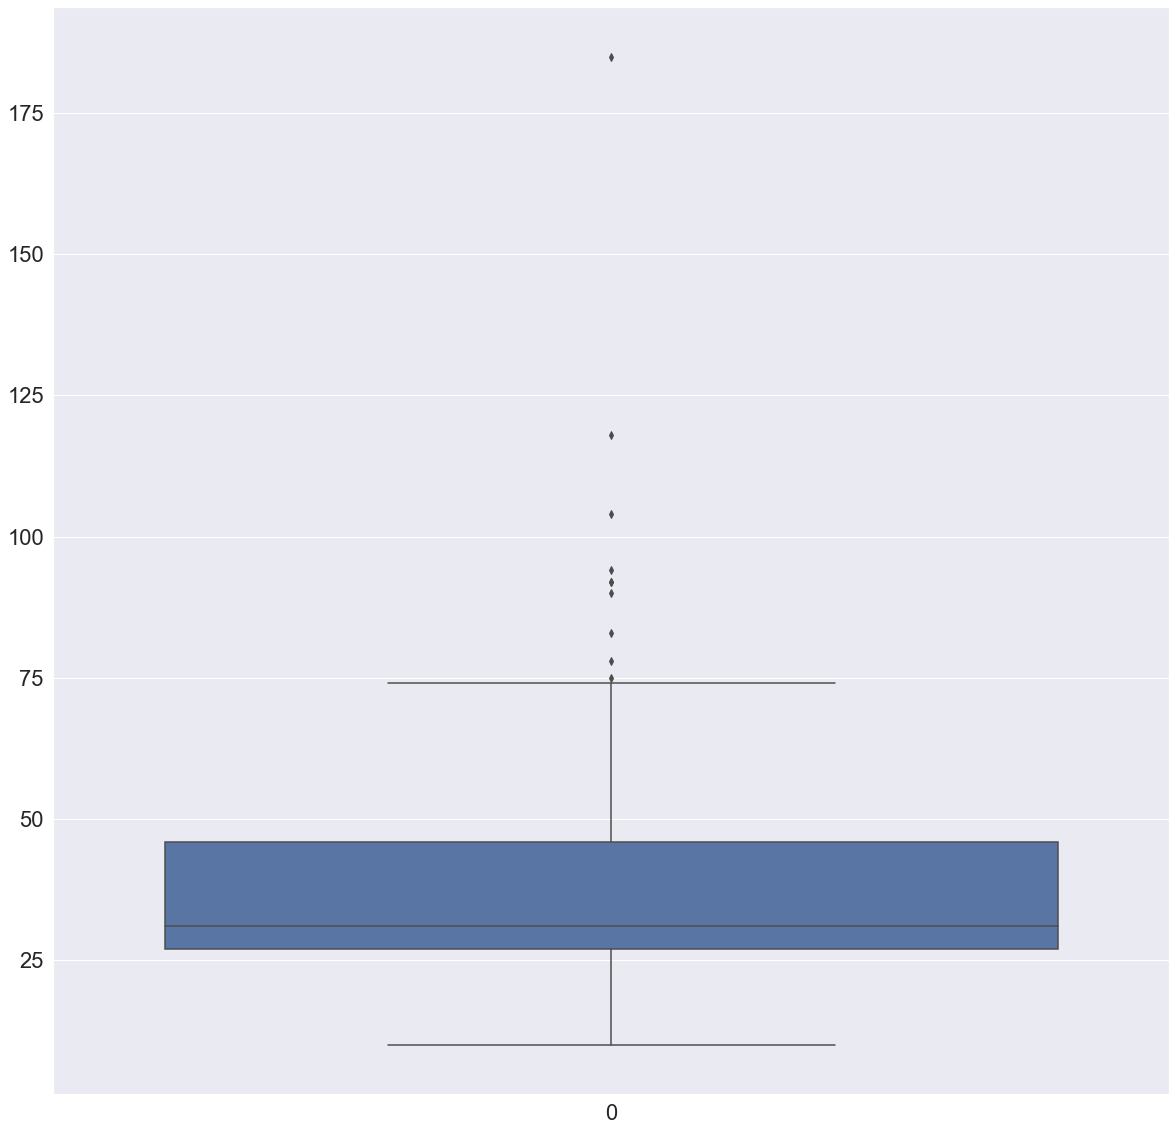

Bulk 2


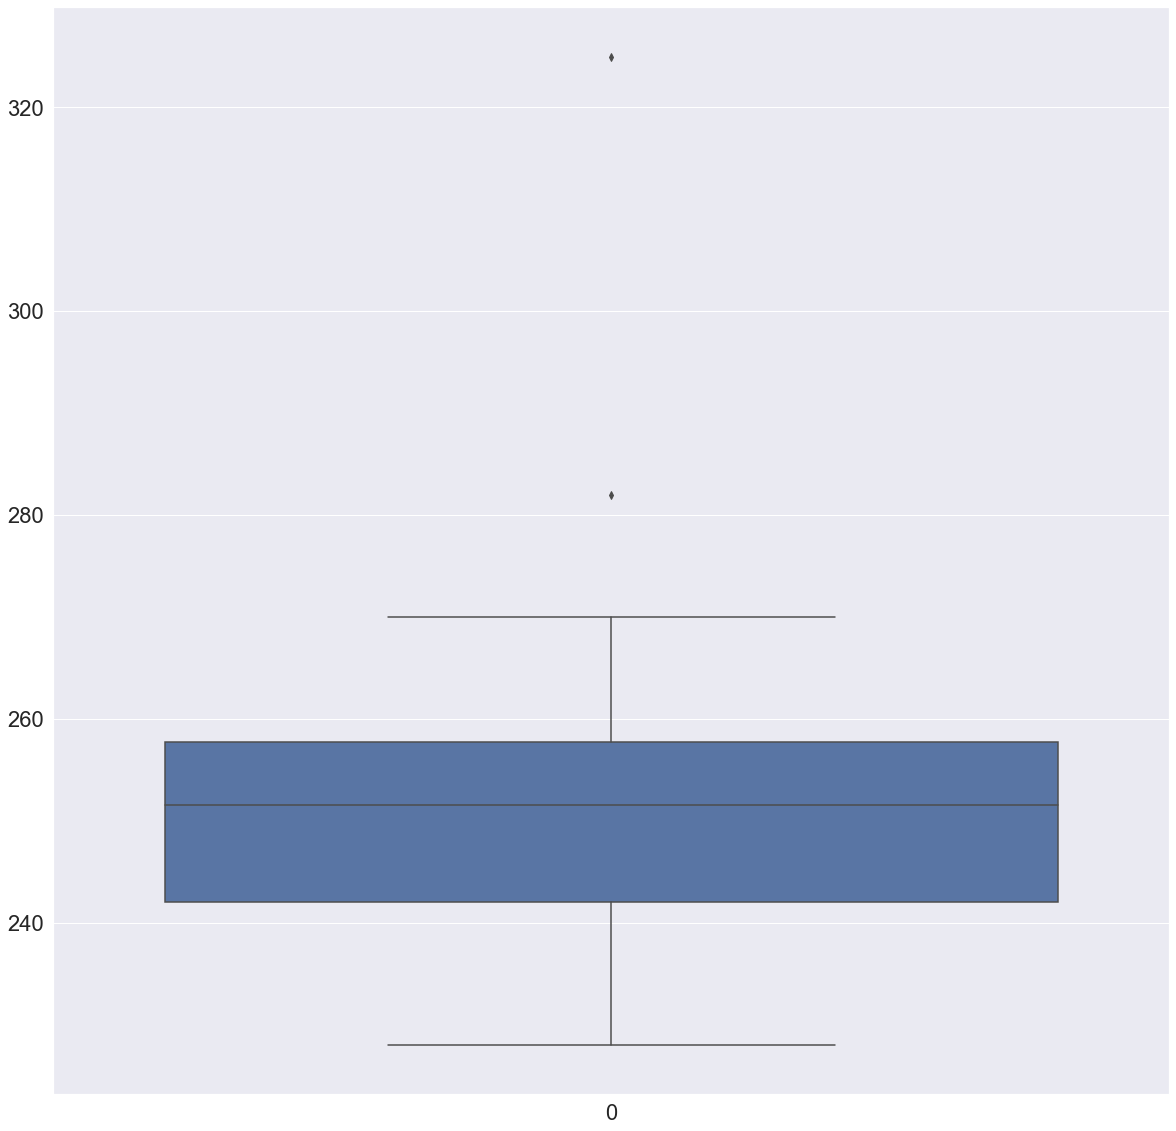

Bulk 3


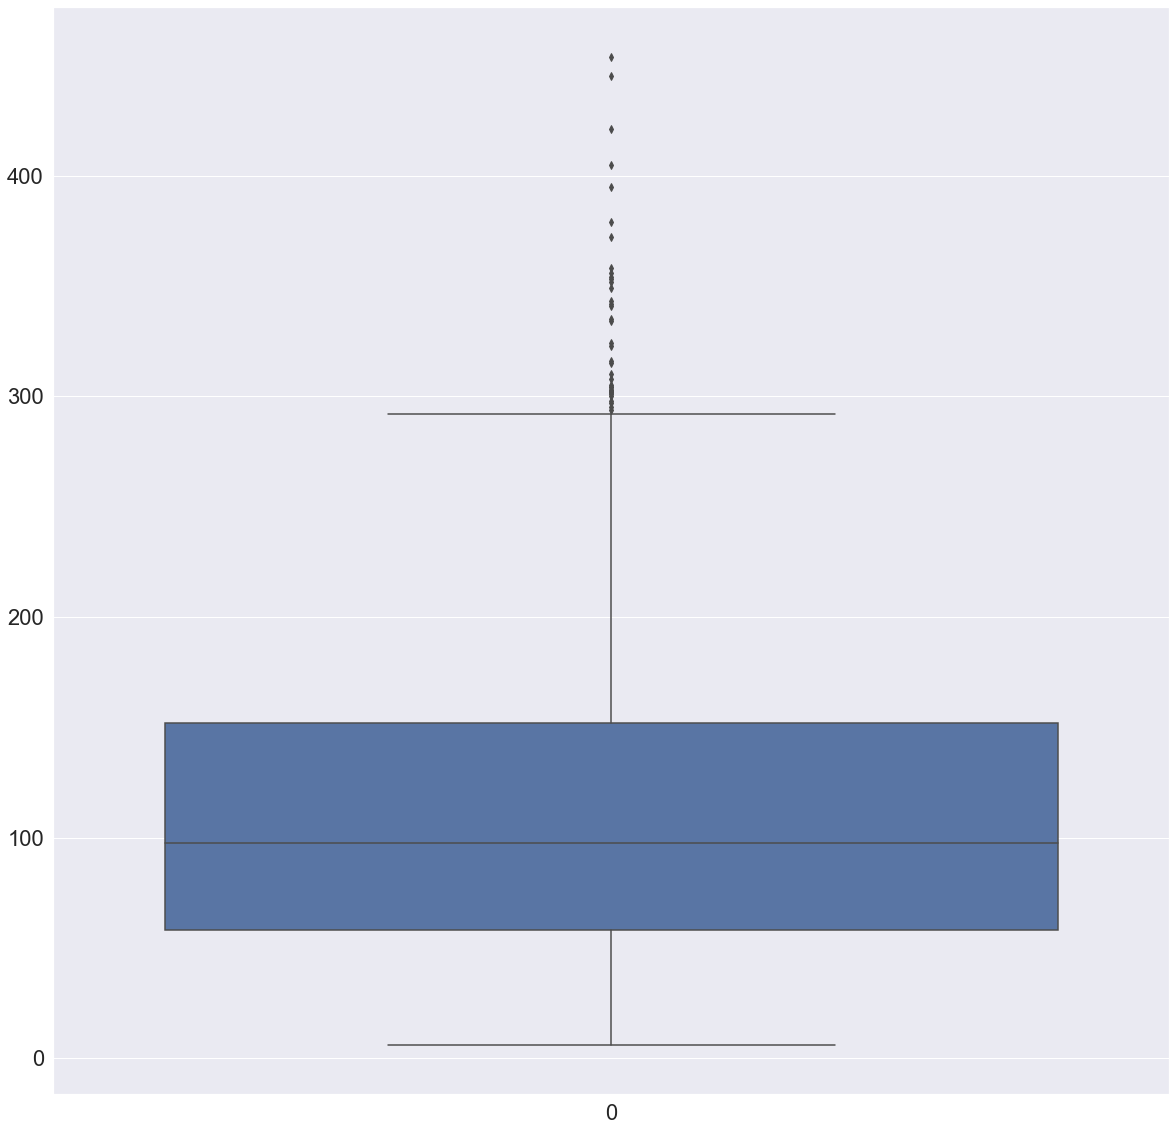

Bulk 4


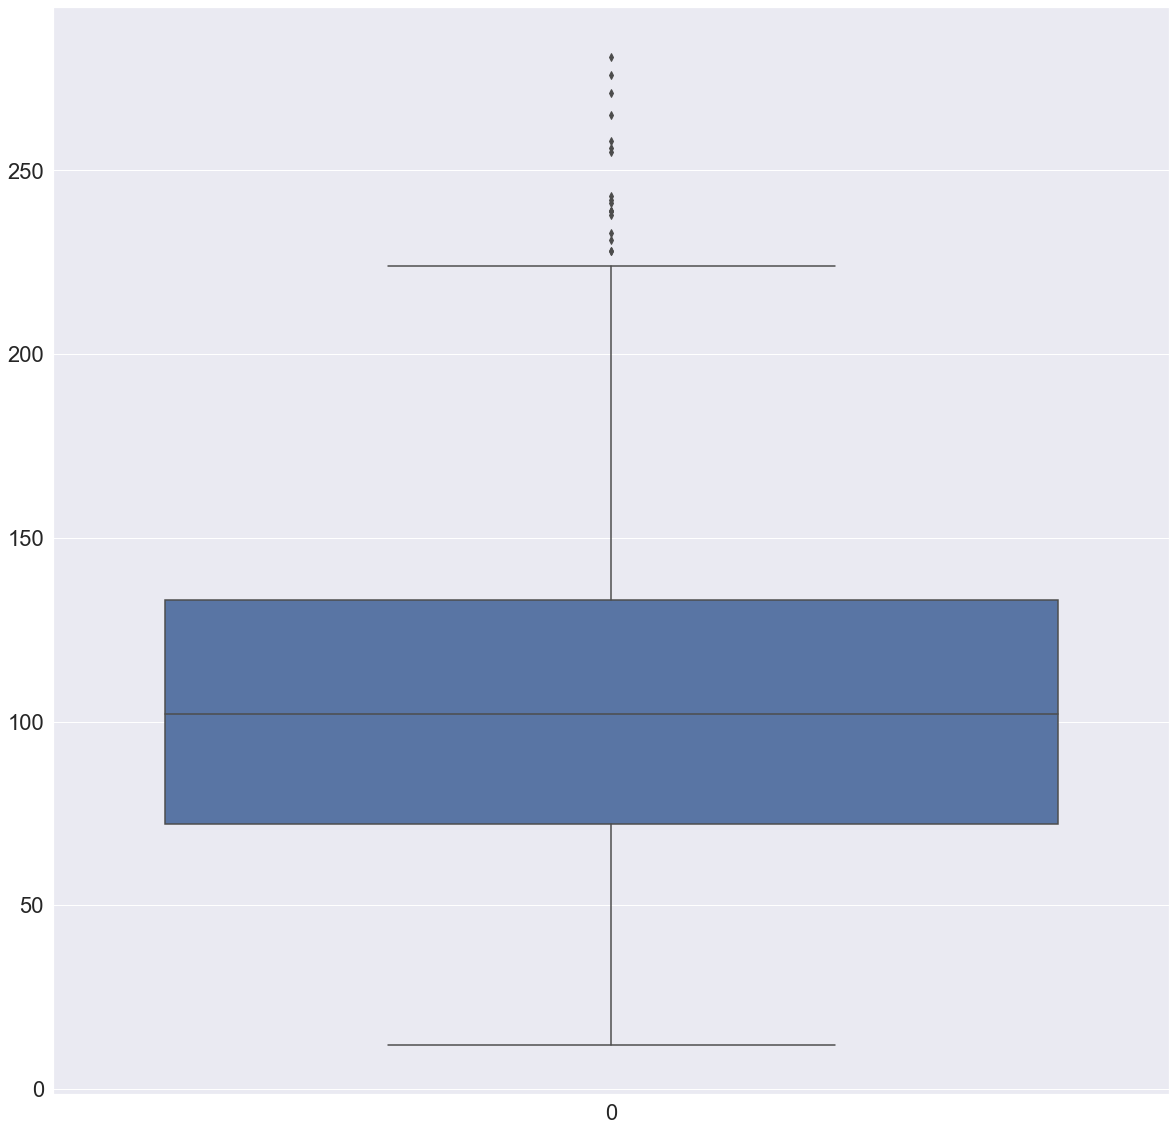

Bulk 5


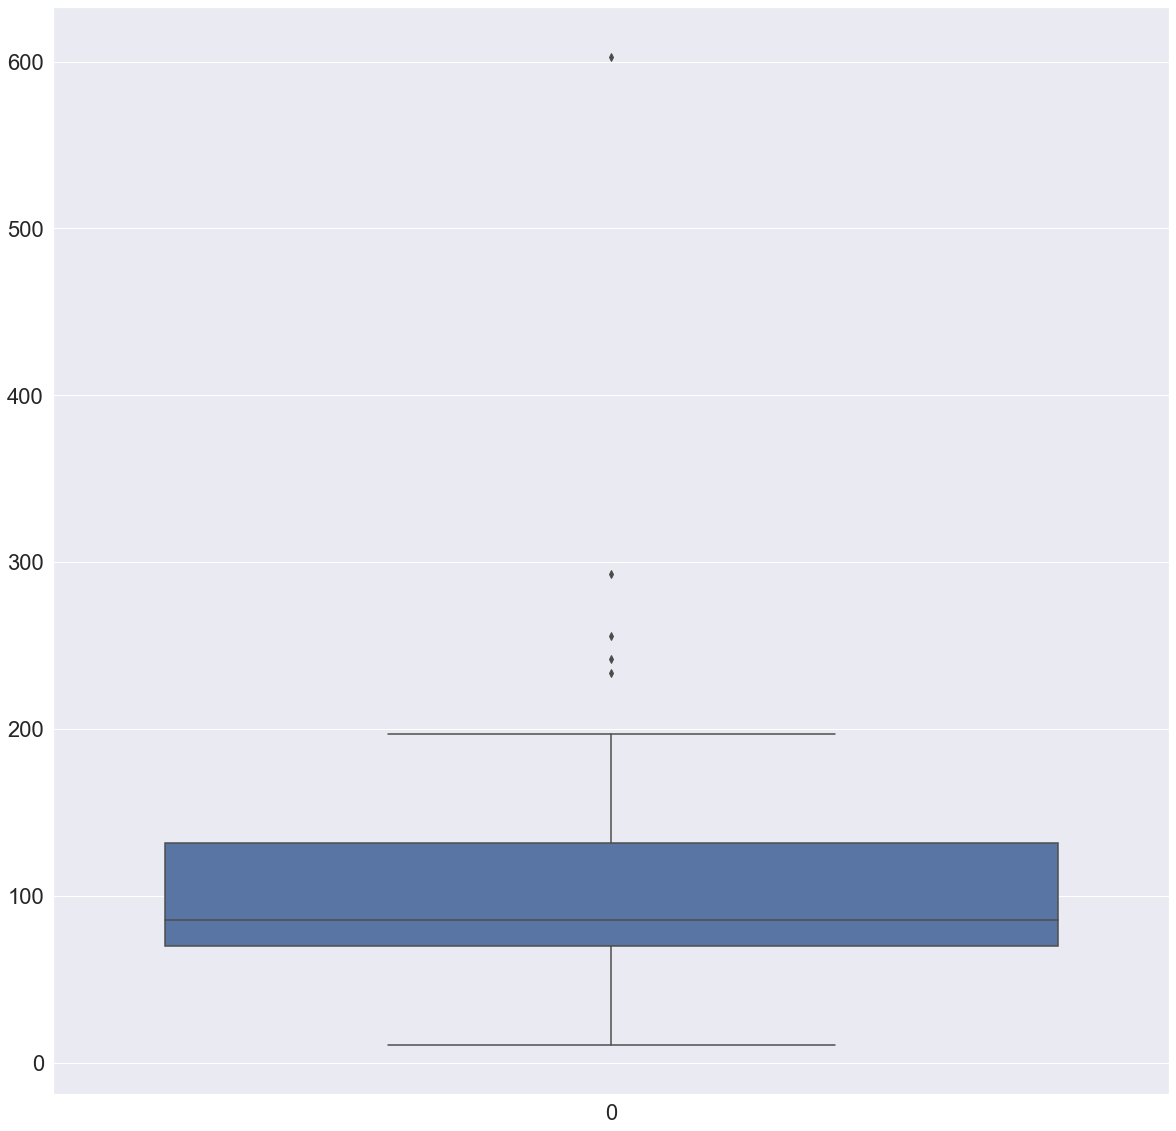

Bulk 6


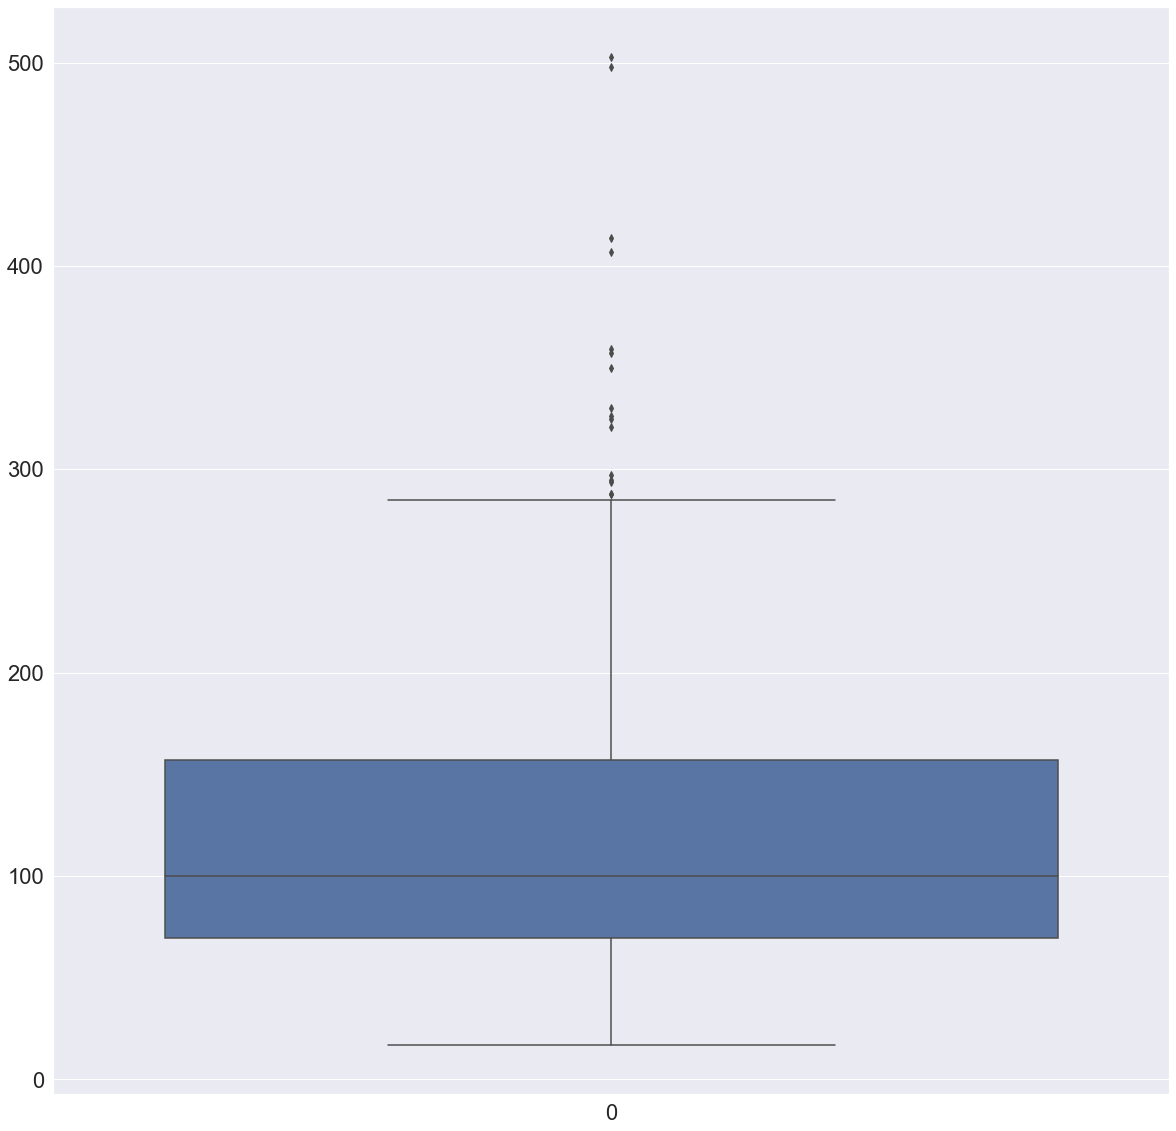

Bulk 7


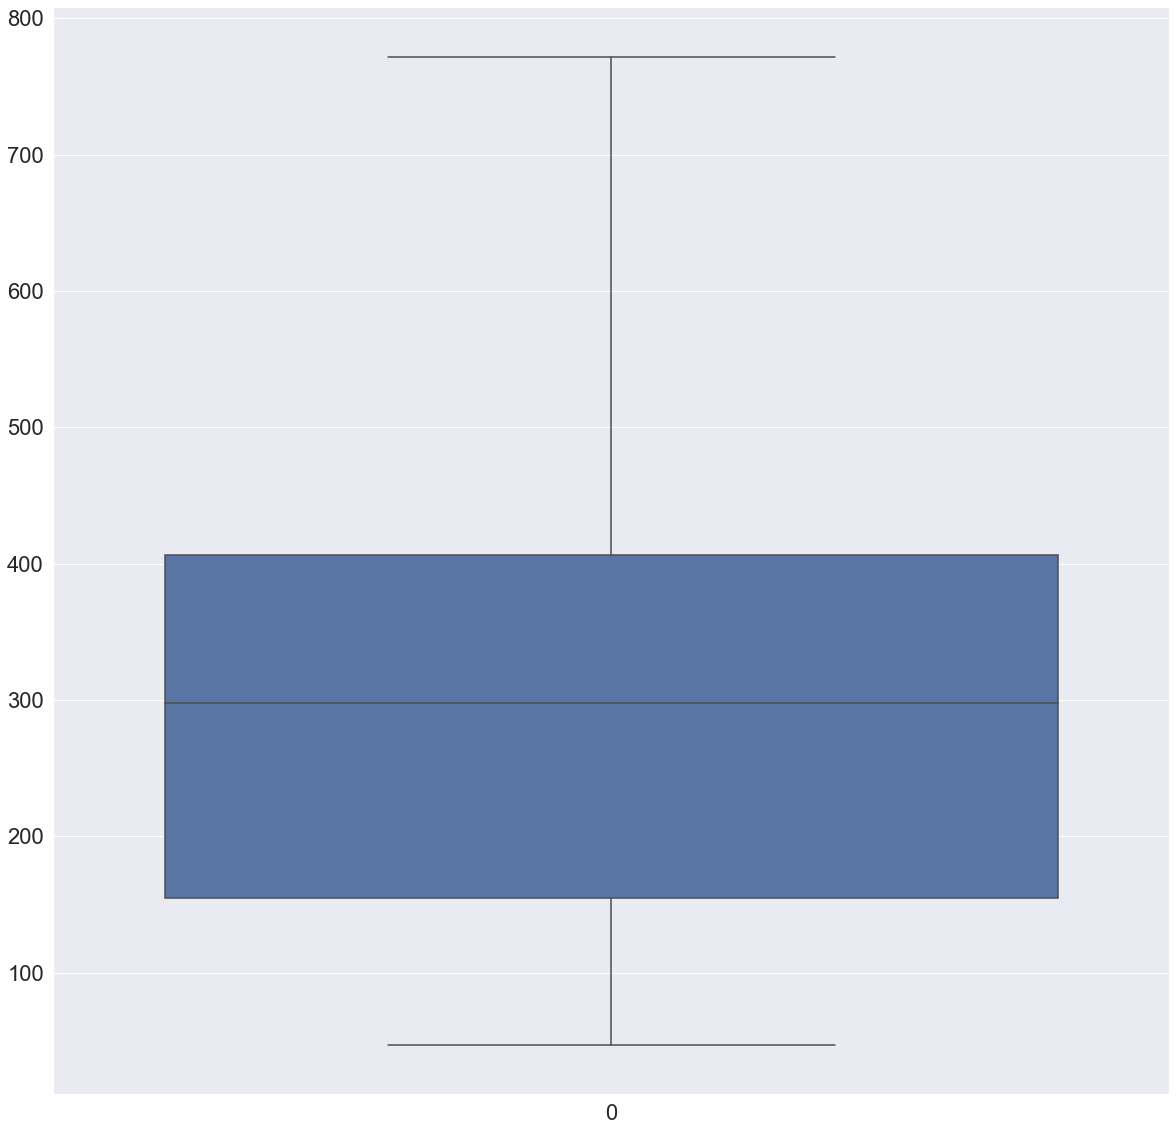

Bulk 8


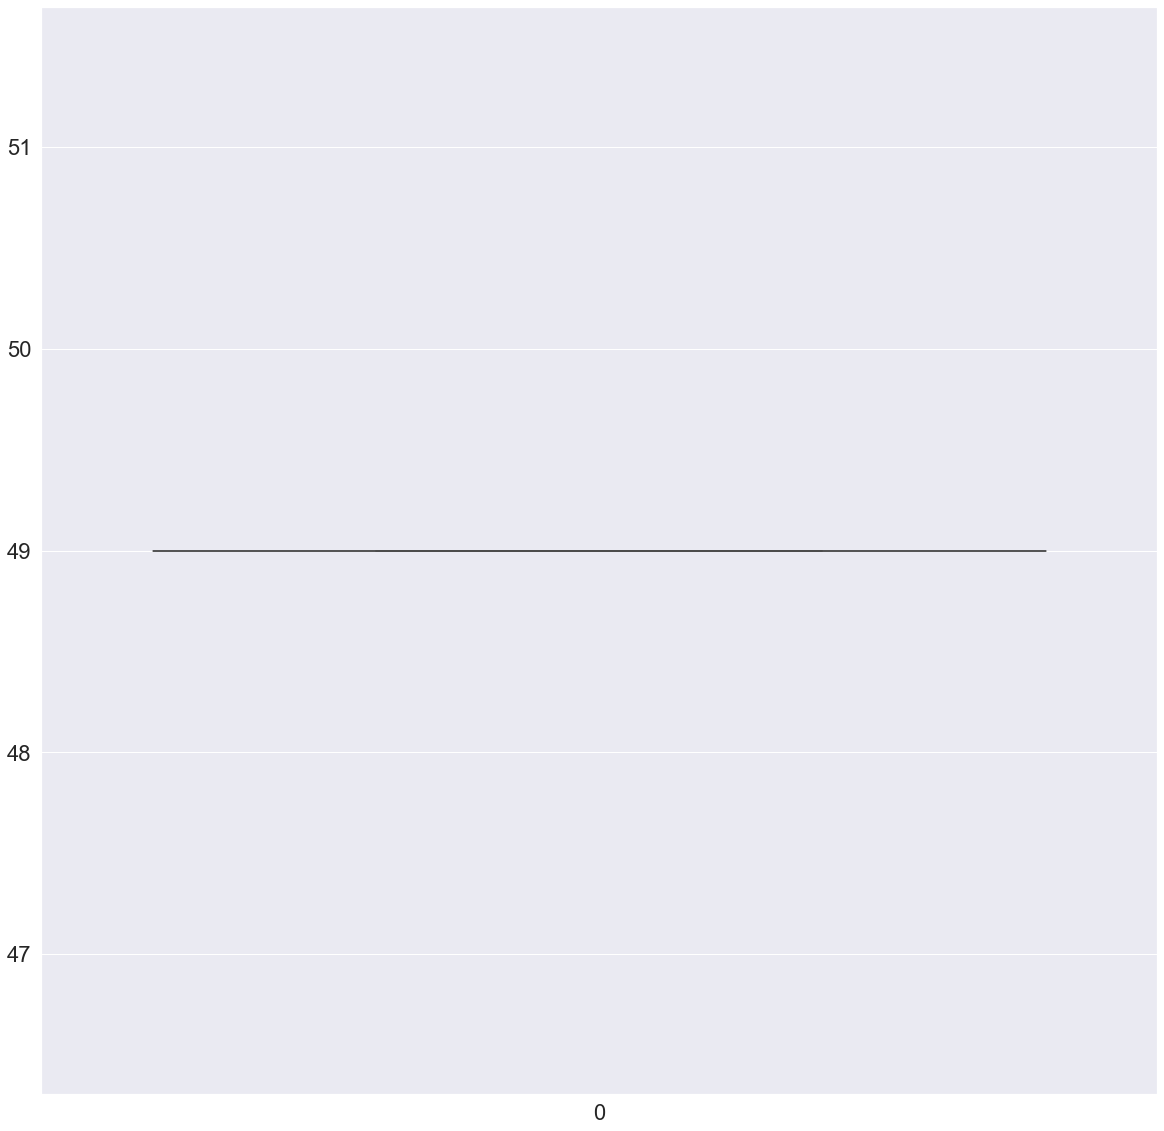

Bulk 9


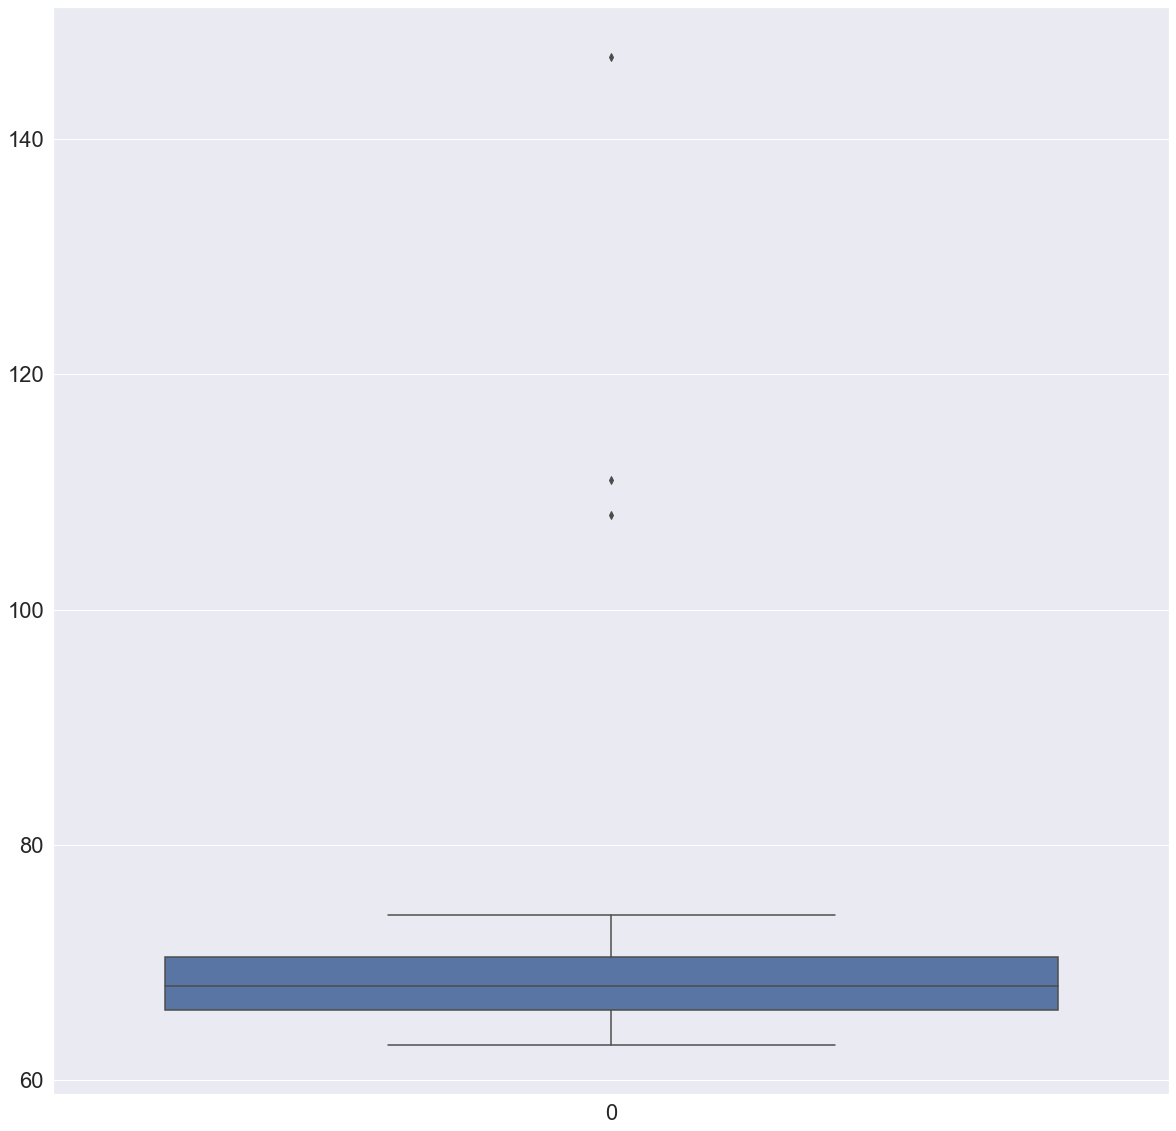

Bulk 10


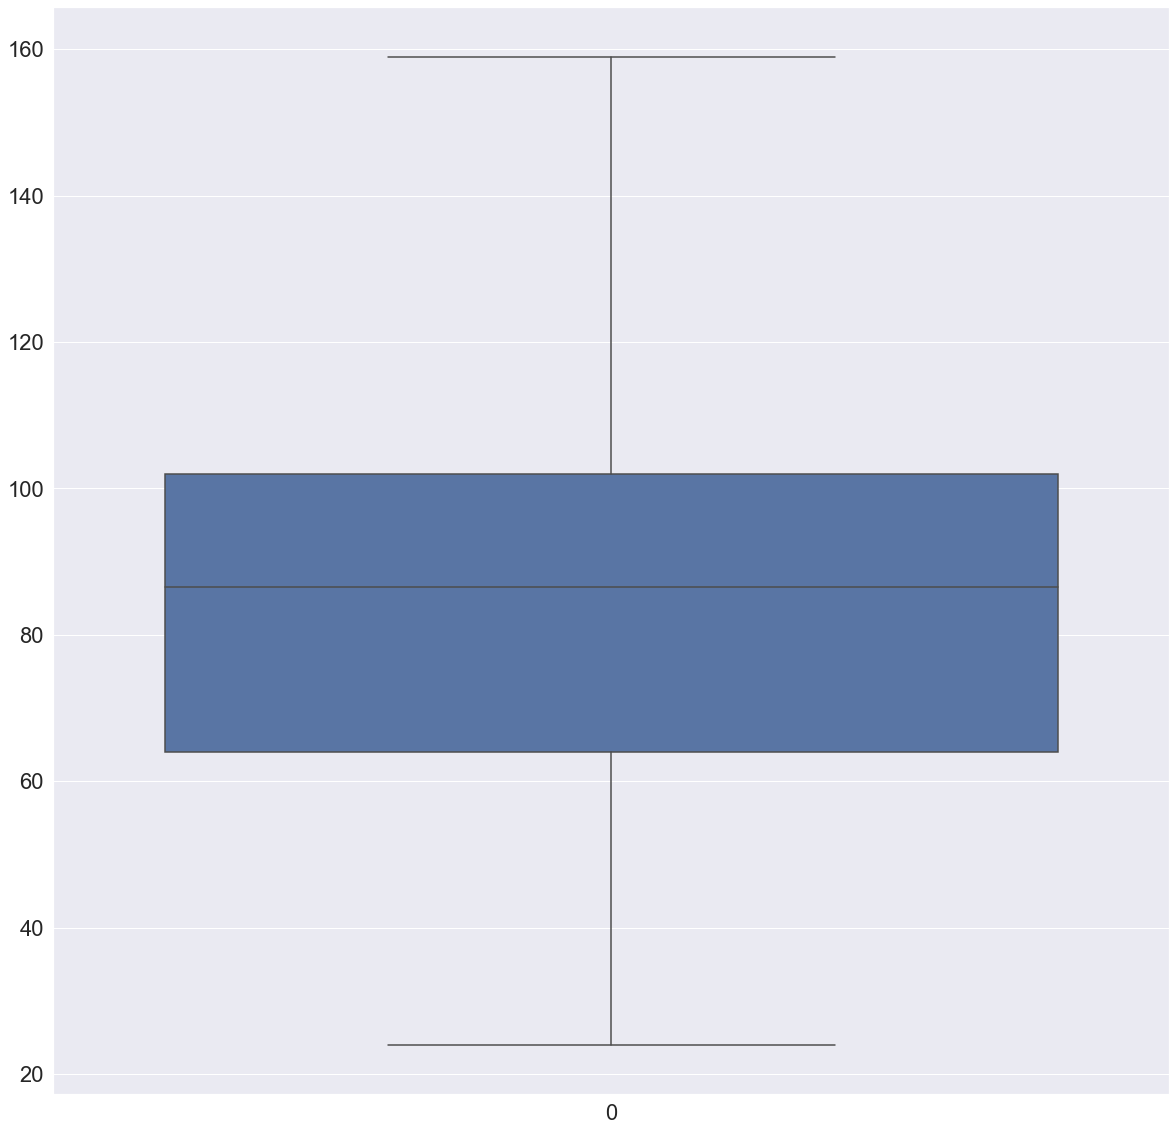

Bulk 11


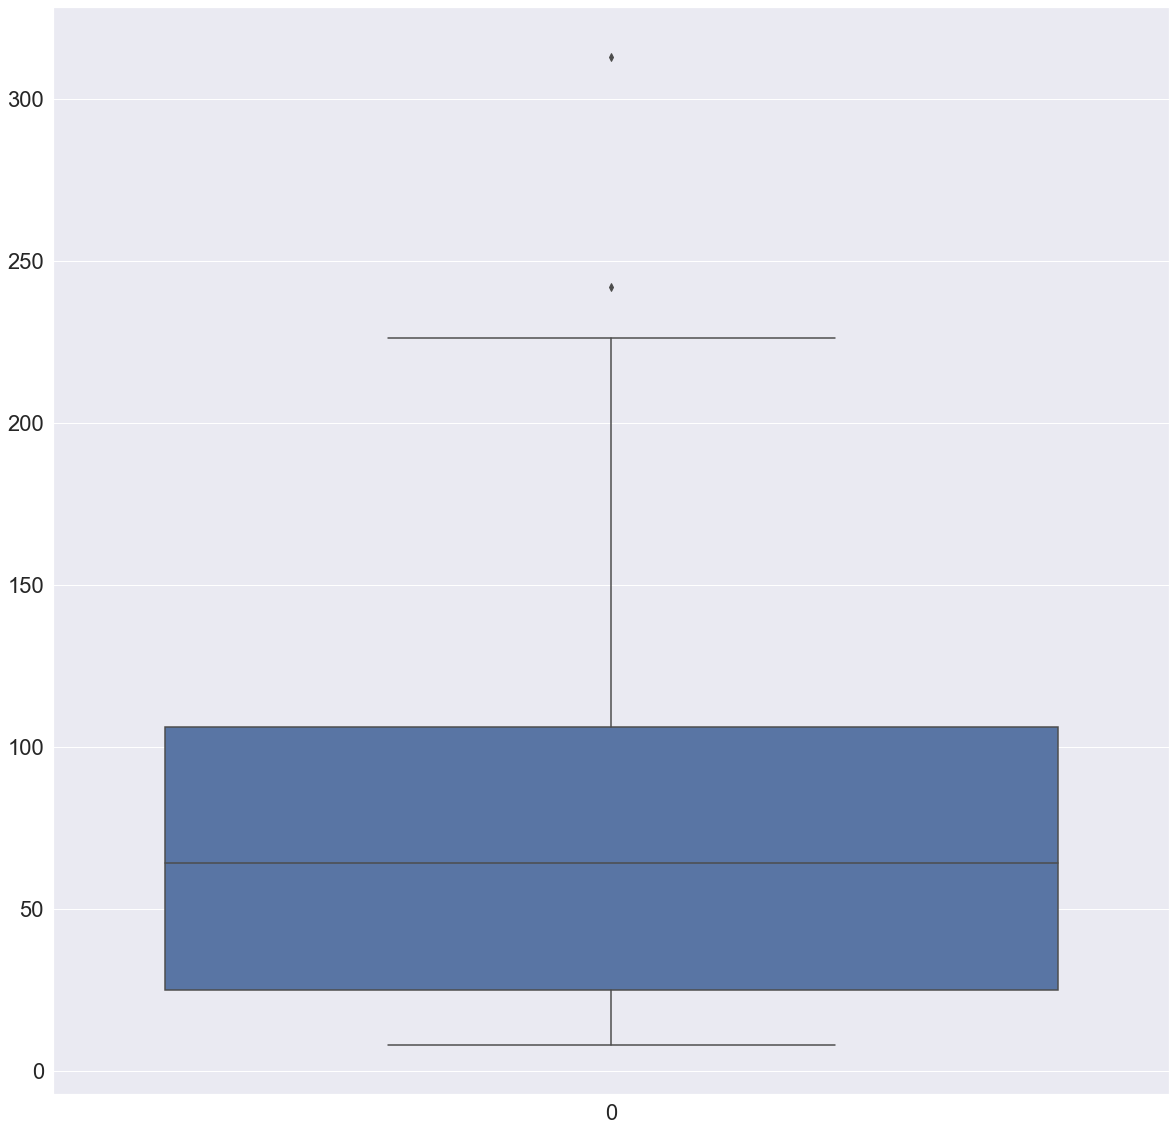

Bulk 12


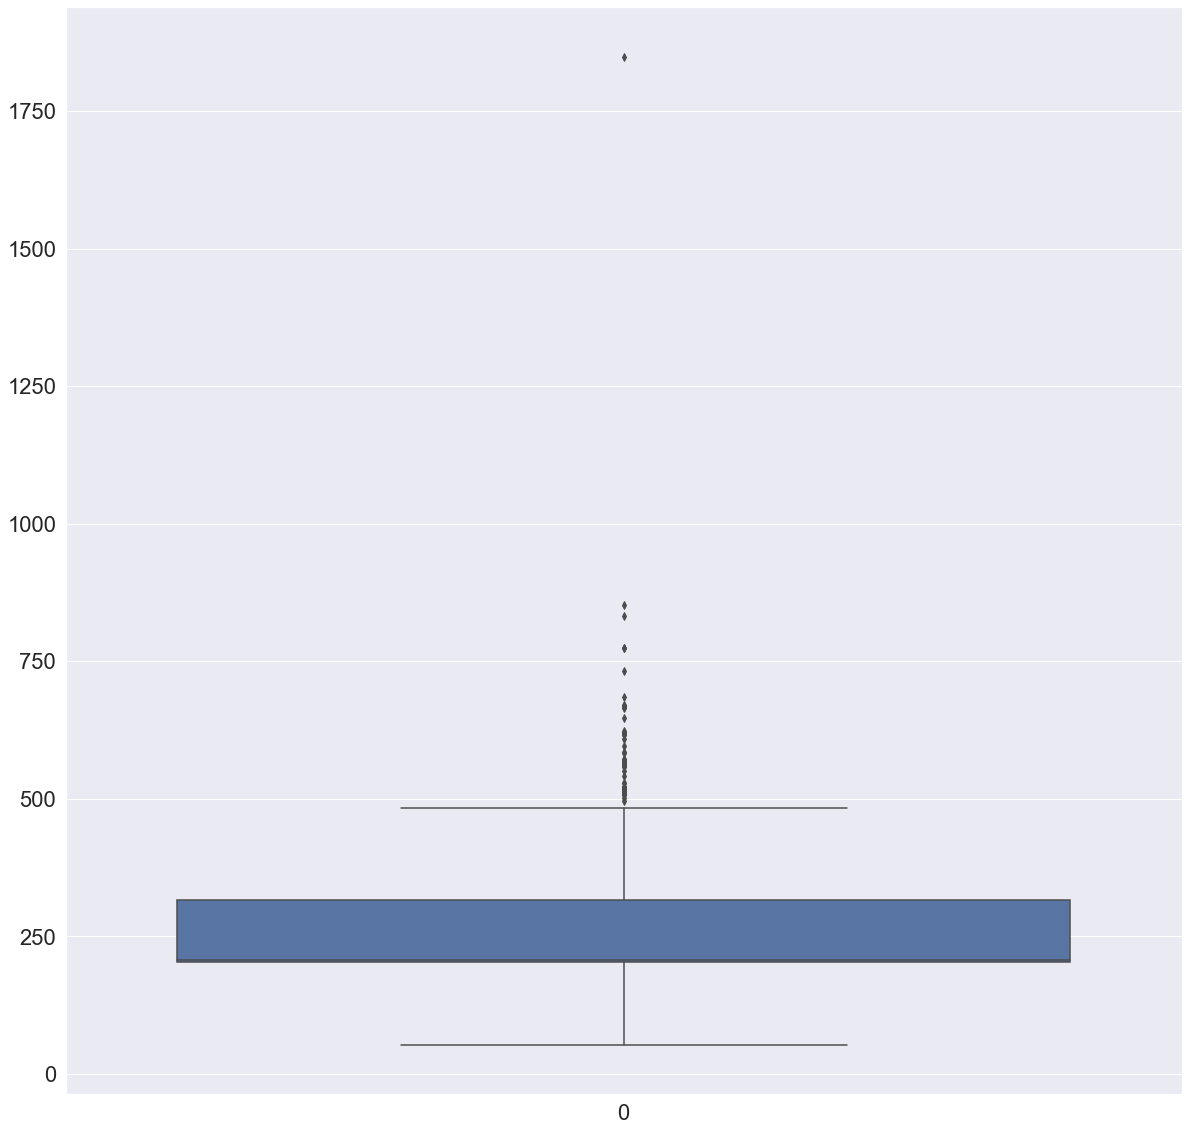

Bulk 13


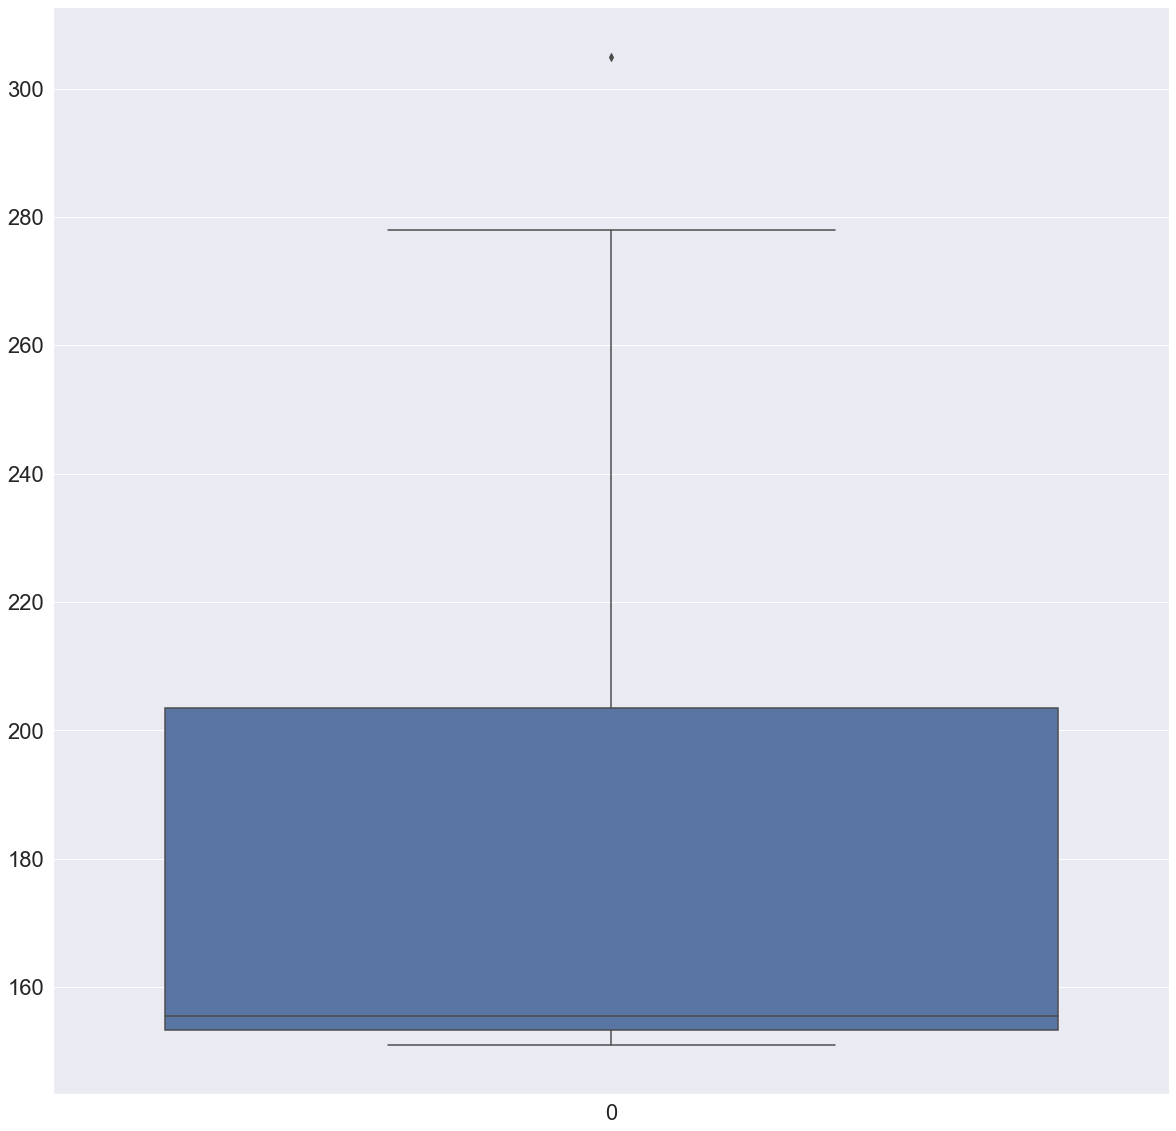

Bulk 14


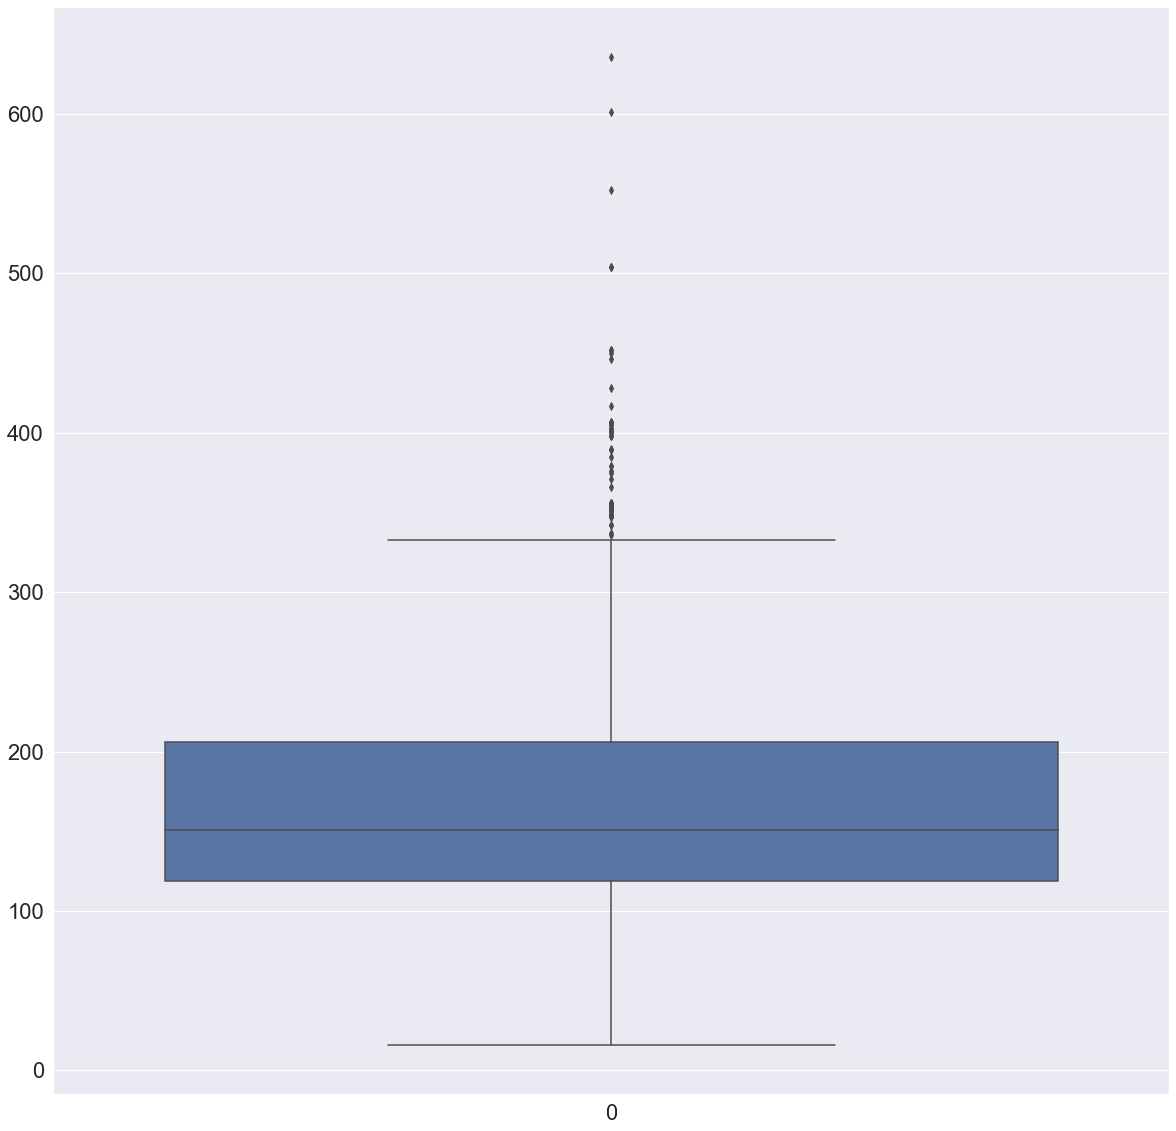

Bulk 15


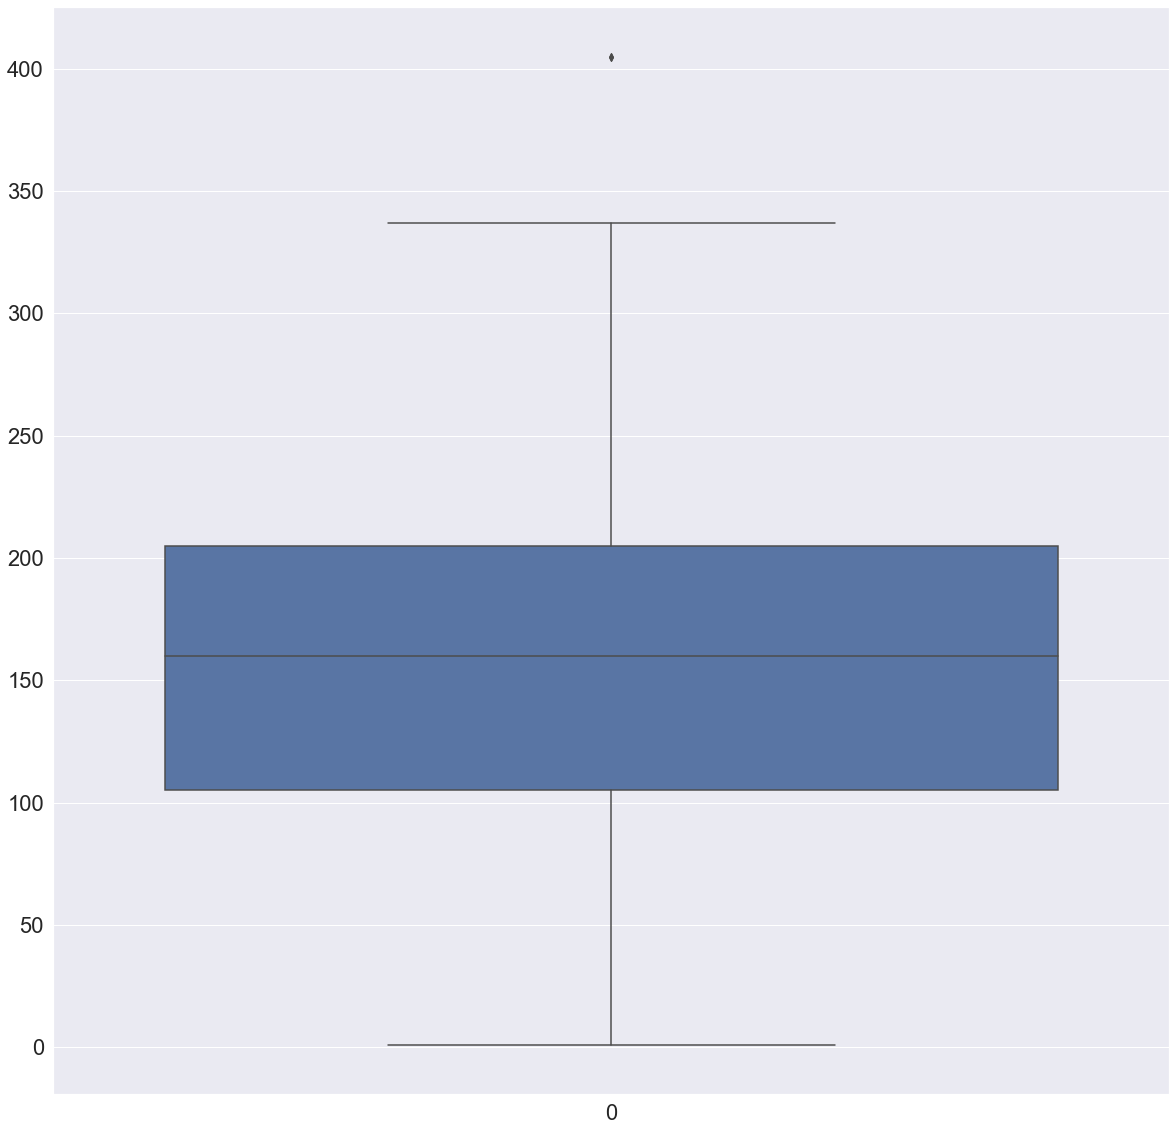

In [6]:
sns.set(font_scale=2)

for i in range(1,16):
    column = 'Bulk ' + str(i)
    print(column)
    plt.figure(figsize=(20,20))
    sns.boxplot(data=data_bulk[column])
    plt.show()

**`Wire`**

Wire 1


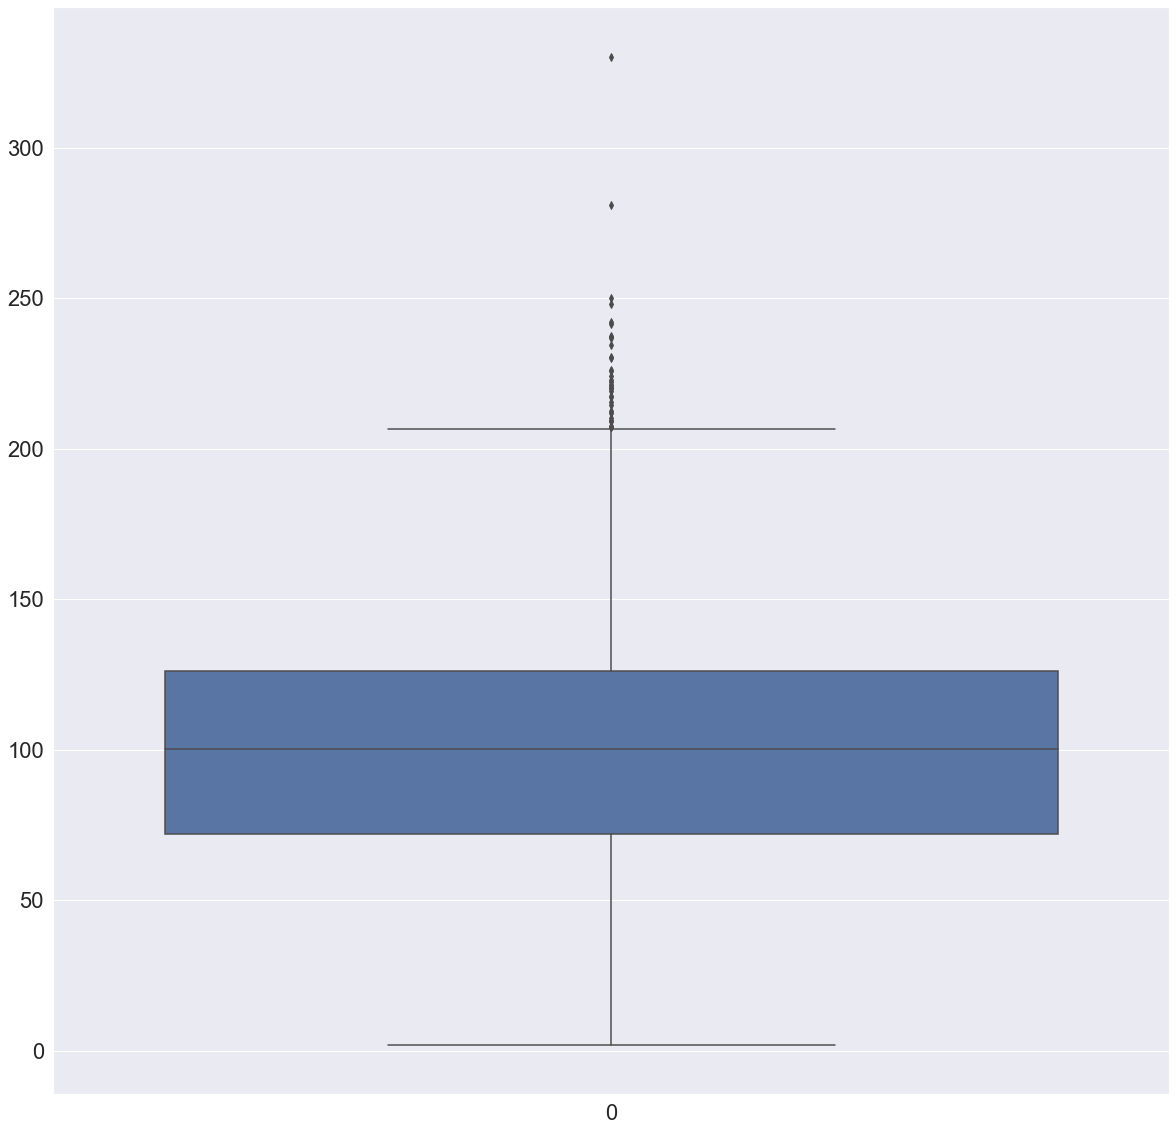

Wire 2


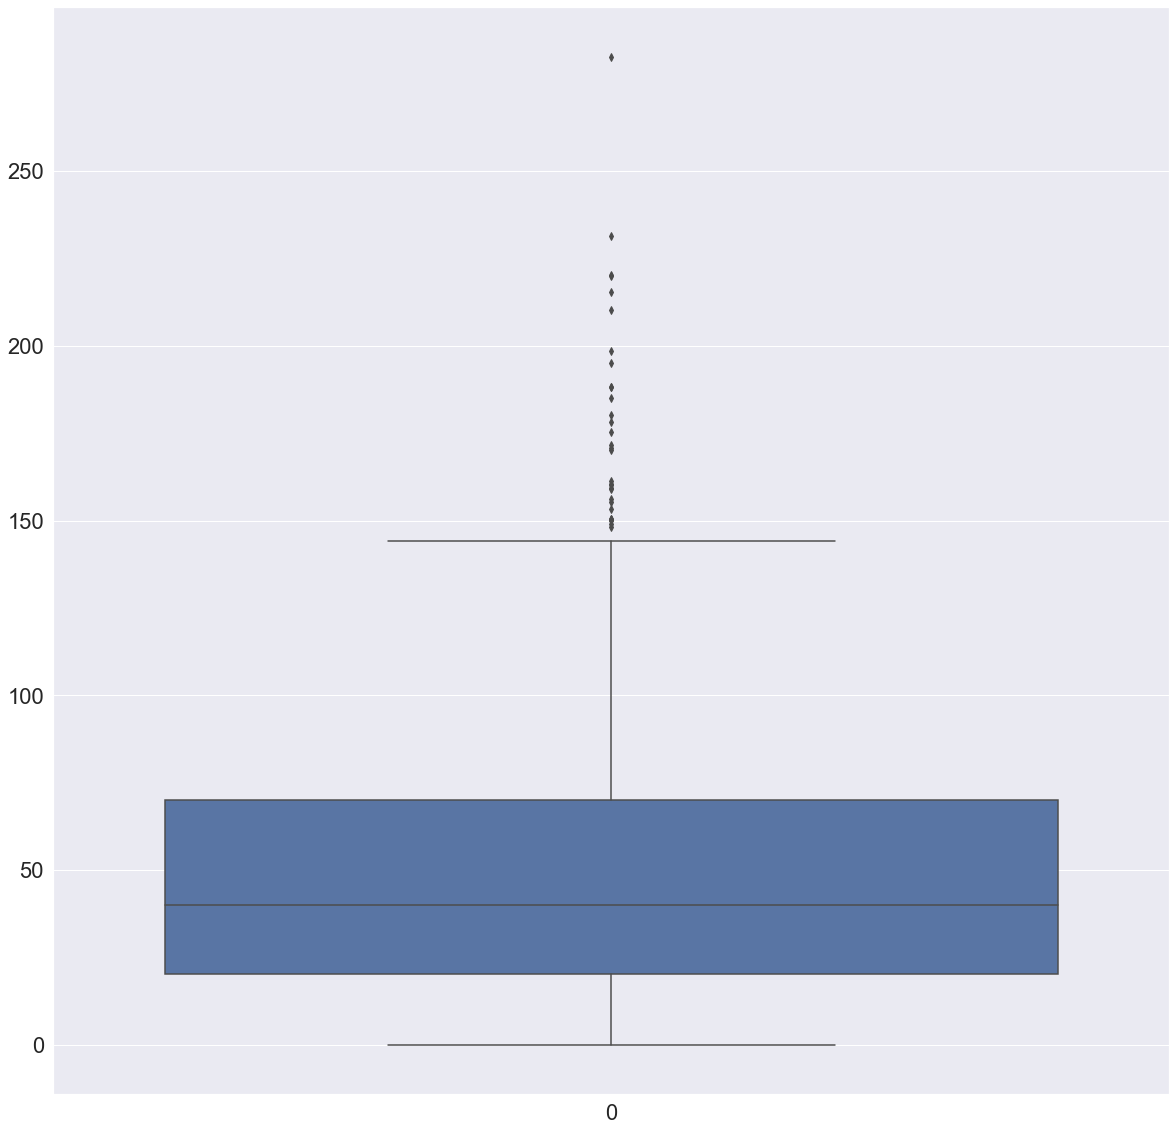

Wire 3


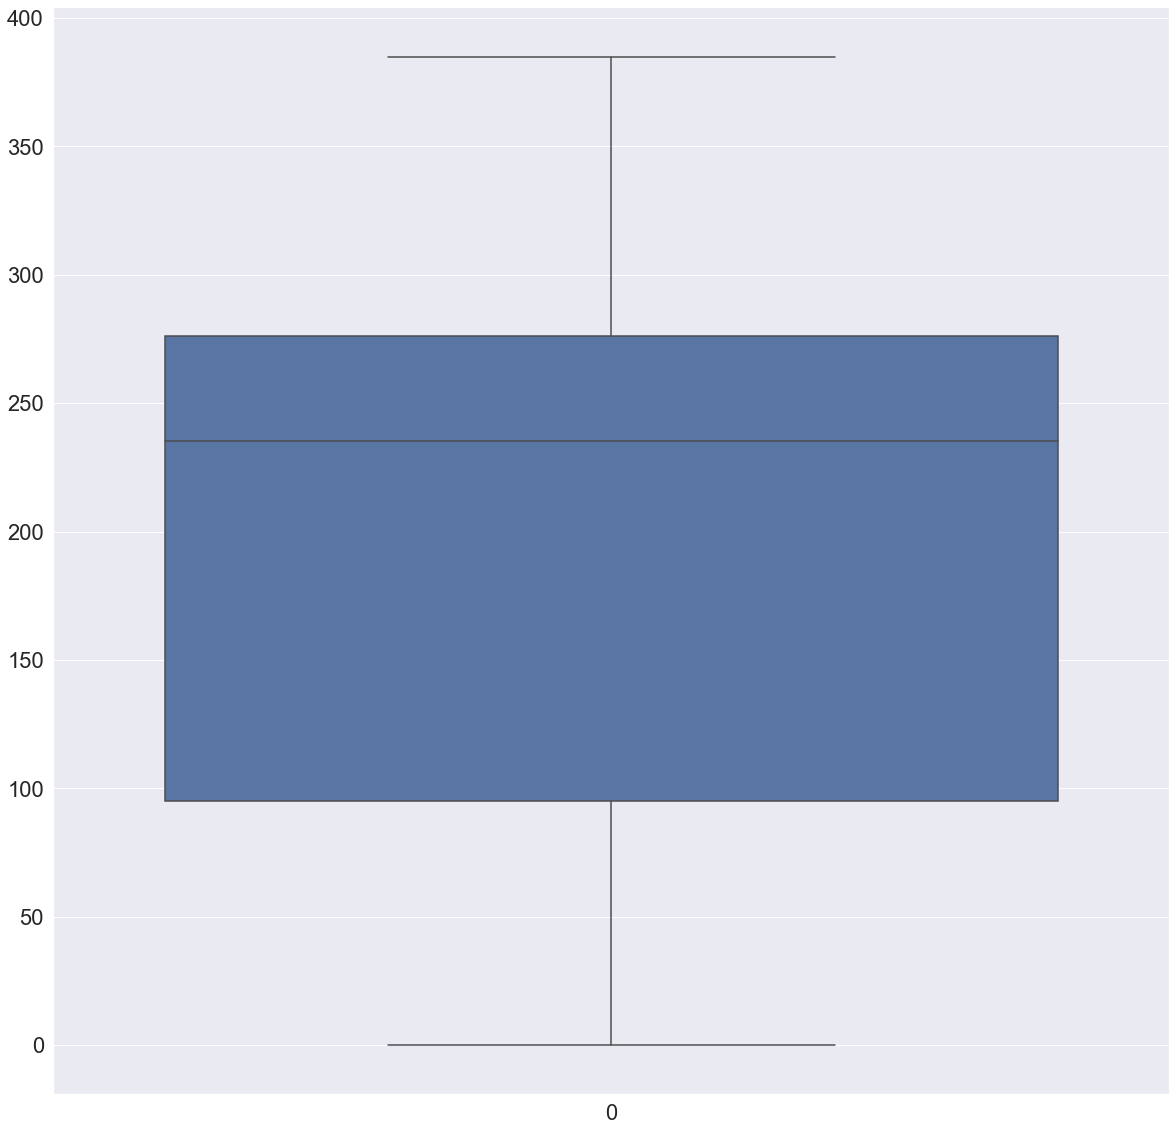

Wire 4


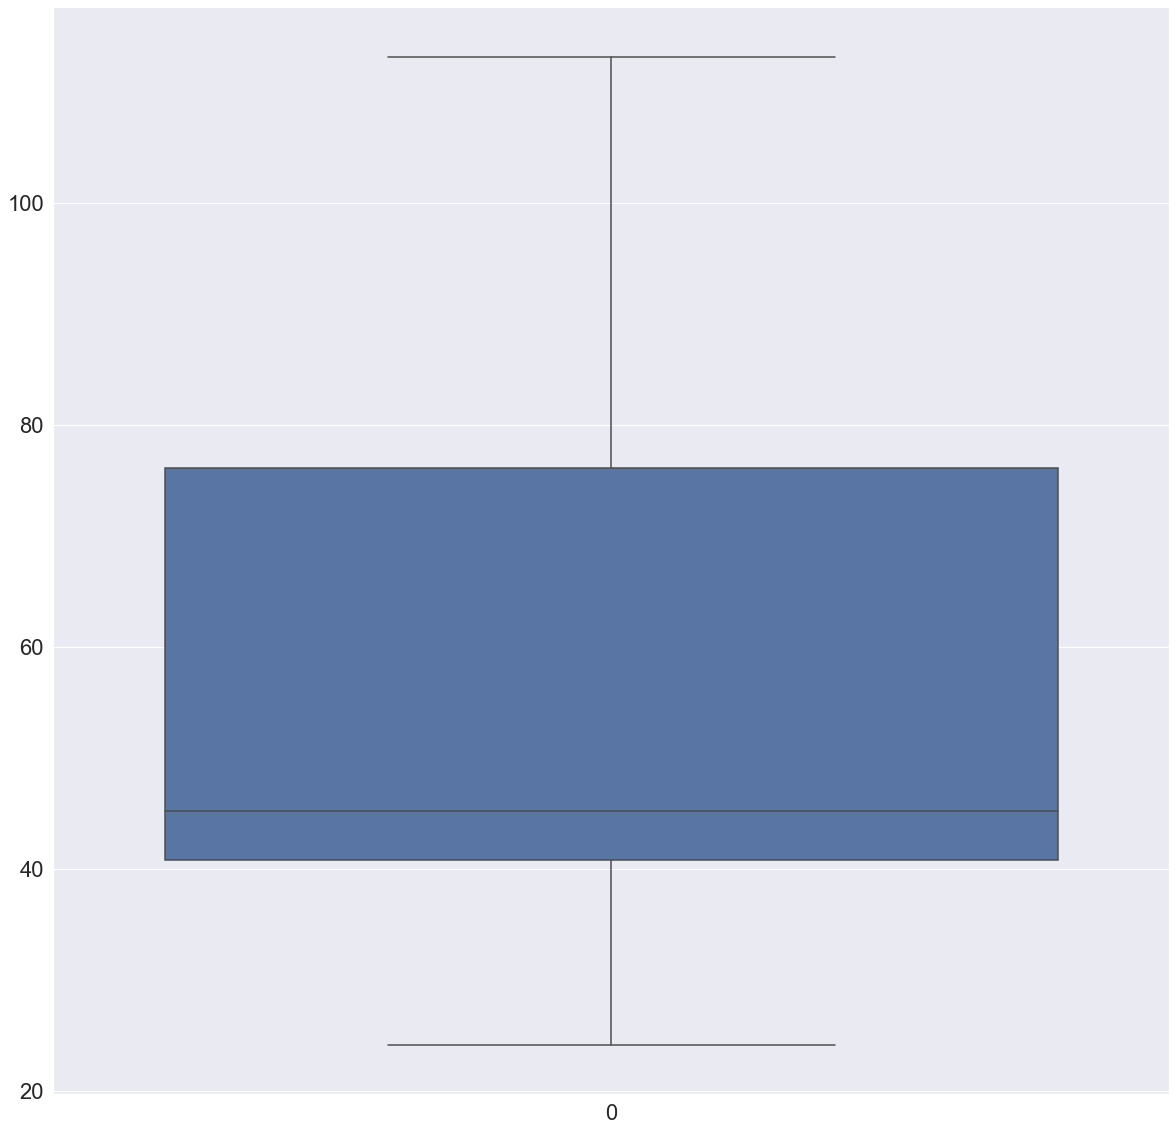

Wire 5


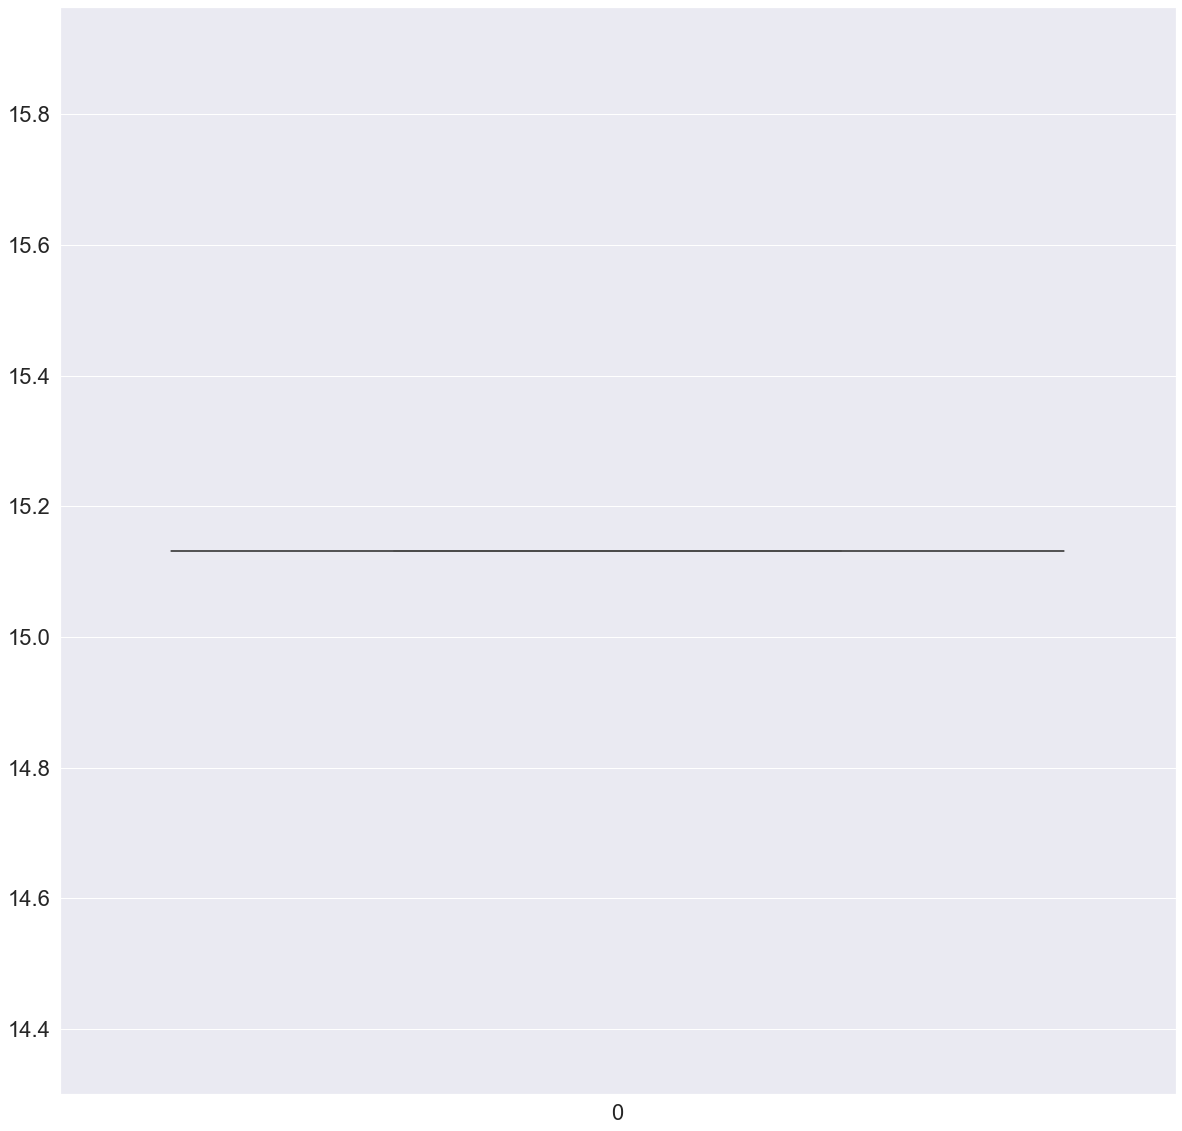

Wire 6


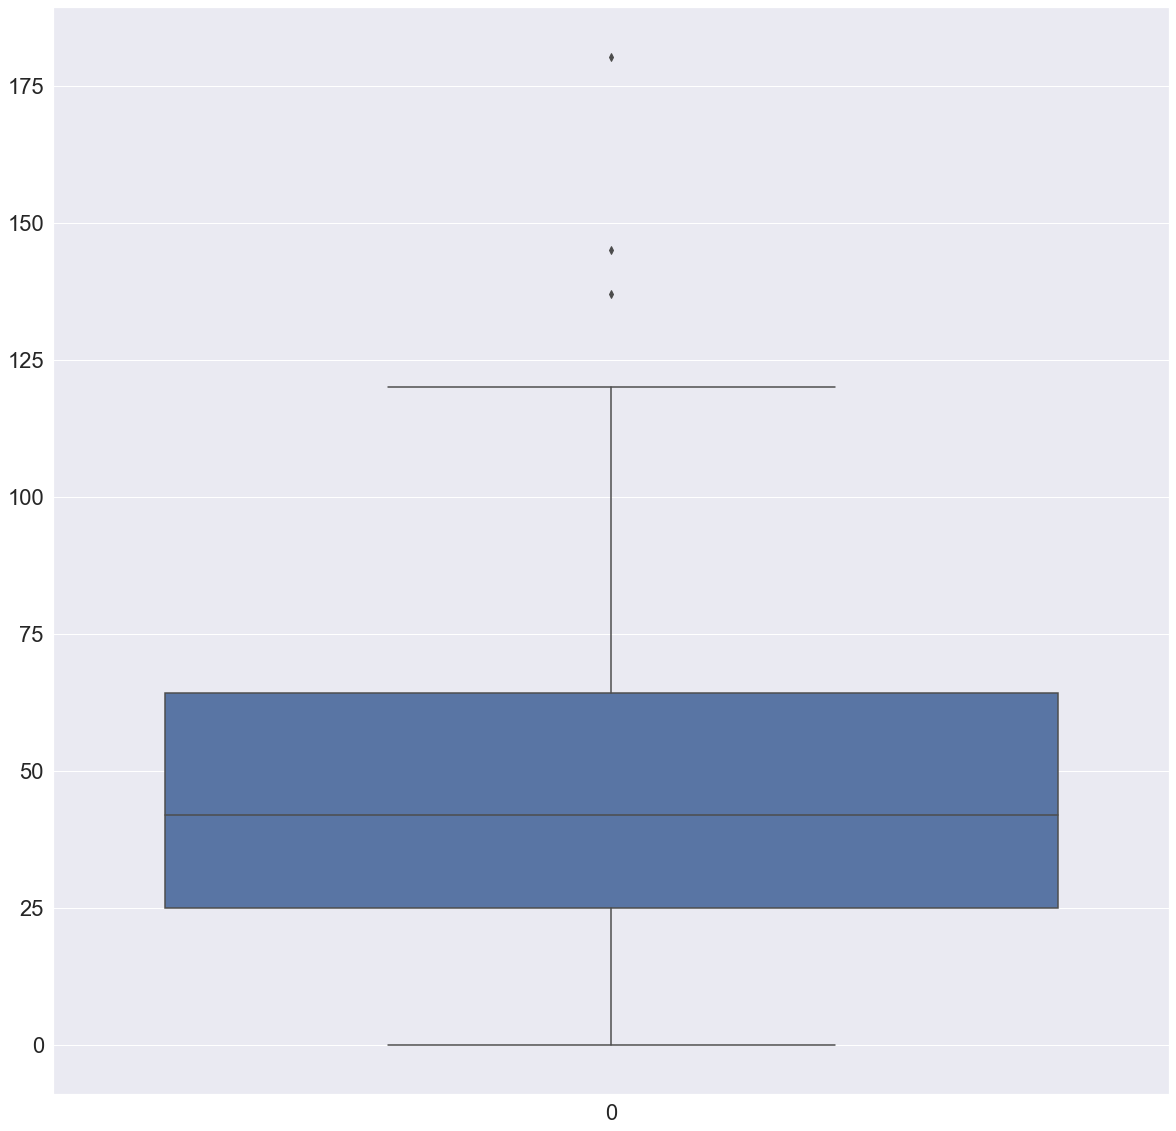

Wire 7


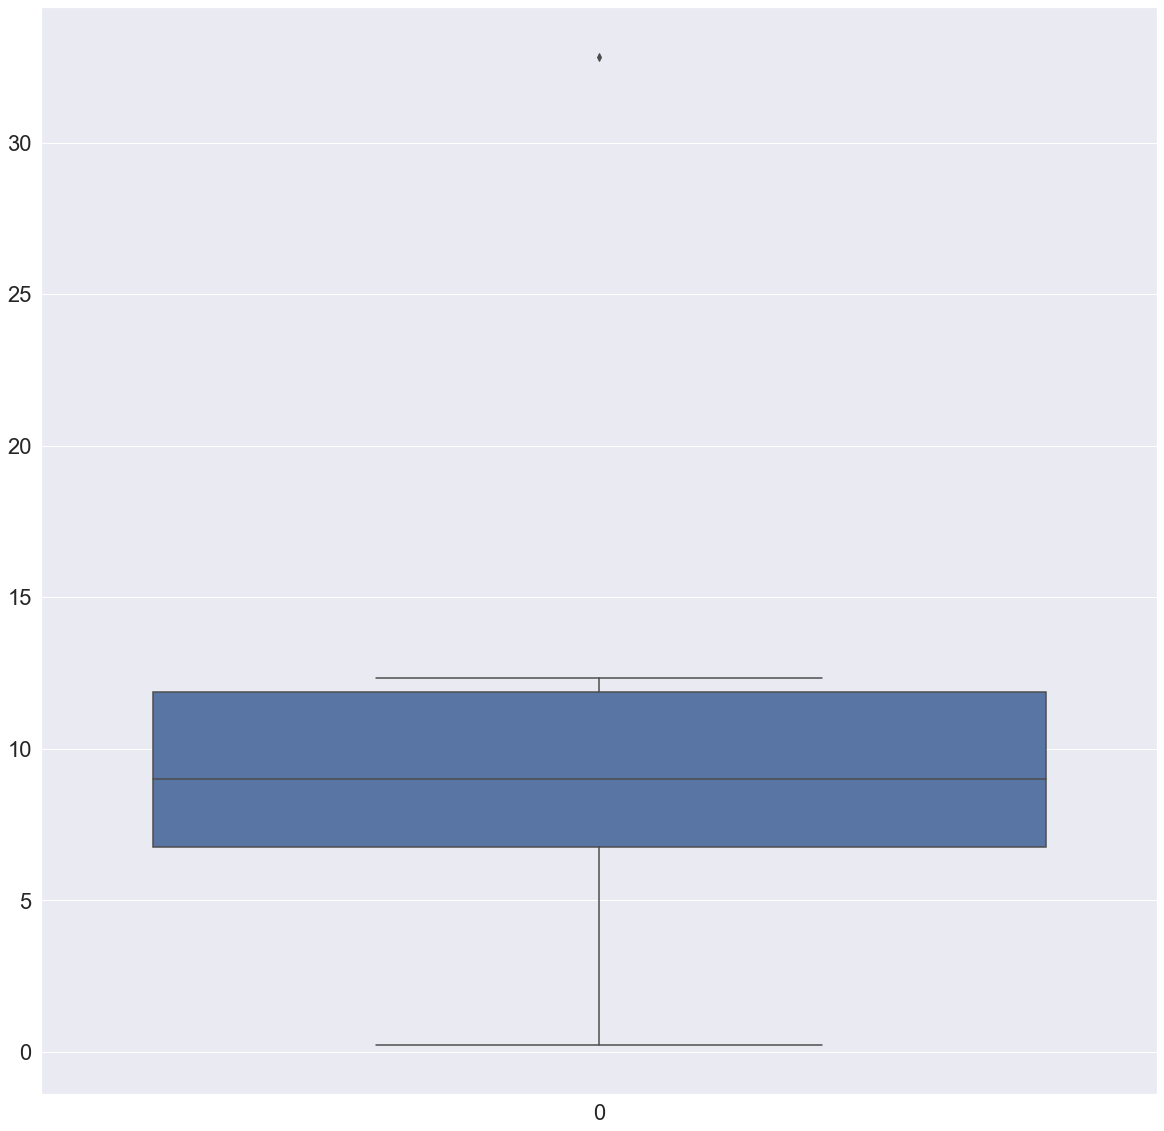

Wire 8


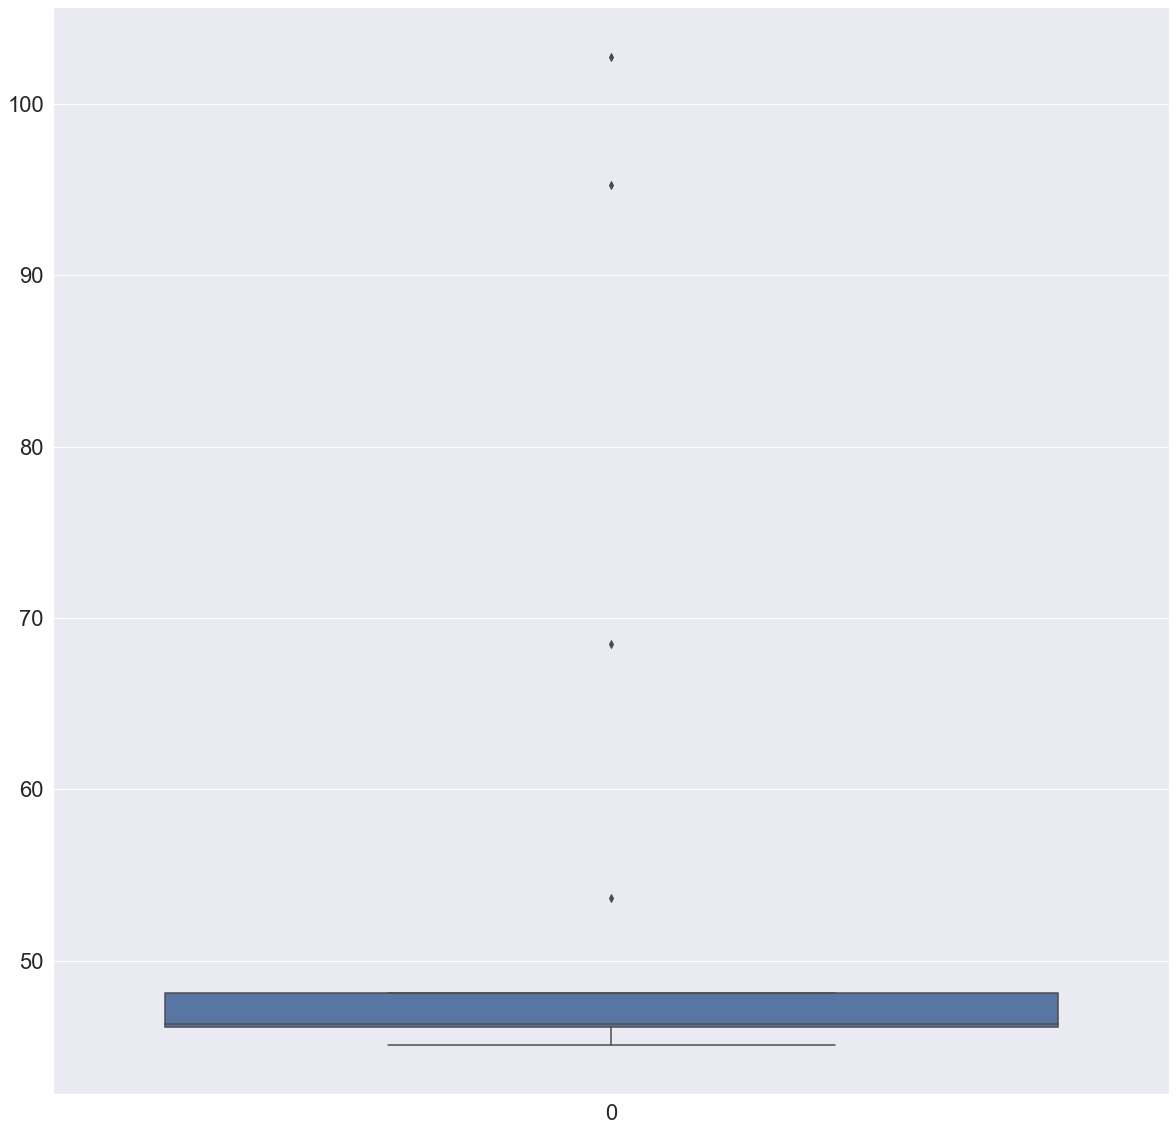

Wire 9


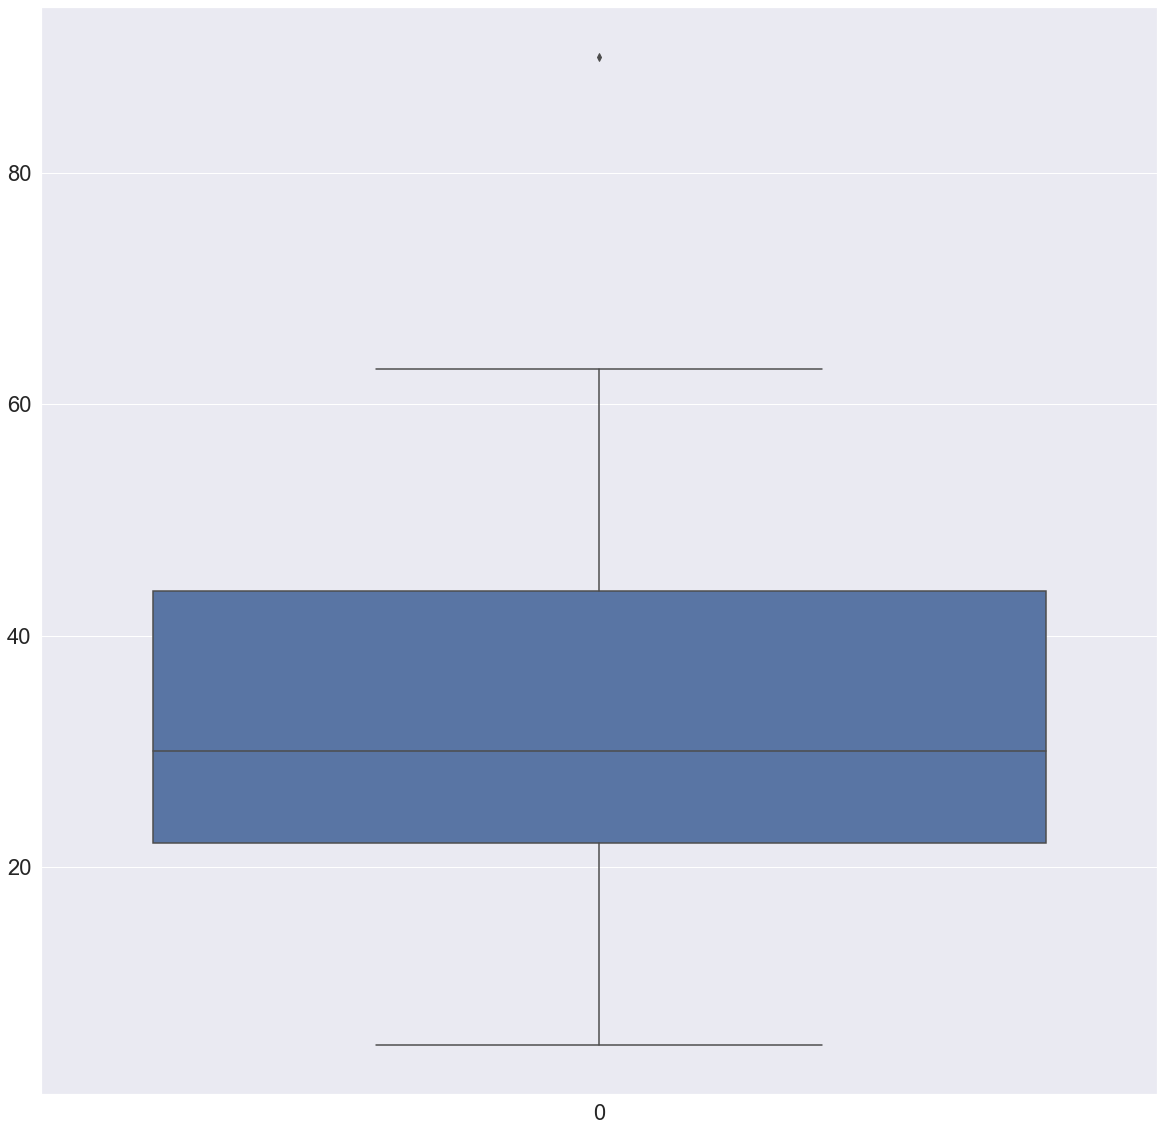

In [7]:
sns.set(font_scale=2)

for i in range(1,10):
    column = 'Wire ' + str(i)
    print(column)
    plt.figure(figsize=(20,20))
    sns.boxplot(data=data_wire[column])
    plt.show()

**`Газ 1`**

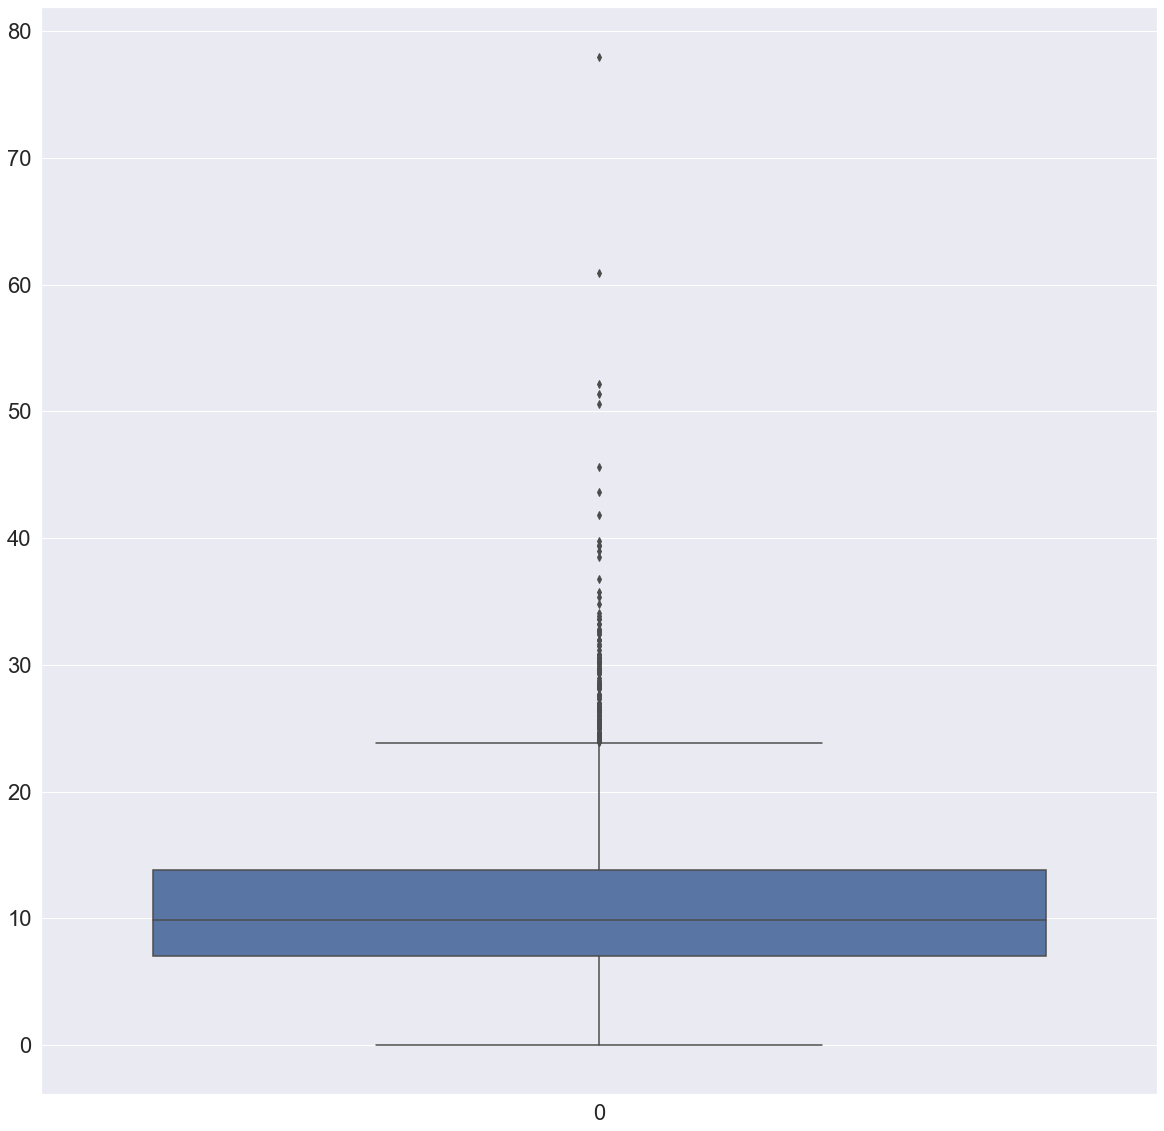

In [8]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.boxplot(data=data_gas['Газ 1'])
plt.show()

**Let's not remove `Bulk`, `Wire`, `Gas 1` emissions yet. Since the entire technological process is unknown, as well as the initial composition. If the accuracy of the model is low, then you need to go back and try to remove outliers**

**`Power`**

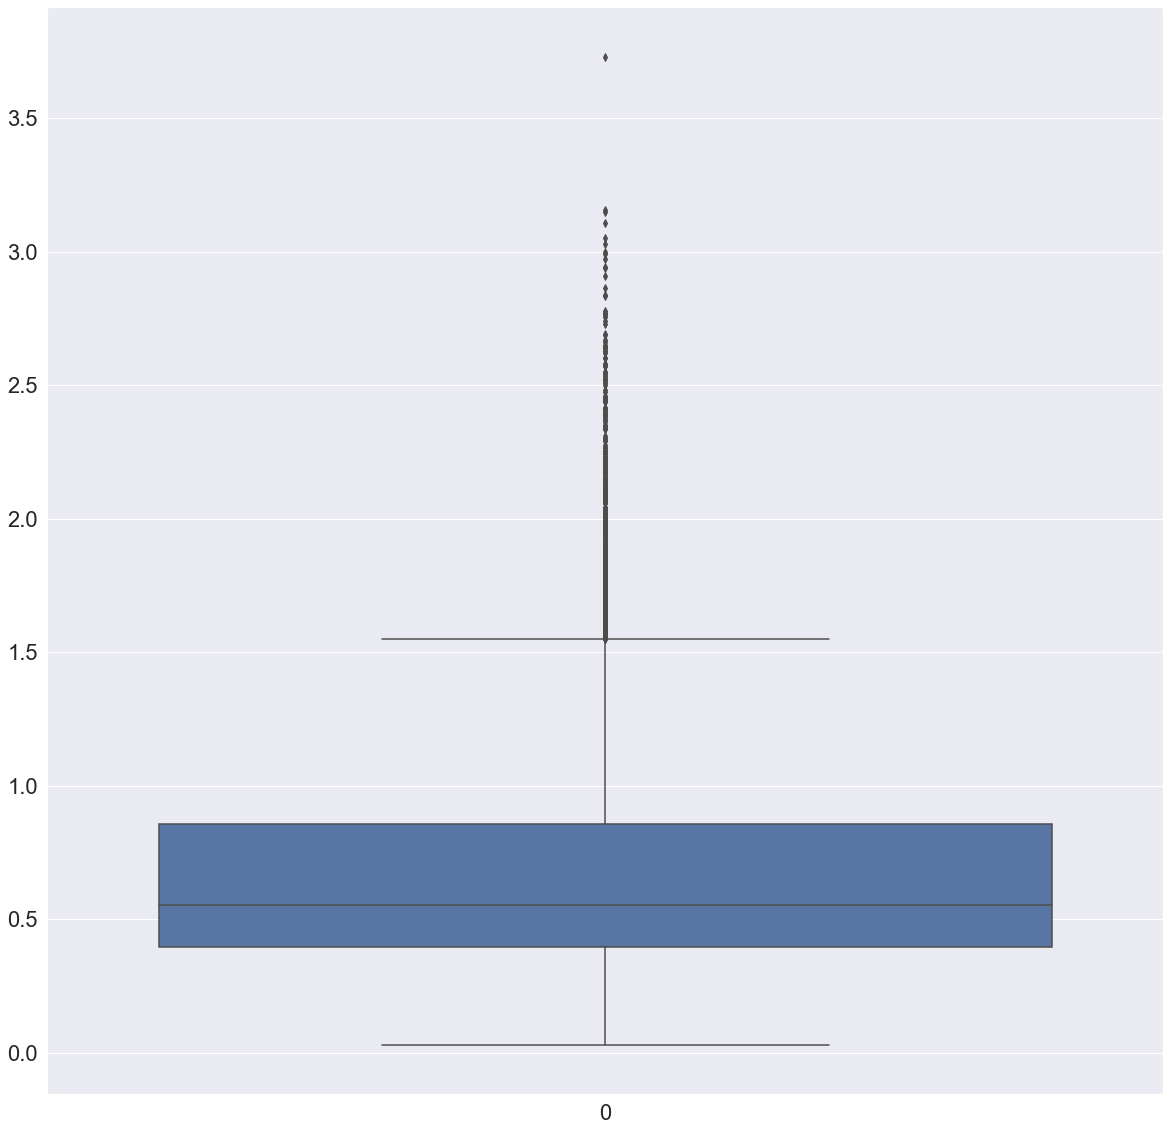

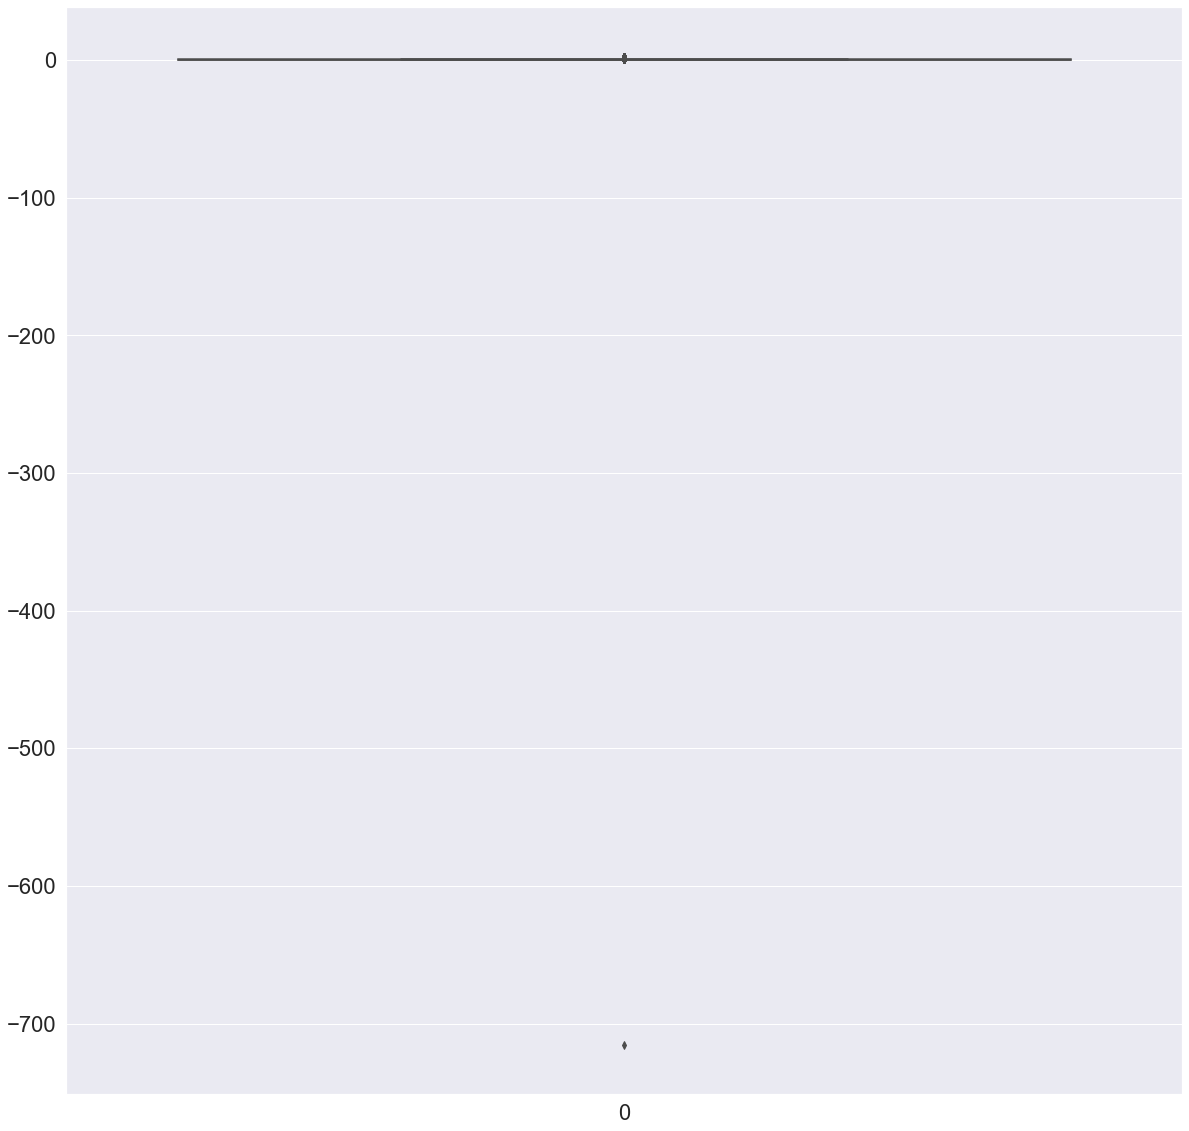

In [9]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.boxplot(data=data_arc['Активная мощность'])
plt.show()

plt.figure(figsize=(20,20))
sns.boxplot(data=data_arc['Реактивная мощность'])
plt.show()

In [10]:
data_arc.loc[data_arc['Реактивная мощность'] < -1]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   

      Реактивная мощность  
9780          -715.504924

In [11]:
data_arc.loc[data_arc['key'] == 2116]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-24 00:29:52  2019-07-24 00:31:54           0.433266   
9779  2116  2019-07-24 00:35:50  2019-07-24 00:38:05           0.620265   
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   
9781  2116  2019-07-24 00:51:51  2019-07-24 00:52:58           0.299368   

      Реактивная мощность  
9778             0.306141  
9779             0.408352  
9780          -715.504924  
9781             0.198796

**Active power in the normal range, so as not to lose data, just zero the outlier**

In [12]:
data_arc.loc[(data_arc['key'] == 2116) & (data_arc['Реактивная мощность'] < -1), ['Реактивная мощность']] = 0

In [13]:
data_arc.loc[data_arc['key'] == 2116]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-24 00:29:52  2019-07-24 00:31:54           0.433266   
9779  2116  2019-07-24 00:35:50  2019-07-24 00:38:05           0.620265   
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   
9781  2116  2019-07-24 00:51:51  2019-07-24 00:52:58           0.299368   

      Реактивная мощность  
9778             0.306141  
9779             0.408352  
9780             0.000000  
9781             0.198796

<div style="background: #ADD8E6">
Delete the entire batch

In [2]:
index = data_arc.loc[data_arc['Реактивная мощность'] < -1].index
data_arc = data_arc.drop(index).reset_index(drop=True)

<div style="background: #ADD8E6">
Removal of emissions `Gas 1`, `Power`. The `Bulk` and `Wire` outliers are best removed after they have matched with time signatures.

In [15]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
q1 = data_gas['Газ 1'].quantile(0.25)
q3 = data_gas['Газ 1'].quantile(0.75)
irq = q3 - q1
keys = list(data_gas.loc[(data_gas['Газ 1'] < (q1 - 1.5*irq)) | (data_gas['Газ 1'] > (q3 + 1.5*irq))]['key'].values)
data_gas = data_gas.query('key not in @keys')
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3113 entries, 1 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3113 non-null   int64  
 1   Газ 1   3113 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 73.0 KB


In [18]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [20]:
q1 = data_arc['Активная мощность'].quantile(0.25)
q3 = data_arc['Активная мощность'].quantile(0.75)
irq = q3 - q1
keys = list(data_arc.loc[(data_arc['Активная мощность'] < (q1 - 1.5*irq)) | (data_arc['Активная мощность'] > (q3 + 1.5*irq))]['key'].values)
data_arc = data_arc.query('key not in @keys')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12191 entries, 5 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   12191 non-null  int64  
 1   Начало нагрева дугой  12191 non-null  object 
 2   Конец нагрева дугой   12191 non-null  object 
 3   Активная мощность     12191 non-null  float64
 4   Реактивная мощность   12191 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 571.5+ KB


## Fill in missing values

**Replace missing `Bulk` and `Wire` values with zeros**

In [21]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

## Reduction of features to the format

**Let's bring all the signs to the appropriate format**

In [22]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12191 entries, 5 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   12191 non-null  int64         
 1   Начало нагрева дугой  12191 non-null  datetime64[ns]
 2   Конец нагрева дугой   12191 non-null  datetime64[ns]
 3   Активная мощность     12191 non-null  float64       
 4   Реактивная мощность   12191 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 571.5 KB


In [23]:
for i in range(1,16):
    column = 'Bulk ' + str(i)
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], format='%Y-%m-%dT%H:%M:%S')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [24]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [25]:
for i in range(1,10):
    column = 'Wire ' + str(i)
    data_wire_time[column] = pd.to_datetime(data_wire_time[column], format='%Y-%m-%dT%H:%M:%S')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


## Checking temporal features for outliers

**Check the time series of datasets for outliers**

**`Bulk`**

Bulk 1


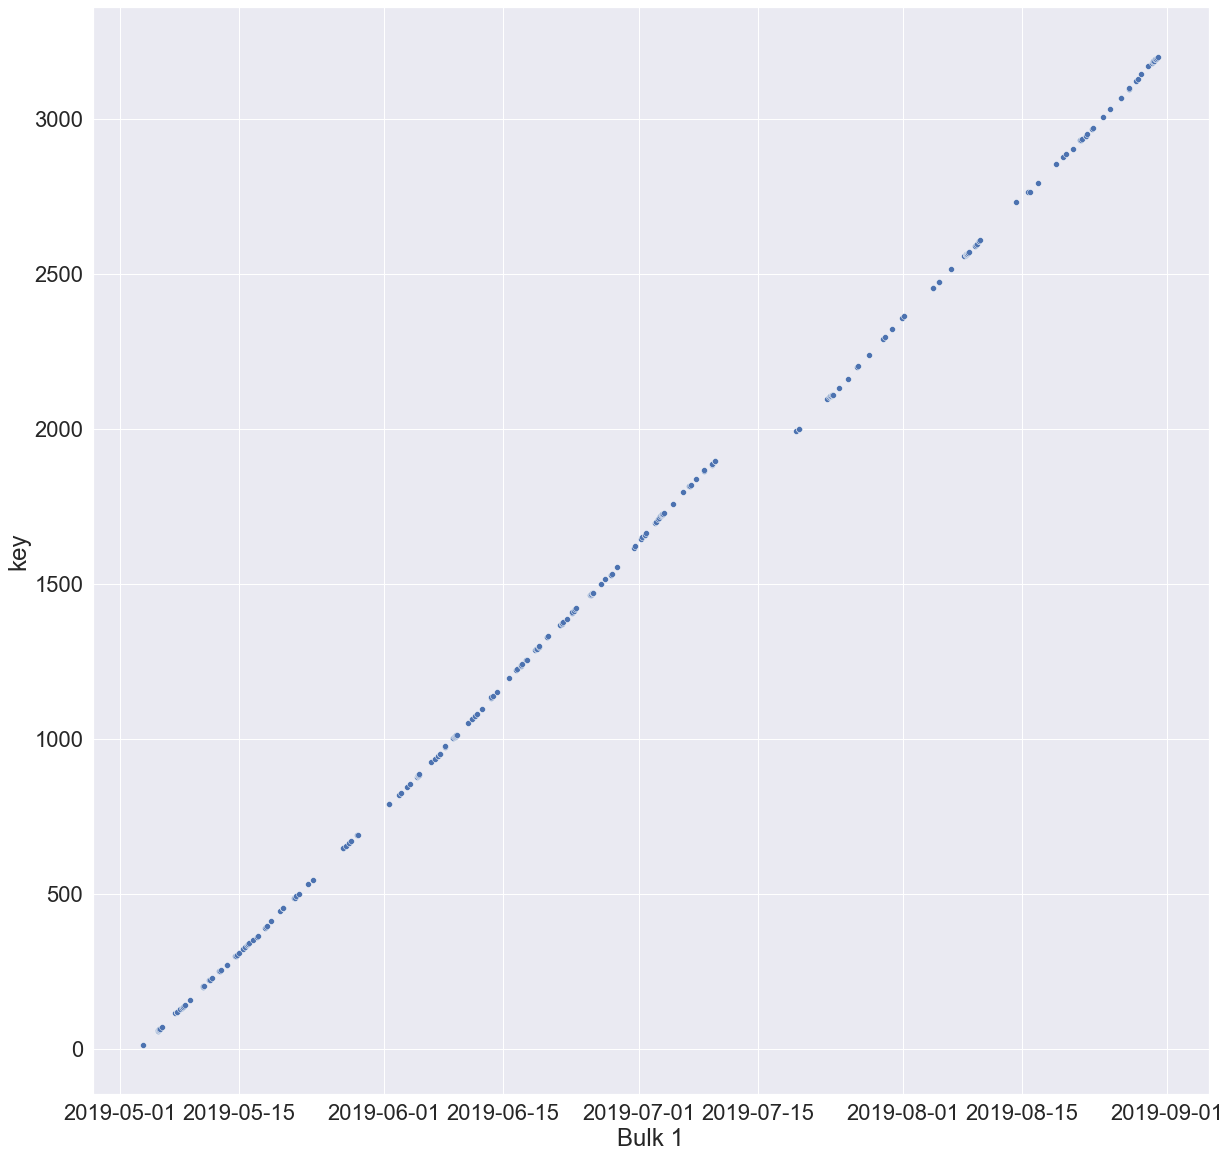

Bulk 2


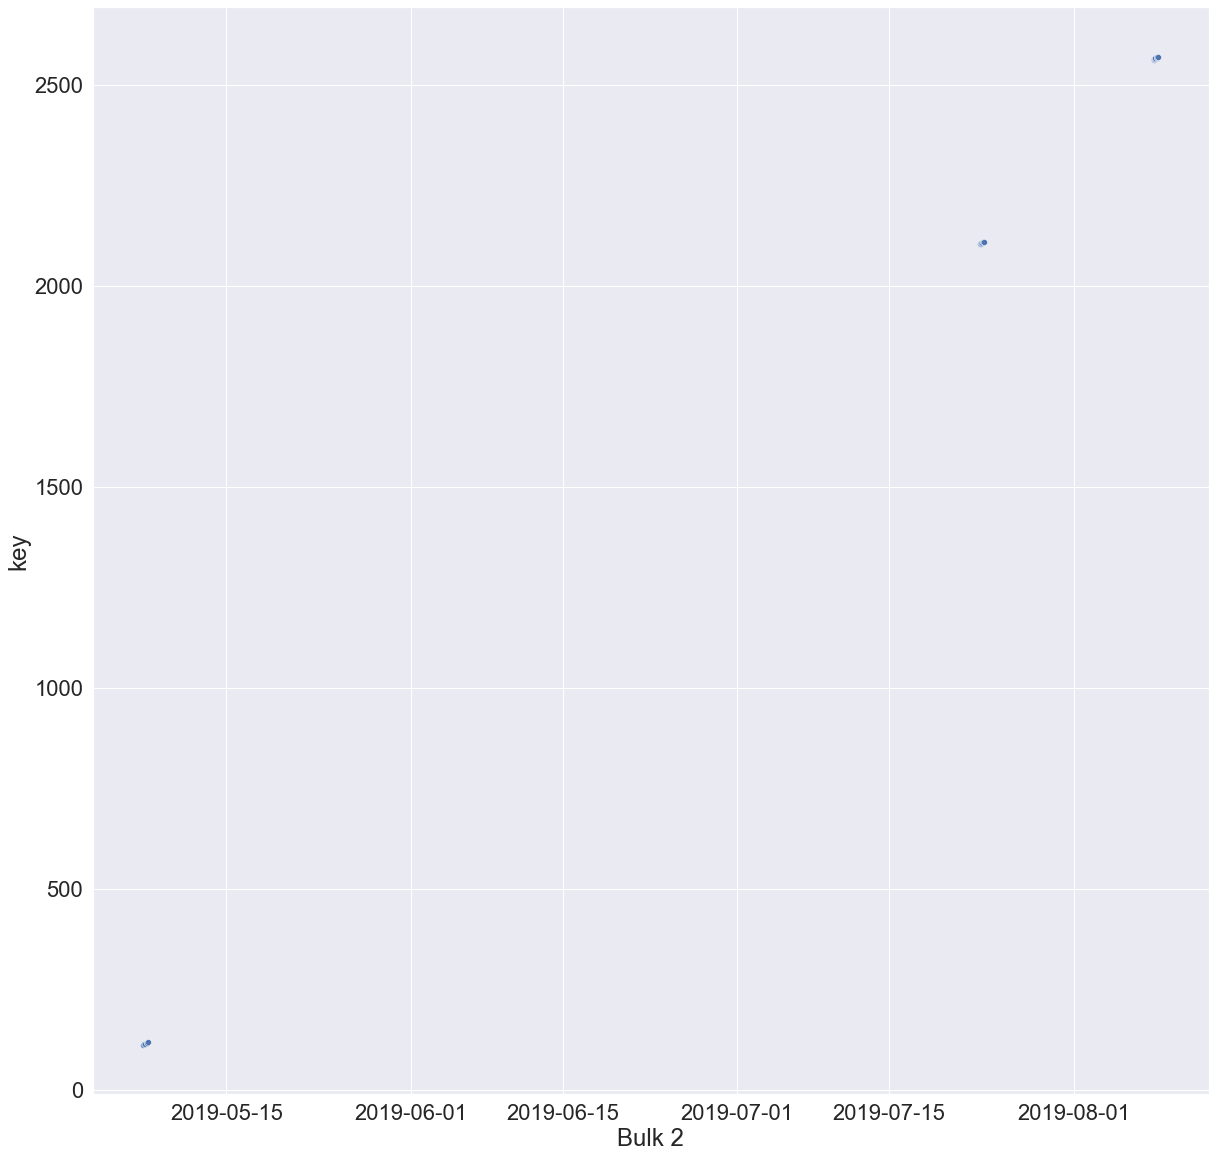

Bulk 3


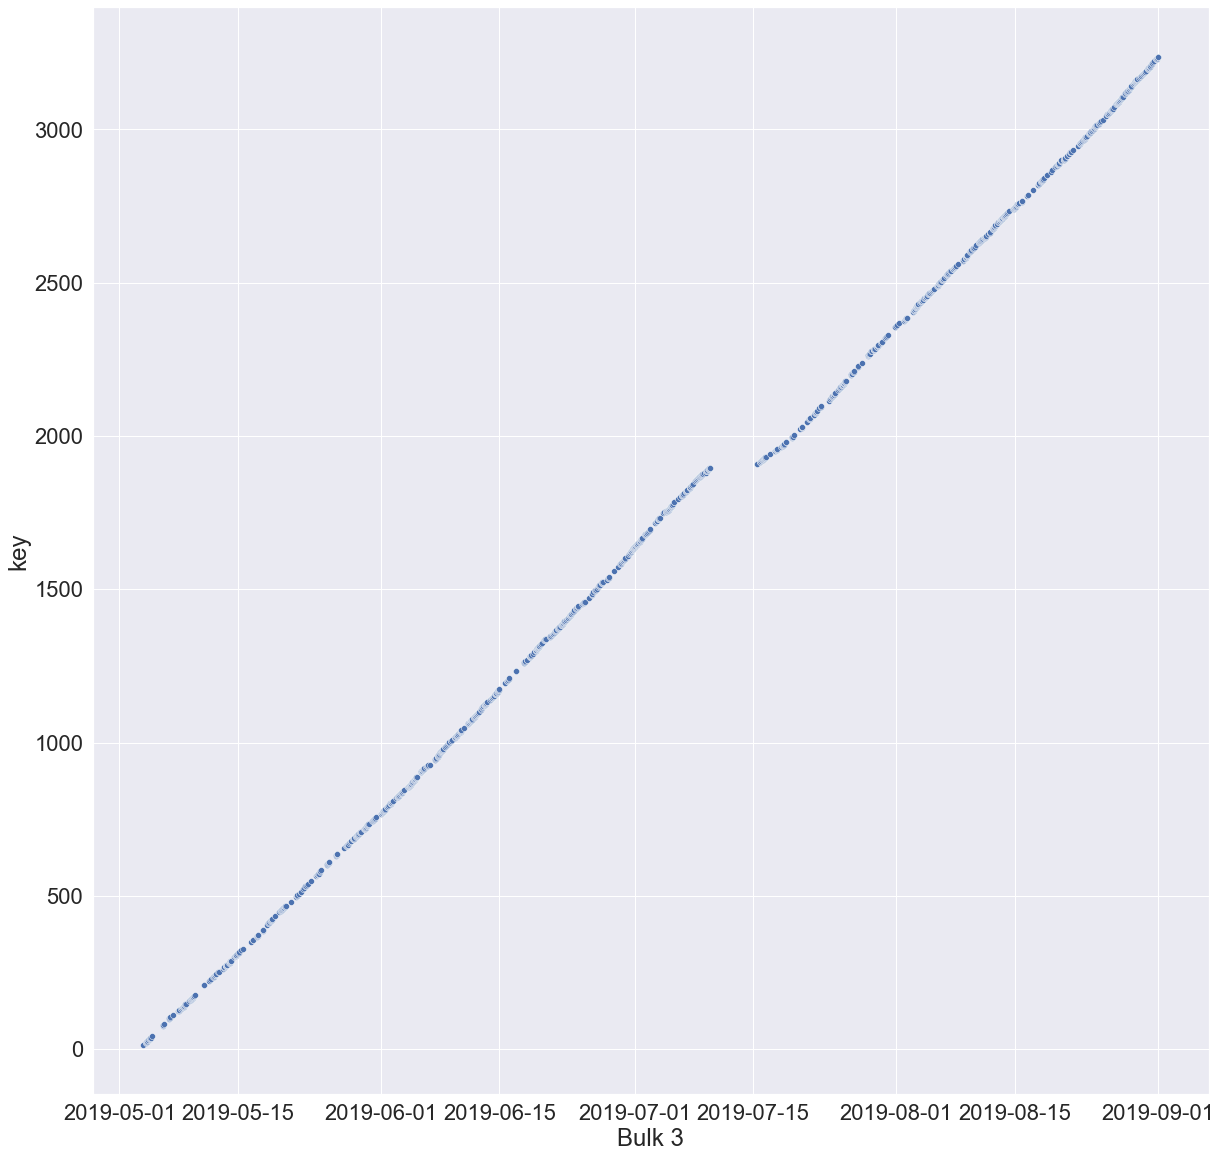

Bulk 4


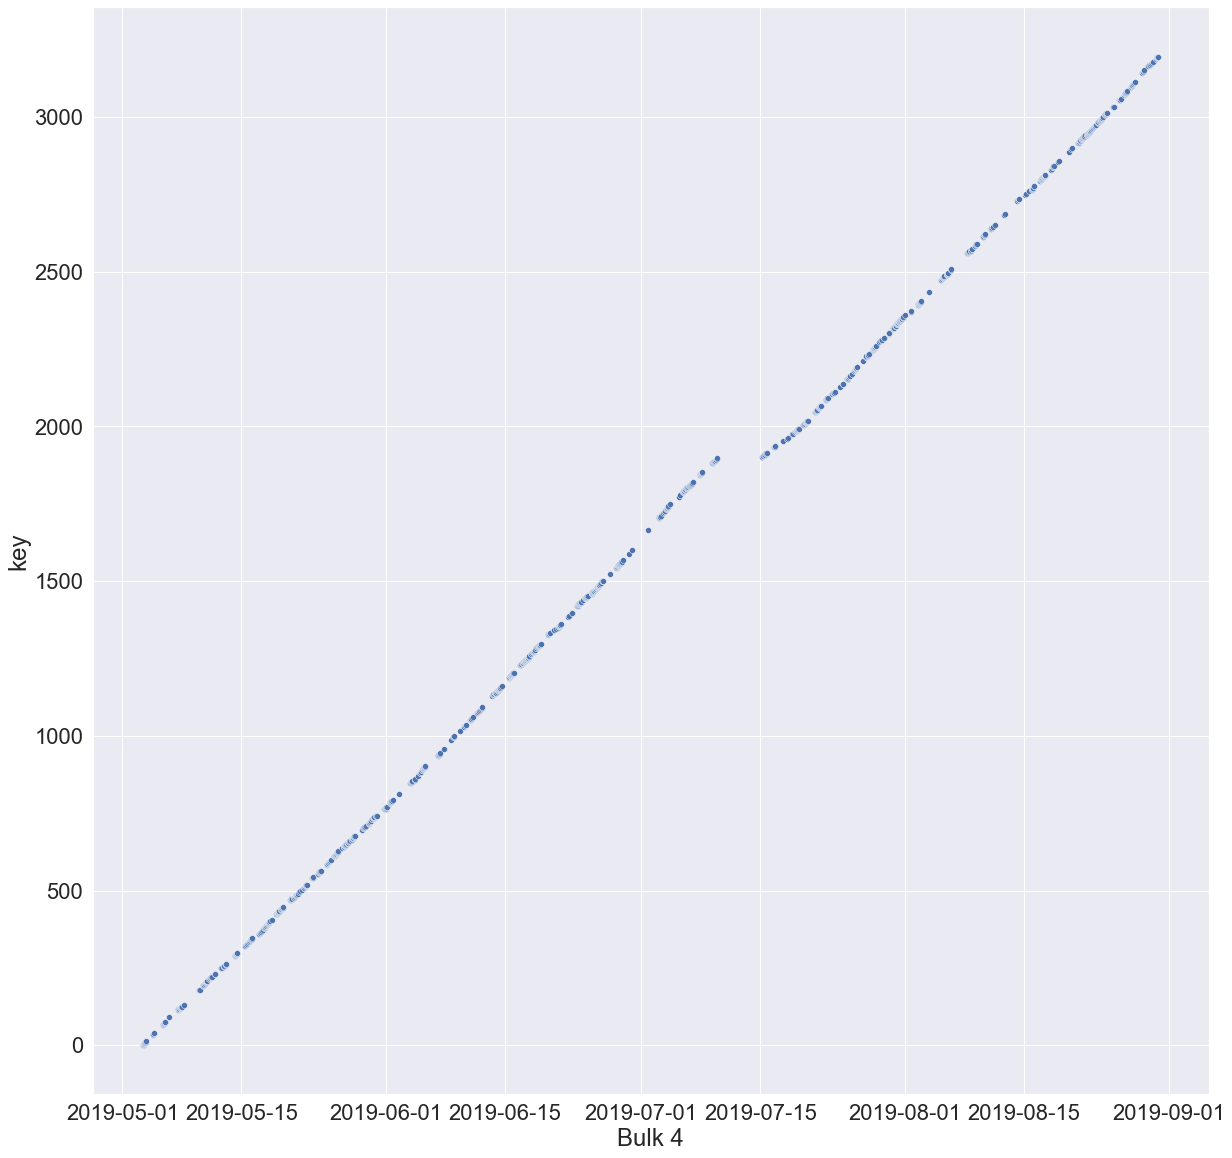

Bulk 5


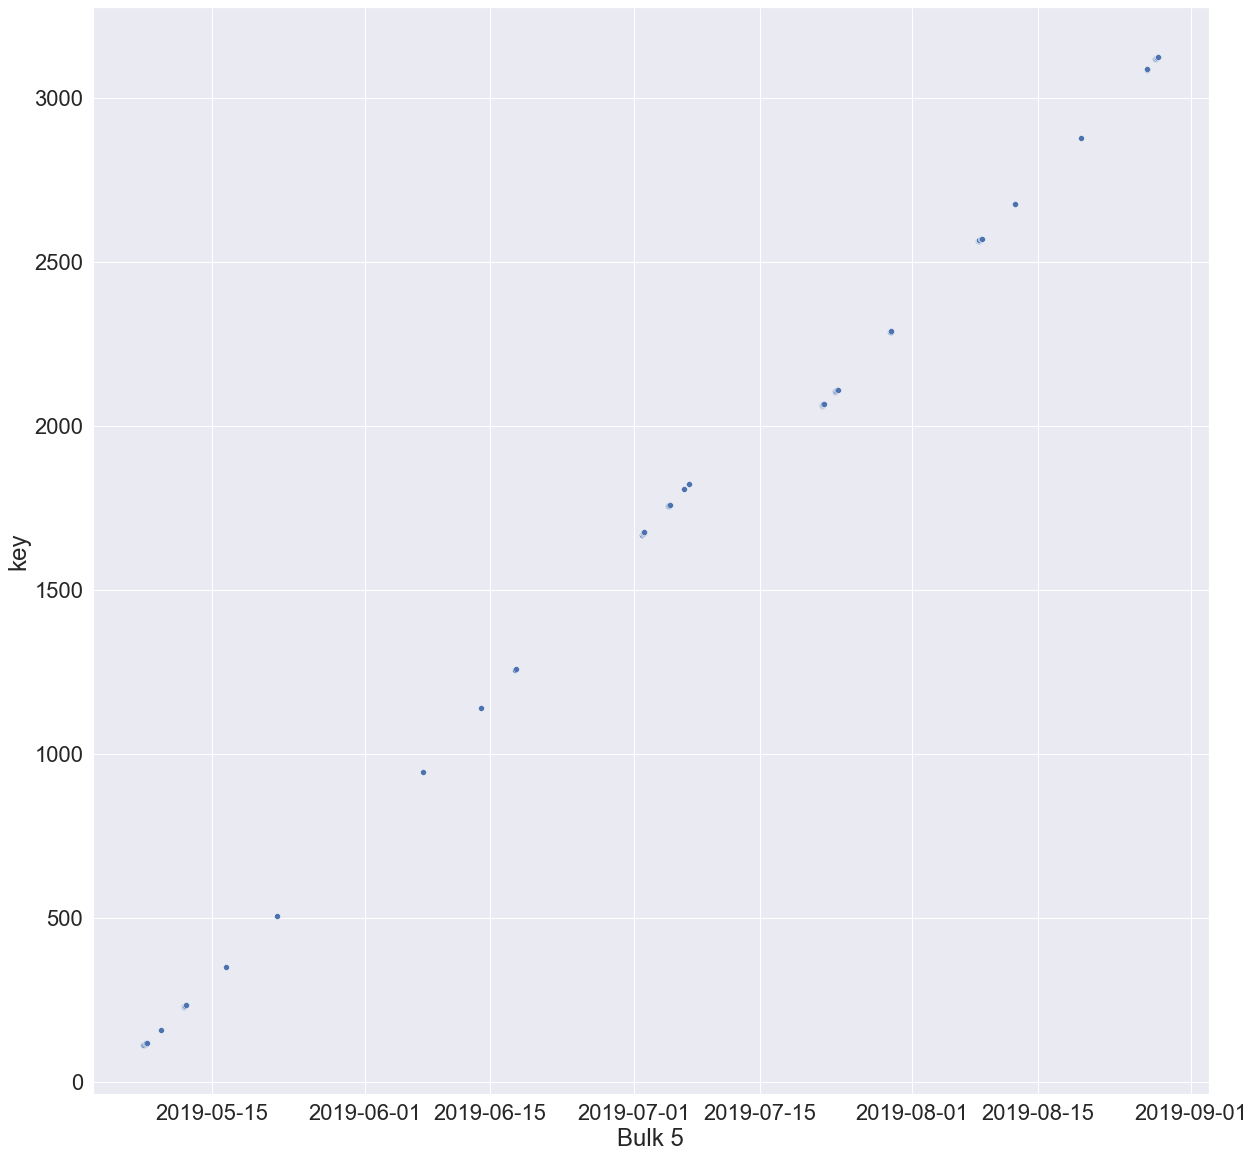

Bulk 6


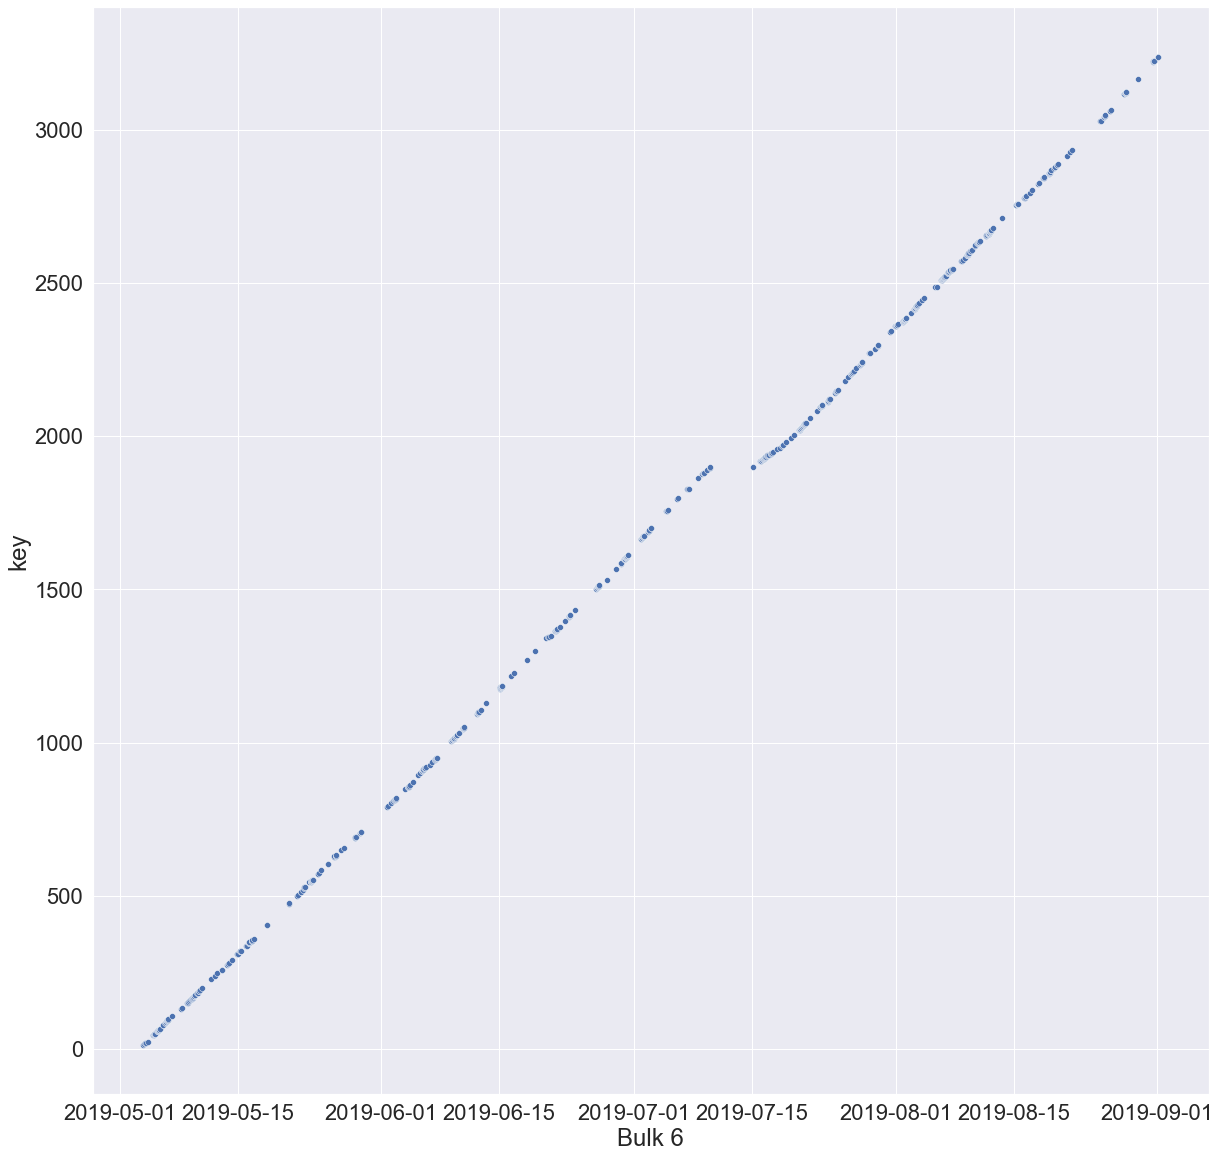

Bulk 7


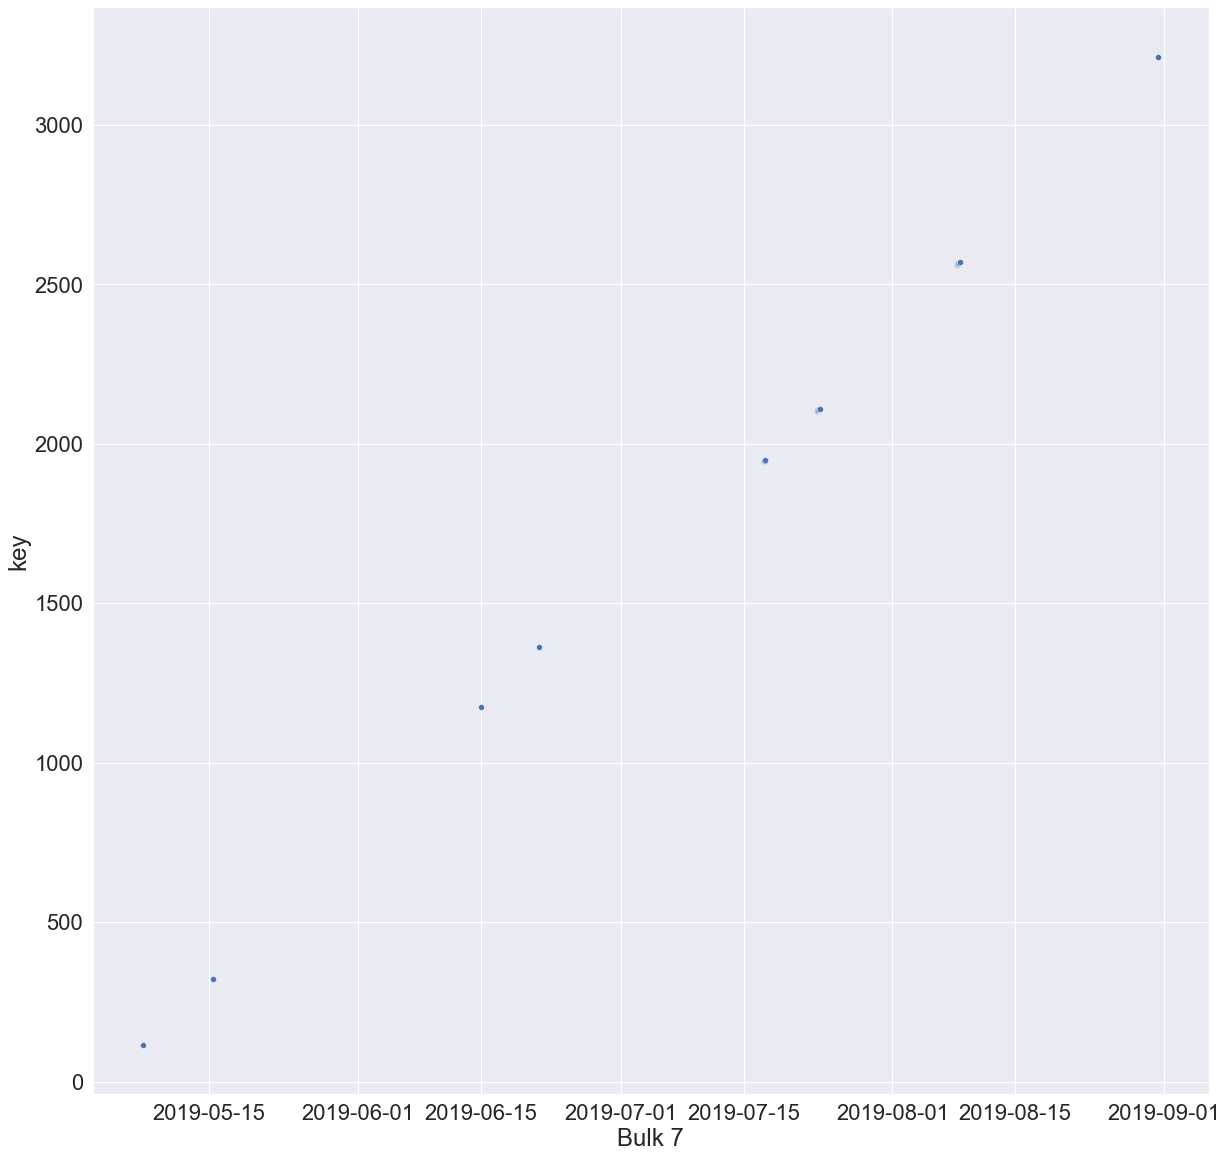

Bulk 8


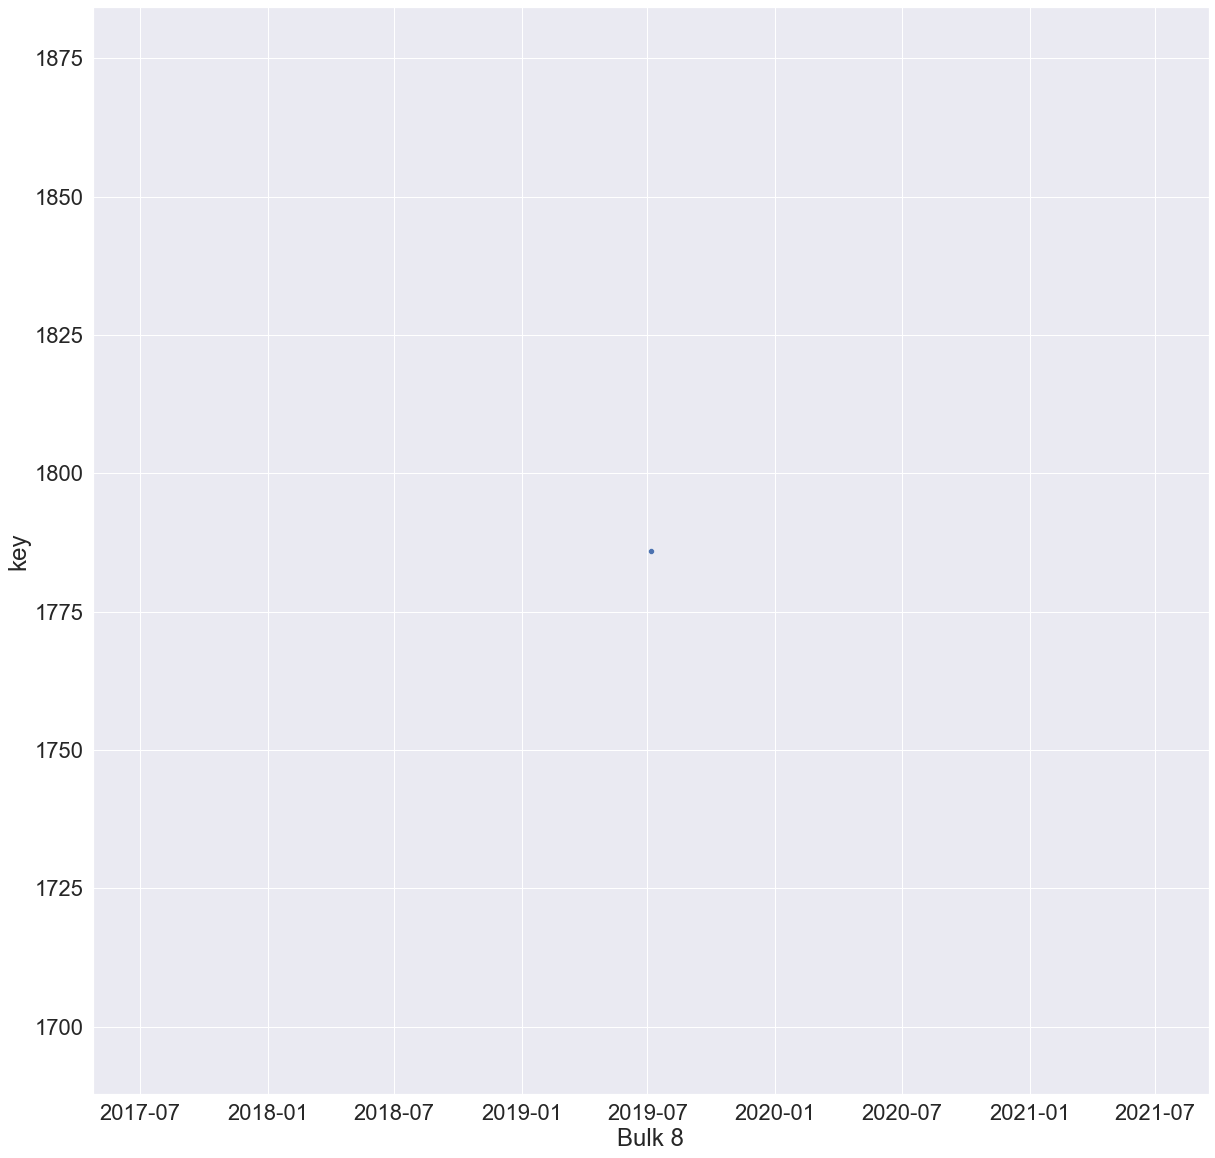

Bulk 9


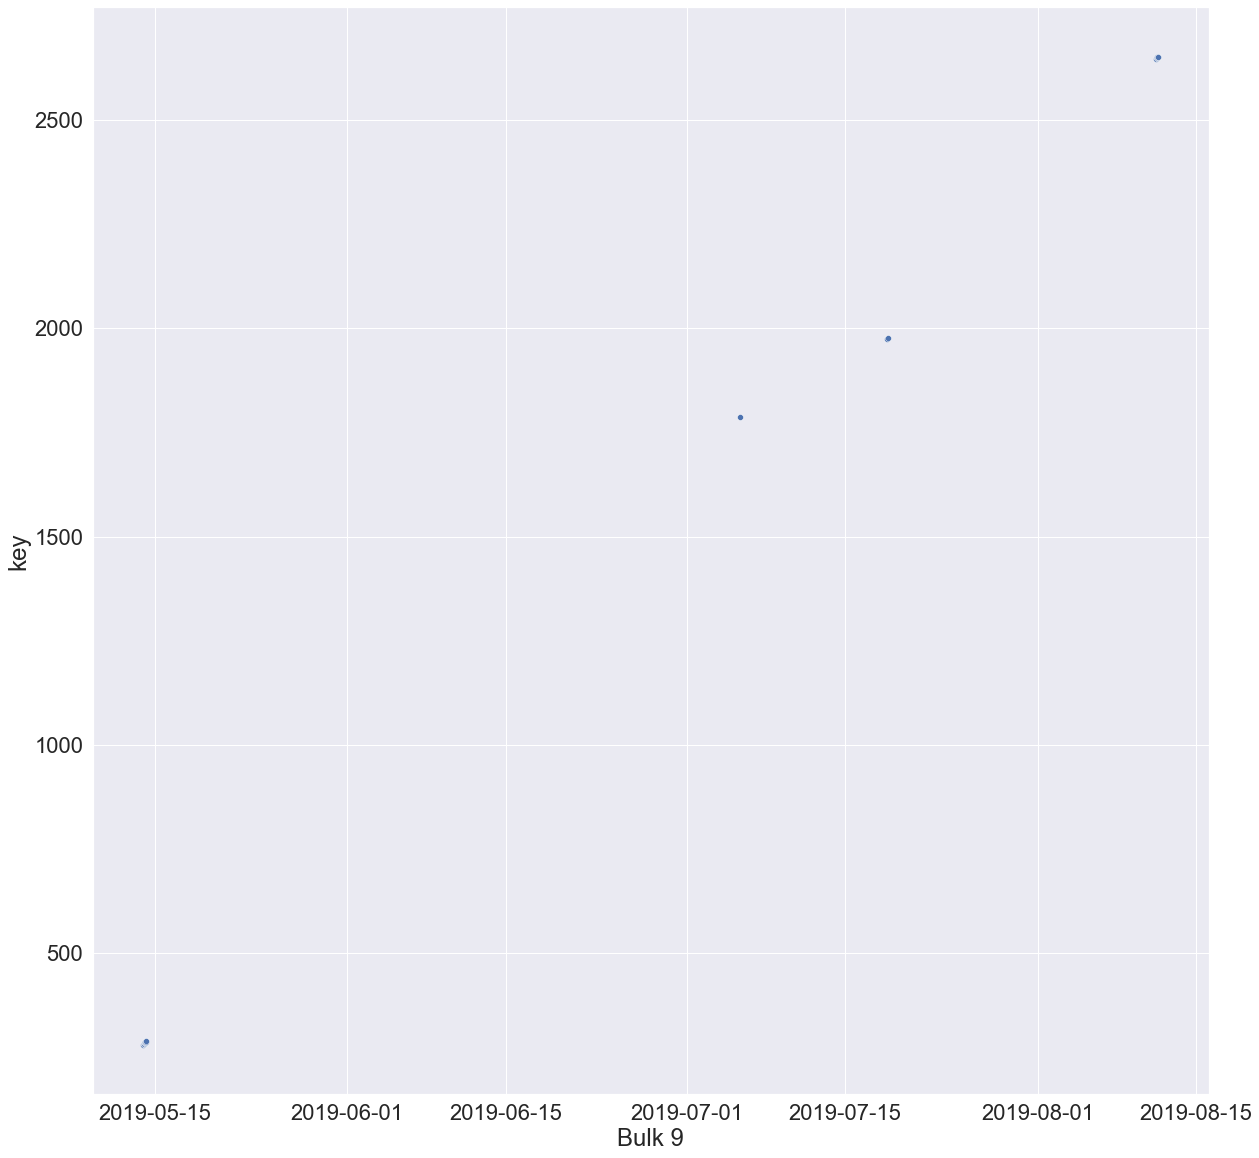

Bulk 10


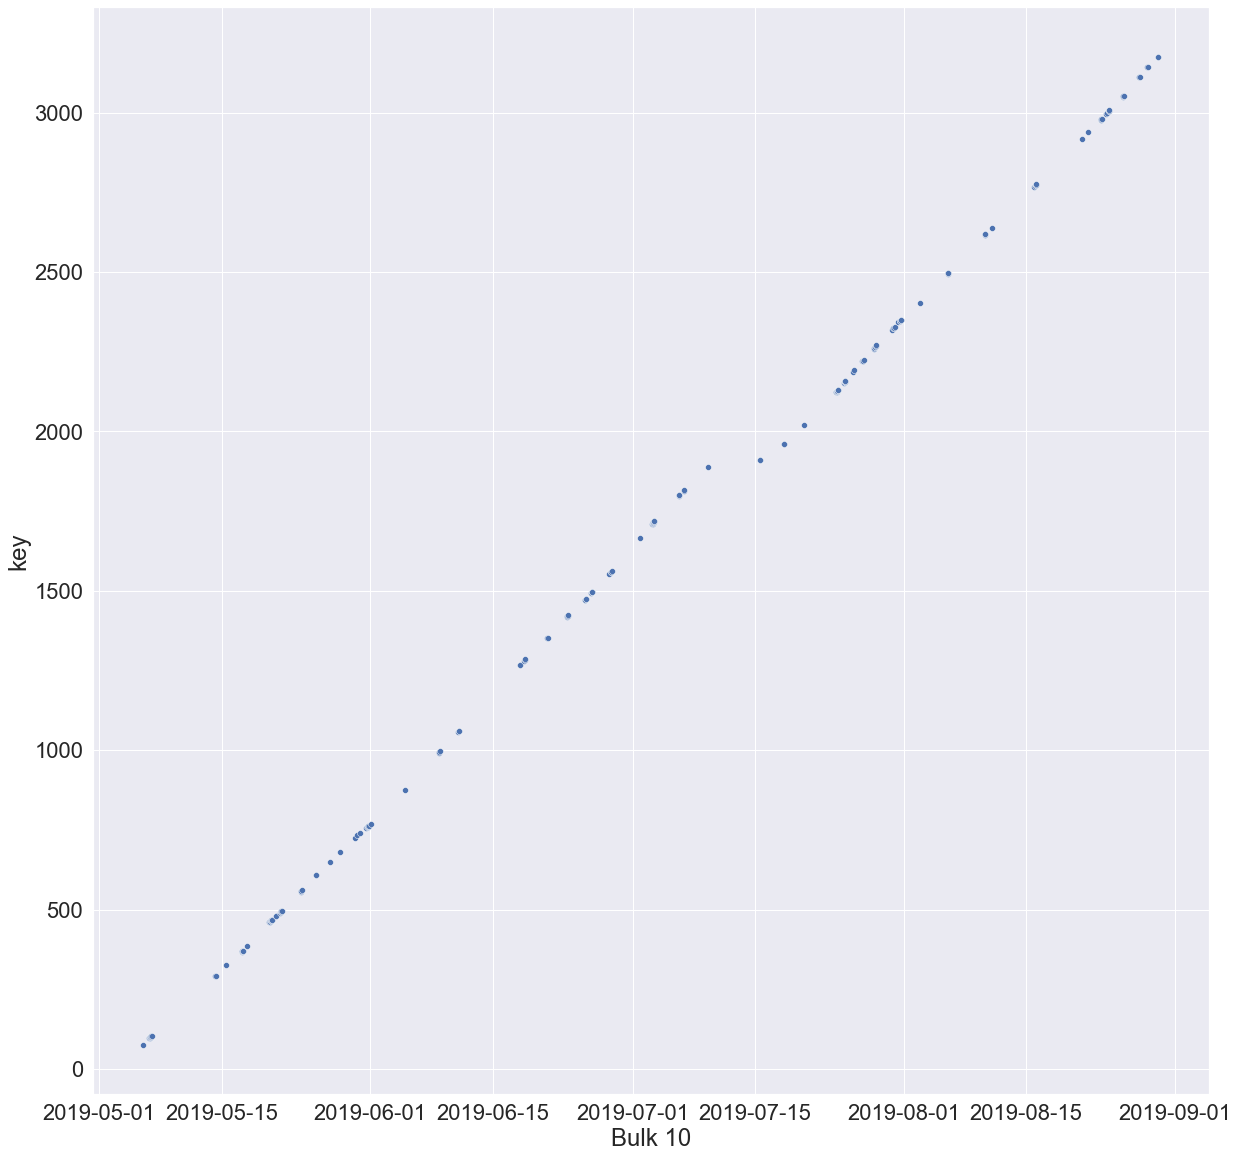

Bulk 11


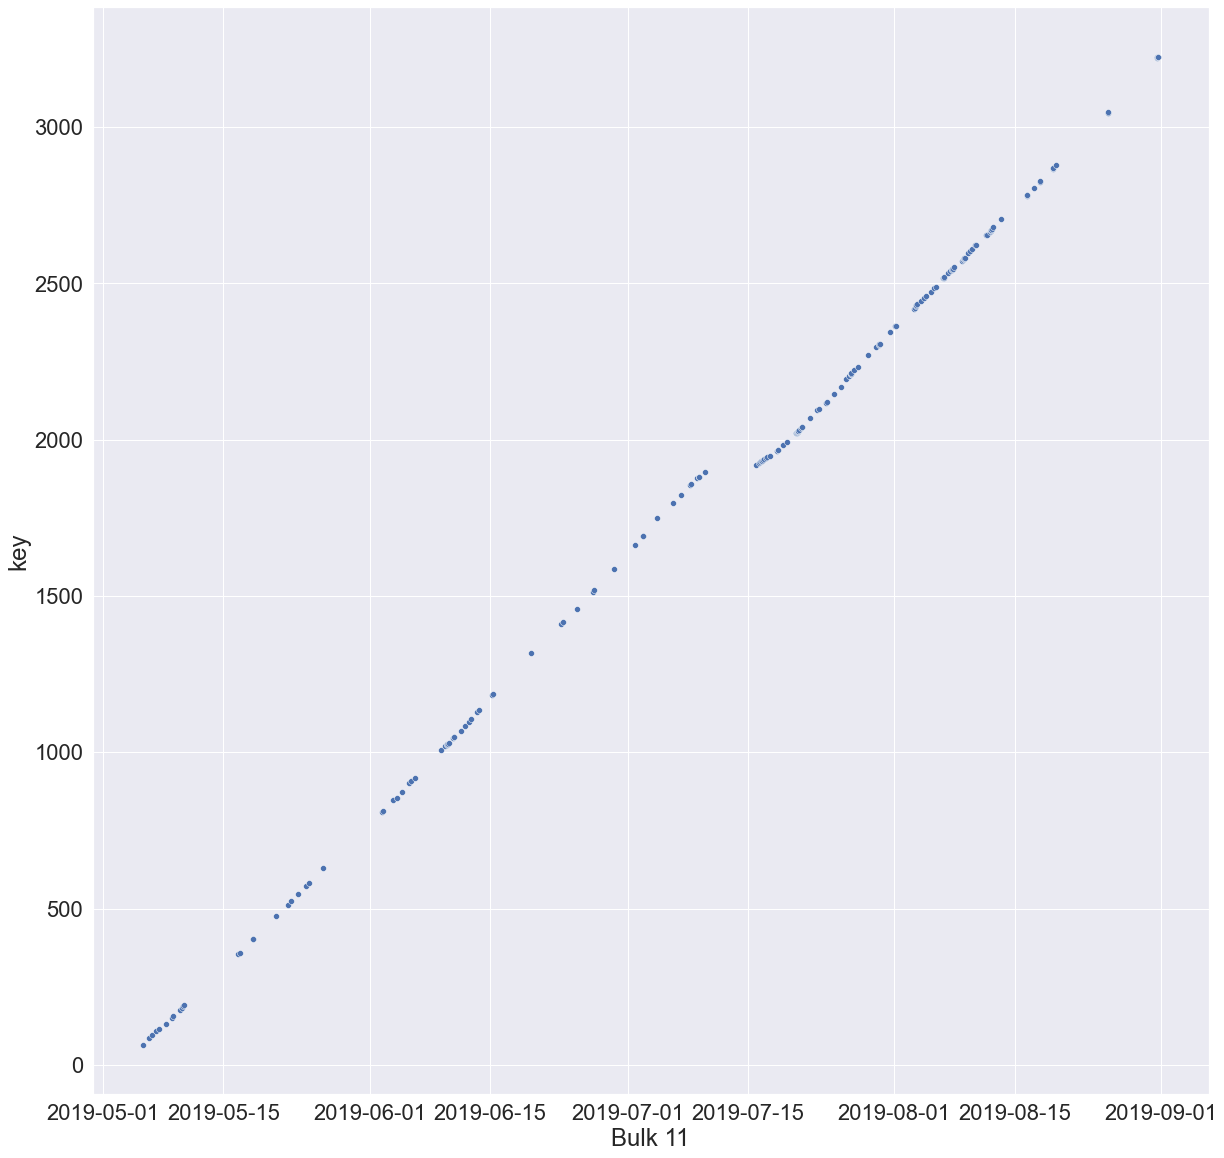

Bulk 12


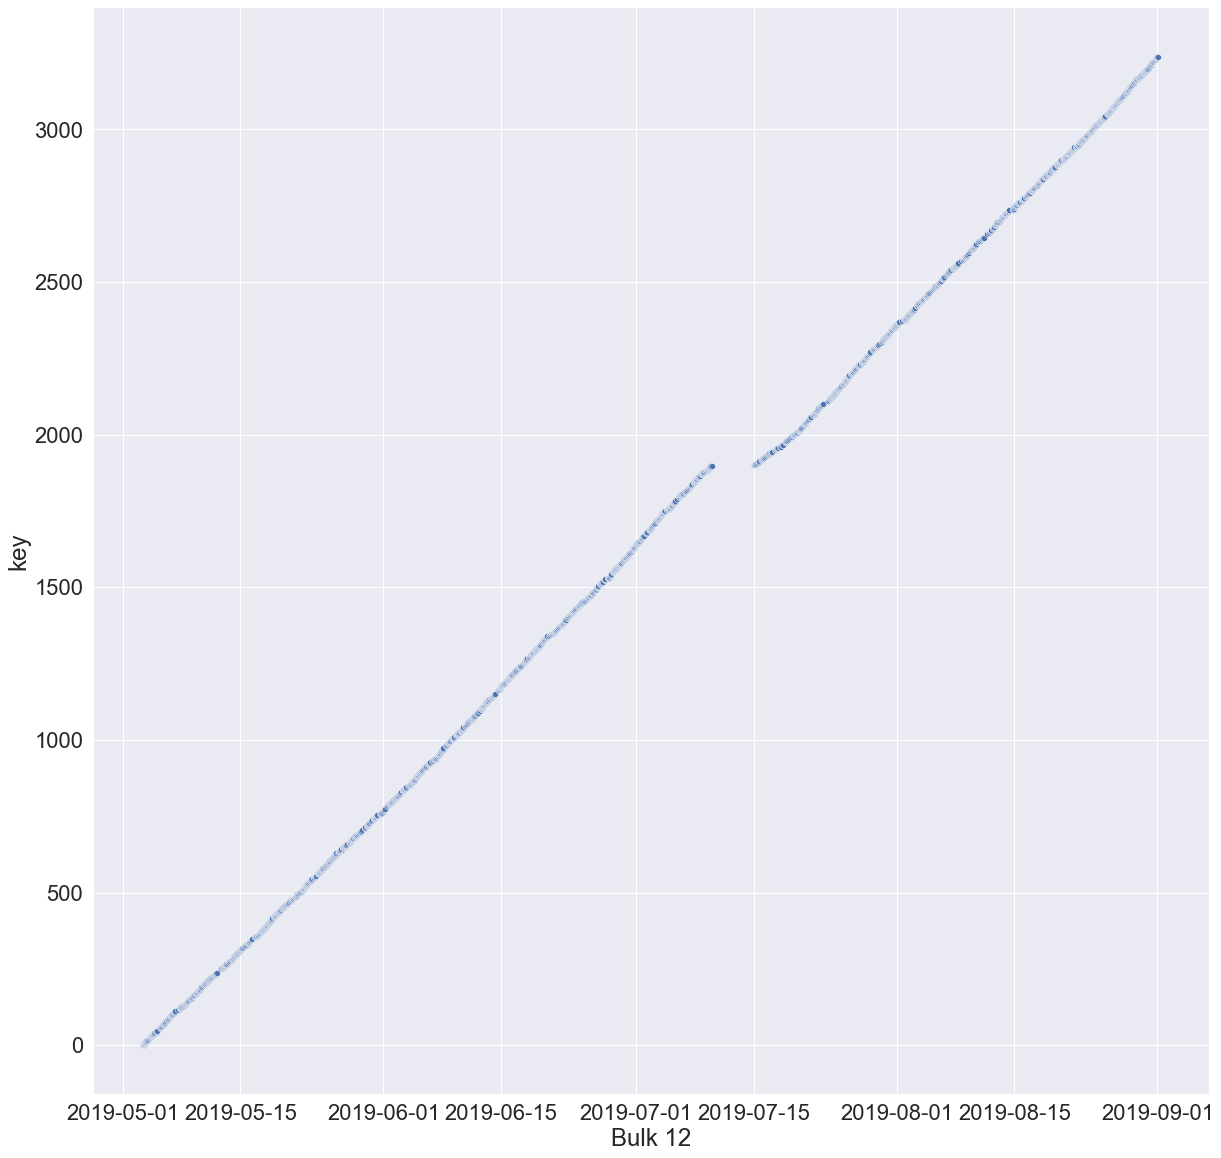

Bulk 13


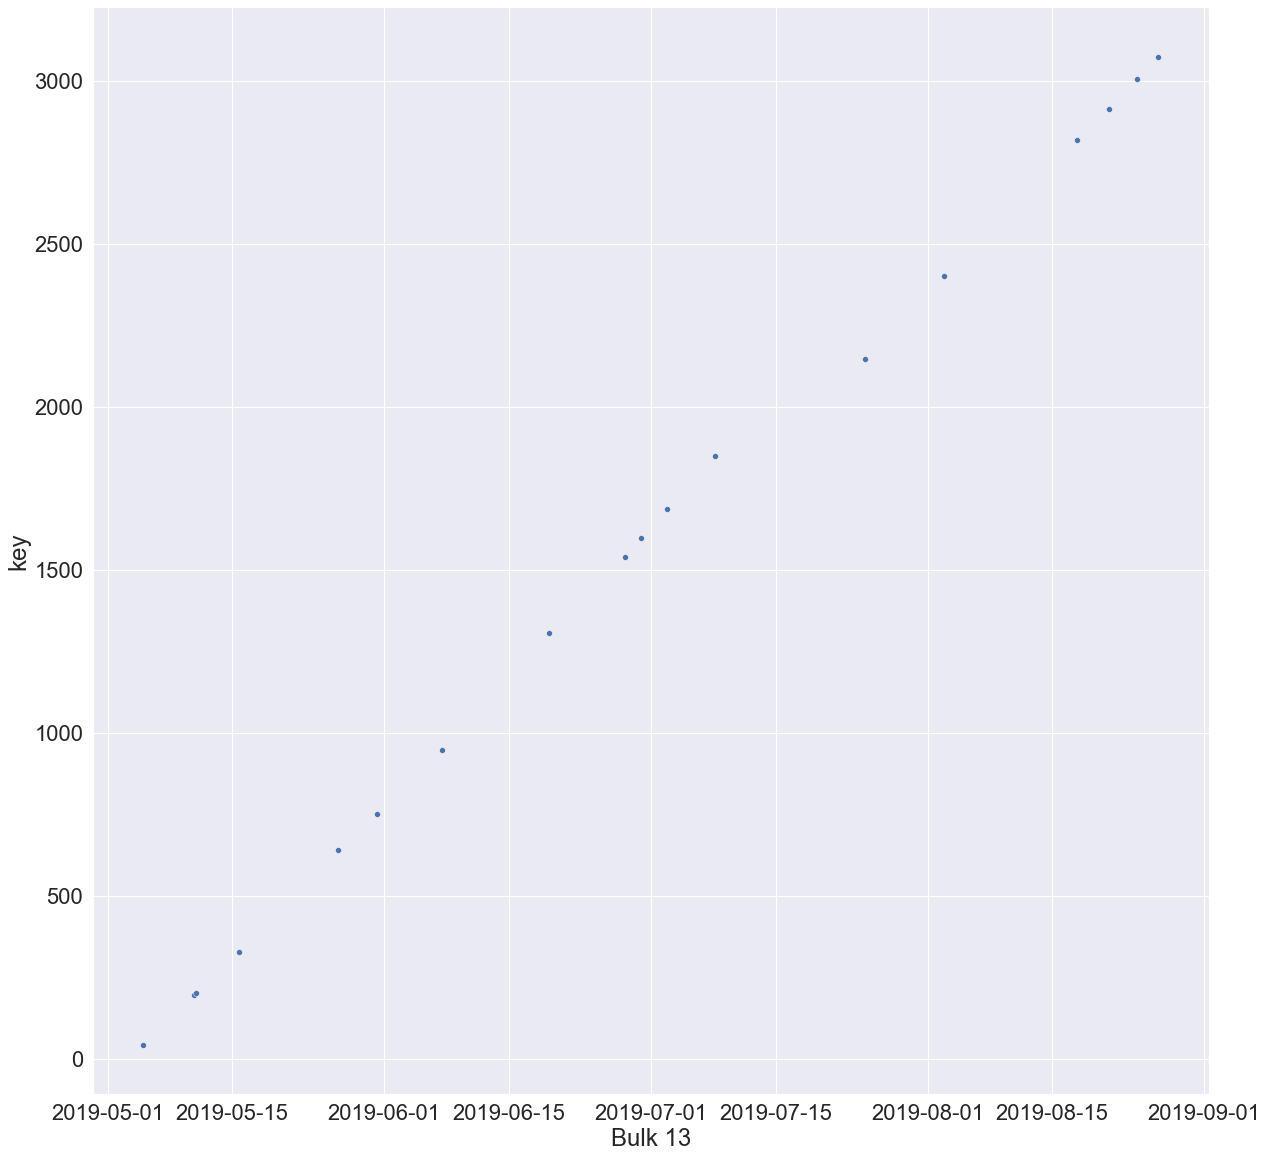

Bulk 14


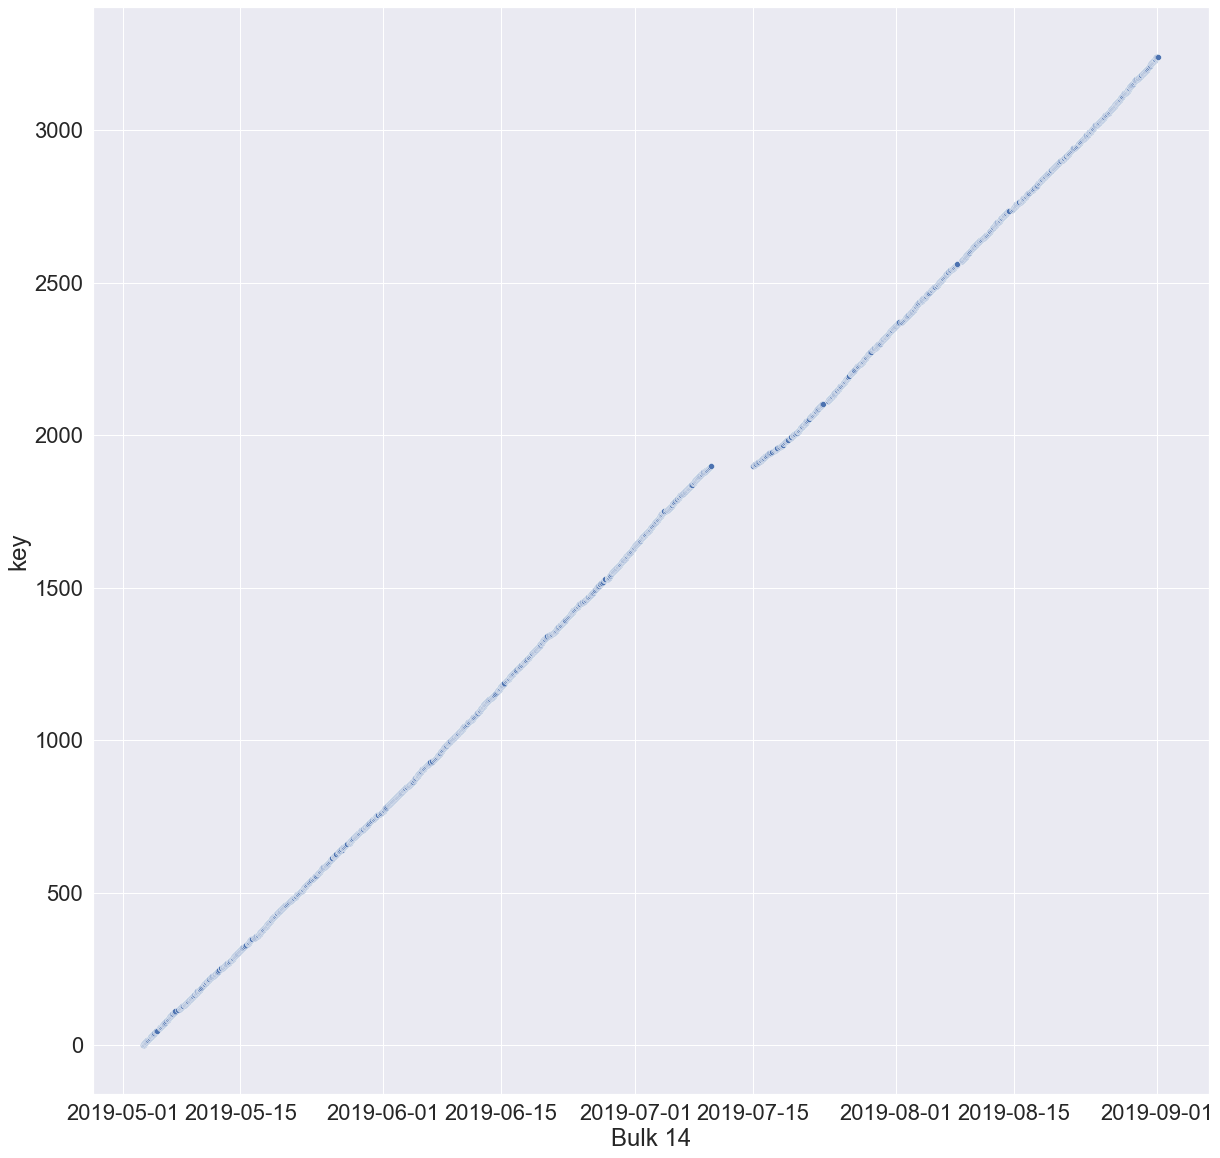

Bulk 15


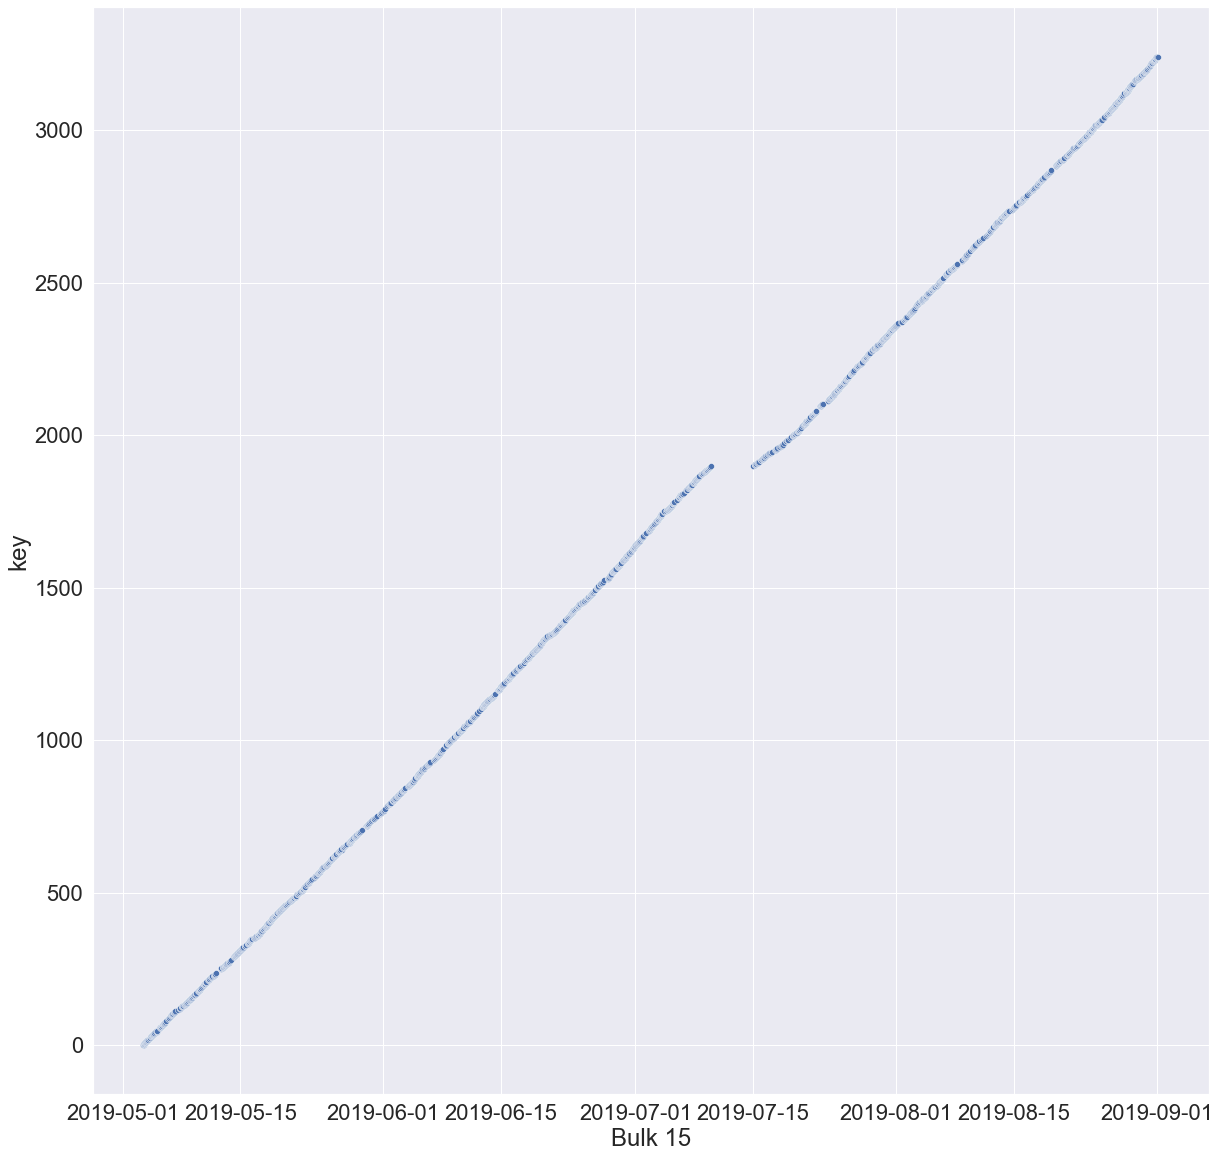

In [26]:
sns.set(font_scale=2)

for i in range(1,16):
    column = 'Bulk ' + str(i)
    print(column)
    plt.figure(figsize=(20,20))
    sns.scatterplot(x = data_bulk_time[column], y=data_bulk_time['key'])
    plt.show()

**`Wire`**

Wire 1


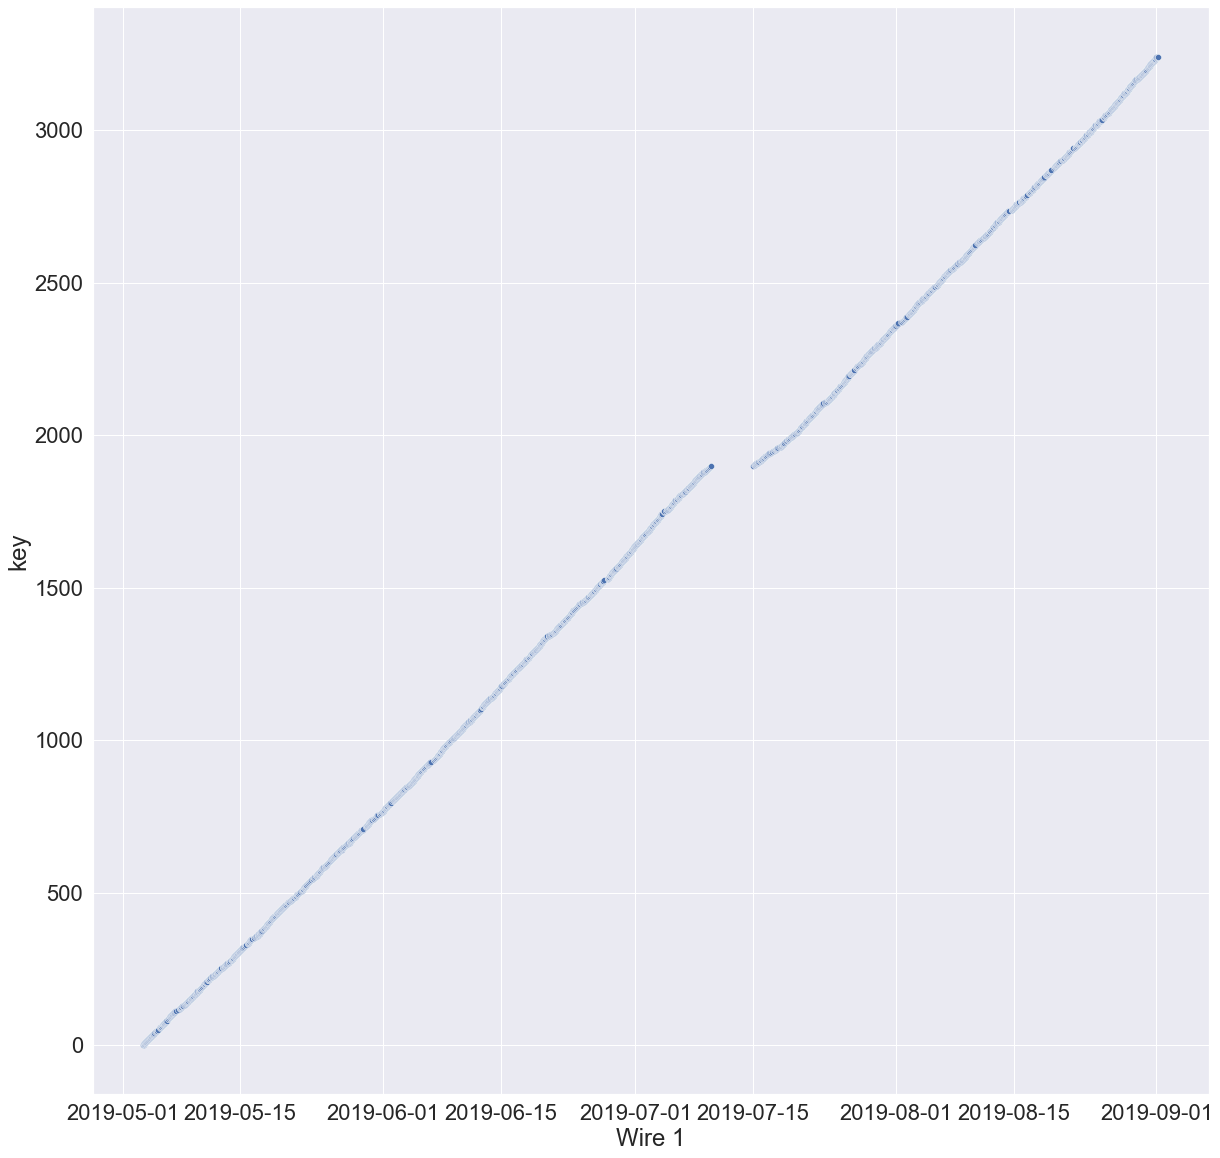

Wire 2


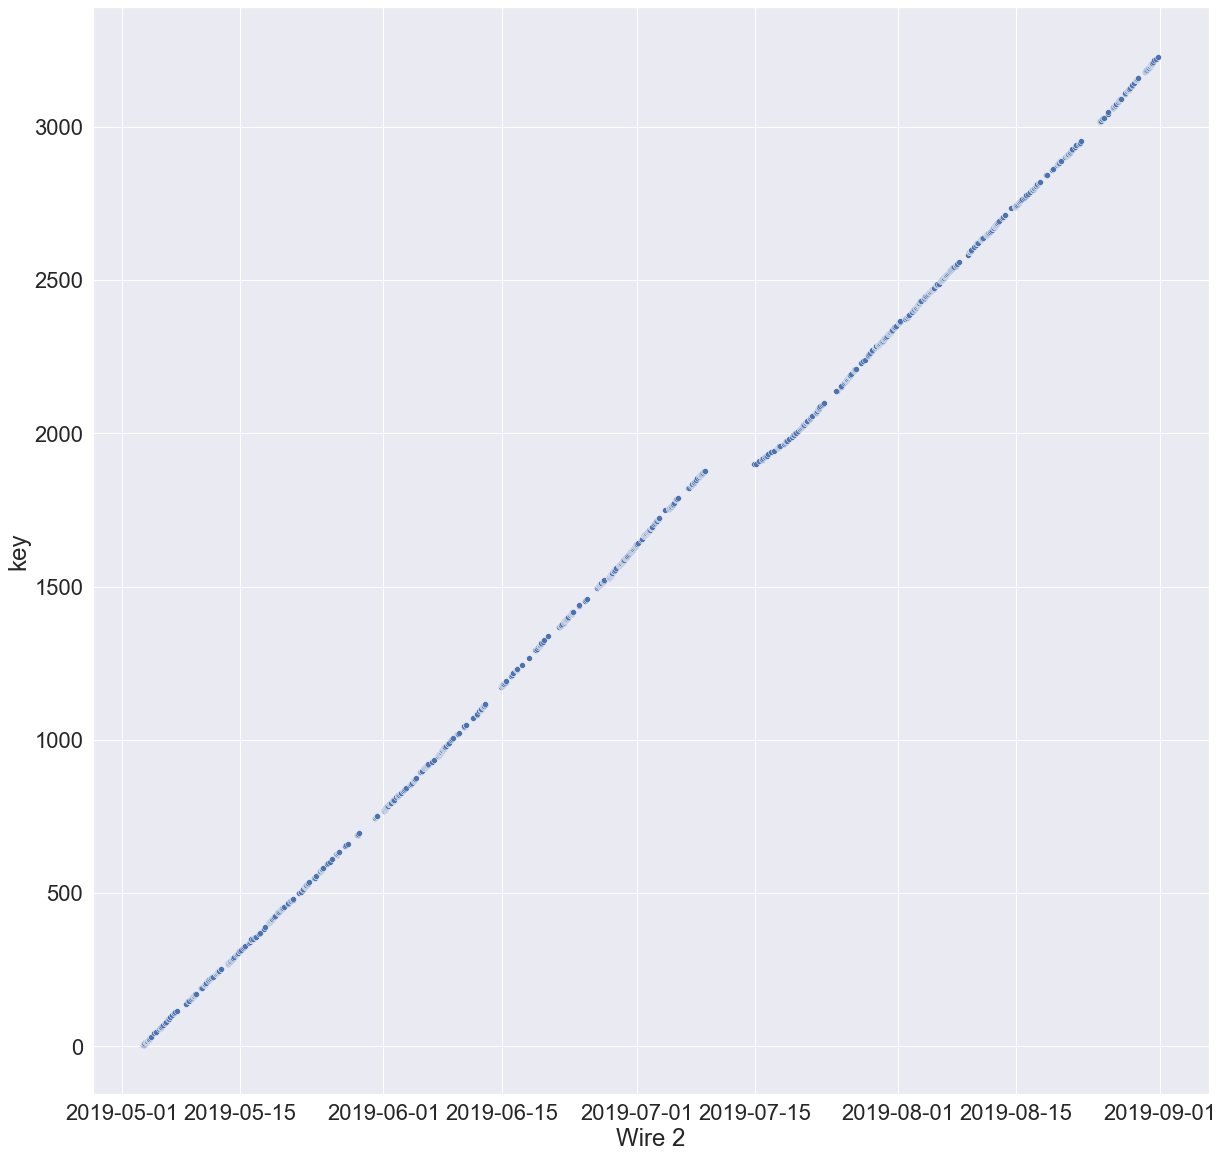

Wire 3


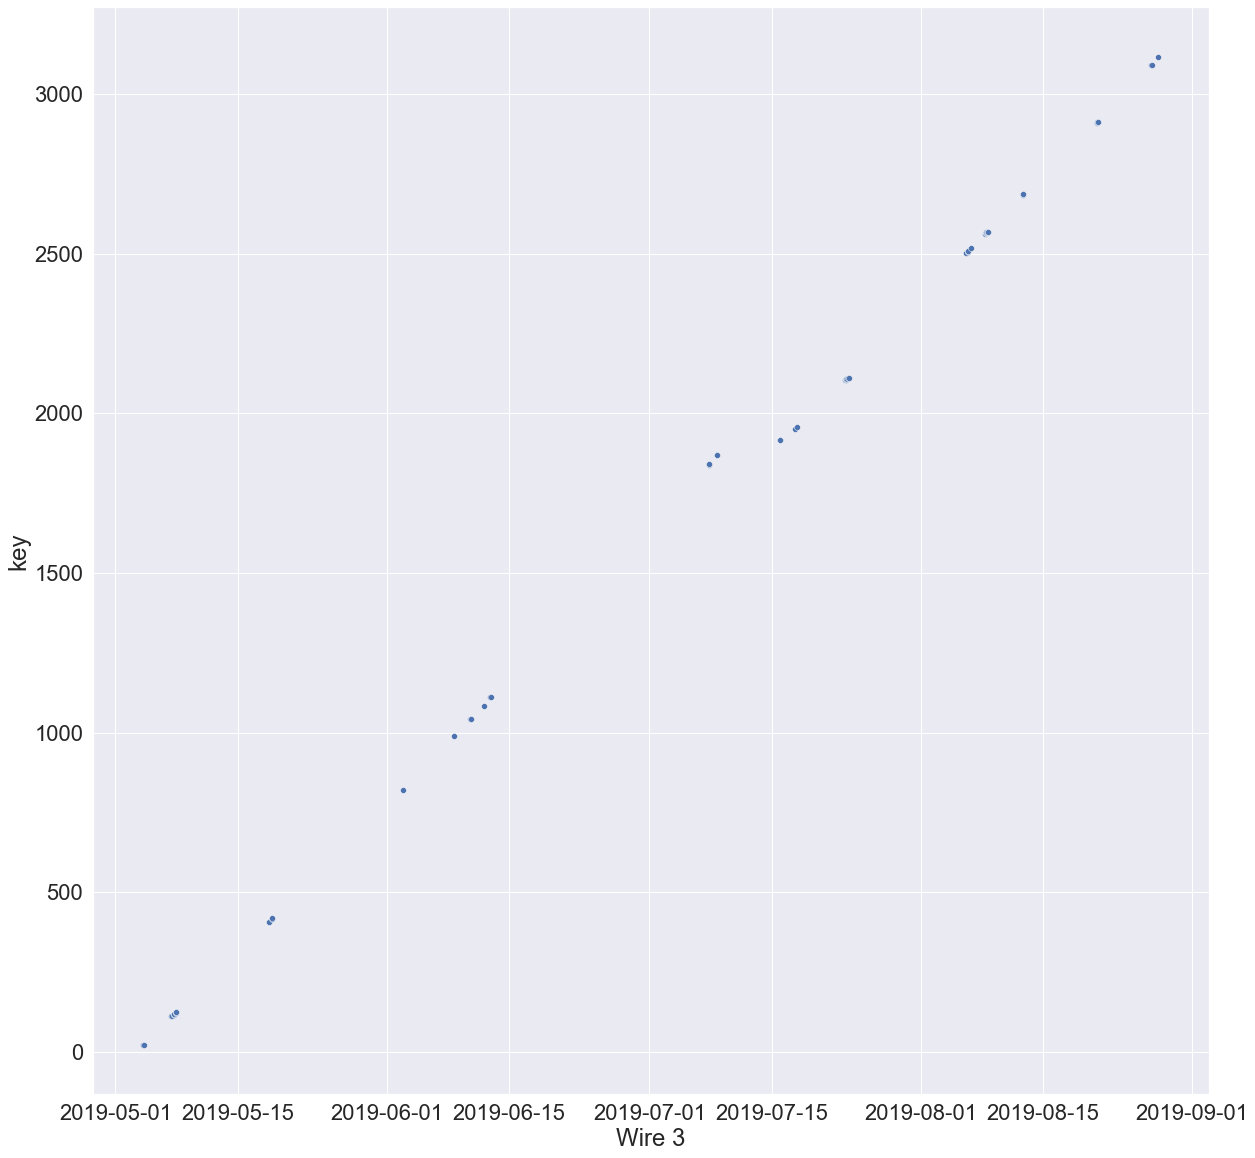

Wire 4


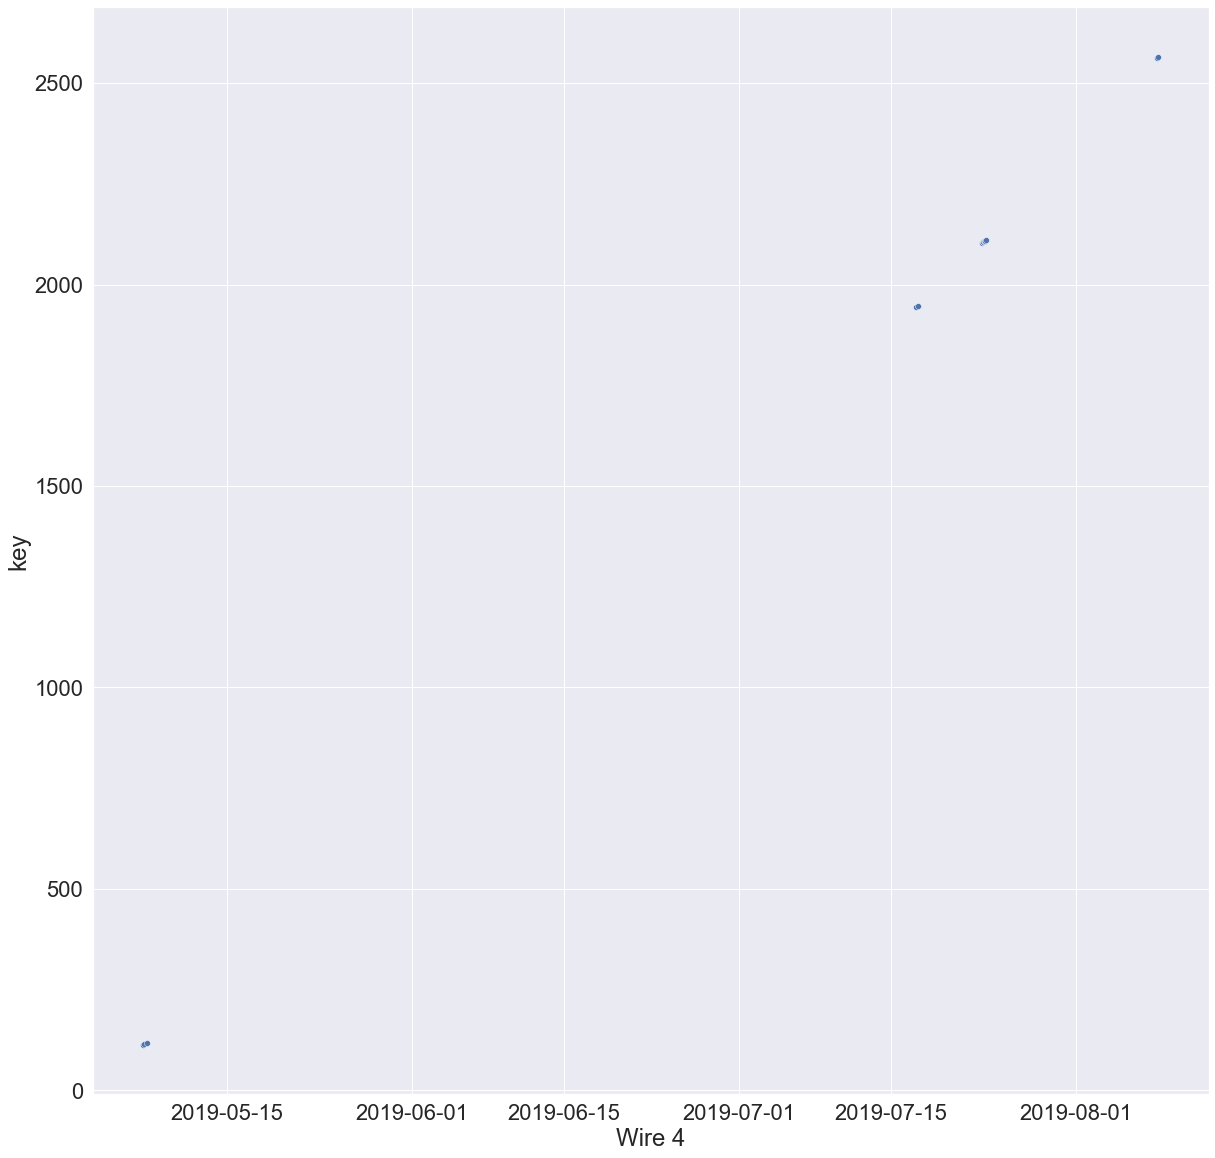

Wire 5


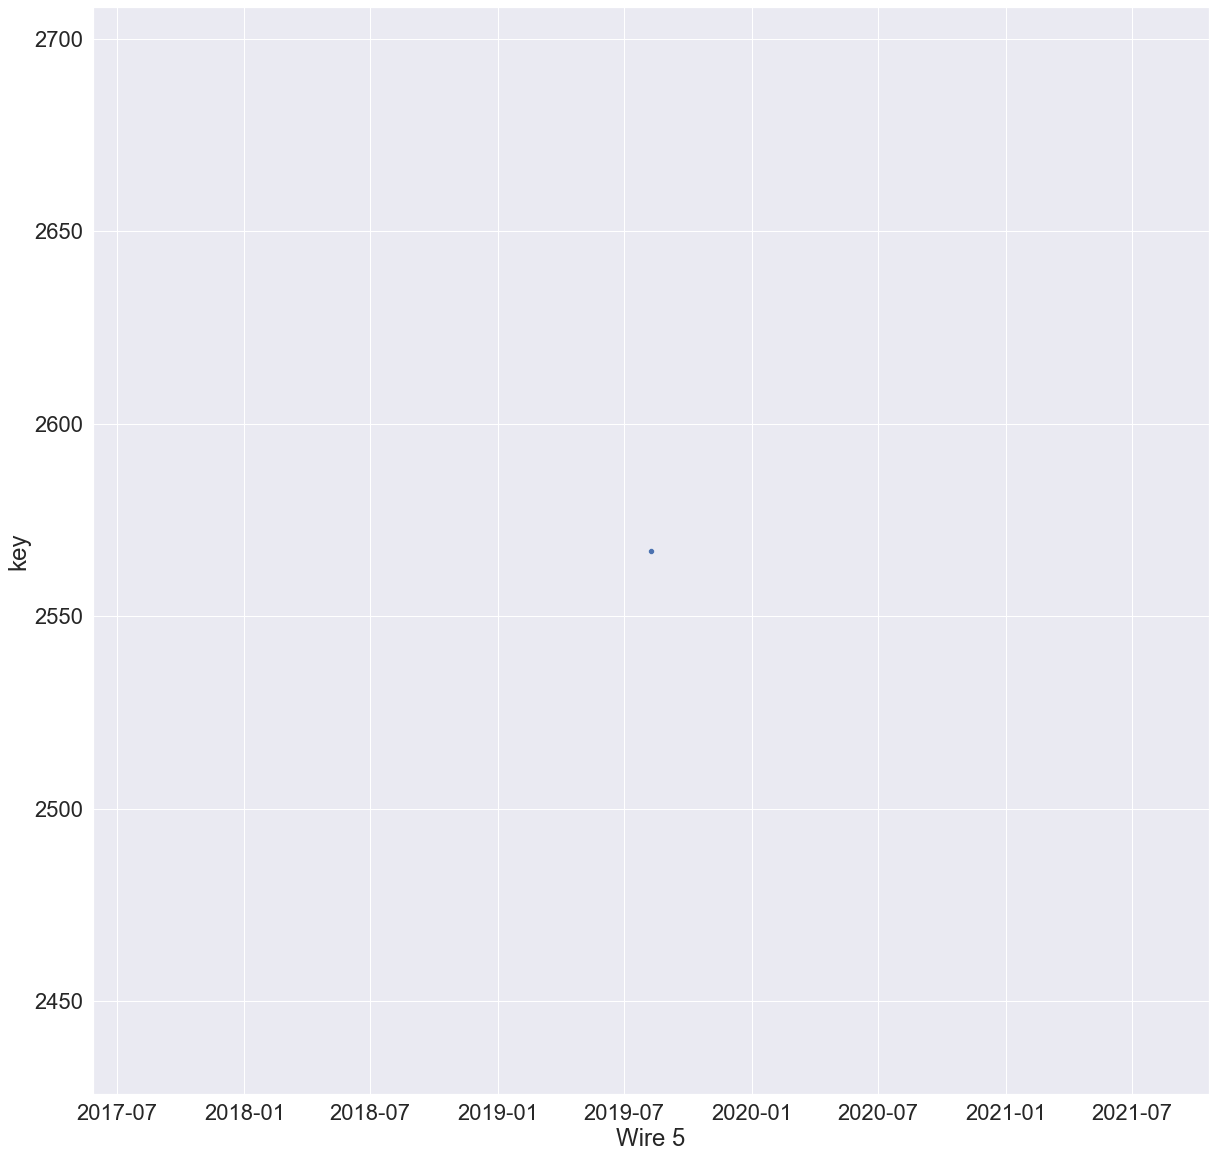

Wire 6


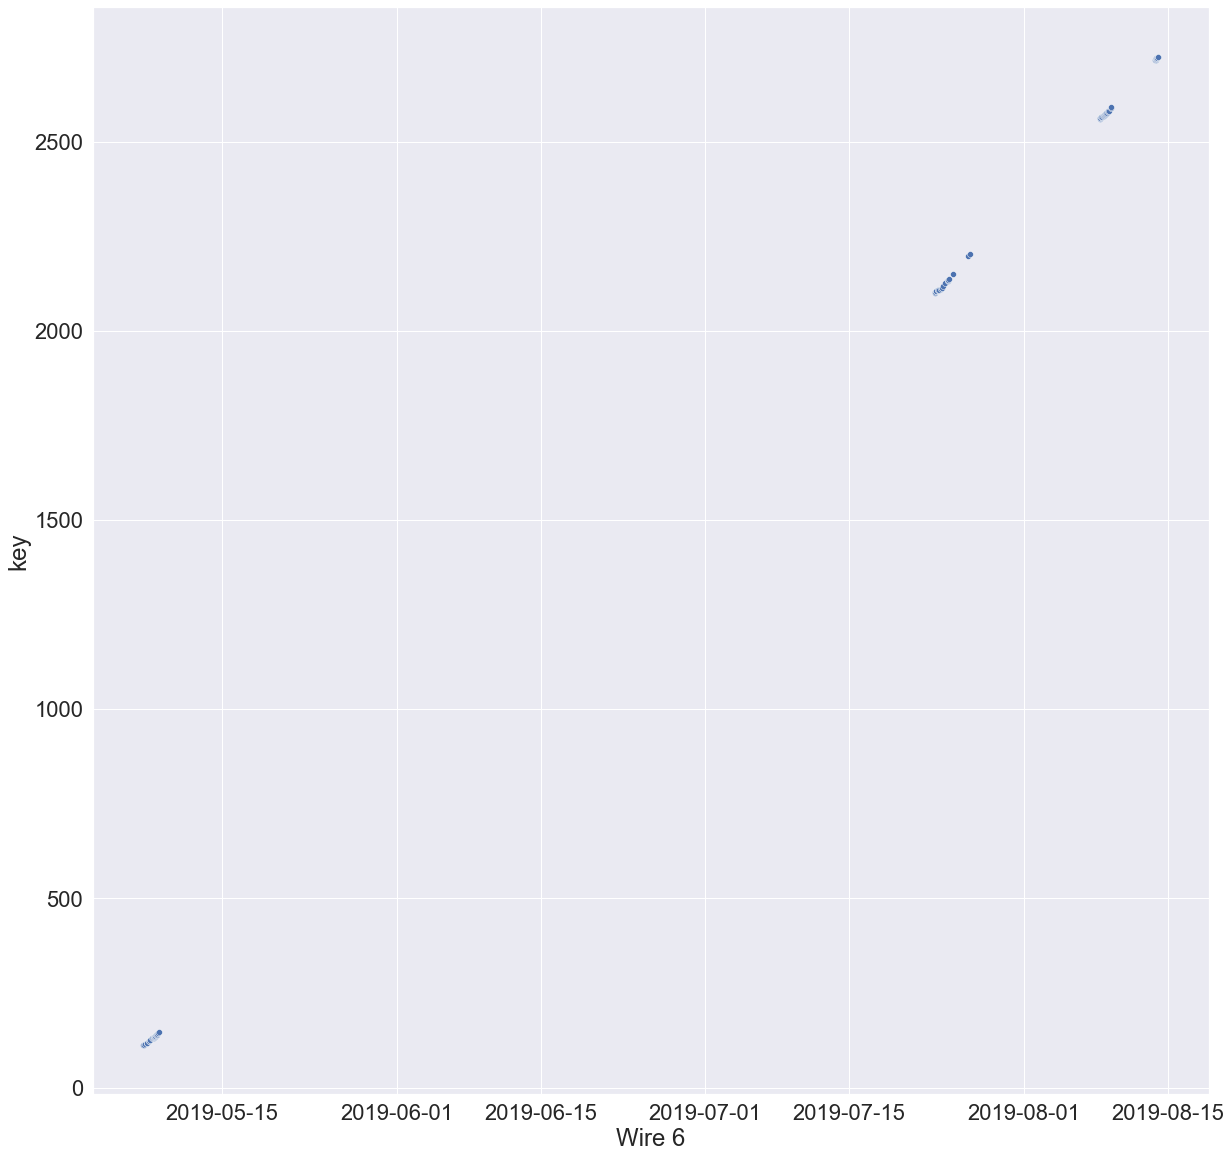

Wire 7


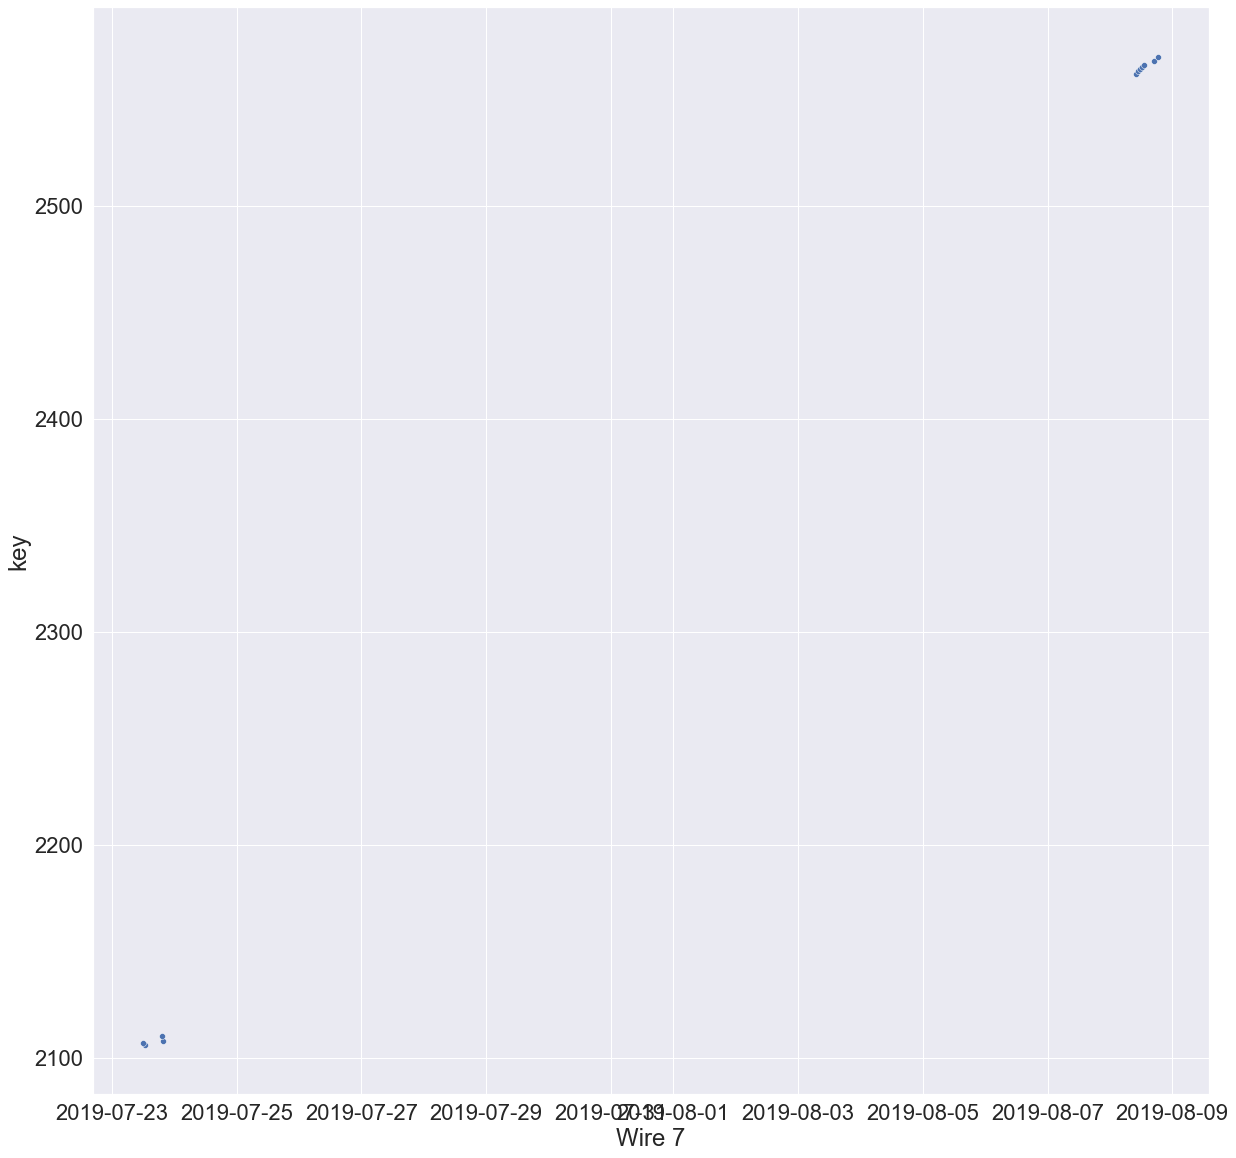

Wire 8


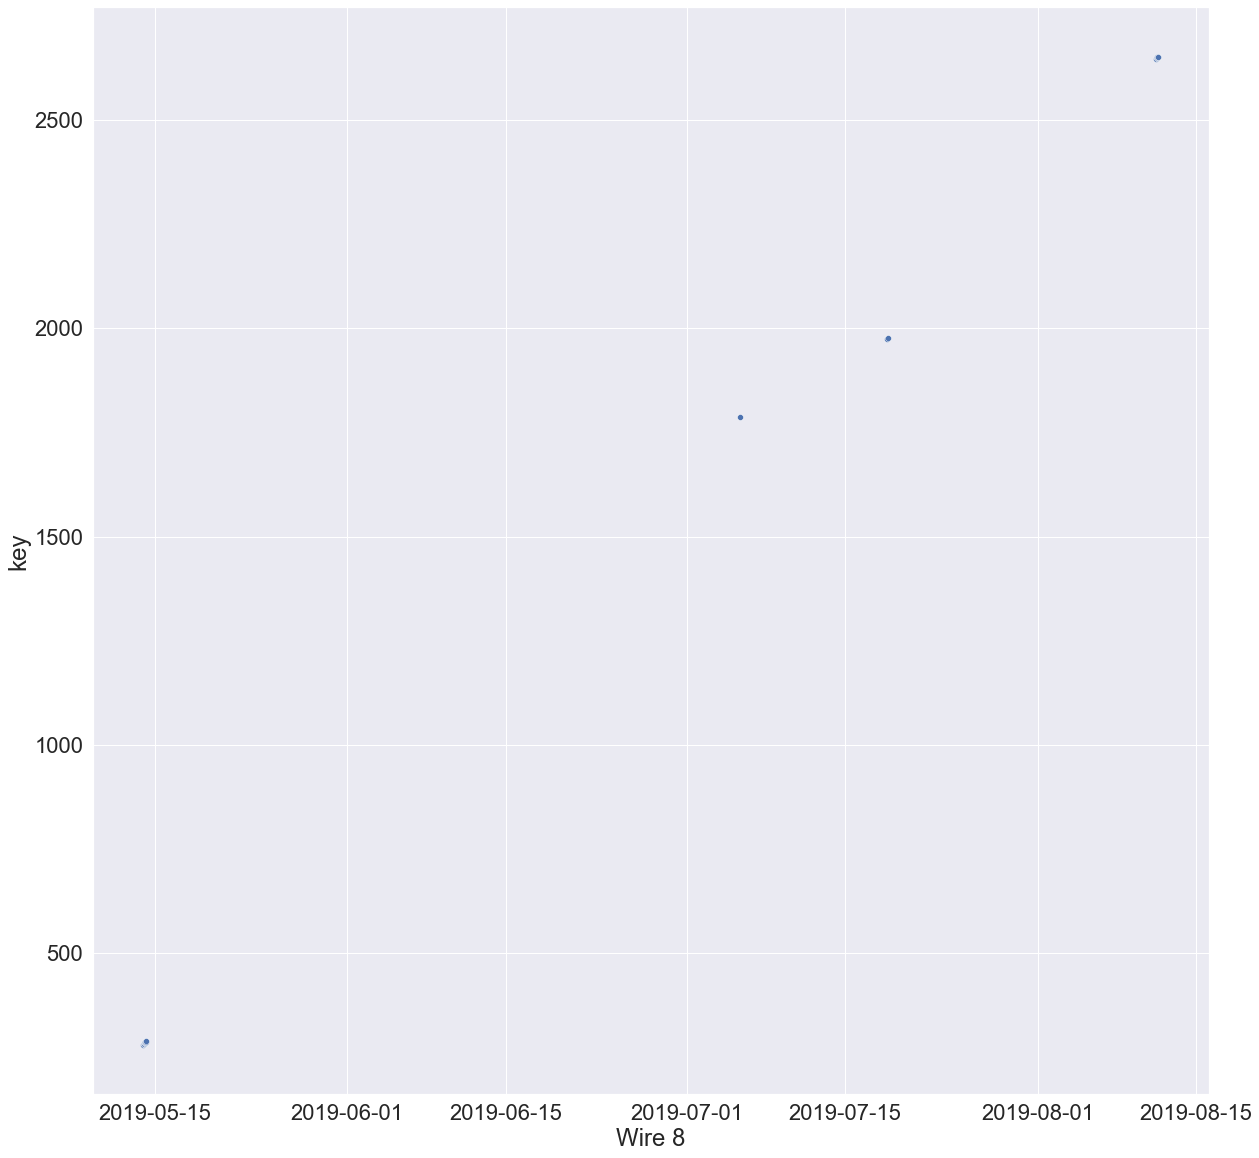

Wire 9


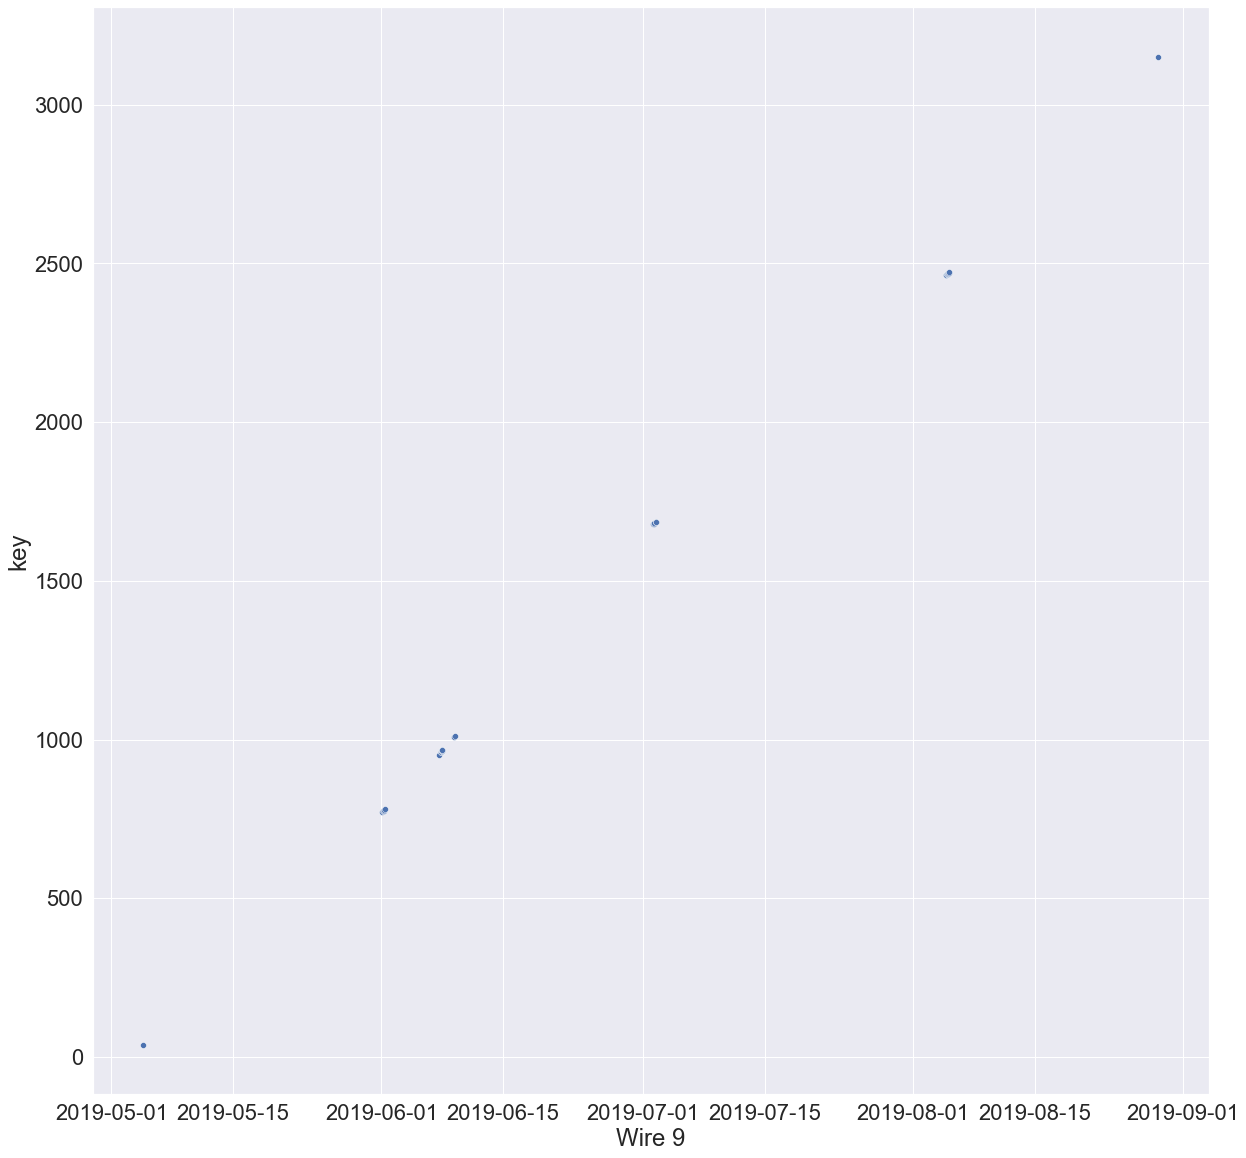

In [27]:
sns.set(font_scale=2)

for i in range(1,10):
    column = 'Wire ' + str(i)
    print(column)
    plt.figure(figsize=(20,20))
    sns.scatterplot(x = data_wire_time[column], y=data_wire_time['key'])
    plt.show()

**`Нагрев`**

In [28]:
df1 = copy.deepcopy(data_arc[['key','Начало нагрева дугой']])
df1['Тип'] = 'Начало нагрева'
df1.rename(columns={'Начало нагрева дугой':'Нагрев'},inplace=True)
df2 = copy.deepcopy(data_arc[['key','Конец нагрева дугой']])
df2['Тип'] = 'Конец нагрева'
df2.rename(columns={'Конец нагрева дугой':'Нагрев'},inplace=True)
df = pd.concat([df1,df2], ignore_index=True,join='outer')

In [30]:
px.scatter(df, x = 'key', y = 'Нагрев', color='Тип')

In [31]:
del df1,df2,df

**No outliers detected over time**

## Check temperature signs for outliers

**Check for temperature spikes in each dataset**

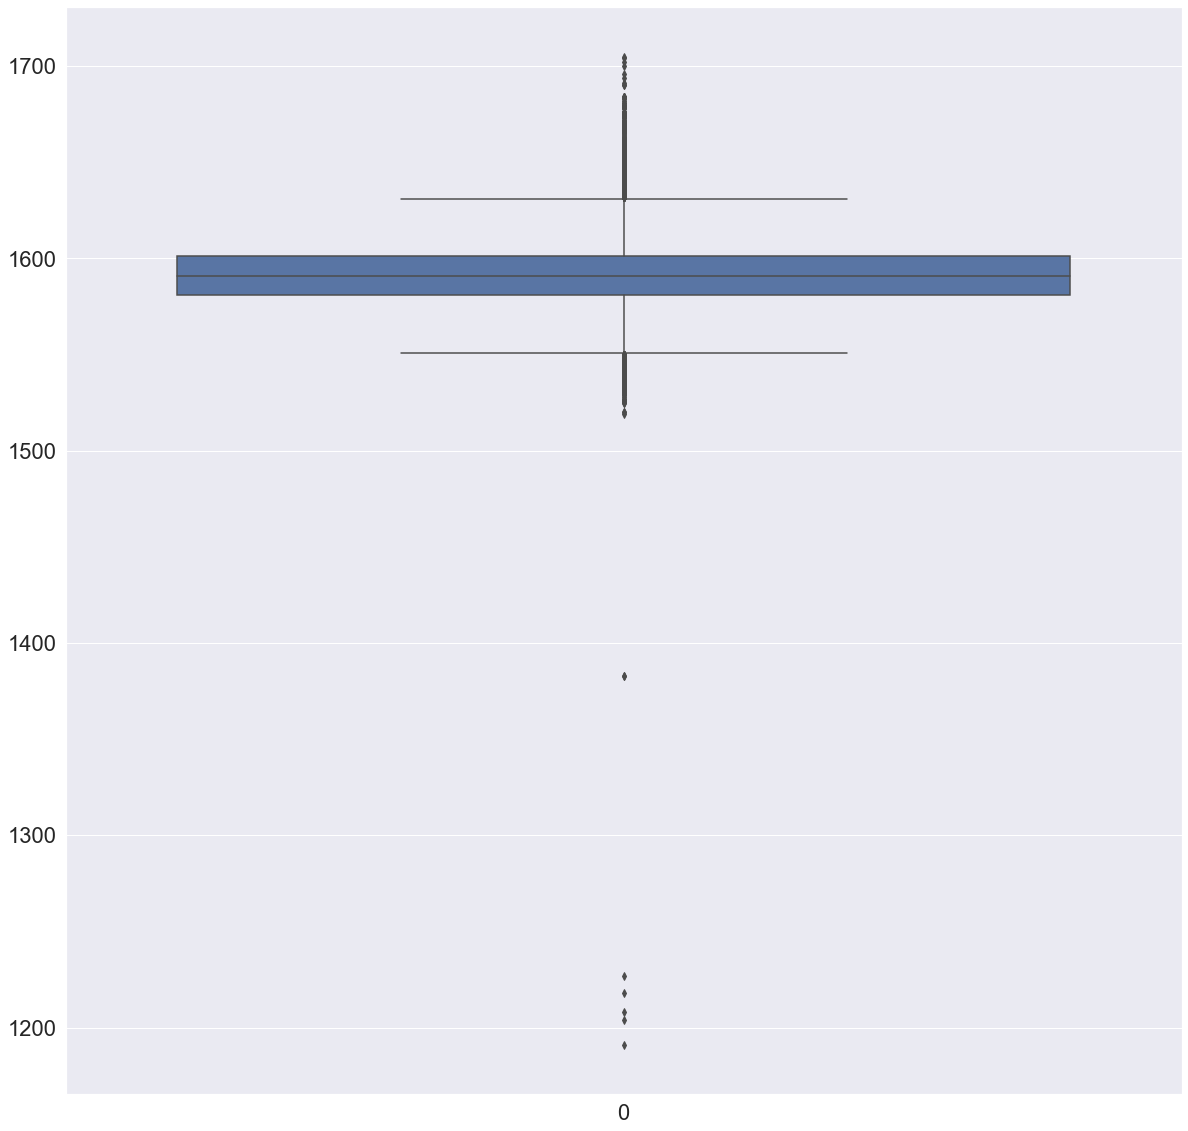

In [32]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.boxplot(data=data_temp['Температура'])
plt.show()

**Let's not remove outliers yet. Since the entire technological process is unknown, as well as the initial composition. If the accuracy of the model is low, then you need to go back and try to remove outliers**

<div style="background: #ADD8E6">
Removing temperature outliers

It is best to remove temperature outliers in the final dataset

# Create a final dataset for training the model

## Match datasets with `Bulk` and `Wire`

In [38]:
df_bulk = data_bulk.join(data_bulk_time,rsuffix='_time').reset_index(drop=True)

In [39]:
col = ['key']
for i in range(1,16):
    name = 'Bulk ' + str(i)
    col.append(name)
    name = 'Bulk ' + str(i) + '_time'
    col.append(name)

In [40]:
df_bulk = df_bulk[col]
df_bulk

key  Bulk 1 Bulk 1_time  Bulk 2 Bulk 2_time  Bulk 3  \
0        1     0.0         NaT     0.0         NaT     0.0   
1        2     0.0         NaT     0.0         NaT     0.0   
2        3     0.0         NaT     0.0         NaT     0.0   
3        4     0.0         NaT     0.0         NaT     0.0   
4        5     0.0         NaT     0.0         NaT     0.0   
...    ...     ...         ...     ...         ...     ...   
3124  3237     0.0         NaT     0.0         NaT   170.0   
3125  3238     0.0         NaT     0.0         NaT   126.0   
3126  3239     0.0         NaT     0.0         NaT     0.0   
3127  3240     0.0         NaT     0.0         NaT     0.0   
3128  3241     0.0         NaT     0.0         NaT     0.0   

             Bulk 3_time  Bulk 4         Bulk 4_time  Bulk 5 Bulk 5_time  \
0                    NaT    43.0 2019-05-03 11:21:30     0.0         NaT   
1                    NaT    73.0 2019-05-03 11:46:38     0.0         NaT   
2                    NaT    34.0 2019-05-03 12:31:06     0.0         NaT   
3                    NaT    81.0 2019-05-03 12:48:43     0.0         NaT   
4                    NaT    78.0 2019-05-03 13:18:50     0.0         NaT   
...                  ...     ...                 ...     ...         ...   
3124 2019-08-31 22:51:28     0.0                 NaT     0.0         NaT   
3125 2019-08-31 23:39:11     0.0                 NaT     0.0         NaT   
3126                 NaT     0.0                 NaT     0.0         NaT   
3127                 NaT     0.0                 NaT     0.0         NaT   
3128                 NaT     0.0                 NaT     0.0         NaT   

      Bulk 6         Bulk 6_time  Bulk 7 Bulk 7_time  Bulk 8 Bulk 8_time  \
0        0.0                 NaT     0.0         NaT     0.0         NaT   
1        0.0                 NaT     0.0         NaT     0.0         NaT   
2        0.0                 NaT     0.0         NaT     0.0         NaT   
3        0.0                 NaT     0.0         NaT     0.0         NaT   
4        0.0                 NaT     0.0         NaT     0.0         NaT   
...      ...                 ...     ...         ...     ...         ...   
3124     0.0                 NaT     0.0         NaT     0.0         NaT   
3125     0.0                 NaT     0.0         NaT     0.0         NaT   
3126   114.0 2019-09-01 01:51:58     0.0         NaT     0.0         NaT   
3127    26.0 2019-09-01 03:12:40     0.0         NaT     0.0         NaT   
3128     0.0                 NaT     0.0         NaT     0.0         NaT   

      Bulk 9 Bulk 9_time  Bulk 10 Bulk 10_time  Bulk 11 Bulk 11_time  Bulk 12  \
0        0.0         NaT      0.0          NaT      0.0          NaT    206.0   
1        0.0         NaT      0.0          NaT      0.0          NaT    206.0   
2        0.0         NaT      0.0          NaT      0.0          NaT    205.0   
3        0.0         NaT      0.0          NaT      0.0          NaT    207.0   
4        0.0         NaT      0.0          NaT      0.0          NaT    203.0   
...      ...         ...      ...          ...      ...          ...      ...   
3124     0.0         NaT      0.0          NaT      0.0          NaT    252.0   
3125     0.0         NaT      0.0          NaT      0.0          NaT    254.0   
3126     0.0         NaT      0.0          NaT      0.0          NaT    158.0   
3127     0.0         NaT      0.0          NaT      0.0          NaT      0.0   
3128     0.0         NaT      0.0          NaT      0.0          NaT      0.0   

            Bulk 12_time  Bulk 13 Bulk 13_time  Bulk 14        Bulk 14_time  \
0    2019-05-03 11:03:52      0.0          NaT    150.0 2019-05-03 11:03:52   
1    2019-05-03 11:40:20      0.0          NaT    149.0 2019-05-03 11:40:20   
2    2019-05-03 12:09:40      0.0          NaT    152.0 2019-05-03 12:09:40   
3    2019-05-03 12:41:24      0.0          NaT    153.0 2019-05-03 12:41:24   
4    2019-05-03 13:12:56      0.0          NaT    151.0 2019-05-03 1

In [41]:
df_wire = data_wire.join(data_wire_time,rsuffix='_time').reset_index(drop=True)

In [42]:
col = ['key']
for i in range(1,10):
    name = 'Wire ' + str(i)
    col.append(name)
    name = 'Wire ' + str(i) + '_time'
    col.append(name)

In [43]:
df_wire = df_wire[col]
df_wire

key      Wire 1         Wire 1_time   Wire 2         Wire 2_time  \
0        1   60.059998 2019-05-03 11:11:41  0.00000                 NaT   
1        2   96.052315 2019-05-03 11:46:10  0.00000                 NaT   
2        3   91.160157 2019-05-03 12:13:47  0.00000                 NaT   
3        4   89.063515 2019-05-03 12:48:05  0.00000                 NaT   
4        5   89.238236 2019-05-03 13:18:15  9.11456 2019-05-03 13:32:06   
...    ...         ...                 ...      ...                 ...   
3076  3237   38.088959 2019-08-31 22:50:20  0.00000                 NaT   
3077  3238   56.128799 2019-08-31 23:38:24  0.00000                 NaT   
3078  3239  143.357761 2019-09-01 01:50:43  0.00000                 NaT   
3079  3240   34.070400 2019-09-01 03:12:02  0.00000                 NaT   
3080  3241   63.117595 2019-09-01 04:16:01  0.00000                 NaT   

      Wire 3 Wire 3_time  Wire 4 Wire 4_time  Wire 5 Wire 5_time  Wire 6  \
0        0.0         NaT     0.0         NaT     0.0         NaT     0.0   
1        0.0         NaT     0.0         NaT     0.0         NaT     0.0   
2        0.0         NaT     0.0         NaT     0.0         NaT     0.0   
3        0.0         NaT     0.0         NaT     0.0         NaT     0.0   
4        0.0         NaT     0.0         NaT     0.0         NaT     0.0   
...      ...         ...     ...         ...     ...         ...     ...   
3076     0.0         NaT     0.0         NaT     0.0         NaT     0.0   
3077     0.0         NaT     0.0         NaT     0.0         NaT     0.0   
3078     0.0         NaT     0.0         NaT     0.0         NaT     0.0   
3079     0.0         NaT     0.0         NaT     0.0         NaT     0.0   
3080     0.0         NaT     0.0         NaT     0.0         NaT     0.0   

     Wire 6_time  Wire 7 Wire 7_time  Wire 8 Wire 8_time  Wire 9 Wire 9_time  
0            NaT     0.0         NaT     0.0         NaT     0.0         NaT  
1            NaT     0.0         NaT     0.0         NaT     0.0         NaT  
2            NaT     0.0         NaT     0.0         NaT     0.0         NaT  
3            NaT     0.0         NaT     0.0         NaT     0.0         NaT  
4            NaT     0.0         NaT     0.0         NaT     0.0         NaT  
...          ...     ...         ...     ...         ...     ...         ...  
3076         NaT     0.0         NaT     0.0         NaT     0.0         NaT  
3077         NaT     0.0         NaT     0.0         NaT     0.0         NaT  
3078         NaT     0.0         NaT     0.0         NaT     0.0         NaT  
3079         NaT     0.0         NaT     0.0         NaT     0.0         NaT  
3080         NaT     0.0         NaT     0.0         NaT     0.0         NaT  

[3081 rows x 19 columns]

<div style="background: #ADD8E6">
Removing outliers `Bulk`, `Wire`

In [44]:
display(df_bulk.info())
display(df_wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   Bulk 1        3129 non-null   float64       
 2   Bulk 1_time   252 non-null    datetime64[ns]
 3   Bulk 2        3129 non-null   float64       
 4   Bulk 2_time   22 non-null     datetime64[ns]
 5   Bulk 3        3129 non-null   float64       
 6   Bulk 3_time   1298 non-null   datetime64[ns]
 7   Bulk 4        3129 non-null   float64       
 8   Bulk 4_time   1014 non-null   datetime64[ns]
 9   Bulk 5        3129 non-null   float64       
 10  Bulk 5_time   77 non-null     datetime64[ns]
 11  Bulk 6        3129 non-null   float64       
 12  Bulk 6_time   576 non-null    datetime64[ns]
 13  Bulk 7        3129 non-null   float64       
 14  Bulk 7_time   25 non-null     datetime64[ns]
 15  Bulk 8        3129 non-null   float64 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   Wire 1       3081 non-null   float64       
 2   Wire 1_time  3055 non-null   datetime64[ns]
 3   Wire 2       3081 non-null   float64       
 4   Wire 2_time  1079 non-null   datetime64[ns]
 5   Wire 3       3081 non-null   float64       
 6   Wire 3_time  63 non-null     datetime64[ns]
 7   Wire 4       3081 non-null   float64       
 8   Wire 4_time  14 non-null     datetime64[ns]
 9   Wire 5       3081 non-null   float64       
 10  Wire 5_time  1 non-null      datetime64[ns]
 11  Wire 6       3081 non-null   float64       
 12  Wire 6_time  73 non-null     datetime64[ns]
 13  Wire 7       3081 non-null   float64       
 14  Wire 7_time  11 non-null     datetime64[ns]
 15  Wire 8       3081 non-null   float64       
 16  Wire 8

None

**Bulk**

Removing a line with outliers

In [45]:
# for i in range(1,16):
#     col = 'Bulk ' + str(i)
#     q1 = df_bulk[col].quantile(0.25)
#     q3 = df_bulk[col].quantile(0.75)
#     irq = q3 - q1
#     index = df_bulk.loc[(df_bulk[col] < (q1 - 1.5*irq)) | (df_bulk[col] > (q3 + 1.5*irq))].index
#     df_bulk = df_bulk.drop(index).reset_index(drop=True)

Replacing outliers with 0

In [46]:
# for i in range(1,16):
#     col = 'Bulk ' + str(i)
#     q1 = df_bulk[col].quantile(0.25)
#     q3 = df_bulk[col].quantile(0.75)
#     irq = q3 - q1
#     df_bulk.loc[(df_bulk[col] < (q1 - 1.5*irq)) | (df_bulk[col] > (q3 + 1.5*irq)), col] = 0

Deleting all key where there is at least one outlier

In [47]:
keys = []
for i in range(1,16):
    col = 'Bulk ' + str(i)
    q1 = df_bulk[col].quantile(0.25)
    q3 = df_bulk[col].quantile(0.75)
    irq = q3 - q1
    keys.append(list(df_bulk.loc[(df_bulk[col] < (q1 - 1.5*irq)) | (df_bulk[col] > (q3 + 1.5*irq))]['key'].values))

new_keys = list(chain.from_iterable(keys))


df_bulk = df_bulk.query('key not in @new_keys')

**Wire**

Removing a line with outliers

In [48]:
# for i in range(1,10):
#     col = 'Wire ' + str(i)
#     q1 = df_wire[col].quantile(0.25)
#     q3 = df_wire[col].quantile(0.75)
#     irq = q3 - q1
#     index = df_wire.loc[(df_wire[col] < (q1 - 1.5*irq)) | (df_wire[col] > (q3 + 1.5*irq))].index
#     df_wire = df_wire.drop(index).reset_index(drop=True)

Replacing outliers with 0

In [49]:
# for i in range(1,10):
#     col = 'Wire ' + str(i)
#     q1 = df_wire[col].quantile(0.25)
#     q3 = df_wire[col].quantile(0.75)
#     irq = q3 - q1
#     df_wire.loc[(df_wire[col] < (q1 - 1.5*irq)) | (df_wire[col] > (q3 + 1.5*irq)), col] = 0

Deleting all key where there is at least one outlier

In [50]:
keys = []
for i in range(1,10):
    col = 'Wire ' + str(i)
    q1 = df_wire[col].quantile(0.25)
    q3 = df_wire[col].quantile(0.75)
    irq = q3 - q1
    keys.append(list(df_wire.loc[(df_wire[col] < (q1 - 1.5*irq)) | (df_wire[col] > (q3 + 1.5*irq))]['key'].values))

new_keys = list(chain.from_iterable(keys))

df_wire = df_wire.query('key not in @new_keys')

In [51]:
display(df_bulk.info())
display(df_wire.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           1858 non-null   int64         
 1   Bulk 1        1858 non-null   float64       
 2   Bulk 1_time   0 non-null      datetime64[ns]
 3   Bulk 2        1858 non-null   float64       
 4   Bulk 2_time   0 non-null      datetime64[ns]
 5   Bulk 3        1858 non-null   float64       
 6   Bulk 3_time   800 non-null    datetime64[ns]
 7   Bulk 4        1858 non-null   float64       
 8   Bulk 4_time   724 non-null    datetime64[ns]
 9   Bulk 5        1858 non-null   float64       
 10  Bulk 5_time   0 non-null      datetime64[ns]
 11  Bulk 6        1858 non-null   float64       
 12  Bulk 6_time   0 non-null      datetime64[ns]
 13  Bulk 7        1858 non-null   float64       
 14  Bulk 7_time   0 non-null      datetime64[ns]
 15  Bulk 8        1858 non-null   float64 

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          2569 non-null   int64         
 1   Wire 1       2569 non-null   float64       
 2   Wire 1_time  2562 non-null   datetime64[ns]
 3   Wire 2       2569 non-null   float64       
 4   Wire 2_time  675 non-null    datetime64[ns]
 5   Wire 3       2569 non-null   float64       
 6   Wire 3_time  0 non-null      datetime64[ns]
 7   Wire 4       2569 non-null   float64       
 8   Wire 4_time  0 non-null      datetime64[ns]
 9   Wire 5       2569 non-null   float64       
 10  Wire 5_time  0 non-null      datetime64[ns]
 11  Wire 6       2569 non-null   float64       
 12  Wire 6_time  0 non-null      datetime64[ns]
 13  Wire 7       2569 non-null   float64       
 14  Wire 7_time  0 non-null      datetime64[ns]
 15  Wire 8       2569 non-null   float64       
 16  Wire 8

None

## Populate the dataset with all the information

In [52]:
full = copy.deepcopy(data_temp)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.0 MB


In [53]:
full['gas'] = 0
full['AP'] = 0
full['RP'] = 0

In [54]:
for i in range(1,16):
    column = 'Bulk ' + str(i)
    full[column] = 0

In [55]:
for i in range(1,10):
    column = 'Wire ' + str(i)
    full[column] = 0

In [56]:
full

key        Время замера  Температура  gas  AP  RP  Bulk 1  Bulk 2  \
0         1 2019-05-03 11:16:18       1571.0    0   0   0       0       0   
1         1 2019-05-03 11:25:53       1604.0    0   0   0       0       0   
2         1 2019-05-03 11:29:11       1618.0    0   0   0       0       0   
3         1 2019-05-03 11:30:01       1601.0    0   0   0       0       0   
4         1 2019-05-03 11:30:39       1613.0    0   0   0       0       0   
...     ...                 ...          ...  ...  ..  ..     ...     ...   
15878  3237 2019-08-31 22:44:04       1569.0    0   0   0       0       0   
15883  3238 2019-08-31 23:30:31       1584.0    0   0   0       0       0   
15886  3239 2019-09-01 01:31:47       1598.0    0   0   0       0       0   
15894  3240 2019-09-01 02:39:01       1617.0    0   0   0       0       0   
15902  3241 2019-09-01 04:03:30       1586.0    0   0   0       0       0   

       Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  \
0           0       0       0       0       0       0       0        0   
1           0       0       0       0       0       0       0        0   
2           0       0       0       0       0       0       0        0   
3           0       0       0       0       0       0       0        0   
4           0       0       0       0       0       0       0        0   
...       ...     ...     ...     ...     ...     ...     ...      ...   
15878       0       0       0       0       0       0       0        0   
15883       0       0       0       0       0       0       0        0   
15886       0       0       0       0       0       0       0        0   
15894       0       0       0       0       0       0       0        0   
15902       0       0       0       0       0       0       0        0   

       Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  Wire 1  Wire 2  Wire 3  \
0            0        0        0        0        0       0       0       0   
1            0        0        0        0        0       0       0       0   
2            0        0        0        0        0       0       0       0   
3            0        0        0        0        0       0       0       0   
4            0        0        0        0        0       0       0       0   
...        ...      ...      ...      ...      ...     ...     ...     ...   
15878        0        0        0        0        0       0       0       0   
15883        0        0        0        0        0       0       0       0   
15886        0        0        0        0        0       0       0       0   
15894        0        0        0        0        0       0       0       0   
15902        0        0        0        0        0       0       0       0   

       Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
0           0       0       0       0       0       0  
1           0       0       0       0       0       0  
2           0       0       0       0       0       0  
3           0       0       0       0       0       0  
4           0       0       0       0       0       0  
...       ...     ...     ...     ...     ...     ...  
15878       0       0       0       0       0       0  
15883       0       0       0       0       0       0  
15886       0       0       0       0       0       0  
15894       0       0       0       0       0       0  
15902       0       0       0       0       0       0  

[13006 rows x 30 columns]

### Мощность

In [57]:
def func_ap(row):
    v = data_arc['Активная мощность'].loc[(data_arc['key'] == row['key'])].sum()
    return v

full['AP'] = full.apply(func_ap, axis=1)

def func_rp(row):
    v = data_arc['Реактивная мощность'].loc[(data_arc['key'] == row['key'])].sum()
    return v

full['RP'] = full.apply(func_rp, axis=1)

### Gas

In [58]:
def func_gas(row):
    v = data_gas['Газ 1'].loc[(data_gas['key'] == row['key'])].sum()
    return v

full['gas'] = full.apply(func_gas, axis=1)

### Bulk

In [59]:
def func_bulk(row,col):
    time_col = col + '_time'
    v = df_bulk[col].loc[(df_bulk['key'] == row['key']) & (df_bulk[time_col] <= row['Время замера'])].sum()
    return v

for i in notebook.tqdm(range(1,16)):
    col = 'Bulk ' + str(i) 
    full[col] = full.apply(lambda x: func_bulk(x, col), axis=1)

### Wire

In [60]:
def func_wire(row,col):
    time_col = col + '_time'
    v = df_wire[col].loc[(df_wire['key'] == row['key']) & (df_wire[time_col] <= row['Время замера'])].sum()
    return v

for i in notebook.tqdm(range(1,10)):
    col = 'Wire ' + str(i) 
    full[col] = full.apply(lambda x: func_wire(x, col), axis=1)

## Processing the final dataset

In [61]:
full.describe()

key   Температура           gas            AP            RP  \
count  13006.000000  13006.000000  13006.000000  13006.000000  13006.000000   
mean    1328.447793   1591.840920     10.163219      2.384203      1.795540   
std      804.740001     21.375851      5.286216      1.568545      1.204785   
min        1.000000   1191.000000      0.000000      0.000000      0.000000   
25%      638.000000   1581.000000      6.808413      1.300536      0.984980   
50%     1315.000000   1591.000000      9.854895      2.525219      1.889200   
75%     1977.750000   1601.000000     13.625982      3.444225      2.569870   
max     3241.000000   1705.000000     23.811279      9.910345      8.135789   

        Bulk 1   Bulk 2        Bulk 3        Bulk 4   Bulk 5   Bulk 6  \
count  13006.0  13006.0  13006.000000  13006.000000  13006.0  13006.0   
mean       0.0      0.0     13.172766     13.344918      0.0      0.0   
std        0.0      0.0     37.278815     36.730410      0.0      0.0   
min        0.0      0.0      0.000000      0.000000      0.0      0.0   
25%        0.0      0.0      0.000000      0.000000      0.0      0.0   
50%        0.0      0.0      0.000000      0.000000      0.0      0.0   
75%        0.0      0.0      0.000000      0.000000      0.0      0.0   
max        0.0      0.0    199.000000    170.000000      0.0      0.0   

        Bulk 7   Bulk 8   Bulk 9  Bulk 10  Bulk 11       Bulk 12  Bulk 13  \
count  13006.0  13006.0  13006.0  13006.0  13006.0  13006.000000  13006.0   
mean       0.0      0.0      0.0      0.0      0.0     80.931493      0.0   
std        0.0      0.0      0.0      0.0      0.0    131.078162      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.000000      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.000000      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.000000      0.0   
75%        0.0      0.0      0.0      0.0      0.0    204.000000      0.0   
max        0.0      0.0      0.0      0.0      0.0    484.000000      0.0   

            Bulk 14       Bulk 15        Wire 1        Wire 2   Wire 3  \
count  13006.000000  13006.000000  13006.000000  13006.000000  13006.0   
mean      58.628402     48.661771     56.942700      3.481107      0.0   
std       85.120055     80.302649     60.475716     10.651318      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%        0.000000      0.000000      0.000000      0.000000      0.0   
50%        0.000000      0.000000     45.161997      0.000000      0.0   
75%      124.000000    103.000000    107.059677      0.000000      0.0   
max      349.000000    405.000000    207.323990     57.249920      0.0   

        Wire 4   Wire 5   Wire 6   Wire 7   Wire 8   Wire 9  
count  13006.0  13006.0  13006.0  13006.0  13006.0  13006.0  
mean       0.0      0.0      0.0      0.0      0.0      0.0  
std        0.0      0.0      0.0      0.0      0.0      0.0  
min        0.0      0.0      0.0      0.0      0.0      0.0  
25%        0.0      0.0      0.0      0.0      0.0      0.0  
50%        0.0      0.0      0.0      0.0      0.0      0.0  
75%        0.0      0.0      0.0      0.0      0.0      0.0  
max        0.0      0.0      0.0      0.0      0.0      0.0

**In each batch, it is necessary to leave only the last measurement, and we will train the model on it**

In [62]:
n = copy.deepcopy(full)
n.sort_values(by=['key','Время замера'], ascending=True,inplace=True)
n.drop_duplicates(subset=['key'], keep='first', inplace=True)
n.reset_index(drop=True,inplace=True)
n = n[['key','Температура']]
n.rename(columns={'Температура':'Начальная температура'},inplace=True)
n

key  Начальная температура
0        1                 1571.0
1        2                 1581.0
2        3                 1596.0
3        4                 1601.0
4        5                 1576.0
...    ...                    ...
3211  3237                 1569.0
3212  3238                 1584.0
3213  3239                 1598.0
3214  3240                 1617.0
3215  3241                 1586.0

[3216 rows x 2 columns]

In [63]:
f = copy.deepcopy(full)

In [64]:
f.sort_values(by=['key','Время замера'], ascending=True,inplace=True)

In [65]:
f.drop_duplicates(subset=['key'], keep='last', inplace=True)
f.reset_index(drop=True,inplace=True)

In [66]:
f = f.merge(n,how='left',on='key')

In [67]:
f.head()

key        Время замера  Температура        gas        AP        RP  \
0    1 2019-05-03 11:30:39       1613.0   0.000000  0.000000  0.000000   
1    2 2019-05-03 11:59:12       1602.0  12.555561  3.052598  1.998112   
2    3 2019-05-03 12:34:57       1599.0   0.000000  2.525882  1.599076   
3    4 2019-05-03 12:59:25       1625.0  18.841219  3.209250  2.060298   
4    5 2019-05-03 13:36:01       1602.0   5.413692  0.000000  0.000000   

   Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
0     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   

   Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15     Wire 1   Wire 2  \
0      0.0      0.0    206.0      0.0    150.0    154.0  60.059998  0.00000   
1      0.0      0.0    206.0      0.0    149.0    154.0  96.052315  0.00000   
2      0.0      0.0    205.0      0.0    152.0    153.0  91.160157  0.00000   
3      0.0      0.0    207.0      0.0    153.0    154.0  89.063515  0.00000   
4      0.0      0.0    203.0      0.0    151.0    152.0  89.238236  9.11456   

   Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Начальная температура  
0                 1571.0  
1                 1581.0  
2                 1596.0  
3                 1601.0  
4                 1576.0

 <div style="background: #ADD8E6">
Removing rows where the end temperature is equal to the start

In [68]:
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    3216 non-null   int64         
 1   Время замера           3216 non-null   datetime64[ns]
 2   Температура            3216 non-null   float64       
 3   gas                    3216 non-null   float64       
 4   AP                     3216 non-null   float64       
 5   RP                     3216 non-null   float64       
 6   Bulk 1                 3216 non-null   float64       
 7   Bulk 2                 3216 non-null   float64       
 8   Bulk 3                 3216 non-null   float64       
 9   Bulk 4                 3216 non-null   float64       
 10  Bulk 5                 3216 non-null   float64       
 11  Bulk 6                 3216 non-null   float64       
 12  Bulk 7                 3216 non-null   float64       
 13  Bul

In [69]:
index = f.loc[f['Начальная температура'] == f['Температура']].index
f = f.drop(index).reset_index(drop=True)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2433 entries, 0 to 2432
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2433 non-null   int64         
 1   Время замера           2433 non-null   datetime64[ns]
 2   Температура            2433 non-null   float64       
 3   gas                    2433 non-null   float64       
 4   AP                     2433 non-null   float64       
 5   RP                     2433 non-null   float64       
 6   Bulk 1                 2433 non-null   float64       
 7   Bulk 2                 2433 non-null   float64       
 8   Bulk 3                 2433 non-null   float64       
 9   Bulk 4                 2433 non-null   float64       
 10  Bulk 5                 2433 non-null   float64       
 11  Bulk 6                 2433 non-null   float64       
 12  Bulk 7                 2433 non-null   float64       
 13  Bul

<div style="background: #ADD8E6">
Removing rows where there is no final temperature measurement

In [70]:
semi_ds = data_arc[['key','Конец нагрева дугой']].sort_values(by=['Конец нагрева дугой'])
semi_ds.drop_duplicates(subset=['key'], keep='last', inplace=True)
semi_ds.reset_index(drop=True,inplace=True)
semi_ds

key Конец нагрева дугой
0        2 2019-05-03 11:53:18
1        3 2019-05-03 12:32:19
2        4 2019-05-03 12:57:50
3        7 2019-05-03 14:41:15
4        9 2019-05-03 15:59:48
...    ...                 ...
2685  3237 2019-08-31 23:03:48
2686  3238 2019-08-31 23:41:28
2687  3239 2019-09-01 02:15:43
2688  3240 2019-09-01 03:34:08
2689  3241 2019-09-01 04:36:08

[2690 rows x 2 columns]

In [71]:
f = f.merge(semi_ds,how='left',on='key')
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2433 non-null   int64         
 1   Время замера           2433 non-null   datetime64[ns]
 2   Температура            2433 non-null   float64       
 3   gas                    2433 non-null   float64       
 4   AP                     2433 non-null   float64       
 5   RP                     2433 non-null   float64       
 6   Bulk 1                 2433 non-null   float64       
 7   Bulk 2                 2433 non-null   float64       
 8   Bulk 3                 2433 non-null   float64       
 9   Bulk 4                 2433 non-null   float64       
 10  Bulk 5                 2433 non-null   float64       
 11  Bulk 6                 2433 non-null   float64       
 12  Bulk 7                 2433 non-null   float64       
 13  Bul

In [72]:
index = f.loc[f['Время замера'] < f['Конец нагрева дугой']].index
f = f.drop(index).reset_index(drop=True)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2328 non-null   int64         
 1   Время замера           2328 non-null   datetime64[ns]
 2   Температура            2328 non-null   float64       
 3   gas                    2328 non-null   float64       
 4   AP                     2328 non-null   float64       
 5   RP                     2328 non-null   float64       
 6   Bulk 1                 2328 non-null   float64       
 7   Bulk 2                 2328 non-null   float64       
 8   Bulk 3                 2328 non-null   float64       
 9   Bulk 4                 2328 non-null   float64       
 10  Bulk 5                 2328 non-null   float64       
 11  Bulk 6                 2328 non-null   float64       
 12  Bulk 7                 2328 non-null   float64       
 13  Bul

<div style="background: #ADD8E6">
Removing temperature outliers

In [73]:
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2328 non-null   int64         
 1   Время замера           2328 non-null   datetime64[ns]
 2   Температура            2328 non-null   float64       
 3   gas                    2328 non-null   float64       
 4   AP                     2328 non-null   float64       
 5   RP                     2328 non-null   float64       
 6   Bulk 1                 2328 non-null   float64       
 7   Bulk 2                 2328 non-null   float64       
 8   Bulk 3                 2328 non-null   float64       
 9   Bulk 4                 2328 non-null   float64       
 10  Bulk 5                 2328 non-null   float64       
 11  Bulk 6                 2328 non-null   float64       
 12  Bulk 7                 2328 non-null   float64       
 13  Bul

In [74]:
q1 = f['Температура'].quantile(0.25)
q3 = f['Температура'].quantile(0.75)
irq = q3 - q1

In [75]:
index = f.loc[(f['Температура'] < (q1 - 1.5*irq)) | (f['Температура'] > (q3 + 1.5*irq))].index
f = f.drop(index).reset_index(drop=True)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145 entries, 0 to 2144
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2145 non-null   int64         
 1   Время замера           2145 non-null   datetime64[ns]
 2   Температура            2145 non-null   float64       
 3   gas                    2145 non-null   float64       
 4   AP                     2145 non-null   float64       
 5   RP                     2145 non-null   float64       
 6   Bulk 1                 2145 non-null   float64       
 7   Bulk 2                 2145 non-null   float64       
 8   Bulk 3                 2145 non-null   float64       
 9   Bulk 4                 2145 non-null   float64       
 10  Bulk 5                 2145 non-null   float64       
 11  Bulk 6                 2145 non-null   float64       
 12  Bulk 7                 2145 non-null   float64       
 13  Bul

In [76]:
q1 = f['Начальная температура'].quantile(0.25)
q3 = f['Начальная температура'].quantile(0.75)
irq = q3 - q1

In [77]:
index = f.loc[(f['Начальная температура'] < (q1 - 1.5*irq)) | (f['Начальная температура'] > (q3 + 1.5*irq))].index
f = f.drop(index).reset_index(drop=True)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2127 non-null   int64         
 1   Время замера           2127 non-null   datetime64[ns]
 2   Температура            2127 non-null   float64       
 3   gas                    2127 non-null   float64       
 4   AP                     2127 non-null   float64       
 5   RP                     2127 non-null   float64       
 6   Bulk 1                 2127 non-null   float64       
 7   Bulk 2                 2127 non-null   float64       
 8   Bulk 3                 2127 non-null   float64       
 9   Bulk 4                 2127 non-null   float64       
 10  Bulk 5                 2127 non-null   float64       
 11  Bulk 6                 2127 non-null   float64       
 12  Bulk 7                 2127 non-null   float64       
 13  Bul

Удаление ненужных признаков

In [78]:
f.drop(['Время замера','key','Конец нагрева дугой'],inplace=True,axis=1)

## Correlation matrix

In [72]:
#del data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time, df_bulk, df_wire, n

In [79]:
corr = f.corr()
fig = px.imshow(corr)
fig.show()

In [80]:
for col in list(corr.columns.unique()):
    print(col)
    display(corr.loc[(corr[col] < 1) & (corr[col] >= 0.6),col])
    print()

Температура


Series([], Name: Температура, dtype: float64)


gas


Series([], Name: gas, dtype: float64)


AP


RP    0.971867
Name: AP, dtype: float64


RP


AP    0.971867
Name: RP, dtype: float64


Bulk 1


Series([], Name: Bulk 1, dtype: float64)


Bulk 2


Series([], Name: Bulk 2, dtype: float64)


Bulk 3


Series([], Name: Bulk 3, dtype: float64)


Bulk 4


Series([], Name: Bulk 4, dtype: float64)


Bulk 5


Series([], Name: Bulk 5, dtype: float64)


Bulk 6


Series([], Name: Bulk 6, dtype: float64)


Bulk 7


Series([], Name: Bulk 7, dtype: float64)


Bulk 8


Series([], Name: Bulk 8, dtype: float64)


Bulk 9


Series([], Name: Bulk 9, dtype: float64)


Bulk 10


Series([], Name: Bulk 10, dtype: float64)


Bulk 11


Series([], Name: Bulk 11, dtype: float64)


Bulk 12


Bulk 14    0.751864
Bulk 15    0.863118
Name: Bulk 12, dtype: float64


Bulk 13


Series([], Name: Bulk 13, dtype: float64)


Bulk 14


Bulk 12    0.751864
Bulk 15    0.688787
Name: Bulk 14, dtype: float64


Bulk 15


Bulk 12    0.863118
Bulk 14    0.688787
Name: Bulk 15, dtype: float64


Wire 1


Series([], Name: Wire 1, dtype: float64)


Wire 2


Series([], Name: Wire 2, dtype: float64)


Wire 3


Series([], Name: Wire 3, dtype: float64)


Wire 4


Series([], Name: Wire 4, dtype: float64)


Wire 5


Series([], Name: Wire 5, dtype: float64)


Wire 6


Series([], Name: Wire 6, dtype: float64)


Wire 7


Series([], Name: Wire 7, dtype: float64)


Wire 8


Series([], Name: Wire 8, dtype: float64)


Wire 9


Series([], Name: Wire 9, dtype: float64)


Начальная температура


Series([], Name: Начальная температура, dtype: float64)

Удалим следующие признаки в связи с сильной корреляцией: `RP`,`Bulk 7`,`Wire 4`,`Wire 8`,`Bulk 15`

In [81]:
f.drop(['RP', 'Bulk 14', 'Bulk 15'], inplace=True,axis=1)

In [82]:
corr = f.corr()
for col in list(corr.columns.unique()):
    print(col)
    display(corr.loc[(corr[col] < 1) & (corr[col] >= 0.6),col])
    print()

Температура


Series([], Name: Температура, dtype: float64)


gas


Series([], Name: gas, dtype: float64)


AP


Series([], Name: AP, dtype: float64)


Bulk 1


Series([], Name: Bulk 1, dtype: float64)


Bulk 2


Series([], Name: Bulk 2, dtype: float64)


Bulk 3


Series([], Name: Bulk 3, dtype: float64)


Bulk 4


Series([], Name: Bulk 4, dtype: float64)


Bulk 5


Series([], Name: Bulk 5, dtype: float64)


Bulk 6


Series([], Name: Bulk 6, dtype: float64)


Bulk 7


Series([], Name: Bulk 7, dtype: float64)


Bulk 8


Series([], Name: Bulk 8, dtype: float64)


Bulk 9


Series([], Name: Bulk 9, dtype: float64)


Bulk 10


Series([], Name: Bulk 10, dtype: float64)


Bulk 11


Series([], Name: Bulk 11, dtype: float64)


Bulk 12


Series([], Name: Bulk 12, dtype: float64)


Bulk 13


Series([], Name: Bulk 13, dtype: float64)


Wire 1


Series([], Name: Wire 1, dtype: float64)


Wire 2


Series([], Name: Wire 2, dtype: float64)


Wire 3


Series([], Name: Wire 3, dtype: float64)


Wire 4


Series([], Name: Wire 4, dtype: float64)


Wire 5


Series([], Name: Wire 5, dtype: float64)


Wire 6


Series([], Name: Wire 6, dtype: float64)


Wire 7


Series([], Name: Wire 7, dtype: float64)


Wire 8


Series([], Name: Wire 8, dtype: float64)


Wire 9


Series([], Name: Wire 9, dtype: float64)


Начальная температура


Series([], Name: Начальная температура, dtype: float64)

In [83]:
f

Температура        gas        AP  Bulk 1  Bulk 2  Bulk 3  Bulk 4  \
0          1613.0   0.000000  0.000000     0.0     0.0     0.0    43.0   
1          1602.0  12.555561  3.052598     0.0     0.0     0.0    73.0   
2          1599.0   0.000000  2.525882     0.0     0.0     0.0    34.0   
3          1602.0   5.413692  0.000000     0.0     0.0     0.0    78.0   
4          1596.0  11.273392  0.000000     0.0     0.0     0.0   117.0   
...           ...        ...       ...     ...     ...     ...     ...   
2122       1591.0   7.125735  3.210690     0.0     0.0     0.0     0.0   
2123       1591.0   9.412616  4.203064     0.0     0.0     0.0     0.0   
2124       1589.0   6.271699  2.212379     0.0     0.0     0.0    85.0   
2125       1594.0  14.953657  3.408725     0.0     0.0     0.0     0.0   
2126       1603.0  11.336151  4.098431     0.0     0.0    47.0     0.0   

      Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  \
0        0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0   
1        0.0     0.0     0.0     0.0     0.0      0.0      0.0    206.0   
2        0.0     0.0     0.0     0.0     0.0      0.0      0.0    205.0   
3        0.0     0.0     0.0     0.0     0.0      0.0      0.0    203.0   
4        0.0     0.0     0.0     0.0     0.0      0.0      0.0    204.0   
...      ...     ...     ...     ...     ...      ...      ...      ...   
2122     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2123     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2124     0.0     0.0     0.0     0.0     0.0      0.0      0.0    230.0   
2125     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2126     0.0     0.0     0.0     0.0     0.0      0.0      0.0    233.0   

      Bulk 13      Wire 1    Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0         0.0   60.059998   0.00000     0.0     0.0     0.0     0.0     0.0   
1         0.0   96.052315   0.00000     0.0     0.0     0.0     0.0     0.0   
2         0.0   91.160157   0.00000     0.0     0.0     0.0     0.0     0.0   
3         0.0   89.238236   9.11456     0.0     0.0     0.0     0.0     0.0   
4         0.0   99.109917   9.11456     0.0     0.0     0.0     0.0     0.0   
...       ...         ...       ...     ...     ...     ...     ...     ...   
2122      0.0   89.150879   0.00000     0.0     0.0     0.0     0.0     0.0   
2123      0.0  114.179527   0.00000     0.0     0.0     0.0     0.0     0.0   
2124      0.0   94.086723   9.04800     0.0     0.0     0.0     0.0     0.0   
2125      0.0  118.110717   0.00000     0.0     0.0     0.0     0.0     0.0   
2126      0.0  110.160958  50.00528     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  Начальная температура  
0        0.0     0.0                 1571.0  
1        0.0     0.0                 1581.0  
2        0.0     0.0                 1596.0  
3        0.0     0.0                 1576.0  
4        0.0     0.0                 1543.0  
...      ...     ...                    ...  
2122     0.0     0.0                 1570.0  
2123     0.0     0.0                 1554.0  
2124     0.0     0.0                 1571.0  
2125     0.0     0.0                 1591.0  
2126     0.0     0.0                 1569.0  

[2127 rows x 26 columns]

# Building temperature prediction models

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

**Let's split the sample into sets with features and a target feature**

In [85]:
features = f.drop(['Температура'], axis=1)
target = f['Температура']

**Scaling features**

In [86]:
features_train, features_valid = train_test_split(features, test_size=0.20, random_state=12345)
features_train, features_test = train_test_split(features_train, test_size=0.25, random_state=12345)

target_train, target_valid = train_test_split(target, test_size=0.20, random_state=12345)
target_train, target_test = train_test_split(target_train, test_size=0.25, random_state=12345)

print(features.shape)
print(target.shape)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(2127, 25)
(2127,)
(1275, 25)
(1275,)
(426, 25)
(426,)
(426, 25)
(426,)


**Scaling features**

In [87]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Linear regression

In [88]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
mae = mean_absolute_error(target_valid, predictions)
print('MAE Linear Regression:', mae)

MAE линейной регрессии: 6.402626968106053
Wall time: 41 ms


## Decision tree

In [89]:
%%time
param_grid = {'max_depth': range(1,100,2)}

dtr = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), param_grid=param_grid, cv=5,scoring='neg_mean_absolute_error')
dtr.fit(features_train, target_train)
dtr.best_params_

Wall time: 1.62 s


{'max_depth': 5}

In [90]:
predictions = dtr.predict(features_valid)
mae = mean_absolute_error(target_valid, predictions)
print('MAE decision tree:', mae)

MAE решающего дерева: 6.1637769650323975


## Случайный лес

In [95]:
%%time
param_grid = {'n_estimators': range(1,150,3), 'max_depth': range(1,150,3)}

rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid, cv=5,verbose=2,scoring='neg_mean_absolute_error')
rfr.fit(features_train, target_train)
rfr.best_params_

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV] ...................... max_depth=1, n_estimators=4, total=   0.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV] ......

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] 

[CV] ..................... max_depth=1, n_estimators=46, total=   0.1s
[CV] max_depth=1, n_estimators=46 ....................................
[CV] ..................... max_depth=1, n_estimators=46, total=   0.1s
[CV] max_depth=1, n_estimators=46 ....................................
[CV] ..................... max_depth=1, n_estimators=46, total=   0.1s
[CV] max_depth=1, n_estimators=49 ....................................
[CV] ..................... max_depth=1, n_estimators=49, total=   0.1s
[CV] max_depth=1, n_estimators=49 ....................................
[CV] ..................... max_depth=1, n_estimators=49, total=   0.1s
[CV] max_depth=1, n_estimators=49 ....................................
[CV] ..................... max_depth=1, n_estimators=49, total=   0.1s
[CV] max_depth=1, n_estimators=49 ....................................
[CV] ..................... max_depth=1, n_estimators=49, total=   0.1s
[CV] max_depth=1, n_estimators=49 ....................................
[CV] .

[CV] ..................... max_depth=1, n_estimators=82, total=   0.2s
[CV] max_depth=1, n_estimators=82 ....................................
[CV] ..................... max_depth=1, n_estimators=82, total=   0.2s
[CV] max_depth=1, n_estimators=82 ....................................
[CV] ..................... max_depth=1, n_estimators=82, total=   0.3s
[CV] max_depth=1, n_estimators=82 ....................................
[CV] ..................... max_depth=1, n_estimators=82, total=   0.3s
[CV] max_depth=1, n_estimators=82 ....................................
[CV] ..................... max_depth=1, n_estimators=82, total=   0.3s
[CV] max_depth=1, n_estimators=85 ....................................
[CV] ..................... max_depth=1, n_estimators=85, total=   0.3s
[CV] max_depth=1, n_estimators=85 ....................................
[CV] ..................... max_depth=1, n_estimators=85, total=   0.3s
[CV] max_depth=1, n_estimators=85 ....................................
[CV] .

[CV] .................... max_depth=1, n_estimators=115, total=   0.2s
[CV] max_depth=1, n_estimators=118 ...................................
[CV] .................... max_depth=1, n_estimators=118, total=   0.2s
[CV] max_depth=1, n_estimators=118 ...................................
[CV] .................... max_depth=1, n_estimators=118, total=   0.2s
[CV] max_depth=1, n_estimators=118 ...................................
[CV] .................... max_depth=1, n_estimators=118, total=   0.2s
[CV] max_depth=1, n_estimators=118 ...................................
[CV] .................... max_depth=1, n_estimators=118, total=   0.2s
[CV] max_depth=1, n_estimators=118 ...................................
[CV] .................... max_depth=1, n_estimators=118, total=   0.2s
[CV] max_depth=1, n_estimators=121 ...................................
[CV] .................... max_depth=1, n_estimators=121, total=   0.2s
[CV] max_depth=1, n_estimators=121 ...................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................
[CV] ..................... max_depth=4, n_estimators=13, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................
[CV] ..................... max_depth=4, n_estimators=13, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=43, total=   0.1s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ..................... max_depth=4, n_estimators=46, total=   0.1s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ..................... max_depth=4, n_estimators=46, total=   0.1s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ..................... max_depth=4, n_estimators=46, total=   0.1s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ..................... max_depth=4, n_estimators=46, total=   0.1s
[CV] max_depth=4, n_estimators=46 ....................................
[CV] ..................... max_depth=4, n_estimators=46, total=   0.1s
[CV] max_depth=4, n_estimators=49 ....................................
[CV] ..................... max_depth=4, n_estimators=49, total=   0.1s
[CV] max_depth=4, n_estimators=49 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=79, total=   0.2s
[CV] max_depth=4, n_estimators=79 ....................................
[CV] ..................... max_depth=4, n_estimators=79, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] ..................... max_depth=4, n_estimators=82, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] ..................... max_depth=4, n_estimators=82, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] ..................... max_depth=4, n_estimators=82, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] ..................... max_depth=4, n_estimators=82, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] ..................... max_depth=4, n_estimators=82, total=   0.2s
[CV] max_depth=4, n_estimators=85 ....................................
[CV] .

[CV] .................... max_depth=4, n_estimators=115, total=   0.2s
[CV] max_depth=4, n_estimators=115 ...................................
[CV] .................... max_depth=4, n_estimators=115, total=   0.2s
[CV] max_depth=4, n_estimators=115 ...................................
[CV] .................... max_depth=4, n_estimators=115, total=   0.2s
[CV] max_depth=4, n_estimators=115 ...................................
[CV] .................... max_depth=4, n_estimators=115, total=   0.3s
[CV] max_depth=4, n_estimators=118 ...................................
[CV] .................... max_depth=4, n_estimators=118, total=   0.3s
[CV] max_depth=4, n_estimators=118 ...................................
[CV] .................... max_depth=4, n_estimators=118, total=   0.3s
[CV] max_depth=4, n_estimators=118 ...................................
[CV] .................... max_depth=4, n_estimators=118, total=   0.2s
[CV] max_depth=4, n_estimators=118 ...................................
[CV] .

[CV] .................... max_depth=4, n_estimators=148, total=   0.4s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...................... max_depth=7, n_estimators=1, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...................... max_depth=7, n_estimators=1, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...................... max_depth=7, n_estimators=1, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...................... max_depth=7, n_estimators=1, total=   0.0s
[CV] max_depth=7, n_estimators=1 .....................................
[CV] ...................... max_depth=7, n_estimators=1, total=   0.0s
[CV] max_depth=7, n_estimators=4 .....................................
[CV] ...................... max_depth=7, n_estimators=4, total=   0.0s
[CV] max_depth=7, n_estimators=4 .....................................
[CV] .

[CV] ..................... max_depth=7, n_estimators=34, total=   0.1s
[CV] max_depth=7, n_estimators=34 ....................................
[CV] ..................... max_depth=7, n_estimators=34, total=   0.1s
[CV] max_depth=7, n_estimators=37 ....................................
[CV] ..................... max_depth=7, n_estimators=37, total=   0.1s
[CV] max_depth=7, n_estimators=37 ....................................
[CV] ..................... max_depth=7, n_estimators=37, total=   0.1s
[CV] max_depth=7, n_estimators=37 ....................................
[CV] ..................... max_depth=7, n_estimators=37, total=   0.1s
[CV] max_depth=7, n_estimators=37 ....................................
[CV] ..................... max_depth=7, n_estimators=37, total=   0.1s
[CV] max_depth=7, n_estimators=37 ....................................
[CV] ..................... max_depth=7, n_estimators=37, total=   0.1s
[CV] max_depth=7, n_estimators=40 ....................................
[CV] .

[CV] ..................... max_depth=7, n_estimators=70, total=   0.2s
[CV] max_depth=7, n_estimators=70 ....................................
[CV] ..................... max_depth=7, n_estimators=70, total=   0.2s
[CV] max_depth=7, n_estimators=70 ....................................
[CV] ..................... max_depth=7, n_estimators=70, total=   0.2s
[CV] max_depth=7, n_estimators=70 ....................................
[CV] ..................... max_depth=7, n_estimators=70, total=   0.2s
[CV] max_depth=7, n_estimators=73 ....................................
[CV] ..................... max_depth=7, n_estimators=73, total=   0.2s
[CV] max_depth=7, n_estimators=73 ....................................
[CV] ..................... max_depth=7, n_estimators=73, total=   0.2s
[CV] max_depth=7, n_estimators=73 ....................................
[CV] ..................... max_depth=7, n_estimators=73, total=   0.2s
[CV] max_depth=7, n_estimators=73 ....................................
[CV] .

[CV] .................... max_depth=7, n_estimators=103, total=   0.4s
[CV] max_depth=7, n_estimators=106 ...................................
[CV] .................... max_depth=7, n_estimators=106, total=   0.3s
[CV] max_depth=7, n_estimators=106 ...................................
[CV] .................... max_depth=7, n_estimators=106, total=   0.3s
[CV] max_depth=7, n_estimators=106 ...................................
[CV] .................... max_depth=7, n_estimators=106, total=   0.4s
[CV] max_depth=7, n_estimators=106 ...................................
[CV] .................... max_depth=7, n_estimators=106, total=   0.3s
[CV] max_depth=7, n_estimators=106 ...................................
[CV] .................... max_depth=7, n_estimators=106, total=   0.4s
[CV] max_depth=7, n_estimators=109 ...................................
[CV] .................... max_depth=7, n_estimators=109, total=   0.4s
[CV] max_depth=7, n_estimators=109 ...................................
[CV] .

[CV] .................... max_depth=7, n_estimators=139, total=   0.5s
[CV] max_depth=7, n_estimators=139 ...................................
[CV] .................... max_depth=7, n_estimators=139, total=   0.5s
[CV] max_depth=7, n_estimators=139 ...................................
[CV] .................... max_depth=7, n_estimators=139, total=   0.5s
[CV] max_depth=7, n_estimators=142 ...................................
[CV] .................... max_depth=7, n_estimators=142, total=   0.4s
[CV] max_depth=7, n_estimators=142 ...................................
[CV] .................... max_depth=7, n_estimators=142, total=   0.5s
[CV] max_depth=7, n_estimators=142 ...................................
[CV] .................... max_depth=7, n_estimators=142, total=   0.4s
[CV] max_depth=7, n_estimators=142 ...................................
[CV] .................... max_depth=7, n_estimators=142, total=   0.4s
[CV] max_depth=7, n_estimators=142 ...................................
[CV] .

[CV] .................... max_depth=10, n_estimators=25, total=   0.1s
[CV] max_depth=10, n_estimators=25 ...................................
[CV] .................... max_depth=10, n_estimators=25, total=   0.1s
[CV] max_depth=10, n_estimators=25 ...................................
[CV] .................... max_depth=10, n_estimators=25, total=   0.1s
[CV] max_depth=10, n_estimators=25 ...................................
[CV] .................... max_depth=10, n_estimators=25, total=   0.1s
[CV] max_depth=10, n_estimators=25 ...................................
[CV] .................... max_depth=10, n_estimators=25, total=   0.1s
[CV] max_depth=10, n_estimators=28 ...................................
[CV] .................... max_depth=10, n_estimators=28, total=   0.1s
[CV] max_depth=10, n_estimators=28 ...................................
[CV] .................... max_depth=10, n_estimators=28, total=   0.1s
[CV] max_depth=10, n_estimators=28 ...................................
[CV] .

[CV] .................... max_depth=10, n_estimators=58, total=   0.2s
[CV] max_depth=10, n_estimators=58 ...................................
[CV] .................... max_depth=10, n_estimators=58, total=   0.2s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .................... max_depth=10, n_estimators=61, total=   0.2s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .................... max_depth=10, n_estimators=61, total=   0.2s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .................... max_depth=10, n_estimators=61, total=   0.2s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .................... max_depth=10, n_estimators=61, total=   0.2s
[CV] max_depth=10, n_estimators=61 ...................................
[CV] .................... max_depth=10, n_estimators=61, total=   0.2s
[CV] max_depth=10, n_estimators=64 ...................................
[CV] .

[CV] .................... max_depth=10, n_estimators=94, total=   0.3s
[CV] max_depth=10, n_estimators=94 ...................................
[CV] .................... max_depth=10, n_estimators=94, total=   0.3s
[CV] max_depth=10, n_estimators=94 ...................................
[CV] .................... max_depth=10, n_estimators=94, total=   0.3s
[CV] max_depth=10, n_estimators=94 ...................................
[CV] .................... max_depth=10, n_estimators=94, total=   0.3s
[CV] max_depth=10, n_estimators=97 ...................................
[CV] .................... max_depth=10, n_estimators=97, total=   0.3s
[CV] max_depth=10, n_estimators=97 ...................................
[CV] .................... max_depth=10, n_estimators=97, total=   0.3s
[CV] max_depth=10, n_estimators=97 ...................................
[CV] .................... max_depth=10, n_estimators=97, total=   0.3s
[CV] max_depth=10, n_estimators=97 ...................................
[CV] .

[CV] ................... max_depth=10, n_estimators=127, total=   0.4s
[CV] max_depth=10, n_estimators=130 ..................................
[CV] ................... max_depth=10, n_estimators=130, total=   0.4s
[CV] max_depth=10, n_estimators=130 ..................................
[CV] ................... max_depth=10, n_estimators=130, total=   0.4s
[CV] max_depth=10, n_estimators=130 ..................................
[CV] ................... max_depth=10, n_estimators=130, total=   0.4s
[CV] max_depth=10, n_estimators=130 ..................................
[CV] ................... max_depth=10, n_estimators=130, total=   0.4s
[CV] max_depth=10, n_estimators=130 ..................................
[CV] ................... max_depth=10, n_estimators=130, total=   0.4s
[CV] max_depth=10, n_estimators=133 ..................................
[CV] ................... max_depth=10, n_estimators=133, total=   0.4s
[CV] max_depth=10, n_estimators=133 ..................................
[CV] .

[CV] .................... max_depth=13, n_estimators=13, total=   0.1s
[CV] max_depth=13, n_estimators=16 ...................................
[CV] .................... max_depth=13, n_estimators=16, total=   0.1s
[CV] max_depth=13, n_estimators=16 ...................................
[CV] .................... max_depth=13, n_estimators=16, total=   0.1s
[CV] max_depth=13, n_estimators=16 ...................................
[CV] .................... max_depth=13, n_estimators=16, total=   0.1s
[CV] max_depth=13, n_estimators=16 ...................................
[CV] .................... max_depth=13, n_estimators=16, total=   0.1s
[CV] max_depth=13, n_estimators=16 ...................................
[CV] .................... max_depth=13, n_estimators=16, total=   0.1s
[CV] max_depth=13, n_estimators=19 ...................................
[CV] .................... max_depth=13, n_estimators=19, total=   0.1s
[CV] max_depth=13, n_estimators=19 ...................................
[CV] .

[CV] .................... max_depth=13, n_estimators=49, total=   0.2s
[CV] max_depth=13, n_estimators=49 ...................................
[CV] .................... max_depth=13, n_estimators=49, total=   0.2s
[CV] max_depth=13, n_estimators=52 ...................................
[CV] .................... max_depth=13, n_estimators=52, total=   0.2s
[CV] max_depth=13, n_estimators=52 ...................................
[CV] .................... max_depth=13, n_estimators=52, total=   0.2s
[CV] max_depth=13, n_estimators=52 ...................................
[CV] .................... max_depth=13, n_estimators=52, total=   0.2s
[CV] max_depth=13, n_estimators=52 ...................................
[CV] .................... max_depth=13, n_estimators=52, total=   0.2s
[CV] max_depth=13, n_estimators=52 ...................................
[CV] .................... max_depth=13, n_estimators=52, total=   0.2s
[CV] max_depth=13, n_estimators=55 ...................................
[CV] .

[CV] .................... max_depth=13, n_estimators=85, total=   0.5s
[CV] max_depth=13, n_estimators=85 ...................................
[CV] .................... max_depth=13, n_estimators=85, total=   0.4s
[CV] max_depth=13, n_estimators=85 ...................................
[CV] .................... max_depth=13, n_estimators=85, total=   0.4s
[CV] max_depth=13, n_estimators=85 ...................................
[CV] .................... max_depth=13, n_estimators=85, total=   0.4s
[CV] max_depth=13, n_estimators=88 ...................................
[CV] .................... max_depth=13, n_estimators=88, total=   0.4s
[CV] max_depth=13, n_estimators=88 ...................................
[CV] .................... max_depth=13, n_estimators=88, total=   0.4s
[CV] max_depth=13, n_estimators=88 ...................................
[CV] .................... max_depth=13, n_estimators=88, total=   0.3s
[CV] max_depth=13, n_estimators=88 ...................................
[CV] .

[CV] ................... max_depth=13, n_estimators=118, total=   0.5s
[CV] max_depth=13, n_estimators=121 ..................................
[CV] ................... max_depth=13, n_estimators=121, total=   0.5s
[CV] max_depth=13, n_estimators=121 ..................................
[CV] ................... max_depth=13, n_estimators=121, total=   0.5s
[CV] max_depth=13, n_estimators=121 ..................................
[CV] ................... max_depth=13, n_estimators=121, total=   0.5s
[CV] max_depth=13, n_estimators=121 ..................................
[CV] ................... max_depth=13, n_estimators=121, total=   0.5s
[CV] max_depth=13, n_estimators=121 ..................................
[CV] ................... max_depth=13, n_estimators=121, total=   0.5s
[CV] max_depth=13, n_estimators=124 ..................................
[CV] ................... max_depth=13, n_estimators=124, total=   0.5s
[CV] max_depth=13, n_estimators=124 ..................................
[CV] .

[CV] ..................... max_depth=16, n_estimators=7, total=   0.0s
[CV] max_depth=16, n_estimators=7 ....................................
[CV] ..................... max_depth=16, n_estimators=7, total=   0.0s
[CV] max_depth=16, n_estimators=7 ....................................
[CV] ..................... max_depth=16, n_estimators=7, total=   0.0s
[CV] max_depth=16, n_estimators=10 ...................................
[CV] .................... max_depth=16, n_estimators=10, total=   0.0s
[CV] max_depth=16, n_estimators=10 ...................................
[CV] .................... max_depth=16, n_estimators=10, total=   0.0s
[CV] max_depth=16, n_estimators=10 ...................................
[CV] .................... max_depth=16, n_estimators=10, total=   0.0s
[CV] max_depth=16, n_estimators=10 ...................................
[CV] .................... max_depth=16, n_estimators=10, total=   0.0s
[CV] max_depth=16, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=16, n_estimators=43, total=   0.2s
[CV] max_depth=16, n_estimators=43 ...................................
[CV] .................... max_depth=16, n_estimators=43, total=   0.2s
[CV] max_depth=16, n_estimators=43 ...................................
[CV] .................... max_depth=16, n_estimators=43, total=   0.2s
[CV] max_depth=16, n_estimators=43 ...................................
[CV] .................... max_depth=16, n_estimators=43, total=   0.2s
[CV] max_depth=16, n_estimators=46 ...................................
[CV] .................... max_depth=16, n_estimators=46, total=   0.2s
[CV] max_depth=16, n_estimators=46 ...................................
[CV] .................... max_depth=16, n_estimators=46, total=   0.2s
[CV] max_depth=16, n_estimators=46 ...................................
[CV] .................... max_depth=16, n_estimators=46, total=   0.2s
[CV] max_depth=16, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=16, n_estimators=76, total=   0.4s
[CV] max_depth=16, n_estimators=79 ...................................
[CV] .................... max_depth=16, n_estimators=79, total=   0.3s
[CV] max_depth=16, n_estimators=79 ...................................
[CV] .................... max_depth=16, n_estimators=79, total=   0.4s
[CV] max_depth=16, n_estimators=79 ...................................
[CV] .................... max_depth=16, n_estimators=79, total=   0.3s
[CV] max_depth=16, n_estimators=79 ...................................
[CV] .................... max_depth=16, n_estimators=79, total=   0.3s
[CV] max_depth=16, n_estimators=79 ...................................
[CV] .................... max_depth=16, n_estimators=79, total=   0.3s
[CV] max_depth=16, n_estimators=82 ...................................
[CV] .................... max_depth=16, n_estimators=82, total=   0.3s
[CV] max_depth=16, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=16, n_estimators=112, total=   0.5s
[CV] max_depth=16, n_estimators=112 ..................................
[CV] ................... max_depth=16, n_estimators=112, total=   0.5s
[CV] max_depth=16, n_estimators=112 ..................................
[CV] ................... max_depth=16, n_estimators=112, total=   0.5s
[CV] max_depth=16, n_estimators=115 ..................................
[CV] ................... max_depth=16, n_estimators=115, total=   0.5s
[CV] max_depth=16, n_estimators=115 ..................................
[CV] ................... max_depth=16, n_estimators=115, total=   0.5s
[CV] max_depth=16, n_estimators=115 ..................................
[CV] ................... max_depth=16, n_estimators=115, total=   0.5s
[CV] max_depth=16, n_estimators=115 ..................................
[CV] ................... max_depth=16, n_estimators=115, total=   0.5s
[CV] max_depth=16, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=16, n_estimators=148, total=   0.6s
[CV] max_depth=16, n_estimators=148 ..................................
[CV] ................... max_depth=16, n_estimators=148, total=   0.6s
[CV] max_depth=16, n_estimators=148 ..................................
[CV] ................... max_depth=16, n_estimators=148, total=   0.6s
[CV] max_depth=16, n_estimators=148 ..................................
[CV] ................... max_depth=16, n_estimators=148, total=   0.6s
[CV] max_depth=16, n_estimators=148 ..................................
[CV] ................... max_depth=16, n_estimators=148, total=   0.6s
[CV] max_depth=19, n_estimators=1 ....................................
[CV] ..................... max_depth=19, n_estimators=1, total=   0.0s
[CV] max_depth=19, n_estimators=1 ....................................
[CV] ..................... max_depth=19, n_estimators=1, total=   0.0s
[CV] max_depth=19, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=19, n_estimators=31, total=   0.2s
[CV] max_depth=19, n_estimators=34 ...................................
[CV] .................... max_depth=19, n_estimators=34, total=   0.2s
[CV] max_depth=19, n_estimators=34 ...................................
[CV] .................... max_depth=19, n_estimators=34, total=   0.2s
[CV] max_depth=19, n_estimators=34 ...................................
[CV] .................... max_depth=19, n_estimators=34, total=   0.1s
[CV] max_depth=19, n_estimators=34 ...................................
[CV] .................... max_depth=19, n_estimators=34, total=   0.1s
[CV] max_depth=19, n_estimators=34 ...................................
[CV] .................... max_depth=19, n_estimators=34, total=   0.1s
[CV] max_depth=19, n_estimators=37 ...................................
[CV] .................... max_depth=19, n_estimators=37, total=   0.2s
[CV] max_depth=19, n_estimators=37 ...................................
[CV] .

[CV] .................... max_depth=19, n_estimators=67, total=   0.3s
[CV] max_depth=19, n_estimators=67 ...................................
[CV] .................... max_depth=19, n_estimators=67, total=   0.3s
[CV] max_depth=19, n_estimators=67 ...................................
[CV] .................... max_depth=19, n_estimators=67, total=   0.3s
[CV] max_depth=19, n_estimators=70 ...................................
[CV] .................... max_depth=19, n_estimators=70, total=   0.3s
[CV] max_depth=19, n_estimators=70 ...................................
[CV] .................... max_depth=19, n_estimators=70, total=   0.3s
[CV] max_depth=19, n_estimators=70 ...................................
[CV] .................... max_depth=19, n_estimators=70, total=   0.3s
[CV] max_depth=19, n_estimators=70 ...................................
[CV] .................... max_depth=19, n_estimators=70, total=   0.3s
[CV] max_depth=19, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=19, n_estimators=103, total=   0.4s
[CV] max_depth=19, n_estimators=103 ..................................
[CV] ................... max_depth=19, n_estimators=103, total=   0.4s
[CV] max_depth=19, n_estimators=103 ..................................
[CV] ................... max_depth=19, n_estimators=103, total=   0.4s
[CV] max_depth=19, n_estimators=103 ..................................
[CV] ................... max_depth=19, n_estimators=103, total=   0.4s
[CV] max_depth=19, n_estimators=103 ..................................
[CV] ................... max_depth=19, n_estimators=103, total=   0.4s
[CV] max_depth=19, n_estimators=106 ..................................
[CV] ................... max_depth=19, n_estimators=106, total=   0.5s
[CV] max_depth=19, n_estimators=106 ..................................
[CV] ................... max_depth=19, n_estimators=106, total=   0.5s
[CV] max_depth=19, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=19, n_estimators=136, total=   0.6s
[CV] max_depth=19, n_estimators=136 ..................................
[CV] ................... max_depth=19, n_estimators=136, total=   0.6s
[CV] max_depth=19, n_estimators=139 ..................................
[CV] ................... max_depth=19, n_estimators=139, total=   0.6s
[CV] max_depth=19, n_estimators=139 ..................................
[CV] ................... max_depth=19, n_estimators=139, total=   0.6s
[CV] max_depth=19, n_estimators=139 ..................................
[CV] ................... max_depth=19, n_estimators=139, total=   0.6s
[CV] max_depth=19, n_estimators=139 ..................................
[CV] ................... max_depth=19, n_estimators=139, total=   0.6s
[CV] max_depth=19, n_estimators=139 ..................................
[CV] ................... max_depth=19, n_estimators=139, total=   0.6s
[CV] max_depth=19, n_estimators=142 ..................................
[CV] .

[CV] .................... max_depth=22, n_estimators=22, total=   0.1s
[CV] max_depth=22, n_estimators=22 ...................................
[CV] .................... max_depth=22, n_estimators=22, total=   0.1s
[CV] max_depth=22, n_estimators=22 ...................................
[CV] .................... max_depth=22, n_estimators=22, total=   0.1s
[CV] max_depth=22, n_estimators=25 ...................................
[CV] .................... max_depth=22, n_estimators=25, total=   0.1s
[CV] max_depth=22, n_estimators=25 ...................................
[CV] .................... max_depth=22, n_estimators=25, total=   0.1s
[CV] max_depth=22, n_estimators=25 ...................................
[CV] .................... max_depth=22, n_estimators=25, total=   0.1s
[CV] max_depth=22, n_estimators=25 ...................................
[CV] .................... max_depth=22, n_estimators=25, total=   0.1s
[CV] max_depth=22, n_estimators=25 ...................................
[CV] .

[CV] .................... max_depth=22, n_estimators=58, total=   0.2s
[CV] max_depth=22, n_estimators=58 ...................................
[CV] .................... max_depth=22, n_estimators=58, total=   0.2s
[CV] max_depth=22, n_estimators=58 ...................................
[CV] .................... max_depth=22, n_estimators=58, total=   0.3s
[CV] max_depth=22, n_estimators=58 ...................................
[CV] .................... max_depth=22, n_estimators=58, total=   0.2s
[CV] max_depth=22, n_estimators=58 ...................................
[CV] .................... max_depth=22, n_estimators=58, total=   0.3s
[CV] max_depth=22, n_estimators=61 ...................................
[CV] .................... max_depth=22, n_estimators=61, total=   0.3s
[CV] max_depth=22, n_estimators=61 ...................................
[CV] .................... max_depth=22, n_estimators=61, total=   0.3s
[CV] max_depth=22, n_estimators=61 ...................................
[CV] .

[CV] .................... max_depth=22, n_estimators=91, total=   0.4s
[CV] max_depth=22, n_estimators=91 ...................................
[CV] .................... max_depth=22, n_estimators=91, total=   0.4s
[CV] max_depth=22, n_estimators=94 ...................................
[CV] .................... max_depth=22, n_estimators=94, total=   0.4s
[CV] max_depth=22, n_estimators=94 ...................................
[CV] .................... max_depth=22, n_estimators=94, total=   0.4s
[CV] max_depth=22, n_estimators=94 ...................................
[CV] .................... max_depth=22, n_estimators=94, total=   0.4s
[CV] max_depth=22, n_estimators=94 ...................................
[CV] .................... max_depth=22, n_estimators=94, total=   0.4s
[CV] max_depth=22, n_estimators=94 ...................................
[CV] .................... max_depth=22, n_estimators=94, total=   0.4s
[CV] max_depth=22, n_estimators=97 ...................................
[CV] .

[CV] ................... max_depth=22, n_estimators=127, total=   0.5s
[CV] max_depth=22, n_estimators=127 ..................................
[CV] ................... max_depth=22, n_estimators=127, total=   0.5s
[CV] max_depth=22, n_estimators=127 ..................................
[CV] ................... max_depth=22, n_estimators=127, total=   0.5s
[CV] max_depth=22, n_estimators=127 ..................................
[CV] ................... max_depth=22, n_estimators=127, total=   0.5s
[CV] max_depth=22, n_estimators=130 ..................................
[CV] ................... max_depth=22, n_estimators=130, total=   0.6s
[CV] max_depth=22, n_estimators=130 ..................................
[CV] ................... max_depth=22, n_estimators=130, total=   0.5s
[CV] max_depth=22, n_estimators=130 ..................................
[CV] ................... max_depth=22, n_estimators=130, total=   0.5s
[CV] max_depth=22, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=25, n_estimators=13, total=   0.1s
[CV] max_depth=25, n_estimators=13 ...................................
[CV] .................... max_depth=25, n_estimators=13, total=   0.1s
[CV] max_depth=25, n_estimators=13 ...................................
[CV] .................... max_depth=25, n_estimators=13, total=   0.1s
[CV] max_depth=25, n_estimators=13 ...................................
[CV] .................... max_depth=25, n_estimators=13, total=   0.1s
[CV] max_depth=25, n_estimators=16 ...................................
[CV] .................... max_depth=25, n_estimators=16, total=   0.1s
[CV] max_depth=25, n_estimators=16 ...................................
[CV] .................... max_depth=25, n_estimators=16, total=   0.1s
[CV] max_depth=25, n_estimators=16 ...................................
[CV] .................... max_depth=25, n_estimators=16, total=   0.1s
[CV] max_depth=25, n_estimators=16 ...................................
[CV] .

[CV] .................... max_depth=25, n_estimators=49, total=   0.2s
[CV] max_depth=25, n_estimators=49 ...................................
[CV] .................... max_depth=25, n_estimators=49, total=   0.2s
[CV] max_depth=25, n_estimators=49 ...................................
[CV] .................... max_depth=25, n_estimators=49, total=   0.2s
[CV] max_depth=25, n_estimators=49 ...................................
[CV] .................... max_depth=25, n_estimators=49, total=   0.2s
[CV] max_depth=25, n_estimators=49 ...................................
[CV] .................... max_depth=25, n_estimators=49, total=   0.3s
[CV] max_depth=25, n_estimators=52 ...................................
[CV] .................... max_depth=25, n_estimators=52, total=   0.3s
[CV] max_depth=25, n_estimators=52 ...................................
[CV] .................... max_depth=25, n_estimators=52, total=   0.3s
[CV] max_depth=25, n_estimators=52 ...................................
[CV] .

[CV] .................... max_depth=25, n_estimators=82, total=   0.3s
[CV] max_depth=25, n_estimators=82 ...................................
[CV] .................... max_depth=25, n_estimators=82, total=   0.3s
[CV] max_depth=25, n_estimators=85 ...................................
[CV] .................... max_depth=25, n_estimators=85, total=   0.4s
[CV] max_depth=25, n_estimators=85 ...................................
[CV] .................... max_depth=25, n_estimators=85, total=   0.4s
[CV] max_depth=25, n_estimators=85 ...................................
[CV] .................... max_depth=25, n_estimators=85, total=   0.4s
[CV] max_depth=25, n_estimators=85 ...................................
[CV] .................... max_depth=25, n_estimators=85, total=   0.4s
[CV] max_depth=25, n_estimators=85 ...................................
[CV] .................... max_depth=25, n_estimators=85, total=   0.4s
[CV] max_depth=25, n_estimators=88 ...................................
[CV] .

[CV] ................... max_depth=25, n_estimators=118, total=   0.6s
[CV] max_depth=25, n_estimators=118 ..................................
[CV] ................... max_depth=25, n_estimators=118, total=   0.5s
[CV] max_depth=25, n_estimators=118 ..................................
[CV] ................... max_depth=25, n_estimators=118, total=   0.5s
[CV] max_depth=25, n_estimators=118 ..................................
[CV] ................... max_depth=25, n_estimators=118, total=   0.5s
[CV] max_depth=25, n_estimators=121 ..................................
[CV] ................... max_depth=25, n_estimators=121, total=   0.6s
[CV] max_depth=25, n_estimators=121 ..................................
[CV] ................... max_depth=25, n_estimators=121, total=   0.5s
[CV] max_depth=25, n_estimators=121 ..................................
[CV] ................... max_depth=25, n_estimators=121, total=   0.5s
[CV] max_depth=25, n_estimators=121 ..................................
[CV] .

[CV] ..................... max_depth=28, n_estimators=7, total=   0.0s
[CV] max_depth=28, n_estimators=7 ....................................
[CV] ..................... max_depth=28, n_estimators=7, total=   0.0s
[CV] max_depth=28, n_estimators=7 ....................................
[CV] ..................... max_depth=28, n_estimators=7, total=   0.0s
[CV] max_depth=28, n_estimators=7 ....................................
[CV] ..................... max_depth=28, n_estimators=7, total=   0.0s
[CV] max_depth=28, n_estimators=10 ...................................
[CV] .................... max_depth=28, n_estimators=10, total=   0.0s
[CV] max_depth=28, n_estimators=10 ...................................
[CV] .................... max_depth=28, n_estimators=10, total=   0.0s
[CV] max_depth=28, n_estimators=10 ...................................
[CV] .................... max_depth=28, n_estimators=10, total=   0.0s
[CV] max_depth=28, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=28, n_estimators=40, total=   0.2s
[CV] max_depth=28, n_estimators=43 ...................................
[CV] .................... max_depth=28, n_estimators=43, total=   0.2s
[CV] max_depth=28, n_estimators=43 ...................................
[CV] .................... max_depth=28, n_estimators=43, total=   0.2s
[CV] max_depth=28, n_estimators=43 ...................................
[CV] .................... max_depth=28, n_estimators=43, total=   0.2s
[CV] max_depth=28, n_estimators=43 ...................................
[CV] .................... max_depth=28, n_estimators=43, total=   0.2s
[CV] max_depth=28, n_estimators=43 ...................................
[CV] .................... max_depth=28, n_estimators=43, total=   0.2s
[CV] max_depth=28, n_estimators=46 ...................................
[CV] .................... max_depth=28, n_estimators=46, total=   0.2s
[CV] max_depth=28, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=28, n_estimators=76, total=   0.3s
[CV] max_depth=28, n_estimators=76 ...................................
[CV] .................... max_depth=28, n_estimators=76, total=   0.3s
[CV] max_depth=28, n_estimators=76 ...................................
[CV] .................... max_depth=28, n_estimators=76, total=   0.3s
[CV] max_depth=28, n_estimators=79 ...................................
[CV] .................... max_depth=28, n_estimators=79, total=   0.3s
[CV] max_depth=28, n_estimators=79 ...................................
[CV] .................... max_depth=28, n_estimators=79, total=   0.3s
[CV] max_depth=28, n_estimators=79 ...................................
[CV] .................... max_depth=28, n_estimators=79, total=   0.3s
[CV] max_depth=28, n_estimators=79 ...................................
[CV] .................... max_depth=28, n_estimators=79, total=   0.3s
[CV] max_depth=28, n_estimators=79 ...................................
[CV] .

[CV] ................... max_depth=28, n_estimators=112, total=   0.5s
[CV] max_depth=28, n_estimators=112 ..................................
[CV] ................... max_depth=28, n_estimators=112, total=   0.5s
[CV] max_depth=28, n_estimators=112 ..................................
[CV] ................... max_depth=28, n_estimators=112, total=   0.5s
[CV] max_depth=28, n_estimators=112 ..................................
[CV] ................... max_depth=28, n_estimators=112, total=   0.5s
[CV] max_depth=28, n_estimators=112 ..................................
[CV] ................... max_depth=28, n_estimators=112, total=   0.5s
[CV] max_depth=28, n_estimators=115 ..................................
[CV] ................... max_depth=28, n_estimators=115, total=   0.5s
[CV] max_depth=28, n_estimators=115 ..................................
[CV] ................... max_depth=28, n_estimators=115, total=   0.5s
[CV] max_depth=28, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=28, n_estimators=145, total=   0.6s
[CV] max_depth=28, n_estimators=145 ..................................
[CV] ................... max_depth=28, n_estimators=145, total=   0.6s
[CV] max_depth=28, n_estimators=148 ..................................
[CV] ................... max_depth=28, n_estimators=148, total=   0.6s
[CV] max_depth=28, n_estimators=148 ..................................
[CV] ................... max_depth=28, n_estimators=148, total=   0.6s
[CV] max_depth=28, n_estimators=148 ..................................
[CV] ................... max_depth=28, n_estimators=148, total=   0.6s
[CV] max_depth=28, n_estimators=148 ..................................
[CV] ................... max_depth=28, n_estimators=148, total=   0.6s
[CV] max_depth=28, n_estimators=148 ..................................
[CV] ................... max_depth=28, n_estimators=148, total=   0.6s
[CV] max_depth=31, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=31, n_estimators=31, total=   0.1s
[CV] max_depth=31, n_estimators=31 ...................................
[CV] .................... max_depth=31, n_estimators=31, total=   0.1s
[CV] max_depth=31, n_estimators=31 ...................................
[CV] .................... max_depth=31, n_estimators=31, total=   0.1s
[CV] max_depth=31, n_estimators=34 ...................................
[CV] .................... max_depth=31, n_estimators=34, total=   0.1s
[CV] max_depth=31, n_estimators=34 ...................................
[CV] .................... max_depth=31, n_estimators=34, total=   0.1s
[CV] max_depth=31, n_estimators=34 ...................................
[CV] .................... max_depth=31, n_estimators=34, total=   0.1s
[CV] max_depth=31, n_estimators=34 ...................................
[CV] .................... max_depth=31, n_estimators=34, total=   0.1s
[CV] max_depth=31, n_estimators=34 ...................................
[CV] .

[CV] .................... max_depth=31, n_estimators=67, total=   0.3s
[CV] max_depth=31, n_estimators=67 ...................................
[CV] .................... max_depth=31, n_estimators=67, total=   0.3s
[CV] max_depth=31, n_estimators=67 ...................................
[CV] .................... max_depth=31, n_estimators=67, total=   0.3s
[CV] max_depth=31, n_estimators=67 ...................................
[CV] .................... max_depth=31, n_estimators=67, total=   0.3s
[CV] max_depth=31, n_estimators=67 ...................................
[CV] .................... max_depth=31, n_estimators=67, total=   0.3s
[CV] max_depth=31, n_estimators=70 ...................................
[CV] .................... max_depth=31, n_estimators=70, total=   0.3s
[CV] max_depth=31, n_estimators=70 ...................................
[CV] .................... max_depth=31, n_estimators=70, total=   0.3s
[CV] max_depth=31, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=31, n_estimators=100, total=   0.5s
[CV] max_depth=31, n_estimators=100 ..................................
[CV] ................... max_depth=31, n_estimators=100, total=   0.5s
[CV] max_depth=31, n_estimators=103 ..................................
[CV] ................... max_depth=31, n_estimators=103, total=   0.5s
[CV] max_depth=31, n_estimators=103 ..................................
[CV] ................... max_depth=31, n_estimators=103, total=   0.5s
[CV] max_depth=31, n_estimators=103 ..................................
[CV] ................... max_depth=31, n_estimators=103, total=   0.5s
[CV] max_depth=31, n_estimators=103 ..................................
[CV] ................... max_depth=31, n_estimators=103, total=   0.5s
[CV] max_depth=31, n_estimators=103 ..................................
[CV] ................... max_depth=31, n_estimators=103, total=   0.5s
[CV] max_depth=31, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=31, n_estimators=136, total=   0.6s
[CV] max_depth=31, n_estimators=136 ..................................
[CV] ................... max_depth=31, n_estimators=136, total=   0.6s
[CV] max_depth=31, n_estimators=136 ..................................
[CV] ................... max_depth=31, n_estimators=136, total=   0.6s
[CV] max_depth=31, n_estimators=136 ..................................
[CV] ................... max_depth=31, n_estimators=136, total=   0.6s
[CV] max_depth=31, n_estimators=139 ..................................
[CV] ................... max_depth=31, n_estimators=139, total=   0.6s
[CV] max_depth=31, n_estimators=139 ..................................
[CV] ................... max_depth=31, n_estimators=139, total=   0.6s
[CV] max_depth=31, n_estimators=139 ..................................
[CV] ................... max_depth=31, n_estimators=139, total=   0.6s
[CV] max_depth=31, n_estimators=139 ..................................
[CV] .

[CV] .................... max_depth=34, n_estimators=22, total=   0.1s
[CV] max_depth=34, n_estimators=22 ...................................
[CV] .................... max_depth=34, n_estimators=22, total=   0.1s
[CV] max_depth=34, n_estimators=22 ...................................
[CV] .................... max_depth=34, n_estimators=22, total=   0.1s
[CV] max_depth=34, n_estimators=22 ...................................
[CV] .................... max_depth=34, n_estimators=22, total=   0.1s
[CV] max_depth=34, n_estimators=22 ...................................
[CV] .................... max_depth=34, n_estimators=22, total=   0.1s
[CV] max_depth=34, n_estimators=25 ...................................
[CV] .................... max_depth=34, n_estimators=25, total=   0.1s
[CV] max_depth=34, n_estimators=25 ...................................
[CV] .................... max_depth=34, n_estimators=25, total=   0.1s
[CV] max_depth=34, n_estimators=25 ...................................
[CV] .

[CV] .................... max_depth=34, n_estimators=55, total=   0.2s
[CV] max_depth=34, n_estimators=55 ...................................
[CV] .................... max_depth=34, n_estimators=55, total=   0.2s
[CV] max_depth=34, n_estimators=58 ...................................
[CV] .................... max_depth=34, n_estimators=58, total=   0.2s
[CV] max_depth=34, n_estimators=58 ...................................
[CV] .................... max_depth=34, n_estimators=58, total=   0.3s
[CV] max_depth=34, n_estimators=58 ...................................
[CV] .................... max_depth=34, n_estimators=58, total=   0.2s
[CV] max_depth=34, n_estimators=58 ...................................
[CV] .................... max_depth=34, n_estimators=58, total=   0.3s
[CV] max_depth=34, n_estimators=58 ...................................
[CV] .................... max_depth=34, n_estimators=58, total=   0.3s
[CV] max_depth=34, n_estimators=61 ...................................
[CV] .

[CV] .................... max_depth=34, n_estimators=91, total=   0.4s
[CV] max_depth=34, n_estimators=91 ...................................
[CV] .................... max_depth=34, n_estimators=91, total=   0.4s
[CV] max_depth=34, n_estimators=91 ...................................
[CV] .................... max_depth=34, n_estimators=91, total=   0.4s
[CV] max_depth=34, n_estimators=91 ...................................
[CV] .................... max_depth=34, n_estimators=91, total=   0.4s
[CV] max_depth=34, n_estimators=94 ...................................
[CV] .................... max_depth=34, n_estimators=94, total=   0.4s
[CV] max_depth=34, n_estimators=94 ...................................
[CV] .................... max_depth=34, n_estimators=94, total=   0.4s
[CV] max_depth=34, n_estimators=94 ...................................
[CV] .................... max_depth=34, n_estimators=94, total=   0.4s
[CV] max_depth=34, n_estimators=94 ...................................
[CV] .

[CV] ................... max_depth=34, n_estimators=124, total=   0.5s
[CV] max_depth=34, n_estimators=127 ..................................
[CV] ................... max_depth=34, n_estimators=127, total=   0.5s
[CV] max_depth=34, n_estimators=127 ..................................
[CV] ................... max_depth=34, n_estimators=127, total=   0.5s
[CV] max_depth=34, n_estimators=127 ..................................
[CV] ................... max_depth=34, n_estimators=127, total=   0.5s
[CV] max_depth=34, n_estimators=127 ..................................
[CV] ................... max_depth=34, n_estimators=127, total=   0.6s
[CV] max_depth=34, n_estimators=127 ..................................
[CV] ................... max_depth=34, n_estimators=127, total=   0.5s
[CV] max_depth=34, n_estimators=130 ..................................
[CV] ................... max_depth=34, n_estimators=130, total=   0.5s
[CV] max_depth=34, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=37, n_estimators=10, total=   0.0s
[CV] max_depth=37, n_estimators=10 ...................................
[CV] .................... max_depth=37, n_estimators=10, total=   0.0s
[CV] max_depth=37, n_estimators=13 ...................................
[CV] .................... max_depth=37, n_estimators=13, total=   0.1s
[CV] max_depth=37, n_estimators=13 ...................................
[CV] .................... max_depth=37, n_estimators=13, total=   0.1s
[CV] max_depth=37, n_estimators=13 ...................................
[CV] .................... max_depth=37, n_estimators=13, total=   0.1s
[CV] max_depth=37, n_estimators=13 ...................................
[CV] .................... max_depth=37, n_estimators=13, total=   0.1s
[CV] max_depth=37, n_estimators=13 ...................................
[CV] .................... max_depth=37, n_estimators=13, total=   0.1s
[CV] max_depth=37, n_estimators=16 ...................................
[CV] .

[CV] .................... max_depth=37, n_estimators=46, total=   0.2s
[CV] max_depth=37, n_estimators=46 ...................................
[CV] .................... max_depth=37, n_estimators=46, total=   0.2s
[CV] max_depth=37, n_estimators=46 ...................................
[CV] .................... max_depth=37, n_estimators=46, total=   0.2s
[CV] max_depth=37, n_estimators=46 ...................................
[CV] .................... max_depth=37, n_estimators=46, total=   0.2s
[CV] max_depth=37, n_estimators=49 ...................................
[CV] .................... max_depth=37, n_estimators=49, total=   0.2s
[CV] max_depth=37, n_estimators=49 ...................................
[CV] .................... max_depth=37, n_estimators=49, total=   0.2s
[CV] max_depth=37, n_estimators=49 ...................................
[CV] .................... max_depth=37, n_estimators=49, total=   0.2s
[CV] max_depth=37, n_estimators=49 ...................................
[CV] .

[CV] .................... max_depth=37, n_estimators=79, total=   0.3s
[CV] max_depth=37, n_estimators=82 ...................................
[CV] .................... max_depth=37, n_estimators=82, total=   0.4s
[CV] max_depth=37, n_estimators=82 ...................................
[CV] .................... max_depth=37, n_estimators=82, total=   0.4s
[CV] max_depth=37, n_estimators=82 ...................................
[CV] .................... max_depth=37, n_estimators=82, total=   0.4s
[CV] max_depth=37, n_estimators=82 ...................................
[CV] .................... max_depth=37, n_estimators=82, total=   0.3s
[CV] max_depth=37, n_estimators=82 ...................................
[CV] .................... max_depth=37, n_estimators=82, total=   0.3s
[CV] max_depth=37, n_estimators=85 ...................................
[CV] .................... max_depth=37, n_estimators=85, total=   0.4s
[CV] max_depth=37, n_estimators=85 ...................................
[CV] .

[CV] ................... max_depth=37, n_estimators=115, total=   0.5s
[CV] max_depth=37, n_estimators=115 ..................................
[CV] ................... max_depth=37, n_estimators=115, total=   0.5s
[CV] max_depth=37, n_estimators=115 ..................................
[CV] ................... max_depth=37, n_estimators=115, total=   0.5s
[CV] max_depth=37, n_estimators=118 ..................................
[CV] ................... max_depth=37, n_estimators=118, total=   0.5s
[CV] max_depth=37, n_estimators=118 ..................................
[CV] ................... max_depth=37, n_estimators=118, total=   0.5s
[CV] max_depth=37, n_estimators=118 ..................................
[CV] ................... max_depth=37, n_estimators=118, total=   0.5s
[CV] max_depth=37, n_estimators=118 ..................................
[CV] ................... max_depth=37, n_estimators=118, total=   0.5s
[CV] max_depth=37, n_estimators=118 ..................................
[CV] .

[CV] ..................... max_depth=40, n_estimators=7, total=   0.0s
[CV] max_depth=40, n_estimators=7 ....................................
[CV] ..................... max_depth=40, n_estimators=7, total=   0.0s
[CV] max_depth=40, n_estimators=7 ....................................
[CV] ..................... max_depth=40, n_estimators=7, total=   0.0s
[CV] max_depth=40, n_estimators=10 ...................................
[CV] .................... max_depth=40, n_estimators=10, total=   0.0s
[CV] max_depth=40, n_estimators=10 ...................................
[CV] .................... max_depth=40, n_estimators=10, total=   0.0s
[CV] max_depth=40, n_estimators=10 ...................................
[CV] .................... max_depth=40, n_estimators=10, total=   0.0s
[CV] max_depth=40, n_estimators=10 ...................................
[CV] .................... max_depth=40, n_estimators=10, total=   0.0s
[CV] max_depth=40, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=40, n_estimators=43, total=   0.2s
[CV] max_depth=40, n_estimators=43 ...................................
[CV] .................... max_depth=40, n_estimators=43, total=   0.2s
[CV] max_depth=40, n_estimators=43 ...................................
[CV] .................... max_depth=40, n_estimators=43, total=   0.2s
[CV] max_depth=40, n_estimators=43 ...................................
[CV] .................... max_depth=40, n_estimators=43, total=   0.2s
[CV] max_depth=40, n_estimators=43 ...................................
[CV] .................... max_depth=40, n_estimators=43, total=   0.2s
[CV] max_depth=40, n_estimators=46 ...................................
[CV] .................... max_depth=40, n_estimators=46, total=   0.2s
[CV] max_depth=40, n_estimators=46 ...................................
[CV] .................... max_depth=40, n_estimators=46, total=   0.2s
[CV] max_depth=40, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=40, n_estimators=76, total=   0.3s
[CV] max_depth=40, n_estimators=76 ...................................
[CV] .................... max_depth=40, n_estimators=76, total=   0.3s
[CV] max_depth=40, n_estimators=79 ...................................
[CV] .................... max_depth=40, n_estimators=79, total=   0.4s
[CV] max_depth=40, n_estimators=79 ...................................
[CV] .................... max_depth=40, n_estimators=79, total=   0.4s
[CV] max_depth=40, n_estimators=79 ...................................
[CV] .................... max_depth=40, n_estimators=79, total=   0.4s
[CV] max_depth=40, n_estimators=79 ...................................
[CV] .................... max_depth=40, n_estimators=79, total=   0.4s
[CV] max_depth=40, n_estimators=79 ...................................
[CV] .................... max_depth=40, n_estimators=79, total=   0.4s
[CV] max_depth=40, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=40, n_estimators=112, total=   0.5s
[CV] max_depth=40, n_estimators=112 ..................................
[CV] ................... max_depth=40, n_estimators=112, total=   0.5s
[CV] max_depth=40, n_estimators=112 ..................................
[CV] ................... max_depth=40, n_estimators=112, total=   0.5s
[CV] max_depth=40, n_estimators=112 ..................................
[CV] ................... max_depth=40, n_estimators=112, total=   0.5s
[CV] max_depth=40, n_estimators=115 ..................................
[CV] ................... max_depth=40, n_estimators=115, total=   0.5s
[CV] max_depth=40, n_estimators=115 ..................................
[CV] ................... max_depth=40, n_estimators=115, total=   0.5s
[CV] max_depth=40, n_estimators=115 ..................................
[CV] ................... max_depth=40, n_estimators=115, total=   0.5s
[CV] max_depth=40, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=40, n_estimators=145, total=   0.6s
[CV] max_depth=40, n_estimators=148 ..................................
[CV] ................... max_depth=40, n_estimators=148, total=   0.6s
[CV] max_depth=40, n_estimators=148 ..................................
[CV] ................... max_depth=40, n_estimators=148, total=   0.6s
[CV] max_depth=40, n_estimators=148 ..................................
[CV] ................... max_depth=40, n_estimators=148, total=   0.6s
[CV] max_depth=40, n_estimators=148 ..................................
[CV] ................... max_depth=40, n_estimators=148, total=   0.6s
[CV] max_depth=40, n_estimators=148 ..................................
[CV] ................... max_depth=40, n_estimators=148, total=   0.6s
[CV] max_depth=43, n_estimators=1 ....................................
[CV] ..................... max_depth=43, n_estimators=1, total=   0.0s
[CV] max_depth=43, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=43, n_estimators=31, total=   0.1s
[CV] max_depth=43, n_estimators=31 ...................................
[CV] .................... max_depth=43, n_estimators=31, total=   0.1s
[CV] max_depth=43, n_estimators=31 ...................................
[CV] .................... max_depth=43, n_estimators=31, total=   0.1s
[CV] max_depth=43, n_estimators=34 ...................................
[CV] .................... max_depth=43, n_estimators=34, total=   0.1s
[CV] max_depth=43, n_estimators=34 ...................................
[CV] .................... max_depth=43, n_estimators=34, total=   0.1s
[CV] max_depth=43, n_estimators=34 ...................................
[CV] .................... max_depth=43, n_estimators=34, total=   0.1s
[CV] max_depth=43, n_estimators=34 ...................................
[CV] .................... max_depth=43, n_estimators=34, total=   0.2s
[CV] max_depth=43, n_estimators=34 ...................................
[CV] .

[CV] .................... max_depth=43, n_estimators=67, total=   0.3s
[CV] max_depth=43, n_estimators=67 ...................................
[CV] .................... max_depth=43, n_estimators=67, total=   0.3s
[CV] max_depth=43, n_estimators=67 ...................................
[CV] .................... max_depth=43, n_estimators=67, total=   0.3s
[CV] max_depth=43, n_estimators=67 ...................................
[CV] .................... max_depth=43, n_estimators=67, total=   0.3s
[CV] max_depth=43, n_estimators=67 ...................................
[CV] .................... max_depth=43, n_estimators=67, total=   0.3s
[CV] max_depth=43, n_estimators=70 ...................................
[CV] .................... max_depth=43, n_estimators=70, total=   0.3s
[CV] max_depth=43, n_estimators=70 ...................................
[CV] .................... max_depth=43, n_estimators=70, total=   0.3s
[CV] max_depth=43, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=43, n_estimators=100, total=   0.4s
[CV] max_depth=43, n_estimators=100 ..................................
[CV] ................... max_depth=43, n_estimators=100, total=   0.4s
[CV] max_depth=43, n_estimators=103 ..................................
[CV] ................... max_depth=43, n_estimators=103, total=   0.4s
[CV] max_depth=43, n_estimators=103 ..................................
[CV] ................... max_depth=43, n_estimators=103, total=   0.4s
[CV] max_depth=43, n_estimators=103 ..................................
[CV] ................... max_depth=43, n_estimators=103, total=   0.4s
[CV] max_depth=43, n_estimators=103 ..................................
[CV] ................... max_depth=43, n_estimators=103, total=   0.4s
[CV] max_depth=43, n_estimators=103 ..................................
[CV] ................... max_depth=43, n_estimators=103, total=   0.4s
[CV] max_depth=43, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=43, n_estimators=136, total=   0.6s
[CV] max_depth=43, n_estimators=136 ..................................
[CV] ................... max_depth=43, n_estimators=136, total=   0.7s
[CV] max_depth=43, n_estimators=136 ..................................
[CV] ................... max_depth=43, n_estimators=136, total=   0.7s
[CV] max_depth=43, n_estimators=136 ..................................
[CV] ................... max_depth=43, n_estimators=136, total=   0.6s
[CV] max_depth=43, n_estimators=139 ..................................
[CV] ................... max_depth=43, n_estimators=139, total=   0.6s
[CV] max_depth=43, n_estimators=139 ..................................
[CV] ................... max_depth=43, n_estimators=139, total=   0.6s
[CV] max_depth=43, n_estimators=139 ..................................
[CV] ................... max_depth=43, n_estimators=139, total=   0.6s
[CV] max_depth=43, n_estimators=139 ..................................
[CV] .

[CV] .................... max_depth=46, n_estimators=19, total=   0.1s
[CV] max_depth=46, n_estimators=22 ...................................
[CV] .................... max_depth=46, n_estimators=22, total=   0.1s
[CV] max_depth=46, n_estimators=22 ...................................
[CV] .................... max_depth=46, n_estimators=22, total=   0.1s
[CV] max_depth=46, n_estimators=22 ...................................
[CV] .................... max_depth=46, n_estimators=22, total=   0.1s
[CV] max_depth=46, n_estimators=22 ...................................
[CV] .................... max_depth=46, n_estimators=22, total=   0.1s
[CV] max_depth=46, n_estimators=22 ...................................
[CV] .................... max_depth=46, n_estimators=22, total=   0.1s
[CV] max_depth=46, n_estimators=25 ...................................
[CV] .................... max_depth=46, n_estimators=25, total=   0.1s
[CV] max_depth=46, n_estimators=25 ...................................
[CV] .

[CV] .................... max_depth=46, n_estimators=55, total=   0.2s
[CV] max_depth=46, n_estimators=55 ...................................
[CV] .................... max_depth=46, n_estimators=55, total=   0.2s
[CV] max_depth=46, n_estimators=55 ...................................
[CV] .................... max_depth=46, n_estimators=55, total=   0.2s
[CV] max_depth=46, n_estimators=58 ...................................
[CV] .................... max_depth=46, n_estimators=58, total=   0.2s
[CV] max_depth=46, n_estimators=58 ...................................
[CV] .................... max_depth=46, n_estimators=58, total=   0.3s
[CV] max_depth=46, n_estimators=58 ...................................
[CV] .................... max_depth=46, n_estimators=58, total=   0.2s
[CV] max_depth=46, n_estimators=58 ...................................
[CV] .................... max_depth=46, n_estimators=58, total=   0.3s
[CV] max_depth=46, n_estimators=58 ...................................
[CV] .

[CV] .................... max_depth=46, n_estimators=91, total=   0.5s
[CV] max_depth=46, n_estimators=91 ...................................
[CV] .................... max_depth=46, n_estimators=91, total=   0.4s
[CV] max_depth=46, n_estimators=91 ...................................
[CV] .................... max_depth=46, n_estimators=91, total=   0.4s
[CV] max_depth=46, n_estimators=91 ...................................
[CV] .................... max_depth=46, n_estimators=91, total=   0.4s
[CV] max_depth=46, n_estimators=91 ...................................
[CV] .................... max_depth=46, n_estimators=91, total=   0.6s
[CV] max_depth=46, n_estimators=94 ...................................
[CV] .................... max_depth=46, n_estimators=94, total=   0.4s
[CV] max_depth=46, n_estimators=94 ...................................
[CV] .................... max_depth=46, n_estimators=94, total=   0.5s
[CV] max_depth=46, n_estimators=94 ...................................
[CV] .

[CV] ................... max_depth=46, n_estimators=124, total=   0.5s
[CV] max_depth=46, n_estimators=124 ..................................
[CV] ................... max_depth=46, n_estimators=124, total=   0.5s
[CV] max_depth=46, n_estimators=127 ..................................
[CV] ................... max_depth=46, n_estimators=127, total=   0.5s
[CV] max_depth=46, n_estimators=127 ..................................
[CV] ................... max_depth=46, n_estimators=127, total=   0.6s
[CV] max_depth=46, n_estimators=127 ..................................
[CV] ................... max_depth=46, n_estimators=127, total=   0.6s
[CV] max_depth=46, n_estimators=127 ..................................
[CV] ................... max_depth=46, n_estimators=127, total=   0.6s
[CV] max_depth=46, n_estimators=127 ..................................
[CV] ................... max_depth=46, n_estimators=127, total=   0.5s
[CV] max_depth=46, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=49, n_estimators=10, total=   0.0s
[CV] max_depth=49, n_estimators=10 ...................................
[CV] .................... max_depth=49, n_estimators=10, total=   0.0s
[CV] max_depth=49, n_estimators=10 ...................................
[CV] .................... max_depth=49, n_estimators=10, total=   0.0s
[CV] max_depth=49, n_estimators=10 ...................................
[CV] .................... max_depth=49, n_estimators=10, total=   0.0s
[CV] max_depth=49, n_estimators=13 ...................................
[CV] .................... max_depth=49, n_estimators=13, total=   0.1s
[CV] max_depth=49, n_estimators=13 ...................................
[CV] .................... max_depth=49, n_estimators=13, total=   0.1s
[CV] max_depth=49, n_estimators=13 ...................................
[CV] .................... max_depth=49, n_estimators=13, total=   0.1s
[CV] max_depth=49, n_estimators=13 ...................................
[CV] .

[CV] .................... max_depth=49, n_estimators=46, total=   0.2s
[CV] max_depth=49, n_estimators=46 ...................................
[CV] .................... max_depth=49, n_estimators=46, total=   0.2s
[CV] max_depth=49, n_estimators=46 ...................................
[CV] .................... max_depth=49, n_estimators=46, total=   0.2s
[CV] max_depth=49, n_estimators=46 ...................................
[CV] .................... max_depth=49, n_estimators=46, total=   0.2s
[CV] max_depth=49, n_estimators=46 ...................................
[CV] .................... max_depth=49, n_estimators=46, total=   0.2s
[CV] max_depth=49, n_estimators=49 ...................................
[CV] .................... max_depth=49, n_estimators=49, total=   0.2s
[CV] max_depth=49, n_estimators=49 ...................................
[CV] .................... max_depth=49, n_estimators=49, total=   0.2s
[CV] max_depth=49, n_estimators=49 ...................................
[CV] .

[CV] .................... max_depth=49, n_estimators=79, total=   0.3s
[CV] max_depth=49, n_estimators=79 ...................................
[CV] .................... max_depth=49, n_estimators=79, total=   0.3s
[CV] max_depth=49, n_estimators=82 ...................................
[CV] .................... max_depth=49, n_estimators=82, total=   0.3s
[CV] max_depth=49, n_estimators=82 ...................................
[CV] .................... max_depth=49, n_estimators=82, total=   0.3s
[CV] max_depth=49, n_estimators=82 ...................................
[CV] .................... max_depth=49, n_estimators=82, total=   0.3s
[CV] max_depth=49, n_estimators=82 ...................................
[CV] .................... max_depth=49, n_estimators=82, total=   0.3s
[CV] max_depth=49, n_estimators=82 ...................................
[CV] .................... max_depth=49, n_estimators=82, total=   0.4s
[CV] max_depth=49, n_estimators=85 ...................................
[CV] .

[CV] ................... max_depth=49, n_estimators=115, total=   0.5s
[CV] max_depth=49, n_estimators=115 ..................................
[CV] ................... max_depth=49, n_estimators=115, total=   0.5s
[CV] max_depth=49, n_estimators=115 ..................................
[CV] ................... max_depth=49, n_estimators=115, total=   0.5s
[CV] max_depth=49, n_estimators=115 ..................................
[CV] ................... max_depth=49, n_estimators=115, total=   0.5s
[CV] max_depth=49, n_estimators=118 ..................................
[CV] ................... max_depth=49, n_estimators=118, total=   0.5s
[CV] max_depth=49, n_estimators=118 ..................................
[CV] ................... max_depth=49, n_estimators=118, total=   0.5s
[CV] max_depth=49, n_estimators=118 ..................................
[CV] ................... max_depth=49, n_estimators=118, total=   0.5s
[CV] max_depth=49, n_estimators=118 ..................................
[CV] .

[CV] ................... max_depth=49, n_estimators=148, total=   0.6s
[CV] max_depth=52, n_estimators=1 ....................................
[CV] ..................... max_depth=52, n_estimators=1, total=   0.0s
[CV] max_depth=52, n_estimators=1 ....................................
[CV] ..................... max_depth=52, n_estimators=1, total=   0.0s
[CV] max_depth=52, n_estimators=1 ....................................
[CV] ..................... max_depth=52, n_estimators=1, total=   0.0s
[CV] max_depth=52, n_estimators=1 ....................................
[CV] ..................... max_depth=52, n_estimators=1, total=   0.0s
[CV] max_depth=52, n_estimators=1 ....................................
[CV] ..................... max_depth=52, n_estimators=1, total=   0.0s
[CV] max_depth=52, n_estimators=4 ....................................
[CV] ..................... max_depth=52, n_estimators=4, total=   0.0s
[CV] max_depth=52, n_estimators=4 ....................................
[CV] .

[CV] .................... max_depth=52, n_estimators=34, total=   0.2s
[CV] max_depth=52, n_estimators=34 ...................................
[CV] .................... max_depth=52, n_estimators=34, total=   0.2s
[CV] max_depth=52, n_estimators=37 ...................................
[CV] .................... max_depth=52, n_estimators=37, total=   0.2s
[CV] max_depth=52, n_estimators=37 ...................................
[CV] .................... max_depth=52, n_estimators=37, total=   0.2s
[CV] max_depth=52, n_estimators=37 ...................................
[CV] .................... max_depth=52, n_estimators=37, total=   0.2s
[CV] max_depth=52, n_estimators=37 ...................................
[CV] .................... max_depth=52, n_estimators=37, total=   0.2s
[CV] max_depth=52, n_estimators=37 ...................................
[CV] .................... max_depth=52, n_estimators=37, total=   0.2s
[CV] max_depth=52, n_estimators=40 ...................................
[CV] .

[CV] .................... max_depth=52, n_estimators=70, total=   0.3s
[CV] max_depth=52, n_estimators=70 ...................................
[CV] .................... max_depth=52, n_estimators=70, total=   0.3s
[CV] max_depth=52, n_estimators=70 ...................................
[CV] .................... max_depth=52, n_estimators=70, total=   0.4s
[CV] max_depth=52, n_estimators=70 ...................................
[CV] .................... max_depth=52, n_estimators=70, total=   0.3s
[CV] max_depth=52, n_estimators=73 ...................................
[CV] .................... max_depth=52, n_estimators=73, total=   0.3s
[CV] max_depth=52, n_estimators=73 ...................................
[CV] .................... max_depth=52, n_estimators=73, total=   0.3s
[CV] max_depth=52, n_estimators=73 ...................................
[CV] .................... max_depth=52, n_estimators=73, total=   0.4s
[CV] max_depth=52, n_estimators=73 ...................................
[CV] .

[CV] ................... max_depth=52, n_estimators=103, total=   0.5s
[CV] max_depth=52, n_estimators=106 ..................................
[CV] ................... max_depth=52, n_estimators=106, total=   0.6s
[CV] max_depth=52, n_estimators=106 ..................................
[CV] ................... max_depth=52, n_estimators=106, total=   0.5s
[CV] max_depth=52, n_estimators=106 ..................................
[CV] ................... max_depth=52, n_estimators=106, total=   0.5s
[CV] max_depth=52, n_estimators=106 ..................................
[CV] ................... max_depth=52, n_estimators=106, total=   0.5s
[CV] max_depth=52, n_estimators=106 ..................................
[CV] ................... max_depth=52, n_estimators=106, total=   0.5s
[CV] max_depth=52, n_estimators=109 ..................................
[CV] ................... max_depth=52, n_estimators=109, total=   0.5s
[CV] max_depth=52, n_estimators=109 ..................................
[CV] .

[CV] ................... max_depth=52, n_estimators=139, total=   0.7s
[CV] max_depth=52, n_estimators=139 ..................................
[CV] ................... max_depth=52, n_estimators=139, total=   0.6s
[CV] max_depth=52, n_estimators=139 ..................................
[CV] ................... max_depth=52, n_estimators=139, total=   0.6s
[CV] max_depth=52, n_estimators=142 ..................................
[CV] ................... max_depth=52, n_estimators=142, total=   0.6s
[CV] max_depth=52, n_estimators=142 ..................................
[CV] ................... max_depth=52, n_estimators=142, total=   0.8s
[CV] max_depth=52, n_estimators=142 ..................................
[CV] ................... max_depth=52, n_estimators=142, total=   0.7s
[CV] max_depth=52, n_estimators=142 ..................................
[CV] ................... max_depth=52, n_estimators=142, total=   0.6s
[CV] max_depth=52, n_estimators=142 ..................................
[CV] .

[CV] .................... max_depth=55, n_estimators=25, total=   0.1s
[CV] max_depth=55, n_estimators=25 ...................................
[CV] .................... max_depth=55, n_estimators=25, total=   0.1s
[CV] max_depth=55, n_estimators=25 ...................................
[CV] .................... max_depth=55, n_estimators=25, total=   0.1s
[CV] max_depth=55, n_estimators=25 ...................................
[CV] .................... max_depth=55, n_estimators=25, total=   0.1s
[CV] max_depth=55, n_estimators=25 ...................................
[CV] .................... max_depth=55, n_estimators=25, total=   0.1s
[CV] max_depth=55, n_estimators=28 ...................................
[CV] .................... max_depth=55, n_estimators=28, total=   0.1s
[CV] max_depth=55, n_estimators=28 ...................................
[CV] .................... max_depth=55, n_estimators=28, total=   0.1s
[CV] max_depth=55, n_estimators=28 ...................................
[CV] .

[CV] .................... max_depth=55, n_estimators=58, total=   0.2s
[CV] max_depth=55, n_estimators=58 ...................................
[CV] .................... max_depth=55, n_estimators=58, total=   0.2s
[CV] max_depth=55, n_estimators=61 ...................................
[CV] .................... max_depth=55, n_estimators=61, total=   0.3s
[CV] max_depth=55, n_estimators=61 ...................................
[CV] .................... max_depth=55, n_estimators=61, total=   0.3s
[CV] max_depth=55, n_estimators=61 ...................................
[CV] .................... max_depth=55, n_estimators=61, total=   0.3s
[CV] max_depth=55, n_estimators=61 ...................................
[CV] .................... max_depth=55, n_estimators=61, total=   0.3s
[CV] max_depth=55, n_estimators=61 ...................................
[CV] .................... max_depth=55, n_estimators=61, total=   0.3s
[CV] max_depth=55, n_estimators=64 ...................................
[CV] .

[CV] .................... max_depth=55, n_estimators=94, total=   0.4s
[CV] max_depth=55, n_estimators=94 ...................................
[CV] .................... max_depth=55, n_estimators=94, total=   0.4s
[CV] max_depth=55, n_estimators=94 ...................................
[CV] .................... max_depth=55, n_estimators=94, total=   0.4s
[CV] max_depth=55, n_estimators=94 ...................................
[CV] .................... max_depth=55, n_estimators=94, total=   0.4s
[CV] max_depth=55, n_estimators=97 ...................................
[CV] .................... max_depth=55, n_estimators=97, total=   0.4s
[CV] max_depth=55, n_estimators=97 ...................................
[CV] .................... max_depth=55, n_estimators=97, total=   0.4s
[CV] max_depth=55, n_estimators=97 ...................................
[CV] .................... max_depth=55, n_estimators=97, total=   0.4s
[CV] max_depth=55, n_estimators=97 ...................................
[CV] .

[CV] ................... max_depth=55, n_estimators=127, total=   0.6s
[CV] max_depth=55, n_estimators=130 ..................................
[CV] ................... max_depth=55, n_estimators=130, total=   0.6s
[CV] max_depth=55, n_estimators=130 ..................................
[CV] ................... max_depth=55, n_estimators=130, total=   0.5s
[CV] max_depth=55, n_estimators=130 ..................................
[CV] ................... max_depth=55, n_estimators=130, total=   0.5s
[CV] max_depth=55, n_estimators=130 ..................................
[CV] ................... max_depth=55, n_estimators=130, total=   0.6s
[CV] max_depth=55, n_estimators=130 ..................................
[CV] ................... max_depth=55, n_estimators=130, total=   0.6s
[CV] max_depth=55, n_estimators=133 ..................................
[CV] ................... max_depth=55, n_estimators=133, total=   0.6s
[CV] max_depth=55, n_estimators=133 ..................................
[CV] .

[CV] .................... max_depth=58, n_estimators=13, total=   0.1s
[CV] max_depth=58, n_estimators=16 ...................................
[CV] .................... max_depth=58, n_estimators=16, total=   0.1s
[CV] max_depth=58, n_estimators=16 ...................................
[CV] .................... max_depth=58, n_estimators=16, total=   0.1s
[CV] max_depth=58, n_estimators=16 ...................................
[CV] .................... max_depth=58, n_estimators=16, total=   0.1s
[CV] max_depth=58, n_estimators=16 ...................................
[CV] .................... max_depth=58, n_estimators=16, total=   0.1s
[CV] max_depth=58, n_estimators=16 ...................................
[CV] .................... max_depth=58, n_estimators=16, total=   0.1s
[CV] max_depth=58, n_estimators=19 ...................................
[CV] .................... max_depth=58, n_estimators=19, total=   0.1s
[CV] max_depth=58, n_estimators=19 ...................................
[CV] .

[CV] .................... max_depth=58, n_estimators=49, total=   0.2s
[CV] max_depth=58, n_estimators=49 ...................................
[CV] .................... max_depth=58, n_estimators=49, total=   0.2s
[CV] max_depth=58, n_estimators=49 ...................................
[CV] .................... max_depth=58, n_estimators=49, total=   0.2s
[CV] max_depth=58, n_estimators=52 ...................................
[CV] .................... max_depth=58, n_estimators=52, total=   0.2s
[CV] max_depth=58, n_estimators=52 ...................................
[CV] .................... max_depth=58, n_estimators=52, total=   0.2s
[CV] max_depth=58, n_estimators=52 ...................................
[CV] .................... max_depth=58, n_estimators=52, total=   0.2s
[CV] max_depth=58, n_estimators=52 ...................................
[CV] .................... max_depth=58, n_estimators=52, total=   0.2s
[CV] max_depth=58, n_estimators=52 ...................................
[CV] .

[CV] .................... max_depth=58, n_estimators=85, total=   0.4s
[CV] max_depth=58, n_estimators=85 ...................................
[CV] .................... max_depth=58, n_estimators=85, total=   0.4s
[CV] max_depth=58, n_estimators=85 ...................................
[CV] .................... max_depth=58, n_estimators=85, total=   0.4s
[CV] max_depth=58, n_estimators=85 ...................................
[CV] .................... max_depth=58, n_estimators=85, total=   0.4s
[CV] max_depth=58, n_estimators=85 ...................................
[CV] .................... max_depth=58, n_estimators=85, total=   0.4s
[CV] max_depth=58, n_estimators=88 ...................................
[CV] .................... max_depth=58, n_estimators=88, total=   0.5s
[CV] max_depth=58, n_estimators=88 ...................................
[CV] .................... max_depth=58, n_estimators=88, total=   0.4s
[CV] max_depth=58, n_estimators=88 ...................................
[CV] .

[CV] ................... max_depth=58, n_estimators=118, total=   0.5s
[CV] max_depth=58, n_estimators=118 ..................................
[CV] ................... max_depth=58, n_estimators=118, total=   0.5s
[CV] max_depth=58, n_estimators=121 ..................................
[CV] ................... max_depth=58, n_estimators=121, total=   0.5s
[CV] max_depth=58, n_estimators=121 ..................................
[CV] ................... max_depth=58, n_estimators=121, total=   0.5s
[CV] max_depth=58, n_estimators=121 ..................................
[CV] ................... max_depth=58, n_estimators=121, total=   0.5s
[CV] max_depth=58, n_estimators=121 ..................................
[CV] ................... max_depth=58, n_estimators=121, total=   0.5s
[CV] max_depth=58, n_estimators=121 ..................................
[CV] ................... max_depth=58, n_estimators=121, total=   0.5s
[CV] max_depth=58, n_estimators=124 ..................................
[CV] .

[CV] ..................... max_depth=61, n_estimators=7, total=   0.0s
[CV] max_depth=61, n_estimators=7 ....................................
[CV] ..................... max_depth=61, n_estimators=7, total=   0.0s
[CV] max_depth=61, n_estimators=7 ....................................
[CV] ..................... max_depth=61, n_estimators=7, total=   0.0s
[CV] max_depth=61, n_estimators=10 ...................................
[CV] .................... max_depth=61, n_estimators=10, total=   0.0s
[CV] max_depth=61, n_estimators=10 ...................................
[CV] .................... max_depth=61, n_estimators=10, total=   0.0s
[CV] max_depth=61, n_estimators=10 ...................................
[CV] .................... max_depth=61, n_estimators=10, total=   0.0s
[CV] max_depth=61, n_estimators=10 ...................................
[CV] .................... max_depth=61, n_estimators=10, total=   0.0s
[CV] max_depth=61, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=61, n_estimators=43, total=   0.2s
[CV] max_depth=61, n_estimators=43 ...................................
[CV] .................... max_depth=61, n_estimators=43, total=   0.2s
[CV] max_depth=61, n_estimators=43 ...................................
[CV] .................... max_depth=61, n_estimators=43, total=   0.2s
[CV] max_depth=61, n_estimators=43 ...................................
[CV] .................... max_depth=61, n_estimators=43, total=   0.2s
[CV] max_depth=61, n_estimators=43 ...................................
[CV] .................... max_depth=61, n_estimators=43, total=   0.2s
[CV] max_depth=61, n_estimators=46 ...................................
[CV] .................... max_depth=61, n_estimators=46, total=   0.2s
[CV] max_depth=61, n_estimators=46 ...................................
[CV] .................... max_depth=61, n_estimators=46, total=   0.2s
[CV] max_depth=61, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=61, n_estimators=76, total=   0.3s
[CV] max_depth=61, n_estimators=76 ...................................
[CV] .................... max_depth=61, n_estimators=76, total=   0.3s
[CV] max_depth=61, n_estimators=79 ...................................
[CV] .................... max_depth=61, n_estimators=79, total=   0.3s
[CV] max_depth=61, n_estimators=79 ...................................
[CV] .................... max_depth=61, n_estimators=79, total=   0.3s
[CV] max_depth=61, n_estimators=79 ...................................
[CV] .................... max_depth=61, n_estimators=79, total=   0.3s
[CV] max_depth=61, n_estimators=79 ...................................
[CV] .................... max_depth=61, n_estimators=79, total=   0.3s
[CV] max_depth=61, n_estimators=79 ...................................
[CV] .................... max_depth=61, n_estimators=79, total=   0.3s
[CV] max_depth=61, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=61, n_estimators=112, total=   0.5s
[CV] max_depth=61, n_estimators=112 ..................................
[CV] ................... max_depth=61, n_estimators=112, total=   0.5s
[CV] max_depth=61, n_estimators=112 ..................................
[CV] ................... max_depth=61, n_estimators=112, total=   0.5s
[CV] max_depth=61, n_estimators=112 ..................................
[CV] ................... max_depth=61, n_estimators=112, total=   0.5s
[CV] max_depth=61, n_estimators=115 ..................................
[CV] ................... max_depth=61, n_estimators=115, total=   0.5s
[CV] max_depth=61, n_estimators=115 ..................................
[CV] ................... max_depth=61, n_estimators=115, total=   0.5s
[CV] max_depth=61, n_estimators=115 ..................................
[CV] ................... max_depth=61, n_estimators=115, total=   0.5s
[CV] max_depth=61, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=61, n_estimators=145, total=   0.6s
[CV] max_depth=61, n_estimators=148 ..................................
[CV] ................... max_depth=61, n_estimators=148, total=   0.6s
[CV] max_depth=61, n_estimators=148 ..................................
[CV] ................... max_depth=61, n_estimators=148, total=   0.6s
[CV] max_depth=61, n_estimators=148 ..................................
[CV] ................... max_depth=61, n_estimators=148, total=   0.7s
[CV] max_depth=61, n_estimators=148 ..................................
[CV] ................... max_depth=61, n_estimators=148, total=   0.7s
[CV] max_depth=61, n_estimators=148 ..................................
[CV] ................... max_depth=61, n_estimators=148, total=   0.7s
[CV] max_depth=64, n_estimators=1 ....................................
[CV] ..................... max_depth=64, n_estimators=1, total=   0.0s
[CV] max_depth=64, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=64, n_estimators=31, total=   0.1s
[CV] max_depth=64, n_estimators=31 ...................................
[CV] .................... max_depth=64, n_estimators=31, total=   0.1s
[CV] max_depth=64, n_estimators=31 ...................................
[CV] .................... max_depth=64, n_estimators=31, total=   0.1s
[CV] max_depth=64, n_estimators=34 ...................................
[CV] .................... max_depth=64, n_estimators=34, total=   0.1s
[CV] max_depth=64, n_estimators=34 ...................................
[CV] .................... max_depth=64, n_estimators=34, total=   0.1s
[CV] max_depth=64, n_estimators=34 ...................................
[CV] .................... max_depth=64, n_estimators=34, total=   0.1s
[CV] max_depth=64, n_estimators=34 ...................................
[CV] .................... max_depth=64, n_estimators=34, total=   0.1s
[CV] max_depth=64, n_estimators=34 ...................................
[CV] .

[CV] .................... max_depth=64, n_estimators=67, total=   0.3s
[CV] max_depth=64, n_estimators=67 ...................................
[CV] .................... max_depth=64, n_estimators=67, total=   0.3s
[CV] max_depth=64, n_estimators=67 ...................................
[CV] .................... max_depth=64, n_estimators=67, total=   0.3s
[CV] max_depth=64, n_estimators=67 ...................................
[CV] .................... max_depth=64, n_estimators=67, total=   0.3s
[CV] max_depth=64, n_estimators=67 ...................................
[CV] .................... max_depth=64, n_estimators=67, total=   0.3s
[CV] max_depth=64, n_estimators=70 ...................................
[CV] .................... max_depth=64, n_estimators=70, total=   0.3s
[CV] max_depth=64, n_estimators=70 ...................................
[CV] .................... max_depth=64, n_estimators=70, total=   0.3s
[CV] max_depth=64, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=64, n_estimators=100, total=   0.4s
[CV] max_depth=64, n_estimators=100 ..................................
[CV] ................... max_depth=64, n_estimators=100, total=   0.4s
[CV] max_depth=64, n_estimators=103 ..................................
[CV] ................... max_depth=64, n_estimators=103, total=   0.4s
[CV] max_depth=64, n_estimators=103 ..................................
[CV] ................... max_depth=64, n_estimators=103, total=   0.4s
[CV] max_depth=64, n_estimators=103 ..................................
[CV] ................... max_depth=64, n_estimators=103, total=   0.4s
[CV] max_depth=64, n_estimators=103 ..................................
[CV] ................... max_depth=64, n_estimators=103, total=   0.4s
[CV] max_depth=64, n_estimators=103 ..................................
[CV] ................... max_depth=64, n_estimators=103, total=   0.4s
[CV] max_depth=64, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=64, n_estimators=136, total=   0.6s
[CV] max_depth=64, n_estimators=136 ..................................
[CV] ................... max_depth=64, n_estimators=136, total=   0.6s
[CV] max_depth=64, n_estimators=136 ..................................
[CV] ................... max_depth=64, n_estimators=136, total=   0.6s
[CV] max_depth=64, n_estimators=136 ..................................
[CV] ................... max_depth=64, n_estimators=136, total=   0.6s
[CV] max_depth=64, n_estimators=139 ..................................
[CV] ................... max_depth=64, n_estimators=139, total=   0.6s
[CV] max_depth=64, n_estimators=139 ..................................
[CV] ................... max_depth=64, n_estimators=139, total=   0.6s
[CV] max_depth=64, n_estimators=139 ..................................
[CV] ................... max_depth=64, n_estimators=139, total=   0.6s
[CV] max_depth=64, n_estimators=139 ..................................
[CV] .

[CV] .................... max_depth=67, n_estimators=22, total=   0.1s
[CV] max_depth=67, n_estimators=22 ...................................
[CV] .................... max_depth=67, n_estimators=22, total=   0.1s
[CV] max_depth=67, n_estimators=22 ...................................
[CV] .................... max_depth=67, n_estimators=22, total=   0.1s
[CV] max_depth=67, n_estimators=22 ...................................
[CV] .................... max_depth=67, n_estimators=22, total=   0.1s
[CV] max_depth=67, n_estimators=25 ...................................
[CV] .................... max_depth=67, n_estimators=25, total=   0.1s
[CV] max_depth=67, n_estimators=25 ...................................
[CV] .................... max_depth=67, n_estimators=25, total=   0.1s
[CV] max_depth=67, n_estimators=25 ...................................
[CV] .................... max_depth=67, n_estimators=25, total=   0.1s
[CV] max_depth=67, n_estimators=25 ...................................
[CV] .

[CV] .................... max_depth=67, n_estimators=55, total=   0.2s
[CV] max_depth=67, n_estimators=58 ...................................
[CV] .................... max_depth=67, n_estimators=58, total=   0.2s
[CV] max_depth=67, n_estimators=58 ...................................
[CV] .................... max_depth=67, n_estimators=58, total=   0.2s
[CV] max_depth=67, n_estimators=58 ...................................
[CV] .................... max_depth=67, n_estimators=58, total=   0.2s
[CV] max_depth=67, n_estimators=58 ...................................
[CV] .................... max_depth=67, n_estimators=58, total=   0.2s
[CV] max_depth=67, n_estimators=58 ...................................
[CV] .................... max_depth=67, n_estimators=58, total=   0.2s
[CV] max_depth=67, n_estimators=61 ...................................
[CV] .................... max_depth=67, n_estimators=61, total=   0.3s
[CV] max_depth=67, n_estimators=61 ...................................
[CV] .

[CV] .................... max_depth=67, n_estimators=91, total=   0.4s
[CV] max_depth=67, n_estimators=91 ...................................
[CV] .................... max_depth=67, n_estimators=91, total=   0.4s
[CV] max_depth=67, n_estimators=91 ...................................
[CV] .................... max_depth=67, n_estimators=91, total=   0.4s
[CV] max_depth=67, n_estimators=94 ...................................
[CV] .................... max_depth=67, n_estimators=94, total=   0.4s
[CV] max_depth=67, n_estimators=94 ...................................
[CV] .................... max_depth=67, n_estimators=94, total=   0.4s
[CV] max_depth=67, n_estimators=94 ...................................
[CV] .................... max_depth=67, n_estimators=94, total=   0.4s
[CV] max_depth=67, n_estimators=94 ...................................
[CV] .................... max_depth=67, n_estimators=94, total=   0.4s
[CV] max_depth=67, n_estimators=94 ...................................
[CV] .

[CV] ................... max_depth=67, n_estimators=127, total=   0.5s
[CV] max_depth=67, n_estimators=127 ..................................
[CV] ................... max_depth=67, n_estimators=127, total=   0.5s
[CV] max_depth=67, n_estimators=127 ..................................
[CV] ................... max_depth=67, n_estimators=127, total=   0.5s
[CV] max_depth=67, n_estimators=127 ..................................
[CV] ................... max_depth=67, n_estimators=127, total=   0.5s
[CV] max_depth=67, n_estimators=127 ..................................
[CV] ................... max_depth=67, n_estimators=127, total=   0.5s
[CV] max_depth=67, n_estimators=130 ..................................
[CV] ................... max_depth=67, n_estimators=130, total=   0.6s
[CV] max_depth=67, n_estimators=130 ..................................
[CV] ................... max_depth=67, n_estimators=130, total=   0.5s
[CV] max_depth=67, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=70, n_estimators=10, total=   0.0s
[CV] max_depth=70, n_estimators=10 ...................................
[CV] .................... max_depth=70, n_estimators=10, total=   0.0s
[CV] max_depth=70, n_estimators=13 ...................................
[CV] .................... max_depth=70, n_estimators=13, total=   0.1s
[CV] max_depth=70, n_estimators=13 ...................................
[CV] .................... max_depth=70, n_estimators=13, total=   0.1s
[CV] max_depth=70, n_estimators=13 ...................................
[CV] .................... max_depth=70, n_estimators=13, total=   0.1s
[CV] max_depth=70, n_estimators=13 ...................................
[CV] .................... max_depth=70, n_estimators=13, total=   0.1s
[CV] max_depth=70, n_estimators=13 ...................................
[CV] .................... max_depth=70, n_estimators=13, total=   0.1s
[CV] max_depth=70, n_estimators=16 ...................................
[CV] .

[CV] .................... max_depth=70, n_estimators=46, total=   0.2s
[CV] max_depth=70, n_estimators=46 ...................................
[CV] .................... max_depth=70, n_estimators=46, total=   0.2s
[CV] max_depth=70, n_estimators=46 ...................................
[CV] .................... max_depth=70, n_estimators=46, total=   0.2s
[CV] max_depth=70, n_estimators=46 ...................................
[CV] .................... max_depth=70, n_estimators=46, total=   0.2s
[CV] max_depth=70, n_estimators=49 ...................................
[CV] .................... max_depth=70, n_estimators=49, total=   0.2s
[CV] max_depth=70, n_estimators=49 ...................................
[CV] .................... max_depth=70, n_estimators=49, total=   0.2s
[CV] max_depth=70, n_estimators=49 ...................................
[CV] .................... max_depth=70, n_estimators=49, total=   0.2s
[CV] max_depth=70, n_estimators=49 ...................................
[CV] .

[CV] .................... max_depth=70, n_estimators=79, total=   0.3s
[CV] max_depth=70, n_estimators=82 ...................................
[CV] .................... max_depth=70, n_estimators=82, total=   0.3s
[CV] max_depth=70, n_estimators=82 ...................................
[CV] .................... max_depth=70, n_estimators=82, total=   0.3s
[CV] max_depth=70, n_estimators=82 ...................................
[CV] .................... max_depth=70, n_estimators=82, total=   0.4s
[CV] max_depth=70, n_estimators=82 ...................................
[CV] .................... max_depth=70, n_estimators=82, total=   0.4s
[CV] max_depth=70, n_estimators=82 ...................................
[CV] .................... max_depth=70, n_estimators=82, total=   0.3s
[CV] max_depth=70, n_estimators=85 ...................................
[CV] .................... max_depth=70, n_estimators=85, total=   0.4s
[CV] max_depth=70, n_estimators=85 ...................................
[CV] .

[CV] ................... max_depth=70, n_estimators=115, total=   0.5s
[CV] max_depth=70, n_estimators=115 ..................................
[CV] ................... max_depth=70, n_estimators=115, total=   0.5s
[CV] max_depth=70, n_estimators=115 ..................................
[CV] ................... max_depth=70, n_estimators=115, total=   0.5s
[CV] max_depth=70, n_estimators=118 ..................................
[CV] ................... max_depth=70, n_estimators=118, total=   0.5s
[CV] max_depth=70, n_estimators=118 ..................................
[CV] ................... max_depth=70, n_estimators=118, total=   0.5s
[CV] max_depth=70, n_estimators=118 ..................................
[CV] ................... max_depth=70, n_estimators=118, total=   0.5s
[CV] max_depth=70, n_estimators=118 ..................................
[CV] ................... max_depth=70, n_estimators=118, total=   0.5s
[CV] max_depth=70, n_estimators=118 ..................................
[CV] .

[CV] ..................... max_depth=73, n_estimators=7, total=   0.0s
[CV] max_depth=73, n_estimators=7 ....................................
[CV] ..................... max_depth=73, n_estimators=7, total=   0.0s
[CV] max_depth=73, n_estimators=7 ....................................
[CV] ..................... max_depth=73, n_estimators=7, total=   0.0s
[CV] max_depth=73, n_estimators=10 ...................................
[CV] .................... max_depth=73, n_estimators=10, total=   0.0s
[CV] max_depth=73, n_estimators=10 ...................................
[CV] .................... max_depth=73, n_estimators=10, total=   0.0s
[CV] max_depth=73, n_estimators=10 ...................................
[CV] .................... max_depth=73, n_estimators=10, total=   0.0s
[CV] max_depth=73, n_estimators=10 ...................................
[CV] .................... max_depth=73, n_estimators=10, total=   0.0s
[CV] max_depth=73, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=73, n_estimators=43, total=   0.2s
[CV] max_depth=73, n_estimators=43 ...................................
[CV] .................... max_depth=73, n_estimators=43, total=   0.2s
[CV] max_depth=73, n_estimators=43 ...................................
[CV] .................... max_depth=73, n_estimators=43, total=   0.2s
[CV] max_depth=73, n_estimators=43 ...................................
[CV] .................... max_depth=73, n_estimators=43, total=   0.2s
[CV] max_depth=73, n_estimators=46 ...................................
[CV] .................... max_depth=73, n_estimators=46, total=   0.2s
[CV] max_depth=73, n_estimators=46 ...................................
[CV] .................... max_depth=73, n_estimators=46, total=   0.2s
[CV] max_depth=73, n_estimators=46 ...................................
[CV] .................... max_depth=73, n_estimators=46, total=   0.2s
[CV] max_depth=73, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=73, n_estimators=76, total=   0.3s
[CV] max_depth=73, n_estimators=79 ...................................
[CV] .................... max_depth=73, n_estimators=79, total=   0.3s
[CV] max_depth=73, n_estimators=79 ...................................
[CV] .................... max_depth=73, n_estimators=79, total=   0.3s
[CV] max_depth=73, n_estimators=79 ...................................
[CV] .................... max_depth=73, n_estimators=79, total=   0.3s
[CV] max_depth=73, n_estimators=79 ...................................
[CV] .................... max_depth=73, n_estimators=79, total=   0.4s
[CV] max_depth=73, n_estimators=79 ...................................
[CV] .................... max_depth=73, n_estimators=79, total=   0.4s
[CV] max_depth=73, n_estimators=82 ...................................
[CV] .................... max_depth=73, n_estimators=82, total=   0.4s
[CV] max_depth=73, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=73, n_estimators=112, total=   0.5s
[CV] max_depth=73, n_estimators=112 ..................................
[CV] ................... max_depth=73, n_estimators=112, total=   0.5s
[CV] max_depth=73, n_estimators=112 ..................................
[CV] ................... max_depth=73, n_estimators=112, total=   0.5s
[CV] max_depth=73, n_estimators=115 ..................................
[CV] ................... max_depth=73, n_estimators=115, total=   0.5s
[CV] max_depth=73, n_estimators=115 ..................................
[CV] ................... max_depth=73, n_estimators=115, total=   0.5s
[CV] max_depth=73, n_estimators=115 ..................................
[CV] ................... max_depth=73, n_estimators=115, total=   0.5s
[CV] max_depth=73, n_estimators=115 ..................................
[CV] ................... max_depth=73, n_estimators=115, total=   0.5s
[CV] max_depth=73, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=73, n_estimators=148, total=   0.6s
[CV] max_depth=73, n_estimators=148 ..................................
[CV] ................... max_depth=73, n_estimators=148, total=   0.6s
[CV] max_depth=73, n_estimators=148 ..................................
[CV] ................... max_depth=73, n_estimators=148, total=   0.6s
[CV] max_depth=73, n_estimators=148 ..................................
[CV] ................... max_depth=73, n_estimators=148, total=   0.6s
[CV] max_depth=73, n_estimators=148 ..................................
[CV] ................... max_depth=73, n_estimators=148, total=   0.6s
[CV] max_depth=76, n_estimators=1 ....................................
[CV] ..................... max_depth=76, n_estimators=1, total=   0.0s
[CV] max_depth=76, n_estimators=1 ....................................
[CV] ..................... max_depth=76, n_estimators=1, total=   0.0s
[CV] max_depth=76, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=76, n_estimators=31, total=   0.1s
[CV] max_depth=76, n_estimators=34 ...................................
[CV] .................... max_depth=76, n_estimators=34, total=   0.1s
[CV] max_depth=76, n_estimators=34 ...................................
[CV] .................... max_depth=76, n_estimators=34, total=   0.1s
[CV] max_depth=76, n_estimators=34 ...................................
[CV] .................... max_depth=76, n_estimators=34, total=   0.1s
[CV] max_depth=76, n_estimators=34 ...................................
[CV] .................... max_depth=76, n_estimators=34, total=   0.1s
[CV] max_depth=76, n_estimators=34 ...................................
[CV] .................... max_depth=76, n_estimators=34, total=   0.1s
[CV] max_depth=76, n_estimators=37 ...................................
[CV] .................... max_depth=76, n_estimators=37, total=   0.2s
[CV] max_depth=76, n_estimators=37 ...................................
[CV] .

[CV] .................... max_depth=76, n_estimators=67, total=   0.3s
[CV] max_depth=76, n_estimators=67 ...................................
[CV] .................... max_depth=76, n_estimators=67, total=   0.3s
[CV] max_depth=76, n_estimators=67 ...................................
[CV] .................... max_depth=76, n_estimators=67, total=   0.3s
[CV] max_depth=76, n_estimators=70 ...................................
[CV] .................... max_depth=76, n_estimators=70, total=   0.3s
[CV] max_depth=76, n_estimators=70 ...................................
[CV] .................... max_depth=76, n_estimators=70, total=   0.3s
[CV] max_depth=76, n_estimators=70 ...................................
[CV] .................... max_depth=76, n_estimators=70, total=   0.3s
[CV] max_depth=76, n_estimators=70 ...................................
[CV] .................... max_depth=76, n_estimators=70, total=   0.3s
[CV] max_depth=76, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=76, n_estimators=103, total=   0.4s
[CV] max_depth=76, n_estimators=103 ..................................
[CV] ................... max_depth=76, n_estimators=103, total=   0.4s
[CV] max_depth=76, n_estimators=103 ..................................
[CV] ................... max_depth=76, n_estimators=103, total=   0.4s
[CV] max_depth=76, n_estimators=103 ..................................
[CV] ................... max_depth=76, n_estimators=103, total=   0.4s
[CV] max_depth=76, n_estimators=103 ..................................
[CV] ................... max_depth=76, n_estimators=103, total=   0.4s
[CV] max_depth=76, n_estimators=106 ..................................
[CV] ................... max_depth=76, n_estimators=106, total=   0.5s
[CV] max_depth=76, n_estimators=106 ..................................
[CV] ................... max_depth=76, n_estimators=106, total=   0.5s
[CV] max_depth=76, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=76, n_estimators=136, total=   0.6s
[CV] max_depth=76, n_estimators=136 ..................................
[CV] ................... max_depth=76, n_estimators=136, total=   0.6s
[CV] max_depth=76, n_estimators=139 ..................................
[CV] ................... max_depth=76, n_estimators=139, total=   0.6s
[CV] max_depth=76, n_estimators=139 ..................................
[CV] ................... max_depth=76, n_estimators=139, total=   0.6s
[CV] max_depth=76, n_estimators=139 ..................................
[CV] ................... max_depth=76, n_estimators=139, total=   0.6s
[CV] max_depth=76, n_estimators=139 ..................................
[CV] ................... max_depth=76, n_estimators=139, total=   0.6s
[CV] max_depth=76, n_estimators=139 ..................................
[CV] ................... max_depth=76, n_estimators=139, total=   0.6s
[CV] max_depth=76, n_estimators=142 ..................................
[CV] .

[CV] .................... max_depth=79, n_estimators=22, total=   0.1s
[CV] max_depth=79, n_estimators=22 ...................................
[CV] .................... max_depth=79, n_estimators=22, total=   0.1s
[CV] max_depth=79, n_estimators=25 ...................................
[CV] .................... max_depth=79, n_estimators=25, total=   0.1s
[CV] max_depth=79, n_estimators=25 ...................................
[CV] .................... max_depth=79, n_estimators=25, total=   0.1s
[CV] max_depth=79, n_estimators=25 ...................................
[CV] .................... max_depth=79, n_estimators=25, total=   0.1s
[CV] max_depth=79, n_estimators=25 ...................................
[CV] .................... max_depth=79, n_estimators=25, total=   0.1s
[CV] max_depth=79, n_estimators=25 ...................................
[CV] .................... max_depth=79, n_estimators=25, total=   0.1s
[CV] max_depth=79, n_estimators=28 ...................................
[CV] .

[CV] .................... max_depth=79, n_estimators=58, total=   0.2s
[CV] max_depth=79, n_estimators=58 ...................................
[CV] .................... max_depth=79, n_estimators=58, total=   0.2s
[CV] max_depth=79, n_estimators=58 ...................................
[CV] .................... max_depth=79, n_estimators=58, total=   0.2s
[CV] max_depth=79, n_estimators=58 ...................................
[CV] .................... max_depth=79, n_estimators=58, total=   0.2s
[CV] max_depth=79, n_estimators=61 ...................................
[CV] .................... max_depth=79, n_estimators=61, total=   0.3s
[CV] max_depth=79, n_estimators=61 ...................................
[CV] .................... max_depth=79, n_estimators=61, total=   0.3s
[CV] max_depth=79, n_estimators=61 ...................................
[CV] .................... max_depth=79, n_estimators=61, total=   0.3s
[CV] max_depth=79, n_estimators=61 ...................................
[CV] .

[CV] .................... max_depth=79, n_estimators=91, total=   0.4s
[CV] max_depth=79, n_estimators=94 ...................................
[CV] .................... max_depth=79, n_estimators=94, total=   0.4s
[CV] max_depth=79, n_estimators=94 ...................................
[CV] .................... max_depth=79, n_estimators=94, total=   0.4s
[CV] max_depth=79, n_estimators=94 ...................................
[CV] .................... max_depth=79, n_estimators=94, total=   0.4s
[CV] max_depth=79, n_estimators=94 ...................................
[CV] .................... max_depth=79, n_estimators=94, total=   0.4s
[CV] max_depth=79, n_estimators=94 ...................................
[CV] .................... max_depth=79, n_estimators=94, total=   0.4s
[CV] max_depth=79, n_estimators=97 ...................................
[CV] .................... max_depth=79, n_estimators=97, total=   0.4s
[CV] max_depth=79, n_estimators=97 ...................................
[CV] .

[CV] ................... max_depth=79, n_estimators=127, total=   0.5s
[CV] max_depth=79, n_estimators=127 ..................................
[CV] ................... max_depth=79, n_estimators=127, total=   0.5s
[CV] max_depth=79, n_estimators=127 ..................................
[CV] ................... max_depth=79, n_estimators=127, total=   0.6s
[CV] max_depth=79, n_estimators=130 ..................................
[CV] ................... max_depth=79, n_estimators=130, total=   0.5s
[CV] max_depth=79, n_estimators=130 ..................................
[CV] ................... max_depth=79, n_estimators=130, total=   0.5s
[CV] max_depth=79, n_estimators=130 ..................................
[CV] ................... max_depth=79, n_estimators=130, total=   0.5s
[CV] max_depth=79, n_estimators=130 ..................................
[CV] ................... max_depth=79, n_estimators=130, total=   0.6s
[CV] max_depth=79, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=82, n_estimators=13, total=   0.1s
[CV] max_depth=82, n_estimators=13 ...................................
[CV] .................... max_depth=82, n_estimators=13, total=   0.1s
[CV] max_depth=82, n_estimators=13 ...................................
[CV] .................... max_depth=82, n_estimators=13, total=   0.1s
[CV] max_depth=82, n_estimators=16 ...................................
[CV] .................... max_depth=82, n_estimators=16, total=   0.1s
[CV] max_depth=82, n_estimators=16 ...................................
[CV] .................... max_depth=82, n_estimators=16, total=   0.1s
[CV] max_depth=82, n_estimators=16 ...................................
[CV] .................... max_depth=82, n_estimators=16, total=   0.1s
[CV] max_depth=82, n_estimators=16 ...................................
[CV] .................... max_depth=82, n_estimators=16, total=   0.1s
[CV] max_depth=82, n_estimators=16 ...................................
[CV] .

[CV] .................... max_depth=82, n_estimators=49, total=   0.2s
[CV] max_depth=82, n_estimators=49 ...................................
[CV] .................... max_depth=82, n_estimators=49, total=   0.2s
[CV] max_depth=82, n_estimators=49 ...................................
[CV] .................... max_depth=82, n_estimators=49, total=   0.2s
[CV] max_depth=82, n_estimators=49 ...................................
[CV] .................... max_depth=82, n_estimators=49, total=   0.2s
[CV] max_depth=82, n_estimators=49 ...................................
[CV] .................... max_depth=82, n_estimators=49, total=   0.2s
[CV] max_depth=82, n_estimators=52 ...................................
[CV] .................... max_depth=82, n_estimators=52, total=   0.2s
[CV] max_depth=82, n_estimators=52 ...................................
[CV] .................... max_depth=82, n_estimators=52, total=   0.2s
[CV] max_depth=82, n_estimators=52 ...................................
[CV] .

[CV] .................... max_depth=82, n_estimators=82, total=   0.3s
[CV] max_depth=82, n_estimators=82 ...................................
[CV] .................... max_depth=82, n_estimators=82, total=   0.3s
[CV] max_depth=82, n_estimators=85 ...................................
[CV] .................... max_depth=82, n_estimators=85, total=   0.4s
[CV] max_depth=82, n_estimators=85 ...................................
[CV] .................... max_depth=82, n_estimators=85, total=   0.4s
[CV] max_depth=82, n_estimators=85 ...................................
[CV] .................... max_depth=82, n_estimators=85, total=   0.4s
[CV] max_depth=82, n_estimators=85 ...................................
[CV] .................... max_depth=82, n_estimators=85, total=   0.4s
[CV] max_depth=82, n_estimators=85 ...................................
[CV] .................... max_depth=82, n_estimators=85, total=   0.3s
[CV] max_depth=82, n_estimators=88 ...................................
[CV] .

[CV] ................... max_depth=82, n_estimators=118, total=   0.5s
[CV] max_depth=82, n_estimators=118 ..................................
[CV] ................... max_depth=82, n_estimators=118, total=   0.6s
[CV] max_depth=82, n_estimators=118 ..................................
[CV] ................... max_depth=82, n_estimators=118, total=   0.5s
[CV] max_depth=82, n_estimators=118 ..................................
[CV] ................... max_depth=82, n_estimators=118, total=   0.5s
[CV] max_depth=82, n_estimators=121 ..................................
[CV] ................... max_depth=82, n_estimators=121, total=   0.5s
[CV] max_depth=82, n_estimators=121 ..................................
[CV] ................... max_depth=82, n_estimators=121, total=   0.5s
[CV] max_depth=82, n_estimators=121 ..................................
[CV] ................... max_depth=82, n_estimators=121, total=   0.5s
[CV] max_depth=82, n_estimators=121 ..................................
[CV] .

[CV] ..................... max_depth=85, n_estimators=7, total=   0.0s
[CV] max_depth=85, n_estimators=7 ....................................
[CV] ..................... max_depth=85, n_estimators=7, total=   0.0s
[CV] max_depth=85, n_estimators=7 ....................................
[CV] ..................... max_depth=85, n_estimators=7, total=   0.0s
[CV] max_depth=85, n_estimators=10 ...................................
[CV] .................... max_depth=85, n_estimators=10, total=   0.0s
[CV] max_depth=85, n_estimators=10 ...................................
[CV] .................... max_depth=85, n_estimators=10, total=   0.0s
[CV] max_depth=85, n_estimators=10 ...................................
[CV] .................... max_depth=85, n_estimators=10, total=   0.0s
[CV] max_depth=85, n_estimators=10 ...................................
[CV] .................... max_depth=85, n_estimators=10, total=   0.0s
[CV] max_depth=85, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=85, n_estimators=43, total=   0.2s
[CV] max_depth=85, n_estimators=43 ...................................
[CV] .................... max_depth=85, n_estimators=43, total=   0.2s
[CV] max_depth=85, n_estimators=43 ...................................
[CV] .................... max_depth=85, n_estimators=43, total=   0.2s
[CV] max_depth=85, n_estimators=43 ...................................
[CV] .................... max_depth=85, n_estimators=43, total=   0.2s
[CV] max_depth=85, n_estimators=43 ...................................
[CV] .................... max_depth=85, n_estimators=43, total=   0.2s
[CV] max_depth=85, n_estimators=46 ...................................
[CV] .................... max_depth=85, n_estimators=46, total=   0.2s
[CV] max_depth=85, n_estimators=46 ...................................
[CV] .................... max_depth=85, n_estimators=46, total=   0.2s
[CV] max_depth=85, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=85, n_estimators=76, total=   0.3s
[CV] max_depth=85, n_estimators=76 ...................................
[CV] .................... max_depth=85, n_estimators=76, total=   0.4s
[CV] max_depth=85, n_estimators=79 ...................................
[CV] .................... max_depth=85, n_estimators=79, total=   0.3s
[CV] max_depth=85, n_estimators=79 ...................................
[CV] .................... max_depth=85, n_estimators=79, total=   0.4s
[CV] max_depth=85, n_estimators=79 ...................................
[CV] .................... max_depth=85, n_estimators=79, total=   0.3s
[CV] max_depth=85, n_estimators=79 ...................................
[CV] .................... max_depth=85, n_estimators=79, total=   0.3s
[CV] max_depth=85, n_estimators=79 ...................................
[CV] .................... max_depth=85, n_estimators=79, total=   0.3s
[CV] max_depth=85, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=85, n_estimators=112, total=   0.5s
[CV] max_depth=85, n_estimators=112 ..................................
[CV] ................... max_depth=85, n_estimators=112, total=   0.5s
[CV] max_depth=85, n_estimators=112 ..................................
[CV] ................... max_depth=85, n_estimators=112, total=   0.5s
[CV] max_depth=85, n_estimators=112 ..................................
[CV] ................... max_depth=85, n_estimators=112, total=   0.5s
[CV] max_depth=85, n_estimators=115 ..................................
[CV] ................... max_depth=85, n_estimators=115, total=   0.5s
[CV] max_depth=85, n_estimators=115 ..................................
[CV] ................... max_depth=85, n_estimators=115, total=   0.5s
[CV] max_depth=85, n_estimators=115 ..................................
[CV] ................... max_depth=85, n_estimators=115, total=   0.5s
[CV] max_depth=85, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=85, n_estimators=145, total=   0.6s
[CV] max_depth=85, n_estimators=148 ..................................
[CV] ................... max_depth=85, n_estimators=148, total=   0.6s
[CV] max_depth=85, n_estimators=148 ..................................
[CV] ................... max_depth=85, n_estimators=148, total=   0.6s
[CV] max_depth=85, n_estimators=148 ..................................
[CV] ................... max_depth=85, n_estimators=148, total=   0.6s
[CV] max_depth=85, n_estimators=148 ..................................
[CV] ................... max_depth=85, n_estimators=148, total=   0.6s
[CV] max_depth=85, n_estimators=148 ..................................
[CV] ................... max_depth=85, n_estimators=148, total=   0.6s
[CV] max_depth=88, n_estimators=1 ....................................
[CV] ..................... max_depth=88, n_estimators=1, total=   0.0s
[CV] max_depth=88, n_estimators=1 ....................................
[CV] .

[CV] .................... max_depth=88, n_estimators=31, total=   0.1s
[CV] max_depth=88, n_estimators=31 ...................................
[CV] .................... max_depth=88, n_estimators=31, total=   0.1s
[CV] max_depth=88, n_estimators=34 ...................................
[CV] .................... max_depth=88, n_estimators=34, total=   0.1s
[CV] max_depth=88, n_estimators=34 ...................................
[CV] .................... max_depth=88, n_estimators=34, total=   0.1s
[CV] max_depth=88, n_estimators=34 ...................................
[CV] .................... max_depth=88, n_estimators=34, total=   0.1s
[CV] max_depth=88, n_estimators=34 ...................................
[CV] .................... max_depth=88, n_estimators=34, total=   0.1s
[CV] max_depth=88, n_estimators=34 ...................................
[CV] .................... max_depth=88, n_estimators=34, total=   0.1s
[CV] max_depth=88, n_estimators=37 ...................................
[CV] .

[CV] .................... max_depth=88, n_estimators=67, total=   0.3s
[CV] max_depth=88, n_estimators=67 ...................................
[CV] .................... max_depth=88, n_estimators=67, total=   0.3s
[CV] max_depth=88, n_estimators=67 ...................................
[CV] .................... max_depth=88, n_estimators=67, total=   0.3s
[CV] max_depth=88, n_estimators=67 ...................................
[CV] .................... max_depth=88, n_estimators=67, total=   0.3s
[CV] max_depth=88, n_estimators=70 ...................................
[CV] .................... max_depth=88, n_estimators=70, total=   0.3s
[CV] max_depth=88, n_estimators=70 ...................................
[CV] .................... max_depth=88, n_estimators=70, total=   0.3s
[CV] max_depth=88, n_estimators=70 ...................................
[CV] .................... max_depth=88, n_estimators=70, total=   0.3s
[CV] max_depth=88, n_estimators=70 ...................................
[CV] .

[CV] ................... max_depth=88, n_estimators=100, total=   0.4s
[CV] max_depth=88, n_estimators=103 ..................................
[CV] ................... max_depth=88, n_estimators=103, total=   0.4s
[CV] max_depth=88, n_estimators=103 ..................................
[CV] ................... max_depth=88, n_estimators=103, total=   0.4s
[CV] max_depth=88, n_estimators=103 ..................................
[CV] ................... max_depth=88, n_estimators=103, total=   0.5s
[CV] max_depth=88, n_estimators=103 ..................................
[CV] ................... max_depth=88, n_estimators=103, total=   0.4s
[CV] max_depth=88, n_estimators=103 ..................................
[CV] ................... max_depth=88, n_estimators=103, total=   0.4s
[CV] max_depth=88, n_estimators=106 ..................................
[CV] ................... max_depth=88, n_estimators=106, total=   0.4s
[CV] max_depth=88, n_estimators=106 ..................................
[CV] .

[CV] ................... max_depth=88, n_estimators=136, total=   0.6s
[CV] max_depth=88, n_estimators=136 ..................................
[CV] ................... max_depth=88, n_estimators=136, total=   0.6s
[CV] max_depth=88, n_estimators=136 ..................................
[CV] ................... max_depth=88, n_estimators=136, total=   0.6s
[CV] max_depth=88, n_estimators=139 ..................................
[CV] ................... max_depth=88, n_estimators=139, total=   0.6s
[CV] max_depth=88, n_estimators=139 ..................................
[CV] ................... max_depth=88, n_estimators=139, total=   0.6s
[CV] max_depth=88, n_estimators=139 ..................................
[CV] ................... max_depth=88, n_estimators=139, total=   0.6s
[CV] max_depth=88, n_estimators=139 ..................................
[CV] ................... max_depth=88, n_estimators=139, total=   0.6s
[CV] max_depth=88, n_estimators=139 ..................................
[CV] .

[CV] .................... max_depth=91, n_estimators=22, total=   0.1s
[CV] max_depth=91, n_estimators=22 ...................................
[CV] .................... max_depth=91, n_estimators=22, total=   0.1s
[CV] max_depth=91, n_estimators=22 ...................................
[CV] .................... max_depth=91, n_estimators=22, total=   0.1s
[CV] max_depth=91, n_estimators=22 ...................................
[CV] .................... max_depth=91, n_estimators=22, total=   0.1s
[CV] max_depth=91, n_estimators=22 ...................................
[CV] .................... max_depth=91, n_estimators=22, total=   0.1s
[CV] max_depth=91, n_estimators=25 ...................................
[CV] .................... max_depth=91, n_estimators=25, total=   0.1s
[CV] max_depth=91, n_estimators=25 ...................................
[CV] .................... max_depth=91, n_estimators=25, total=   0.1s
[CV] max_depth=91, n_estimators=25 ...................................
[CV] .

[CV] .................... max_depth=91, n_estimators=55, total=   0.2s
[CV] max_depth=91, n_estimators=55 ...................................
[CV] .................... max_depth=91, n_estimators=55, total=   0.2s
[CV] max_depth=91, n_estimators=58 ...................................
[CV] .................... max_depth=91, n_estimators=58, total=   0.2s
[CV] max_depth=91, n_estimators=58 ...................................
[CV] .................... max_depth=91, n_estimators=58, total=   0.2s
[CV] max_depth=91, n_estimators=58 ...................................
[CV] .................... max_depth=91, n_estimators=58, total=   0.2s
[CV] max_depth=91, n_estimators=58 ...................................
[CV] .................... max_depth=91, n_estimators=58, total=   0.3s
[CV] max_depth=91, n_estimators=58 ...................................
[CV] .................... max_depth=91, n_estimators=58, total=   0.2s
[CV] max_depth=91, n_estimators=61 ...................................
[CV] .

[CV] .................... max_depth=91, n_estimators=91, total=   0.4s
[CV] max_depth=91, n_estimators=91 ...................................
[CV] .................... max_depth=91, n_estimators=91, total=   0.4s
[CV] max_depth=91, n_estimators=91 ...................................
[CV] .................... max_depth=91, n_estimators=91, total=   0.4s
[CV] max_depth=91, n_estimators=91 ...................................
[CV] .................... max_depth=91, n_estimators=91, total=   0.4s
[CV] max_depth=91, n_estimators=94 ...................................
[CV] .................... max_depth=91, n_estimators=94, total=   0.4s
[CV] max_depth=91, n_estimators=94 ...................................
[CV] .................... max_depth=91, n_estimators=94, total=   0.4s
[CV] max_depth=91, n_estimators=94 ...................................
[CV] .................... max_depth=91, n_estimators=94, total=   0.4s
[CV] max_depth=91, n_estimators=94 ...................................
[CV] .

[CV] ................... max_depth=91, n_estimators=124, total=   0.5s
[CV] max_depth=91, n_estimators=127 ..................................
[CV] ................... max_depth=91, n_estimators=127, total=   0.5s
[CV] max_depth=91, n_estimators=127 ..................................
[CV] ................... max_depth=91, n_estimators=127, total=   0.5s
[CV] max_depth=91, n_estimators=127 ..................................
[CV] ................... max_depth=91, n_estimators=127, total=   0.5s
[CV] max_depth=91, n_estimators=127 ..................................
[CV] ................... max_depth=91, n_estimators=127, total=   0.5s
[CV] max_depth=91, n_estimators=127 ..................................
[CV] ................... max_depth=91, n_estimators=127, total=   0.5s
[CV] max_depth=91, n_estimators=130 ..................................
[CV] ................... max_depth=91, n_estimators=130, total=   0.6s
[CV] max_depth=91, n_estimators=130 ..................................
[CV] .

[CV] .................... max_depth=94, n_estimators=10, total=   0.0s
[CV] max_depth=94, n_estimators=10 ...................................
[CV] .................... max_depth=94, n_estimators=10, total=   0.0s
[CV] max_depth=94, n_estimators=10 ...................................
[CV] .................... max_depth=94, n_estimators=10, total=   0.0s
[CV] max_depth=94, n_estimators=13 ...................................
[CV] .................... max_depth=94, n_estimators=13, total=   0.1s
[CV] max_depth=94, n_estimators=13 ...................................
[CV] .................... max_depth=94, n_estimators=13, total=   0.1s
[CV] max_depth=94, n_estimators=13 ...................................
[CV] .................... max_depth=94, n_estimators=13, total=   0.1s
[CV] max_depth=94, n_estimators=13 ...................................
[CV] .................... max_depth=94, n_estimators=13, total=   0.1s
[CV] max_depth=94, n_estimators=13 ...................................
[CV] .

[CV] .................... max_depth=94, n_estimators=46, total=   0.2s
[CV] max_depth=94, n_estimators=46 ...................................
[CV] .................... max_depth=94, n_estimators=46, total=   0.2s
[CV] max_depth=94, n_estimators=46 ...................................
[CV] .................... max_depth=94, n_estimators=46, total=   0.2s
[CV] max_depth=94, n_estimators=46 ...................................
[CV] .................... max_depth=94, n_estimators=46, total=   0.2s
[CV] max_depth=94, n_estimators=49 ...................................
[CV] .................... max_depth=94, n_estimators=49, total=   0.2s
[CV] max_depth=94, n_estimators=49 ...................................
[CV] .................... max_depth=94, n_estimators=49, total=   0.2s
[CV] max_depth=94, n_estimators=49 ...................................
[CV] .................... max_depth=94, n_estimators=49, total=   0.2s
[CV] max_depth=94, n_estimators=49 ...................................
[CV] .

[CV] .................... max_depth=94, n_estimators=79, total=   0.3s
[CV] max_depth=94, n_estimators=82 ...................................
[CV] .................... max_depth=94, n_estimators=82, total=   0.3s
[CV] max_depth=94, n_estimators=82 ...................................
[CV] .................... max_depth=94, n_estimators=82, total=   0.4s
[CV] max_depth=94, n_estimators=82 ...................................
[CV] .................... max_depth=94, n_estimators=82, total=   0.3s
[CV] max_depth=94, n_estimators=82 ...................................
[CV] .................... max_depth=94, n_estimators=82, total=   0.3s
[CV] max_depth=94, n_estimators=82 ...................................
[CV] .................... max_depth=94, n_estimators=82, total=   0.3s
[CV] max_depth=94, n_estimators=85 ...................................
[CV] .................... max_depth=94, n_estimators=85, total=   0.4s
[CV] max_depth=94, n_estimators=85 ...................................
[CV] .

[CV] ................... max_depth=94, n_estimators=115, total=   0.5s
[CV] max_depth=94, n_estimators=115 ..................................
[CV] ................... max_depth=94, n_estimators=115, total=   0.5s
[CV] max_depth=94, n_estimators=115 ..................................
[CV] ................... max_depth=94, n_estimators=115, total=   0.5s
[CV] max_depth=94, n_estimators=118 ..................................
[CV] ................... max_depth=94, n_estimators=118, total=   0.5s
[CV] max_depth=94, n_estimators=118 ..................................
[CV] ................... max_depth=94, n_estimators=118, total=   0.5s
[CV] max_depth=94, n_estimators=118 ..................................
[CV] ................... max_depth=94, n_estimators=118, total=   0.5s
[CV] max_depth=94, n_estimators=118 ..................................
[CV] ................... max_depth=94, n_estimators=118, total=   0.5s
[CV] max_depth=94, n_estimators=118 ..................................
[CV] .

[CV] ..................... max_depth=97, n_estimators=7, total=   0.0s
[CV] max_depth=97, n_estimators=7 ....................................
[CV] ..................... max_depth=97, n_estimators=7, total=   0.0s
[CV] max_depth=97, n_estimators=7 ....................................
[CV] ..................... max_depth=97, n_estimators=7, total=   0.0s
[CV] max_depth=97, n_estimators=10 ...................................
[CV] .................... max_depth=97, n_estimators=10, total=   0.0s
[CV] max_depth=97, n_estimators=10 ...................................
[CV] .................... max_depth=97, n_estimators=10, total=   0.0s
[CV] max_depth=97, n_estimators=10 ...................................
[CV] .................... max_depth=97, n_estimators=10, total=   0.0s
[CV] max_depth=97, n_estimators=10 ...................................
[CV] .................... max_depth=97, n_estimators=10, total=   0.0s
[CV] max_depth=97, n_estimators=10 ...................................
[CV] .

[CV] .................... max_depth=97, n_estimators=43, total=   0.2s
[CV] max_depth=97, n_estimators=43 ...................................
[CV] .................... max_depth=97, n_estimators=43, total=   0.2s
[CV] max_depth=97, n_estimators=43 ...................................
[CV] .................... max_depth=97, n_estimators=43, total=   0.2s
[CV] max_depth=97, n_estimators=43 ...................................
[CV] .................... max_depth=97, n_estimators=43, total=   0.2s
[CV] max_depth=97, n_estimators=46 ...................................
[CV] .................... max_depth=97, n_estimators=46, total=   0.2s
[CV] max_depth=97, n_estimators=46 ...................................
[CV] .................... max_depth=97, n_estimators=46, total=   0.2s
[CV] max_depth=97, n_estimators=46 ...................................
[CV] .................... max_depth=97, n_estimators=46, total=   0.2s
[CV] max_depth=97, n_estimators=46 ...................................
[CV] .

[CV] .................... max_depth=97, n_estimators=76, total=   0.3s
[CV] max_depth=97, n_estimators=79 ...................................
[CV] .................... max_depth=97, n_estimators=79, total=   0.3s
[CV] max_depth=97, n_estimators=79 ...................................
[CV] .................... max_depth=97, n_estimators=79, total=   0.3s
[CV] max_depth=97, n_estimators=79 ...................................
[CV] .................... max_depth=97, n_estimators=79, total=   0.3s
[CV] max_depth=97, n_estimators=79 ...................................
[CV] .................... max_depth=97, n_estimators=79, total=   0.3s
[CV] max_depth=97, n_estimators=79 ...................................
[CV] .................... max_depth=97, n_estimators=79, total=   0.3s
[CV] max_depth=97, n_estimators=82 ...................................
[CV] .................... max_depth=97, n_estimators=82, total=   0.3s
[CV] max_depth=97, n_estimators=82 ...................................
[CV] .

[CV] ................... max_depth=97, n_estimators=112, total=   0.5s
[CV] max_depth=97, n_estimators=112 ..................................
[CV] ................... max_depth=97, n_estimators=112, total=   0.5s
[CV] max_depth=97, n_estimators=112 ..................................
[CV] ................... max_depth=97, n_estimators=112, total=   0.5s
[CV] max_depth=97, n_estimators=115 ..................................
[CV] ................... max_depth=97, n_estimators=115, total=   0.5s
[CV] max_depth=97, n_estimators=115 ..................................
[CV] ................... max_depth=97, n_estimators=115, total=   0.5s
[CV] max_depth=97, n_estimators=115 ..................................
[CV] ................... max_depth=97, n_estimators=115, total=   0.5s
[CV] max_depth=97, n_estimators=115 ..................................
[CV] ................... max_depth=97, n_estimators=115, total=   0.5s
[CV] max_depth=97, n_estimators=115 ..................................
[CV] .

[CV] ................... max_depth=97, n_estimators=148, total=   0.7s
[CV] max_depth=97, n_estimators=148 ..................................
[CV] ................... max_depth=97, n_estimators=148, total=   0.7s
[CV] max_depth=97, n_estimators=148 ..................................
[CV] ................... max_depth=97, n_estimators=148, total=   0.6s
[CV] max_depth=97, n_estimators=148 ..................................
[CV] ................... max_depth=97, n_estimators=148, total=   0.6s
[CV] max_depth=97, n_estimators=148 ..................................
[CV] ................... max_depth=97, n_estimators=148, total=   0.6s
[CV] max_depth=100, n_estimators=1 ...................................
[CV] .................... max_depth=100, n_estimators=1, total=   0.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV] .................... max_depth=100, n_estimators=1, total=   0.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV] .

[CV] ................... max_depth=100, n_estimators=31, total=   0.1s
[CV] max_depth=100, n_estimators=31 ..................................
[CV] ................... max_depth=100, n_estimators=31, total=   0.1s
[CV] max_depth=100, n_estimators=34 ..................................
[CV] ................... max_depth=100, n_estimators=34, total=   0.2s
[CV] max_depth=100, n_estimators=34 ..................................
[CV] ................... max_depth=100, n_estimators=34, total=   0.2s
[CV] max_depth=100, n_estimators=34 ..................................
[CV] ................... max_depth=100, n_estimators=34, total=   0.2s
[CV] max_depth=100, n_estimators=34 ..................................
[CV] ................... max_depth=100, n_estimators=34, total=   0.2s
[CV] max_depth=100, n_estimators=34 ..................................
[CV] ................... max_depth=100, n_estimators=34, total=   0.1s
[CV] max_depth=100, n_estimators=37 ..................................
[CV] .

[CV] ................... max_depth=100, n_estimators=67, total=   0.3s
[CV] max_depth=100, n_estimators=67 ..................................
[CV] ................... max_depth=100, n_estimators=67, total=   0.3s
[CV] max_depth=100, n_estimators=67 ..................................
[CV] ................... max_depth=100, n_estimators=67, total=   0.3s
[CV] max_depth=100, n_estimators=67 ..................................
[CV] ................... max_depth=100, n_estimators=67, total=   0.3s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] ................... max_depth=100, n_estimators=70, total=   0.3s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] ................... max_depth=100, n_estimators=70, total=   0.3s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] ................... max_depth=100, n_estimators=70, total=   0.3s
[CV] max_depth=100, n_estimators=70 ..................................
[CV] .

[CV] .................. max_depth=100, n_estimators=100, total=   0.5s
[CV] max_depth=100, n_estimators=103 .................................
[CV] .................. max_depth=100, n_estimators=103, total=   0.5s
[CV] max_depth=100, n_estimators=103 .................................
[CV] .................. max_depth=100, n_estimators=103, total=   0.4s
[CV] max_depth=100, n_estimators=103 .................................
[CV] .................. max_depth=100, n_estimators=103, total=   0.4s
[CV] max_depth=100, n_estimators=103 .................................
[CV] .................. max_depth=100, n_estimators=103, total=   0.4s
[CV] max_depth=100, n_estimators=103 .................................
[CV] .................. max_depth=100, n_estimators=103, total=   0.4s
[CV] max_depth=100, n_estimators=106 .................................
[CV] .................. max_depth=100, n_estimators=106, total=   0.5s
[CV] max_depth=100, n_estimators=106 .................................
[CV] .

[CV] .................. max_depth=100, n_estimators=136, total=   0.6s
[CV] max_depth=100, n_estimators=136 .................................
[CV] .................. max_depth=100, n_estimators=136, total=   0.6s
[CV] max_depth=100, n_estimators=136 .................................
[CV] .................. max_depth=100, n_estimators=136, total=   0.6s
[CV] max_depth=100, n_estimators=139 .................................
[CV] .................. max_depth=100, n_estimators=139, total=   0.6s
[CV] max_depth=100, n_estimators=139 .................................
[CV] .................. max_depth=100, n_estimators=139, total=   0.7s
[CV] max_depth=100, n_estimators=139 .................................
[CV] .................. max_depth=100, n_estimators=139, total=   0.6s
[CV] max_depth=100, n_estimators=139 .................................
[CV] .................. max_depth=100, n_estimators=139, total=   0.6s
[CV] max_depth=100, n_estimators=139 .................................
[CV] .

[CV] ................... max_depth=103, n_estimators=22, total=   0.1s
[CV] max_depth=103, n_estimators=22 ..................................
[CV] ................... max_depth=103, n_estimators=22, total=   0.1s
[CV] max_depth=103, n_estimators=22 ..................................
[CV] ................... max_depth=103, n_estimators=22, total=   0.1s
[CV] max_depth=103, n_estimators=25 ..................................
[CV] ................... max_depth=103, n_estimators=25, total=   0.1s
[CV] max_depth=103, n_estimators=25 ..................................
[CV] ................... max_depth=103, n_estimators=25, total=   0.1s
[CV] max_depth=103, n_estimators=25 ..................................
[CV] ................... max_depth=103, n_estimators=25, total=   0.1s
[CV] max_depth=103, n_estimators=25 ..................................
[CV] ................... max_depth=103, n_estimators=25, total=   0.1s
[CV] max_depth=103, n_estimators=25 ..................................
[CV] .

[CV] ................... max_depth=103, n_estimators=58, total=   0.3s
[CV] max_depth=103, n_estimators=58 ..................................
[CV] ................... max_depth=103, n_estimators=58, total=   0.3s
[CV] max_depth=103, n_estimators=58 ..................................
[CV] ................... max_depth=103, n_estimators=58, total=   0.3s
[CV] max_depth=103, n_estimators=58 ..................................
[CV] ................... max_depth=103, n_estimators=58, total=   0.3s
[CV] max_depth=103, n_estimators=58 ..................................
[CV] ................... max_depth=103, n_estimators=58, total=   0.3s
[CV] max_depth=103, n_estimators=61 ..................................
[CV] ................... max_depth=103, n_estimators=61, total=   0.3s
[CV] max_depth=103, n_estimators=61 ..................................
[CV] ................... max_depth=103, n_estimators=61, total=   0.3s
[CV] max_depth=103, n_estimators=61 ..................................
[CV] .

[CV] ................... max_depth=103, n_estimators=91, total=   0.4s
[CV] max_depth=103, n_estimators=91 ..................................
[CV] ................... max_depth=103, n_estimators=91, total=   0.4s
[CV] max_depth=103, n_estimators=94 ..................................
[CV] ................... max_depth=103, n_estimators=94, total=   0.4s
[CV] max_depth=103, n_estimators=94 ..................................
[CV] ................... max_depth=103, n_estimators=94, total=   0.4s
[CV] max_depth=103, n_estimators=94 ..................................
[CV] ................... max_depth=103, n_estimators=94, total=   0.4s
[CV] max_depth=103, n_estimators=94 ..................................
[CV] ................... max_depth=103, n_estimators=94, total=   0.4s
[CV] max_depth=103, n_estimators=94 ..................................
[CV] ................... max_depth=103, n_estimators=94, total=   0.4s
[CV] max_depth=103, n_estimators=97 ..................................
[CV] .

[CV] .................. max_depth=103, n_estimators=127, total=   0.5s
[CV] max_depth=103, n_estimators=127 .................................
[CV] .................. max_depth=103, n_estimators=127, total=   0.5s
[CV] max_depth=103, n_estimators=127 .................................
[CV] .................. max_depth=103, n_estimators=127, total=   0.5s
[CV] max_depth=103, n_estimators=127 .................................
[CV] .................. max_depth=103, n_estimators=127, total=   0.5s
[CV] max_depth=103, n_estimators=130 .................................
[CV] .................. max_depth=103, n_estimators=130, total=   0.6s
[CV] max_depth=103, n_estimators=130 .................................
[CV] .................. max_depth=103, n_estimators=130, total=   0.6s
[CV] max_depth=103, n_estimators=130 .................................
[CV] .................. max_depth=103, n_estimators=130, total=   0.6s
[CV] max_depth=103, n_estimators=130 .................................
[CV] .

[CV] ................... max_depth=106, n_estimators=13, total=   0.1s
[CV] max_depth=106, n_estimators=13 ..................................
[CV] ................... max_depth=106, n_estimators=13, total=   0.1s
[CV] max_depth=106, n_estimators=13 ..................................
[CV] ................... max_depth=106, n_estimators=13, total=   0.1s
[CV] max_depth=106, n_estimators=16 ..................................
[CV] ................... max_depth=106, n_estimators=16, total=   0.1s
[CV] max_depth=106, n_estimators=16 ..................................
[CV] ................... max_depth=106, n_estimators=16, total=   0.1s
[CV] max_depth=106, n_estimators=16 ..................................
[CV] ................... max_depth=106, n_estimators=16, total=   0.1s
[CV] max_depth=106, n_estimators=16 ..................................
[CV] ................... max_depth=106, n_estimators=16, total=   0.1s
[CV] max_depth=106, n_estimators=16 ..................................
[CV] .

[CV] ................... max_depth=106, n_estimators=49, total=   0.2s
[CV] max_depth=106, n_estimators=49 ..................................
[CV] ................... max_depth=106, n_estimators=49, total=   0.2s
[CV] max_depth=106, n_estimators=49 ..................................
[CV] ................... max_depth=106, n_estimators=49, total=   0.2s
[CV] max_depth=106, n_estimators=49 ..................................
[CV] ................... max_depth=106, n_estimators=49, total=   0.2s
[CV] max_depth=106, n_estimators=49 ..................................
[CV] ................... max_depth=106, n_estimators=49, total=   0.2s
[CV] max_depth=106, n_estimators=52 ..................................
[CV] ................... max_depth=106, n_estimators=52, total=   0.2s
[CV] max_depth=106, n_estimators=52 ..................................
[CV] ................... max_depth=106, n_estimators=52, total=   0.2s
[CV] max_depth=106, n_estimators=52 ..................................
[CV] .

[CV] ................... max_depth=106, n_estimators=82, total=   0.3s
[CV] max_depth=106, n_estimators=82 ..................................
[CV] ................... max_depth=106, n_estimators=82, total=   0.3s
[CV] max_depth=106, n_estimators=85 ..................................
[CV] ................... max_depth=106, n_estimators=85, total=   0.4s
[CV] max_depth=106, n_estimators=85 ..................................
[CV] ................... max_depth=106, n_estimators=85, total=   0.4s
[CV] max_depth=106, n_estimators=85 ..................................
[CV] ................... max_depth=106, n_estimators=85, total=   0.4s
[CV] max_depth=106, n_estimators=85 ..................................
[CV] ................... max_depth=106, n_estimators=85, total=   0.4s
[CV] max_depth=106, n_estimators=85 ..................................
[CV] ................... max_depth=106, n_estimators=85, total=   0.4s
[CV] max_depth=106, n_estimators=88 ..................................
[CV] .

[CV] .................. max_depth=106, n_estimators=118, total=   0.7s
[CV] max_depth=106, n_estimators=118 .................................
[CV] .................. max_depth=106, n_estimators=118, total=   0.6s
[CV] max_depth=106, n_estimators=118 .................................
[CV] .................. max_depth=106, n_estimators=118, total=   0.6s
[CV] max_depth=106, n_estimators=118 .................................
[CV] .................. max_depth=106, n_estimators=118, total=   0.6s
[CV] max_depth=106, n_estimators=121 .................................
[CV] .................. max_depth=106, n_estimators=121, total=   0.6s
[CV] max_depth=106, n_estimators=121 .................................
[CV] .................. max_depth=106, n_estimators=121, total=   0.6s
[CV] max_depth=106, n_estimators=121 .................................
[CV] .................. max_depth=106, n_estimators=121, total=   0.6s
[CV] max_depth=106, n_estimators=121 .................................
[CV] .

[CV] .................... max_depth=109, n_estimators=7, total=   0.0s
[CV] max_depth=109, n_estimators=7 ...................................
[CV] .................... max_depth=109, n_estimators=7, total=   0.0s
[CV] max_depth=109, n_estimators=7 ...................................
[CV] .................... max_depth=109, n_estimators=7, total=   0.0s
[CV] max_depth=109, n_estimators=10 ..................................
[CV] ................... max_depth=109, n_estimators=10, total=   0.0s
[CV] max_depth=109, n_estimators=10 ..................................
[CV] ................... max_depth=109, n_estimators=10, total=   0.0s
[CV] max_depth=109, n_estimators=10 ..................................
[CV] ................... max_depth=109, n_estimators=10, total=   0.0s
[CV] max_depth=109, n_estimators=10 ..................................
[CV] ................... max_depth=109, n_estimators=10, total=   0.0s
[CV] max_depth=109, n_estimators=10 ..................................
[CV] .

[CV] ................... max_depth=109, n_estimators=43, total=   0.2s
[CV] max_depth=109, n_estimators=43 ..................................
[CV] ................... max_depth=109, n_estimators=43, total=   0.2s
[CV] max_depth=109, n_estimators=43 ..................................
[CV] ................... max_depth=109, n_estimators=43, total=   0.2s
[CV] max_depth=109, n_estimators=43 ..................................
[CV] ................... max_depth=109, n_estimators=43, total=   0.2s
[CV] max_depth=109, n_estimators=46 ..................................
[CV] ................... max_depth=109, n_estimators=46, total=   0.2s
[CV] max_depth=109, n_estimators=46 ..................................
[CV] ................... max_depth=109, n_estimators=46, total=   0.2s
[CV] max_depth=109, n_estimators=46 ..................................
[CV] ................... max_depth=109, n_estimators=46, total=   0.2s
[CV] max_depth=109, n_estimators=46 ..................................
[CV] .

[CV] ................... max_depth=109, n_estimators=76, total=   0.3s
[CV] max_depth=109, n_estimators=79 ..................................
[CV] ................... max_depth=109, n_estimators=79, total=   0.3s
[CV] max_depth=109, n_estimators=79 ..................................
[CV] ................... max_depth=109, n_estimators=79, total=   0.3s
[CV] max_depth=109, n_estimators=79 ..................................
[CV] ................... max_depth=109, n_estimators=79, total=   0.3s
[CV] max_depth=109, n_estimators=79 ..................................
[CV] ................... max_depth=109, n_estimators=79, total=   0.3s
[CV] max_depth=109, n_estimators=79 ..................................
[CV] ................... max_depth=109, n_estimators=79, total=   0.3s
[CV] max_depth=109, n_estimators=82 ..................................
[CV] ................... max_depth=109, n_estimators=82, total=   0.3s
[CV] max_depth=109, n_estimators=82 ..................................
[CV] .

[CV] .................. max_depth=109, n_estimators=112, total=   0.5s
[CV] max_depth=109, n_estimators=112 .................................
[CV] .................. max_depth=109, n_estimators=112, total=   0.5s
[CV] max_depth=109, n_estimators=112 .................................
[CV] .................. max_depth=109, n_estimators=112, total=   0.5s
[CV] max_depth=109, n_estimators=115 .................................
[CV] .................. max_depth=109, n_estimators=115, total=   0.5s
[CV] max_depth=109, n_estimators=115 .................................
[CV] .................. max_depth=109, n_estimators=115, total=   0.5s
[CV] max_depth=109, n_estimators=115 .................................
[CV] .................. max_depth=109, n_estimators=115, total=   0.5s
[CV] max_depth=109, n_estimators=115 .................................
[CV] .................. max_depth=109, n_estimators=115, total=   0.5s
[CV] max_depth=109, n_estimators=115 .................................
[CV] .

[CV] .................. max_depth=109, n_estimators=148, total=   0.6s
[CV] max_depth=109, n_estimators=148 .................................
[CV] .................. max_depth=109, n_estimators=148, total=   0.6s
[CV] max_depth=109, n_estimators=148 .................................
[CV] .................. max_depth=109, n_estimators=148, total=   0.6s
[CV] max_depth=109, n_estimators=148 .................................
[CV] .................. max_depth=109, n_estimators=148, total=   0.6s
[CV] max_depth=109, n_estimators=148 .................................
[CV] .................. max_depth=109, n_estimators=148, total=   0.6s
[CV] max_depth=112, n_estimators=1 ...................................
[CV] .................... max_depth=112, n_estimators=1, total=   0.0s
[CV] max_depth=112, n_estimators=1 ...................................
[CV] .................... max_depth=112, n_estimators=1, total=   0.0s
[CV] max_depth=112, n_estimators=1 ...................................
[CV] .

[CV] ................... max_depth=112, n_estimators=31, total=   0.1s
[CV] max_depth=112, n_estimators=34 ..................................
[CV] ................... max_depth=112, n_estimators=34, total=   0.1s
[CV] max_depth=112, n_estimators=34 ..................................
[CV] ................... max_depth=112, n_estimators=34, total=   0.1s
[CV] max_depth=112, n_estimators=34 ..................................
[CV] ................... max_depth=112, n_estimators=34, total=   0.1s
[CV] max_depth=112, n_estimators=34 ..................................
[CV] ................... max_depth=112, n_estimators=34, total=   0.1s
[CV] max_depth=112, n_estimators=34 ..................................
[CV] ................... max_depth=112, n_estimators=34, total=   0.1s
[CV] max_depth=112, n_estimators=37 ..................................
[CV] ................... max_depth=112, n_estimators=37, total=   0.2s
[CV] max_depth=112, n_estimators=37 ..................................
[CV] .

[CV] ................... max_depth=112, n_estimators=67, total=   0.3s
[CV] max_depth=112, n_estimators=67 ..................................
[CV] ................... max_depth=112, n_estimators=67, total=   0.3s
[CV] max_depth=112, n_estimators=67 ..................................
[CV] ................... max_depth=112, n_estimators=67, total=   0.3s
[CV] max_depth=112, n_estimators=70 ..................................
[CV] ................... max_depth=112, n_estimators=70, total=   0.3s
[CV] max_depth=112, n_estimators=70 ..................................
[CV] ................... max_depth=112, n_estimators=70, total=   0.3s
[CV] max_depth=112, n_estimators=70 ..................................
[CV] ................... max_depth=112, n_estimators=70, total=   0.3s
[CV] max_depth=112, n_estimators=70 ..................................
[CV] ................... max_depth=112, n_estimators=70, total=   0.3s
[CV] max_depth=112, n_estimators=70 ..................................
[CV] .

[CV] .................. max_depth=112, n_estimators=103, total=   0.4s
[CV] max_depth=112, n_estimators=103 .................................
[CV] .................. max_depth=112, n_estimators=103, total=   0.5s
[CV] max_depth=112, n_estimators=103 .................................
[CV] .................. max_depth=112, n_estimators=103, total=   0.4s
[CV] max_depth=112, n_estimators=103 .................................
[CV] .................. max_depth=112, n_estimators=103, total=   0.5s
[CV] max_depth=112, n_estimators=103 .................................
[CV] .................. max_depth=112, n_estimators=103, total=   0.5s
[CV] max_depth=112, n_estimators=106 .................................
[CV] .................. max_depth=112, n_estimators=106, total=   0.5s
[CV] max_depth=112, n_estimators=106 .................................
[CV] .................. max_depth=112, n_estimators=106, total=   0.5s
[CV] max_depth=112, n_estimators=106 .................................
[CV] .

[CV] .................. max_depth=112, n_estimators=136, total=   0.6s
[CV] max_depth=112, n_estimators=136 .................................
[CV] .................. max_depth=112, n_estimators=136, total=   0.6s
[CV] max_depth=112, n_estimators=139 .................................
[CV] .................. max_depth=112, n_estimators=139, total=   0.6s
[CV] max_depth=112, n_estimators=139 .................................
[CV] .................. max_depth=112, n_estimators=139, total=   0.6s
[CV] max_depth=112, n_estimators=139 .................................
[CV] .................. max_depth=112, n_estimators=139, total=   0.6s
[CV] max_depth=112, n_estimators=139 .................................
[CV] .................. max_depth=112, n_estimators=139, total=   0.7s
[CV] max_depth=112, n_estimators=139 .................................
[CV] .................. max_depth=112, n_estimators=139, total=   0.7s
[CV] max_depth=112, n_estimators=142 .................................
[CV] .

[CV] ................... max_depth=115, n_estimators=22, total=   0.1s
[CV] max_depth=115, n_estimators=22 ..................................
[CV] ................... max_depth=115, n_estimators=22, total=   0.1s
[CV] max_depth=115, n_estimators=25 ..................................
[CV] ................... max_depth=115, n_estimators=25, total=   0.1s
[CV] max_depth=115, n_estimators=25 ..................................
[CV] ................... max_depth=115, n_estimators=25, total=   0.1s
[CV] max_depth=115, n_estimators=25 ..................................
[CV] ................... max_depth=115, n_estimators=25, total=   0.1s
[CV] max_depth=115, n_estimators=25 ..................................
[CV] ................... max_depth=115, n_estimators=25, total=   0.1s
[CV] max_depth=115, n_estimators=25 ..................................
[CV] ................... max_depth=115, n_estimators=25, total=   0.1s
[CV] max_depth=115, n_estimators=28 ..................................
[CV] .

[CV] ................... max_depth=115, n_estimators=58, total=   0.3s
[CV] max_depth=115, n_estimators=58 ..................................
[CV] ................... max_depth=115, n_estimators=58, total=   0.3s
[CV] max_depth=115, n_estimators=58 ..................................
[CV] ................... max_depth=115, n_estimators=58, total=   0.3s
[CV] max_depth=115, n_estimators=58 ..................................
[CV] ................... max_depth=115, n_estimators=58, total=   0.3s
[CV] max_depth=115, n_estimators=61 ..................................
[CV] ................... max_depth=115, n_estimators=61, total=   0.3s
[CV] max_depth=115, n_estimators=61 ..................................
[CV] ................... max_depth=115, n_estimators=61, total=   0.3s
[CV] max_depth=115, n_estimators=61 ..................................
[CV] ................... max_depth=115, n_estimators=61, total=   0.3s
[CV] max_depth=115, n_estimators=61 ..................................
[CV] .

[CV] ................... max_depth=115, n_estimators=91, total=   0.4s
[CV] max_depth=115, n_estimators=94 ..................................
[CV] ................... max_depth=115, n_estimators=94, total=   0.4s
[CV] max_depth=115, n_estimators=94 ..................................
[CV] ................... max_depth=115, n_estimators=94, total=   0.4s
[CV] max_depth=115, n_estimators=94 ..................................
[CV] ................... max_depth=115, n_estimators=94, total=   0.4s
[CV] max_depth=115, n_estimators=94 ..................................
[CV] ................... max_depth=115, n_estimators=94, total=   0.4s
[CV] max_depth=115, n_estimators=94 ..................................
[CV] ................... max_depth=115, n_estimators=94, total=   0.4s
[CV] max_depth=115, n_estimators=97 ..................................
[CV] ................... max_depth=115, n_estimators=97, total=   0.4s
[CV] max_depth=115, n_estimators=97 ..................................
[CV] .

[CV] .................. max_depth=115, n_estimators=127, total=   0.5s
[CV] max_depth=115, n_estimators=127 .................................
[CV] .................. max_depth=115, n_estimators=127, total=   0.5s
[CV] max_depth=115, n_estimators=127 .................................
[CV] .................. max_depth=115, n_estimators=127, total=   0.5s
[CV] max_depth=115, n_estimators=130 .................................
[CV] .................. max_depth=115, n_estimators=130, total=   0.6s
[CV] max_depth=115, n_estimators=130 .................................
[CV] .................. max_depth=115, n_estimators=130, total=   0.5s
[CV] max_depth=115, n_estimators=130 .................................
[CV] .................. max_depth=115, n_estimators=130, total=   0.6s
[CV] max_depth=115, n_estimators=130 .................................
[CV] .................. max_depth=115, n_estimators=130, total=   0.5s
[CV] max_depth=115, n_estimators=130 .................................
[CV] .

[CV] ................... max_depth=118, n_estimators=13, total=   0.1s
[CV] max_depth=118, n_estimators=13 ..................................
[CV] ................... max_depth=118, n_estimators=13, total=   0.1s
[CV] max_depth=118, n_estimators=13 ..................................
[CV] ................... max_depth=118, n_estimators=13, total=   0.1s
[CV] max_depth=118, n_estimators=13 ..................................
[CV] ................... max_depth=118, n_estimators=13, total=   0.1s
[CV] max_depth=118, n_estimators=16 ..................................
[CV] ................... max_depth=118, n_estimators=16, total=   0.1s
[CV] max_depth=118, n_estimators=16 ..................................
[CV] ................... max_depth=118, n_estimators=16, total=   0.1s
[CV] max_depth=118, n_estimators=16 ..................................
[CV] ................... max_depth=118, n_estimators=16, total=   0.1s
[CV] max_depth=118, n_estimators=16 ..................................
[CV] .

[CV] ................... max_depth=118, n_estimators=46, total=   0.2s
[CV] max_depth=118, n_estimators=49 ..................................
[CV] ................... max_depth=118, n_estimators=49, total=   0.2s
[CV] max_depth=118, n_estimators=49 ..................................
[CV] ................... max_depth=118, n_estimators=49, total=   0.2s
[CV] max_depth=118, n_estimators=49 ..................................
[CV] ................... max_depth=118, n_estimators=49, total=   0.2s
[CV] max_depth=118, n_estimators=49 ..................................
[CV] ................... max_depth=118, n_estimators=49, total=   0.2s
[CV] max_depth=118, n_estimators=49 ..................................
[CV] ................... max_depth=118, n_estimators=49, total=   0.2s
[CV] max_depth=118, n_estimators=52 ..................................
[CV] ................... max_depth=118, n_estimators=52, total=   0.2s
[CV] max_depth=118, n_estimators=52 ..................................
[CV] .

[CV] ................... max_depth=118, n_estimators=82, total=   0.4s
[CV] max_depth=118, n_estimators=82 ..................................
[CV] ................... max_depth=118, n_estimators=82, total=   0.4s
[CV] max_depth=118, n_estimators=82 ..................................
[CV] ................... max_depth=118, n_estimators=82, total=   0.3s
[CV] max_depth=118, n_estimators=85 ..................................
[CV] ................... max_depth=118, n_estimators=85, total=   0.4s
[CV] max_depth=118, n_estimators=85 ..................................
[CV] ................... max_depth=118, n_estimators=85, total=   0.4s
[CV] max_depth=118, n_estimators=85 ..................................
[CV] ................... max_depth=118, n_estimators=85, total=   0.4s
[CV] max_depth=118, n_estimators=85 ..................................
[CV] ................... max_depth=118, n_estimators=85, total=   0.4s
[CV] max_depth=118, n_estimators=85 ..................................
[CV] .

[CV] .................. max_depth=118, n_estimators=118, total=   0.5s
[CV] max_depth=118, n_estimators=118 .................................
[CV] .................. max_depth=118, n_estimators=118, total=   0.5s
[CV] max_depth=118, n_estimators=118 .................................
[CV] .................. max_depth=118, n_estimators=118, total=   0.5s
[CV] max_depth=118, n_estimators=118 .................................
[CV] .................. max_depth=118, n_estimators=118, total=   0.5s
[CV] max_depth=118, n_estimators=118 .................................
[CV] .................. max_depth=118, n_estimators=118, total=   0.5s
[CV] max_depth=118, n_estimators=121 .................................
[CV] .................. max_depth=118, n_estimators=121, total=   0.6s
[CV] max_depth=118, n_estimators=121 .................................
[CV] .................. max_depth=118, n_estimators=121, total=   0.6s
[CV] max_depth=118, n_estimators=121 .................................
[CV] .

[CV] .................... max_depth=121, n_estimators=7, total=   0.0s
[CV] max_depth=121, n_estimators=7 ...................................
[CV] .................... max_depth=121, n_estimators=7, total=   0.0s
[CV] max_depth=121, n_estimators=7 ...................................
[CV] .................... max_depth=121, n_estimators=7, total=   0.0s
[CV] max_depth=121, n_estimators=7 ...................................
[CV] .................... max_depth=121, n_estimators=7, total=   0.0s
[CV] max_depth=121, n_estimators=7 ...................................
[CV] .................... max_depth=121, n_estimators=7, total=   0.0s
[CV] max_depth=121, n_estimators=10 ..................................
[CV] ................... max_depth=121, n_estimators=10, total=   0.0s
[CV] max_depth=121, n_estimators=10 ..................................
[CV] ................... max_depth=121, n_estimators=10, total=   0.0s
[CV] max_depth=121, n_estimators=10 ..................................
[CV] .

[CV] ................... max_depth=121, n_estimators=40, total=   0.2s
[CV] max_depth=121, n_estimators=40 ..................................
[CV] ................... max_depth=121, n_estimators=40, total=   0.2s
[CV] max_depth=121, n_estimators=43 ..................................
[CV] ................... max_depth=121, n_estimators=43, total=   0.2s
[CV] max_depth=121, n_estimators=43 ..................................
[CV] ................... max_depth=121, n_estimators=43, total=   0.2s
[CV] max_depth=121, n_estimators=43 ..................................
[CV] ................... max_depth=121, n_estimators=43, total=   0.2s
[CV] max_depth=121, n_estimators=43 ..................................
[CV] ................... max_depth=121, n_estimators=43, total=   0.2s
[CV] max_depth=121, n_estimators=43 ..................................
[CV] ................... max_depth=121, n_estimators=43, total=   0.2s
[CV] max_depth=121, n_estimators=46 ..................................
[CV] .

[CV] ................... max_depth=121, n_estimators=76, total=   0.3s
[CV] max_depth=121, n_estimators=76 ..................................
[CV] ................... max_depth=121, n_estimators=76, total=   0.3s
[CV] max_depth=121, n_estimators=76 ..................................
[CV] ................... max_depth=121, n_estimators=76, total=   0.3s
[CV] max_depth=121, n_estimators=76 ..................................
[CV] ................... max_depth=121, n_estimators=76, total=   0.3s
[CV] max_depth=121, n_estimators=79 ..................................
[CV] ................... max_depth=121, n_estimators=79, total=   0.3s
[CV] max_depth=121, n_estimators=79 ..................................
[CV] ................... max_depth=121, n_estimators=79, total=   0.3s
[CV] max_depth=121, n_estimators=79 ..................................
[CV] ................... max_depth=121, n_estimators=79, total=   0.3s
[CV] max_depth=121, n_estimators=79 ..................................
[CV] .

[CV] .................. max_depth=121, n_estimators=109, total=   0.5s
[CV] max_depth=121, n_estimators=112 .................................
[CV] .................. max_depth=121, n_estimators=112, total=   0.5s
[CV] max_depth=121, n_estimators=112 .................................
[CV] .................. max_depth=121, n_estimators=112, total=   0.5s
[CV] max_depth=121, n_estimators=112 .................................
[CV] .................. max_depth=121, n_estimators=112, total=   0.5s
[CV] max_depth=121, n_estimators=112 .................................
[CV] .................. max_depth=121, n_estimators=112, total=   0.5s
[CV] max_depth=121, n_estimators=112 .................................
[CV] .................. max_depth=121, n_estimators=112, total=   0.5s
[CV] max_depth=121, n_estimators=115 .................................
[CV] .................. max_depth=121, n_estimators=115, total=   0.5s
[CV] max_depth=121, n_estimators=115 .................................
[CV] .

[CV] .................. max_depth=121, n_estimators=145, total=   0.6s
[CV] max_depth=121, n_estimators=145 .................................
[CV] .................. max_depth=121, n_estimators=145, total=   0.7s
[CV] max_depth=121, n_estimators=145 .................................
[CV] .................. max_depth=121, n_estimators=145, total=   0.6s
[CV] max_depth=121, n_estimators=148 .................................
[CV] .................. max_depth=121, n_estimators=148, total=   0.7s
[CV] max_depth=121, n_estimators=148 .................................
[CV] .................. max_depth=121, n_estimators=148, total=   0.7s
[CV] max_depth=121, n_estimators=148 .................................
[CV] .................. max_depth=121, n_estimators=148, total=   0.7s
[CV] max_depth=121, n_estimators=148 .................................
[CV] .................. max_depth=121, n_estimators=148, total=   0.7s
[CV] max_depth=121, n_estimators=148 .................................
[CV] .

[CV] ................... max_depth=124, n_estimators=31, total=   0.2s
[CV] max_depth=124, n_estimators=31 ..................................
[CV] ................... max_depth=124, n_estimators=31, total=   0.1s
[CV] max_depth=124, n_estimators=31 ..................................
[CV] ................... max_depth=124, n_estimators=31, total=   0.1s
[CV] max_depth=124, n_estimators=31 ..................................
[CV] ................... max_depth=124, n_estimators=31, total=   0.1s
[CV] max_depth=124, n_estimators=31 ..................................
[CV] ................... max_depth=124, n_estimators=31, total=   0.2s
[CV] max_depth=124, n_estimators=34 ..................................
[CV] ................... max_depth=124, n_estimators=34, total=   0.2s
[CV] max_depth=124, n_estimators=34 ..................................
[CV] ................... max_depth=124, n_estimators=34, total=   0.2s
[CV] max_depth=124, n_estimators=34 ..................................
[CV] .

[CV] ................... max_depth=124, n_estimators=64, total=   0.4s
[CV] max_depth=124, n_estimators=64 ..................................
[CV] ................... max_depth=124, n_estimators=64, total=   0.4s
[CV] max_depth=124, n_estimators=67 ..................................
[CV] ................... max_depth=124, n_estimators=67, total=   0.4s
[CV] max_depth=124, n_estimators=67 ..................................
[CV] ................... max_depth=124, n_estimators=67, total=   0.5s
[CV] max_depth=124, n_estimators=67 ..................................
[CV] ................... max_depth=124, n_estimators=67, total=   0.5s
[CV] max_depth=124, n_estimators=67 ..................................
[CV] ................... max_depth=124, n_estimators=67, total=   0.4s
[CV] max_depth=124, n_estimators=67 ..................................
[CV] ................... max_depth=124, n_estimators=67, total=   0.4s
[CV] max_depth=124, n_estimators=70 ..................................
[CV] .

[CV] .................. max_depth=124, n_estimators=100, total=   0.4s
[CV] max_depth=124, n_estimators=100 .................................
[CV] .................. max_depth=124, n_estimators=100, total=   0.4s
[CV] max_depth=124, n_estimators=100 .................................
[CV] .................. max_depth=124, n_estimators=100, total=   0.4s
[CV] max_depth=124, n_estimators=100 .................................
[CV] .................. max_depth=124, n_estimators=100, total=   0.4s
[CV] max_depth=124, n_estimators=103 .................................
[CV] .................. max_depth=124, n_estimators=103, total=   0.4s
[CV] max_depth=124, n_estimators=103 .................................
[CV] .................. max_depth=124, n_estimators=103, total=   0.4s
[CV] max_depth=124, n_estimators=103 .................................
[CV] .................. max_depth=124, n_estimators=103, total=   0.4s
[CV] max_depth=124, n_estimators=103 .................................
[CV] .

[CV] .................. max_depth=124, n_estimators=133, total=   0.7s
[CV] max_depth=124, n_estimators=136 .................................
[CV] .................. max_depth=124, n_estimators=136, total=   0.7s
[CV] max_depth=124, n_estimators=136 .................................
[CV] .................. max_depth=124, n_estimators=136, total=   0.7s
[CV] max_depth=124, n_estimators=136 .................................
[CV] .................. max_depth=124, n_estimators=136, total=   0.7s
[CV] max_depth=124, n_estimators=136 .................................
[CV] .................. max_depth=124, n_estimators=136, total=   0.7s
[CV] max_depth=124, n_estimators=136 .................................
[CV] .................. max_depth=124, n_estimators=136, total=   0.7s
[CV] max_depth=124, n_estimators=139 .................................
[CV] .................. max_depth=124, n_estimators=139, total=   0.7s
[CV] max_depth=124, n_estimators=139 .................................
[CV] .

[CV] ................... max_depth=127, n_estimators=19, total=   0.1s
[CV] max_depth=127, n_estimators=22 ..................................
[CV] ................... max_depth=127, n_estimators=22, total=   0.1s
[CV] max_depth=127, n_estimators=22 ..................................
[CV] ................... max_depth=127, n_estimators=22, total=   0.1s
[CV] max_depth=127, n_estimators=22 ..................................
[CV] ................... max_depth=127, n_estimators=22, total=   0.1s
[CV] max_depth=127, n_estimators=22 ..................................
[CV] ................... max_depth=127, n_estimators=22, total=   0.1s
[CV] max_depth=127, n_estimators=22 ..................................
[CV] ................... max_depth=127, n_estimators=22, total=   0.1s
[CV] max_depth=127, n_estimators=25 ..................................
[CV] ................... max_depth=127, n_estimators=25, total=   0.1s
[CV] max_depth=127, n_estimators=25 ..................................
[CV] .

[CV] ................... max_depth=127, n_estimators=55, total=   0.3s
[CV] max_depth=127, n_estimators=55 ..................................
[CV] ................... max_depth=127, n_estimators=55, total=   0.3s
[CV] max_depth=127, n_estimators=55 ..................................
[CV] ................... max_depth=127, n_estimators=55, total=   0.3s
[CV] max_depth=127, n_estimators=58 ..................................
[CV] ................... max_depth=127, n_estimators=58, total=   0.3s
[CV] max_depth=127, n_estimators=58 ..................................
[CV] ................... max_depth=127, n_estimators=58, total=   0.3s
[CV] max_depth=127, n_estimators=58 ..................................
[CV] ................... max_depth=127, n_estimators=58, total=   0.3s
[CV] max_depth=127, n_estimators=58 ..................................
[CV] ................... max_depth=127, n_estimators=58, total=   0.3s
[CV] max_depth=127, n_estimators=58 ..................................
[CV] .

[CV] ................... max_depth=127, n_estimators=91, total=   0.4s
[CV] max_depth=127, n_estimators=91 ..................................
[CV] ................... max_depth=127, n_estimators=91, total=   0.4s
[CV] max_depth=127, n_estimators=91 ..................................
[CV] ................... max_depth=127, n_estimators=91, total=   0.4s
[CV] max_depth=127, n_estimators=91 ..................................
[CV] ................... max_depth=127, n_estimators=91, total=   0.4s
[CV] max_depth=127, n_estimators=91 ..................................
[CV] ................... max_depth=127, n_estimators=91, total=   0.4s
[CV] max_depth=127, n_estimators=94 ..................................
[CV] ................... max_depth=127, n_estimators=94, total=   0.4s
[CV] max_depth=127, n_estimators=94 ..................................
[CV] ................... max_depth=127, n_estimators=94, total=   0.4s
[CV] max_depth=127, n_estimators=94 ..................................
[CV] .

[CV] .................. max_depth=127, n_estimators=124, total=   0.5s
[CV] max_depth=127, n_estimators=124 .................................
[CV] .................. max_depth=127, n_estimators=124, total=   0.5s
[CV] max_depth=127, n_estimators=127 .................................
[CV] .................. max_depth=127, n_estimators=127, total=   0.5s
[CV] max_depth=127, n_estimators=127 .................................
[CV] .................. max_depth=127, n_estimators=127, total=   0.5s
[CV] max_depth=127, n_estimators=127 .................................
[CV] .................. max_depth=127, n_estimators=127, total=   0.5s
[CV] max_depth=127, n_estimators=127 .................................
[CV] .................. max_depth=127, n_estimators=127, total=   0.5s
[CV] max_depth=127, n_estimators=127 .................................
[CV] .................. max_depth=127, n_estimators=127, total=   0.5s
[CV] max_depth=127, n_estimators=130 .................................
[CV] .

[CV] ................... max_depth=130, n_estimators=10, total=   0.0s
[CV] max_depth=130, n_estimators=10 ..................................
[CV] ................... max_depth=130, n_estimators=10, total=   0.0s
[CV] max_depth=130, n_estimators=10 ..................................
[CV] ................... max_depth=130, n_estimators=10, total=   0.1s
[CV] max_depth=130, n_estimators=10 ..................................
[CV] ................... max_depth=130, n_estimators=10, total=   0.0s
[CV] max_depth=130, n_estimators=13 ..................................
[CV] ................... max_depth=130, n_estimators=13, total=   0.1s
[CV] max_depth=130, n_estimators=13 ..................................
[CV] ................... max_depth=130, n_estimators=13, total=   0.1s
[CV] max_depth=130, n_estimators=13 ..................................
[CV] ................... max_depth=130, n_estimators=13, total=   0.1s
[CV] max_depth=130, n_estimators=13 ..................................
[CV] .

[CV] ................... max_depth=130, n_estimators=43, total=   0.2s
[CV] max_depth=130, n_estimators=46 ..................................
[CV] ................... max_depth=130, n_estimators=46, total=   0.2s
[CV] max_depth=130, n_estimators=46 ..................................
[CV] ................... max_depth=130, n_estimators=46, total=   0.2s
[CV] max_depth=130, n_estimators=46 ..................................
[CV] ................... max_depth=130, n_estimators=46, total=   0.2s
[CV] max_depth=130, n_estimators=46 ..................................
[CV] ................... max_depth=130, n_estimators=46, total=   0.2s
[CV] max_depth=130, n_estimators=46 ..................................
[CV] ................... max_depth=130, n_estimators=46, total=   0.2s
[CV] max_depth=130, n_estimators=49 ..................................
[CV] ................... max_depth=130, n_estimators=49, total=   0.2s
[CV] max_depth=130, n_estimators=49 ..................................
[CV] .

[CV] ................... max_depth=130, n_estimators=79, total=   0.3s
[CV] max_depth=130, n_estimators=79 ..................................
[CV] ................... max_depth=130, n_estimators=79, total=   0.3s
[CV] max_depth=130, n_estimators=79 ..................................
[CV] ................... max_depth=130, n_estimators=79, total=   0.3s
[CV] max_depth=130, n_estimators=82 ..................................
[CV] ................... max_depth=130, n_estimators=82, total=   0.4s
[CV] max_depth=130, n_estimators=82 ..................................
[CV] ................... max_depth=130, n_estimators=82, total=   0.3s
[CV] max_depth=130, n_estimators=82 ..................................
[CV] ................... max_depth=130, n_estimators=82, total=   0.3s
[CV] max_depth=130, n_estimators=82 ..................................
[CV] ................... max_depth=130, n_estimators=82, total=   0.4s
[CV] max_depth=130, n_estimators=82 ..................................
[CV] .

[CV] .................. max_depth=130, n_estimators=115, total=   0.5s
[CV] max_depth=130, n_estimators=115 .................................
[CV] .................. max_depth=130, n_estimators=115, total=   0.6s
[CV] max_depth=130, n_estimators=115 .................................
[CV] .................. max_depth=130, n_estimators=115, total=   0.6s
[CV] max_depth=130, n_estimators=115 .................................
[CV] .................. max_depth=130, n_estimators=115, total=   0.8s
[CV] max_depth=130, n_estimators=115 .................................
[CV] .................. max_depth=130, n_estimators=115, total=   0.7s
[CV] max_depth=130, n_estimators=118 .................................
[CV] .................. max_depth=130, n_estimators=118, total=   0.6s
[CV] max_depth=130, n_estimators=118 .................................
[CV] .................. max_depth=130, n_estimators=118, total=   0.6s
[CV] max_depth=130, n_estimators=118 .................................
[CV] .

[CV] .................. max_depth=130, n_estimators=148, total=   0.6s
[CV] max_depth=130, n_estimators=148 .................................
[CV] .................. max_depth=130, n_estimators=148, total=   0.6s
[CV] max_depth=133, n_estimators=1 ...................................
[CV] .................... max_depth=133, n_estimators=1, total=   0.0s
[CV] max_depth=133, n_estimators=1 ...................................
[CV] .................... max_depth=133, n_estimators=1, total=   0.0s
[CV] max_depth=133, n_estimators=1 ...................................
[CV] .................... max_depth=133, n_estimators=1, total=   0.0s
[CV] max_depth=133, n_estimators=1 ...................................
[CV] .................... max_depth=133, n_estimators=1, total=   0.0s
[CV] max_depth=133, n_estimators=1 ...................................
[CV] .................... max_depth=133, n_estimators=1, total=   0.0s
[CV] max_depth=133, n_estimators=4 ...................................
[CV] .

[CV] ................... max_depth=133, n_estimators=34, total=   0.2s
[CV] max_depth=133, n_estimators=34 ..................................
[CV] ................... max_depth=133, n_estimators=34, total=   0.1s
[CV] max_depth=133, n_estimators=34 ..................................
[CV] ................... max_depth=133, n_estimators=34, total=   0.1s
[CV] max_depth=133, n_estimators=37 ..................................
[CV] ................... max_depth=133, n_estimators=37, total=   0.2s
[CV] max_depth=133, n_estimators=37 ..................................
[CV] ................... max_depth=133, n_estimators=37, total=   0.2s
[CV] max_depth=133, n_estimators=37 ..................................
[CV] ................... max_depth=133, n_estimators=37, total=   0.2s
[CV] max_depth=133, n_estimators=37 ..................................
[CV] ................... max_depth=133, n_estimators=37, total=   0.2s
[CV] max_depth=133, n_estimators=37 ..................................
[CV] .

[CV] ................... max_depth=133, n_estimators=70, total=   0.3s
[CV] max_depth=133, n_estimators=70 ..................................
[CV] ................... max_depth=133, n_estimators=70, total=   0.3s
[CV] max_depth=133, n_estimators=70 ..................................
[CV] ................... max_depth=133, n_estimators=70, total=   0.3s
[CV] max_depth=133, n_estimators=70 ..................................
[CV] ................... max_depth=133, n_estimators=70, total=   0.3s
[CV] max_depth=133, n_estimators=70 ..................................
[CV] ................... max_depth=133, n_estimators=70, total=   0.3s
[CV] max_depth=133, n_estimators=73 ..................................
[CV] ................... max_depth=133, n_estimators=73, total=   0.3s
[CV] max_depth=133, n_estimators=73 ..................................
[CV] ................... max_depth=133, n_estimators=73, total=   0.3s
[CV] max_depth=133, n_estimators=73 ..................................
[CV] .

[CV] .................. max_depth=133, n_estimators=103, total=   0.4s
[CV] max_depth=133, n_estimators=103 .................................
[CV] .................. max_depth=133, n_estimators=103, total=   0.4s
[CV] max_depth=133, n_estimators=106 .................................
[CV] .................. max_depth=133, n_estimators=106, total=   0.4s
[CV] max_depth=133, n_estimators=106 .................................
[CV] .................. max_depth=133, n_estimators=106, total=   0.4s
[CV] max_depth=133, n_estimators=106 .................................
[CV] .................. max_depth=133, n_estimators=106, total=   0.4s
[CV] max_depth=133, n_estimators=106 .................................
[CV] .................. max_depth=133, n_estimators=106, total=   0.5s
[CV] max_depth=133, n_estimators=106 .................................
[CV] .................. max_depth=133, n_estimators=106, total=   0.5s
[CV] max_depth=133, n_estimators=109 .................................
[CV] .

[CV] .................. max_depth=133, n_estimators=139, total=   0.6s
[CV] max_depth=133, n_estimators=139 .................................
[CV] .................. max_depth=133, n_estimators=139, total=   0.6s
[CV] max_depth=133, n_estimators=139 .................................
[CV] .................. max_depth=133, n_estimators=139, total=   0.6s
[CV] max_depth=133, n_estimators=139 .................................
[CV] .................. max_depth=133, n_estimators=139, total=   0.6s
[CV] max_depth=133, n_estimators=142 .................................
[CV] .................. max_depth=133, n_estimators=142, total=   0.6s
[CV] max_depth=133, n_estimators=142 .................................
[CV] .................. max_depth=133, n_estimators=142, total=   0.6s
[CV] max_depth=133, n_estimators=142 .................................
[CV] .................. max_depth=133, n_estimators=142, total=   0.6s
[CV] max_depth=133, n_estimators=142 .................................
[CV] .

[CV] ................... max_depth=136, n_estimators=22, total=   0.1s
[CV] max_depth=136, n_estimators=25 ..................................
[CV] ................... max_depth=136, n_estimators=25, total=   0.1s
[CV] max_depth=136, n_estimators=25 ..................................
[CV] ................... max_depth=136, n_estimators=25, total=   0.1s
[CV] max_depth=136, n_estimators=25 ..................................
[CV] ................... max_depth=136, n_estimators=25, total=   0.1s
[CV] max_depth=136, n_estimators=25 ..................................
[CV] ................... max_depth=136, n_estimators=25, total=   0.1s
[CV] max_depth=136, n_estimators=25 ..................................
[CV] ................... max_depth=136, n_estimators=25, total=   0.1s
[CV] max_depth=136, n_estimators=28 ..................................
[CV] ................... max_depth=136, n_estimators=28, total=   0.1s
[CV] max_depth=136, n_estimators=28 ..................................
[CV] .

[CV] ................... max_depth=136, n_estimators=58, total=   0.3s
[CV] max_depth=136, n_estimators=58 ..................................
[CV] ................... max_depth=136, n_estimators=58, total=   0.3s
[CV] max_depth=136, n_estimators=58 ..................................
[CV] ................... max_depth=136, n_estimators=58, total=   0.3s
[CV] max_depth=136, n_estimators=61 ..................................
[CV] ................... max_depth=136, n_estimators=61, total=   0.3s
[CV] max_depth=136, n_estimators=61 ..................................
[CV] ................... max_depth=136, n_estimators=61, total=   0.3s
[CV] max_depth=136, n_estimators=61 ..................................
[CV] ................... max_depth=136, n_estimators=61, total=   0.3s
[CV] max_depth=136, n_estimators=61 ..................................
[CV] ................... max_depth=136, n_estimators=61, total=   0.3s
[CV] max_depth=136, n_estimators=61 ..................................
[CV] .

[CV] ................... max_depth=136, n_estimators=94, total=   0.4s
[CV] max_depth=136, n_estimators=94 ..................................
[CV] ................... max_depth=136, n_estimators=94, total=   0.4s
[CV] max_depth=136, n_estimators=94 ..................................
[CV] ................... max_depth=136, n_estimators=94, total=   0.4s
[CV] max_depth=136, n_estimators=94 ..................................
[CV] ................... max_depth=136, n_estimators=94, total=   0.4s
[CV] max_depth=136, n_estimators=94 ..................................
[CV] ................... max_depth=136, n_estimators=94, total=   0.4s
[CV] max_depth=136, n_estimators=97 ..................................
[CV] ................... max_depth=136, n_estimators=97, total=   0.5s
[CV] max_depth=136, n_estimators=97 ..................................
[CV] ................... max_depth=136, n_estimators=97, total=   0.5s
[CV] max_depth=136, n_estimators=97 ..................................
[CV] .

[CV] .................. max_depth=136, n_estimators=127, total=   0.6s
[CV] max_depth=136, n_estimators=127 .................................
[CV] .................. max_depth=136, n_estimators=127, total=   0.5s
[CV] max_depth=136, n_estimators=130 .................................
[CV] .................. max_depth=136, n_estimators=130, total=   0.6s
[CV] max_depth=136, n_estimators=130 .................................
[CV] .................. max_depth=136, n_estimators=130, total=   0.6s
[CV] max_depth=136, n_estimators=130 .................................
[CV] .................. max_depth=136, n_estimators=130, total=   0.6s
[CV] max_depth=136, n_estimators=130 .................................
[CV] .................. max_depth=136, n_estimators=130, total=   0.6s
[CV] max_depth=136, n_estimators=130 .................................
[CV] .................. max_depth=136, n_estimators=130, total=   0.5s
[CV] max_depth=136, n_estimators=133 .................................
[CV] .

[CV] ................... max_depth=139, n_estimators=13, total=   0.1s
[CV] max_depth=139, n_estimators=13 ..................................
[CV] ................... max_depth=139, n_estimators=13, total=   0.1s
[CV] max_depth=139, n_estimators=16 ..................................
[CV] ................... max_depth=139, n_estimators=16, total=   0.1s
[CV] max_depth=139, n_estimators=16 ..................................
[CV] ................... max_depth=139, n_estimators=16, total=   0.1s
[CV] max_depth=139, n_estimators=16 ..................................
[CV] ................... max_depth=139, n_estimators=16, total=   0.1s
[CV] max_depth=139, n_estimators=16 ..................................
[CV] ................... max_depth=139, n_estimators=16, total=   0.1s
[CV] max_depth=139, n_estimators=16 ..................................
[CV] ................... max_depth=139, n_estimators=16, total=   0.1s
[CV] max_depth=139, n_estimators=19 ..................................
[CV] .

[CV] ................... max_depth=139, n_estimators=49, total=   0.2s
[CV] max_depth=139, n_estimators=49 ..................................
[CV] ................... max_depth=139, n_estimators=49, total=   0.2s
[CV] max_depth=139, n_estimators=49 ..................................
[CV] ................... max_depth=139, n_estimators=49, total=   0.2s
[CV] max_depth=139, n_estimators=49 ..................................
[CV] ................... max_depth=139, n_estimators=49, total=   0.2s
[CV] max_depth=139, n_estimators=52 ..................................
[CV] ................... max_depth=139, n_estimators=52, total=   0.2s
[CV] max_depth=139, n_estimators=52 ..................................
[CV] ................... max_depth=139, n_estimators=52, total=   0.2s
[CV] max_depth=139, n_estimators=52 ..................................
[CV] ................... max_depth=139, n_estimators=52, total=   0.2s
[CV] max_depth=139, n_estimators=52 ..................................
[CV] .

[CV] ................... max_depth=139, n_estimators=82, total=   0.4s
[CV] max_depth=139, n_estimators=85 ..................................
[CV] ................... max_depth=139, n_estimators=85, total=   0.4s
[CV] max_depth=139, n_estimators=85 ..................................
[CV] ................... max_depth=139, n_estimators=85, total=   0.4s
[CV] max_depth=139, n_estimators=85 ..................................
[CV] ................... max_depth=139, n_estimators=85, total=   0.5s
[CV] max_depth=139, n_estimators=85 ..................................
[CV] ................... max_depth=139, n_estimators=85, total=   0.5s
[CV] max_depth=139, n_estimators=85 ..................................
[CV] ................... max_depth=139, n_estimators=85, total=   0.4s
[CV] max_depth=139, n_estimators=88 ..................................
[CV] ................... max_depth=139, n_estimators=88, total=   0.4s
[CV] max_depth=139, n_estimators=88 ..................................
[CV] .

[CV] .................. max_depth=139, n_estimators=118, total=   0.5s
[CV] max_depth=139, n_estimators=118 .................................
[CV] .................. max_depth=139, n_estimators=118, total=   0.5s
[CV] max_depth=139, n_estimators=118 .................................
[CV] .................. max_depth=139, n_estimators=118, total=   0.6s
[CV] max_depth=139, n_estimators=121 .................................
[CV] .................. max_depth=139, n_estimators=121, total=   0.6s
[CV] max_depth=139, n_estimators=121 .................................
[CV] .................. max_depth=139, n_estimators=121, total=   0.6s
[CV] max_depth=139, n_estimators=121 .................................
[CV] .................. max_depth=139, n_estimators=121, total=   0.5s
[CV] max_depth=139, n_estimators=121 .................................
[CV] .................. max_depth=139, n_estimators=121, total=   0.5s
[CV] max_depth=139, n_estimators=121 .................................
[CV] .

[CV] .................... max_depth=142, n_estimators=7, total=   0.0s
[CV] max_depth=142, n_estimators=7 ...................................
[CV] .................... max_depth=142, n_estimators=7, total=   0.0s
[CV] max_depth=142, n_estimators=7 ...................................
[CV] .................... max_depth=142, n_estimators=7, total=   0.0s
[CV] max_depth=142, n_estimators=10 ..................................
[CV] ................... max_depth=142, n_estimators=10, total=   0.0s
[CV] max_depth=142, n_estimators=10 ..................................
[CV] ................... max_depth=142, n_estimators=10, total=   0.0s
[CV] max_depth=142, n_estimators=10 ..................................
[CV] ................... max_depth=142, n_estimators=10, total=   0.0s
[CV] max_depth=142, n_estimators=10 ..................................
[CV] ................... max_depth=142, n_estimators=10, total=   0.0s
[CV] max_depth=142, n_estimators=10 ..................................
[CV] .

[CV] ................... max_depth=142, n_estimators=43, total=   0.2s
[CV] max_depth=142, n_estimators=43 ..................................
[CV] ................... max_depth=142, n_estimators=43, total=   0.2s
[CV] max_depth=142, n_estimators=43 ..................................
[CV] ................... max_depth=142, n_estimators=43, total=   0.2s
[CV] max_depth=142, n_estimators=43 ..................................
[CV] ................... max_depth=142, n_estimators=43, total=   0.2s
[CV] max_depth=142, n_estimators=43 ..................................
[CV] ................... max_depth=142, n_estimators=43, total=   0.2s
[CV] max_depth=142, n_estimators=46 ..................................
[CV] ................... max_depth=142, n_estimators=46, total=   0.2s
[CV] max_depth=142, n_estimators=46 ..................................
[CV] ................... max_depth=142, n_estimators=46, total=   0.2s
[CV] max_depth=142, n_estimators=46 ..................................
[CV] .

[CV] ................... max_depth=142, n_estimators=76, total=   0.3s
[CV] max_depth=142, n_estimators=76 ..................................
[CV] ................... max_depth=142, n_estimators=76, total=   0.3s
[CV] max_depth=142, n_estimators=79 ..................................
[CV] ................... max_depth=142, n_estimators=79, total=   0.3s
[CV] max_depth=142, n_estimators=79 ..................................
[CV] ................... max_depth=142, n_estimators=79, total=   0.3s
[CV] max_depth=142, n_estimators=79 ..................................
[CV] ................... max_depth=142, n_estimators=79, total=   0.3s
[CV] max_depth=142, n_estimators=79 ..................................
[CV] ................... max_depth=142, n_estimators=79, total=   0.3s
[CV] max_depth=142, n_estimators=79 ..................................
[CV] ................... max_depth=142, n_estimators=79, total=   0.3s
[CV] max_depth=142, n_estimators=82 ..................................
[CV] .

[CV] .................. max_depth=142, n_estimators=112, total=   0.5s
[CV] max_depth=142, n_estimators=112 .................................
[CV] .................. max_depth=142, n_estimators=112, total=   0.6s
[CV] max_depth=142, n_estimators=112 .................................
[CV] .................. max_depth=142, n_estimators=112, total=   0.6s
[CV] max_depth=142, n_estimators=112 .................................
[CV] .................. max_depth=142, n_estimators=112, total=   0.5s
[CV] max_depth=142, n_estimators=115 .................................
[CV] .................. max_depth=142, n_estimators=115, total=   0.5s
[CV] max_depth=142, n_estimators=115 .................................
[CV] .................. max_depth=142, n_estimators=115, total=   0.6s
[CV] max_depth=142, n_estimators=115 .................................
[CV] .................. max_depth=142, n_estimators=115, total=   0.5s
[CV] max_depth=142, n_estimators=115 .................................
[CV] .

[CV] .................. max_depth=142, n_estimators=145, total=   0.6s
[CV] max_depth=142, n_estimators=148 .................................
[CV] .................. max_depth=142, n_estimators=148, total=   0.6s
[CV] max_depth=142, n_estimators=148 .................................
[CV] .................. max_depth=142, n_estimators=148, total=   0.6s
[CV] max_depth=142, n_estimators=148 .................................
[CV] .................. max_depth=142, n_estimators=148, total=   0.6s
[CV] max_depth=142, n_estimators=148 .................................
[CV] .................. max_depth=142, n_estimators=148, total=   0.6s
[CV] max_depth=142, n_estimators=148 .................................
[CV] .................. max_depth=142, n_estimators=148, total=   0.6s
[CV] max_depth=145, n_estimators=1 ...................................
[CV] .................... max_depth=145, n_estimators=1, total=   0.0s
[CV] max_depth=145, n_estimators=1 ...................................
[CV] .

[CV] ................... max_depth=145, n_estimators=31, total=   0.2s
[CV] max_depth=145, n_estimators=31 ..................................
[CV] ................... max_depth=145, n_estimators=31, total=   0.2s
[CV] max_depth=145, n_estimators=31 ..................................
[CV] ................... max_depth=145, n_estimators=31, total=   0.2s
[CV] max_depth=145, n_estimators=34 ..................................
[CV] ................... max_depth=145, n_estimators=34, total=   0.2s
[CV] max_depth=145, n_estimators=34 ..................................
[CV] ................... max_depth=145, n_estimators=34, total=   0.2s
[CV] max_depth=145, n_estimators=34 ..................................
[CV] ................... max_depth=145, n_estimators=34, total=   0.2s
[CV] max_depth=145, n_estimators=34 ..................................
[CV] ................... max_depth=145, n_estimators=34, total=   0.2s
[CV] max_depth=145, n_estimators=34 ..................................
[CV] .

[CV] ................... max_depth=145, n_estimators=67, total=   0.3s
[CV] max_depth=145, n_estimators=67 ..................................
[CV] ................... max_depth=145, n_estimators=67, total=   0.3s
[CV] max_depth=145, n_estimators=67 ..................................
[CV] ................... max_depth=145, n_estimators=67, total=   0.3s
[CV] max_depth=145, n_estimators=67 ..................................
[CV] ................... max_depth=145, n_estimators=67, total=   0.3s
[CV] max_depth=145, n_estimators=67 ..................................
[CV] ................... max_depth=145, n_estimators=67, total=   0.3s
[CV] max_depth=145, n_estimators=70 ..................................
[CV] ................... max_depth=145, n_estimators=70, total=   0.3s
[CV] max_depth=145, n_estimators=70 ..................................
[CV] ................... max_depth=145, n_estimators=70, total=   0.3s
[CV] max_depth=145, n_estimators=70 ..................................
[CV] .

[CV] .................. max_depth=145, n_estimators=100, total=   0.5s
[CV] max_depth=145, n_estimators=100 .................................
[CV] .................. max_depth=145, n_estimators=100, total=   0.5s
[CV] max_depth=145, n_estimators=103 .................................
[CV] .................. max_depth=145, n_estimators=103, total=   0.5s
[CV] max_depth=145, n_estimators=103 .................................
[CV] .................. max_depth=145, n_estimators=103, total=   0.5s
[CV] max_depth=145, n_estimators=103 .................................
[CV] .................. max_depth=145, n_estimators=103, total=   0.5s
[CV] max_depth=145, n_estimators=103 .................................
[CV] .................. max_depth=145, n_estimators=103, total=   0.5s
[CV] max_depth=145, n_estimators=103 .................................
[CV] .................. max_depth=145, n_estimators=103, total=   0.6s
[CV] max_depth=145, n_estimators=106 .................................
[CV] .

[CV] .................. max_depth=145, n_estimators=136, total=   0.6s
[CV] max_depth=145, n_estimators=136 .................................
[CV] .................. max_depth=145, n_estimators=136, total=   0.6s
[CV] max_depth=145, n_estimators=136 .................................
[CV] .................. max_depth=145, n_estimators=136, total=   0.6s
[CV] max_depth=145, n_estimators=136 .................................
[CV] .................. max_depth=145, n_estimators=136, total=   0.6s
[CV] max_depth=145, n_estimators=139 .................................
[CV] .................. max_depth=145, n_estimators=139, total=   0.6s
[CV] max_depth=145, n_estimators=139 .................................
[CV] .................. max_depth=145, n_estimators=139, total=   0.6s
[CV] max_depth=145, n_estimators=139 .................................
[CV] .................. max_depth=145, n_estimators=139, total=   0.6s
[CV] max_depth=145, n_estimators=139 .................................
[CV] .

[CV] ................... max_depth=148, n_estimators=22, total=   0.1s
[CV] max_depth=148, n_estimators=22 ..................................
[CV] ................... max_depth=148, n_estimators=22, total=   0.1s
[CV] max_depth=148, n_estimators=22 ..................................
[CV] ................... max_depth=148, n_estimators=22, total=   0.1s
[CV] max_depth=148, n_estimators=22 ..................................
[CV] ................... max_depth=148, n_estimators=22, total=   0.1s
[CV] max_depth=148, n_estimators=22 ..................................
[CV] ................... max_depth=148, n_estimators=22, total=   0.1s
[CV] max_depth=148, n_estimators=25 ..................................
[CV] ................... max_depth=148, n_estimators=25, total=   0.1s
[CV] max_depth=148, n_estimators=25 ..................................
[CV] ................... max_depth=148, n_estimators=25, total=   0.2s
[CV] max_depth=148, n_estimators=25 ..................................
[CV] .

[CV] ................... max_depth=148, n_estimators=55, total=   0.3s
[CV] max_depth=148, n_estimators=55 ..................................
[CV] ................... max_depth=148, n_estimators=55, total=   0.2s
[CV] max_depth=148, n_estimators=58 ..................................
[CV] ................... max_depth=148, n_estimators=58, total=   0.3s
[CV] max_depth=148, n_estimators=58 ..................................
[CV] ................... max_depth=148, n_estimators=58, total=   0.2s
[CV] max_depth=148, n_estimators=58 ..................................
[CV] ................... max_depth=148, n_estimators=58, total=   0.3s
[CV] max_depth=148, n_estimators=58 ..................................
[CV] ................... max_depth=148, n_estimators=58, total=   0.3s
[CV] max_depth=148, n_estimators=58 ..................................
[CV] ................... max_depth=148, n_estimators=58, total=   0.2s
[CV] max_depth=148, n_estimators=61 ..................................
[CV] .

[CV] ................... max_depth=148, n_estimators=91, total=   0.4s
[CV] max_depth=148, n_estimators=91 ..................................
[CV] ................... max_depth=148, n_estimators=91, total=   0.4s
[CV] max_depth=148, n_estimators=91 ..................................
[CV] ................... max_depth=148, n_estimators=91, total=   0.4s
[CV] max_depth=148, n_estimators=91 ..................................
[CV] ................... max_depth=148, n_estimators=91, total=   0.4s
[CV] max_depth=148, n_estimators=94 ..................................
[CV] ................... max_depth=148, n_estimators=94, total=   0.4s
[CV] max_depth=148, n_estimators=94 ..................................
[CV] ................... max_depth=148, n_estimators=94, total=   0.4s
[CV] max_depth=148, n_estimators=94 ..................................
[CV] ................... max_depth=148, n_estimators=94, total=   0.4s
[CV] max_depth=148, n_estimators=94 ..................................
[CV] .

[CV] .................. max_depth=148, n_estimators=124, total=   0.5s
[CV] max_depth=148, n_estimators=127 .................................
[CV] .................. max_depth=148, n_estimators=127, total=   0.5s
[CV] max_depth=148, n_estimators=127 .................................
[CV] .................. max_depth=148, n_estimators=127, total=   0.6s
[CV] max_depth=148, n_estimators=127 .................................
[CV] .................. max_depth=148, n_estimators=127, total=   0.6s
[CV] max_depth=148, n_estimators=127 .................................
[CV] .................. max_depth=148, n_estimators=127, total=   0.6s
[CV] max_depth=148, n_estimators=127 .................................
[CV] .................. max_depth=148, n_estimators=127, total=   0.5s
[CV] max_depth=148, n_estimators=130 .................................
[CV] .................. max_depth=148, n_estimators=130, total=   0.6s
[CV] max_depth=148, n_estimators=130 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 12500 out of 12500 | elapsed: 66.1min finished


{'max_depth': 7, 'n_estimators': 25}

In [96]:
predictions = rfr.predict(features_valid)
mae = mean_absolute_error(target_valid, predictions)
print('MAE случайного леса:', mae)

MAE случайного леса: 5.588804666835159


## LightGBM

In [91]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'learning_rate': 0.005,
    'verbose': 0,
    "max_depth": 100,
    "num_iterations": 20000,
    "n_estimators": 5000
}

In [92]:
%%time
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train, 
        eval_set=[(features_valid, target_valid)],
        eval_metric='mae', verbose=0)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Wall time: 26.3 s


LGBMRegressor(learning_rate=0.005, max_depth=100, metric='mae',
              n_estimators=5000, num_iterations=20000,
              objective='regression_l1', task='train', verbose=0)

In [93]:
print('MAE LightGBM:', gbm.best_score_['valid_0']['l1'])

MAE LightGBM: 5.810924358985246


## Feature importances

### Decision tree

In [98]:
feature_importances = pd.DataFrame(dtr.best_estimator_.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
Начальная температура    0.376393
AP                       0.335955
Wire 1                   0.236294
gas                      0.040543
Bulk 4                   0.010325
Wire 2                   0.000490
Bulk 3                   0.000000
Bulk 1                   0.000000
Wire 9                   0.000000
Wire 8                   0.000000
Wire 7                   0.000000
Wire 6                   0.000000
Wire 5                   0.000000
Wire 4                   0.000000
Wire 3                   0.000000
Bulk 13                  0.000000
Bulk 12                  0.000000
Bulk 2                   0.000000
Bulk 10                  0.000000
Bulk 9                   0.000000
Bulk 8                   0.000000
Bulk 7                   0.000000
Bulk 6                   0.000000
Bulk 5                   0.000000
Bulk 11                  0.000000

### Случайный лес

In [99]:
feature_importances = pd.DataFrame(rfr.best_estimator_.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
Начальная температура    0.302743
AP                       0.254100
Wire 1                   0.216630
gas                      0.115379
Bulk 12                  0.054014
Wire 2                   0.028943
Bulk 4                   0.016639
Bulk 3                   0.011553
Wire 9                   0.000000
Wire 8                   0.000000
Wire 7                   0.000000
Wire 6                   0.000000
Wire 5                   0.000000
Wire 4                   0.000000
Wire 3                   0.000000
Bulk 13                  0.000000
Bulk 1                   0.000000
Bulk 2                   0.000000
Bulk 10                  0.000000
Bulk 9                   0.000000
Bulk 8                   0.000000
Bulk 7                   0.000000
Bulk 6                   0.000000
Bulk 5                   0.000000
Bulk 11                  0.000000

### LightGBM

In [100]:
feature_importances = pd.DataFrame(gbm.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

importance
gas                        117362
AP                         112832
Wire 1                     107085
Начальная температура       95281
Bulk 12                     56594
Bulk 3                      41051
Bulk 4                      37178
Wire 2                      32617
Wire 9                          0
Wire 8                          0
Wire 7                          0
Wire 6                          0
Wire 5                          0
Wire 4                          0
Wire 3                          0
Bulk 13                         0
Bulk 1                          0
Bulk 2                          0
Bulk 10                         0
Bulk 9                          0
Bulk 8                          0
Bulk 7                          0
Bulk 6                          0
Bulk 5                          0
Bulk 11                         0

# Checking models on a test dataset

In [101]:
predictions = model_lr.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print('MAE Linear Regression:', mae)

predictions = dtr.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print('MAE decision tree:', mae)

predictions = rfr.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print('MAE Random Forest:', mae)

predictions = gbm.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print('MAE LightGBM:', mae)

MAE линейной регрессии: 6.1054411011201974
MAE решающего дерева: 6.399618976508043
MAE случайного леса: 5.84429338821882
MAE LightGBM: 5.863264789175834


Best score - Random Forest : 5.84